In [1]:
%load_ext autoreload
%autoreload 2
    
import numpy as np
import pandas as pd

from random import randint

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split

from skimage.transform import resize

from keras.preprocessing.image import load_img
from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout

from tqdm import tqdm_notebook

Using TensorFlow backend.


In [2]:
from image_processing import upsample, downsample
from data import prepare_data, test_images_path,load_images_as_arrays
import os
from visualisation import (plot_coverage_and_coverage_class, 
                           scatter_coverage_and_coverage_class,
                           plot_depth_distributions,
                           plot_predictions,
                           plot_images)
from model import model_path
from metrics import iou_metric_batch, my_iou_metric
from toolz import compose
from data import run_length_encode
import datetime

In [3]:
train_df, test_df = prepare_data()

  0%|          | 0/4000 [00:00<?, ?it/s]

  3%|▎         | 114/4000 [00:00<00:03, 1131.77it/s]

  6%|▌         | 238/4000 [00:00<00:03, 1161.51it/s]

  9%|▉         | 361/4000 [00:00<00:03, 1179.66it/s]

 12%|█▏        | 478/4000 [00:00<00:02, 1174.07it/s]

 15%|█▍        | 592/4000 [00:00<00:02, 1161.16it/s]

 18%|█▊        | 714/4000 [00:00<00:02, 1176.19it/s]

 21%|██        | 836/4000 [00:00<00:02, 1186.16it/s]

 24%|██▍       | 958/4000 [00:00<00:02, 1195.22it/s]

 27%|██▋       | 1079/4000 [00:00<00:02, 1199.59it/s]

 30%|███       | 1202/4000 [00:01<00:02, 1207.14it/s]

 33%|███▎      | 1324/4000 [00:01<00:02, 1209.03it/s]

 36%|███▌      | 1446/4000 [00:01<00:02, 1209.57it/s]

 39%|███▉      | 1567/4000 [00:01<00:02, 1209.66it/s]

 42%|████▏     | 1687/4000 [00:01<00:01, 1204.03it/s]

 45%|████▌     | 1810/4000 [00:01<00:01, 1209.72it/s]

 48%|████▊     | 1935/4000 [00:01<00:01, 1219.55it/s]

 51%|█████▏    | 2059/4000 [00:01<00:01, 1224.92it/s]

 55%|█████▍    | 2182/4000 [00:01<00:01, 1225.63it/s]

 58%|█████▊    | 2305/4000 [00:01<00:01, 1219.23it/s]

 61%|██████    | 2427/4000 [00:02<00:01, 1217.00it/s]

 64%|██████▎   | 2549/4000 [00:02<00:01, 1216.41it/s]

 67%|██████▋   | 2671/4000 [00:02<00:01, 1197.74it/s]

 70%|██████▉   | 2795/4000 [00:02<00:00, 1208.29it/s]

 73%|███████▎  | 2916/4000 [00:02<00:00, 1195.42it/s]

 76%|███████▌  | 3040/4000 [00:02<00:00, 1206.02it/s]

 79%|███████▉  | 3165/4000 [00:02<00:00, 1218.80it/s]

 82%|████████▏ | 3288/4000 [00:02<00:00, 1221.46it/s]

 85%|████████▌ | 3411/4000 [00:02<00:00, 1222.54it/s]

 88%|████████▊ | 3535/4000 [00:02<00:00, 1227.09it/s]

 92%|█████████▏| 3660/4000 [00:03<00:00, 1232.78it/s]

 95%|█████████▍| 3785/4000 [00:03<00:00, 1237.37it/s]

 98%|█████████▊| 3909/4000 [00:03<00:00, 1233.48it/s]

100%|██████████| 4000/4000 [00:03<00:00, 1212.69it/s]


  0%|          | 0/4000 [00:00<?, ?it/s]

  7%|▋         | 262/4000 [00:00<00:01, 2619.32it/s]

 13%|█▎        | 531/4000 [00:00<00:01, 2636.83it/s]

 20%|█▉        | 793/4000 [00:00<00:01, 2631.33it/s]

 26%|██▌       | 1033/4000 [00:00<00:01, 2557.34it/s]

 32%|███▏      | 1295/4000 [00:00<00:01, 2575.32it/s]

 39%|███▊      | 1549/4000 [00:00<00:00, 2562.69it/s]

 45%|████▍     | 1783/4000 [00:00<00:00, 2490.60it/s]

 51%|█████     | 2039/4000 [00:00<00:00, 2510.38it/s]

 58%|█████▊    | 2302/4000 [00:00<00:00, 2543.18it/s]

 64%|██████▍   | 2570/4000 [00:01<00:00, 2582.71it/s]

 71%|███████   | 2830/4000 [00:01<00:00, 2584.85it/s]

 78%|███████▊  | 3101/4000 [00:01<00:00, 2620.17it/s]

 84%|████████▍ | 3367/4000 [00:01<00:00, 2628.24it/s]

 91%|█████████ | 3634/4000 [00:01<00:00, 2636.63it/s]

 98%|█████████▊| 3900/4000 [00:01<00:00, 2640.48it/s]

100%|██████████| 4000/4000 [00:01<00:00, 2596.24it/s]

In [4]:
train_df.head()

,z,images,masks,coverage,coverage_class
id,,,,,
575d24d81d,843,"[[0.5254901960784314, 0.5137254901960784, 0.52...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.000000,0
a266a2a9df,794,"[[0.3411764705882353, 0.3764705882352941, 0.33...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.504950,6
75efad62c1,468,"[[0.5686274509803921, 0.4666666666666667, 0.32...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.993334,10
34e51dba6a,727,"[[0.5411764705882353, 0.4745098039215686, 0.39...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.149201,2
4875705fb0,797,"[[0.06666666666666667, 0.0784313725490196, 0.0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.042839,1


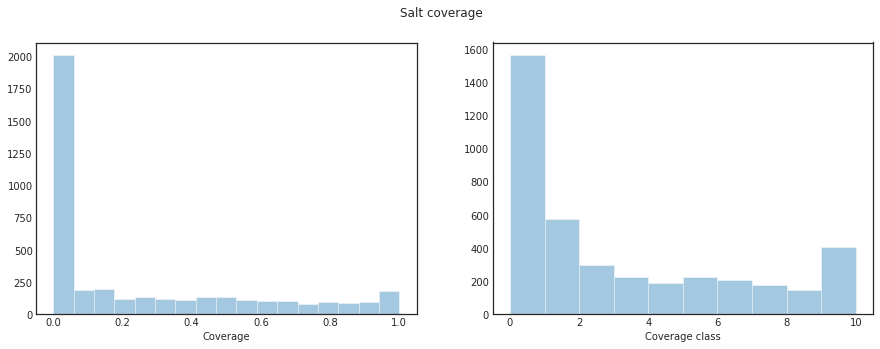

In [5]:
plot_coverage_and_coverage_class(train_df.coverage, train_df.coverage_class)

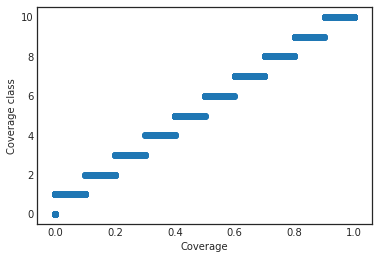

In [6]:
scatter_coverage_and_coverage_class(train_df.coverage, train_df.coverage_class)

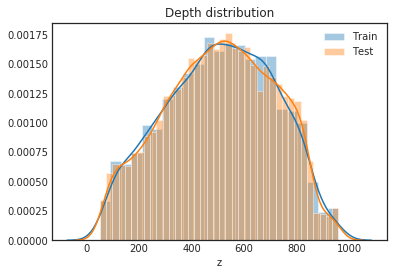

In [7]:
plot_depth_distributions(train_df.z, test_df.z)

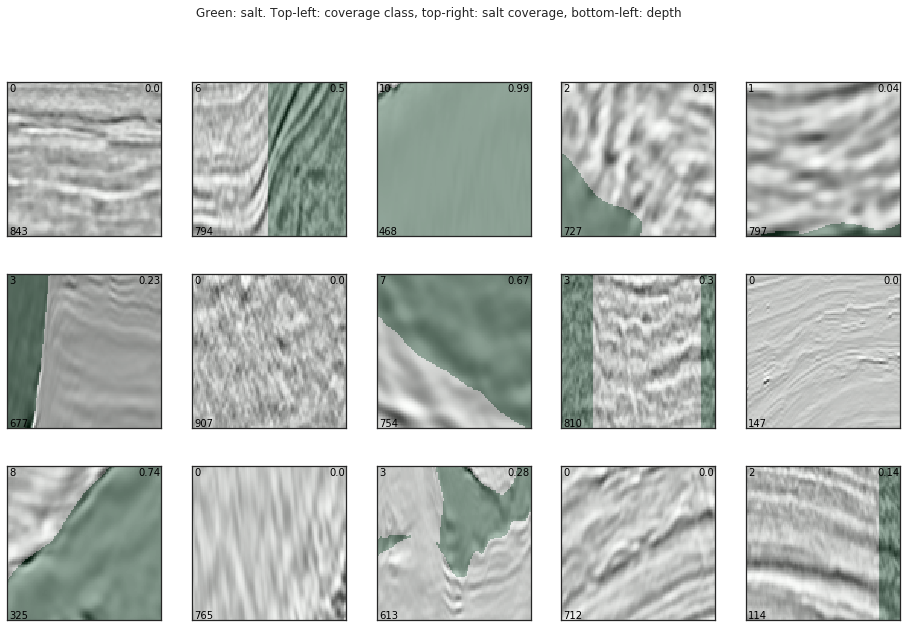

In [8]:
plot_images(train_df, max_images=15, grid_width=5, figsize=(16,10))

In [9]:
img_size_target=128
upsample101to128 = upsample(101,128)

In [10]:
ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = train_test_split(
    train_df.index.values,
    np.array(train_df.images.map(upsample101to128).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    np.array(train_df.masks.map(upsample101to128).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    train_df.coverage.values,
    train_df.z.values,
    test_size=0.2, stratify=train_df.coverage_class, random_state=1337)

In [11]:
def build_model(input_layer, start_neurons):
    # 128 -> 64
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    # 64 -> 32
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    # 32 -> 16
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    # 16 -> 8
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)

    # 8 -> 16
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    # 16 -> 32
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    # 32 -> 64
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    # 64 -> 128
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)

    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer

input_layer = Input((img_size_target, img_size_target, 1))
output_layer = build_model(input_layer, 16)

In [12]:
model = Model(input_layer, output_layer)

In [13]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy", my_iou_metric])

In [14]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 16) 2320        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 64, 64, 16)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
dropout_1 

In [15]:
# Augment data with flipped verisons
x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)

In [16]:
model_filepath=os.path.join(model_path(), 'keras.model')
early_stopping = EarlyStopping(patience=10, verbose=1)
model_checkpoint = ModelCheckpoint(model_filepath, save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)

epochs = 200
batch_size = 32

history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr])

Train on 6400 samples, validate on 800 samples
Epoch 1/200


  32/6400 [..............................] - ETA: 28:07 - loss: 0.6891 - acc: 0.5756 - my_iou_metric: 0.0000e+00

  96/6400 [..............................] - ETA: 9:22 - loss: 0.6831 - acc: 0.6554 - my_iou_metric: 0.0208     

 160/6400 [..............................] - ETA: 5:37 - loss: 0.6653 - acc: 0.7070 - my_iou_metric: 0.0250

 224/6400 [>.............................] - ETA: 4:00 - loss: 0.6839 - acc: 0.7170 - my_iou_metric: 0.0625

 288/6400 [>.............................] - ETA: 3:07 - loss: 0.6648 - acc: 0.7279 - my_iou_metric: 0.1354

 352/6400 [>.............................] - ETA: 2:32 - loss: 0.6545 - acc: 0.7334 - my_iou_metric: 0.1790

 416/6400 [>.............................] - ETA: 2:09 - loss: 0.6476 - acc: 0.7403 - my_iou_metric: 0.2091

 480/6400 [=>............................] - ETA: 1:51 - loss: 0.6429 - acc: 0.7439 - my_iou_metric: 0.2396

 544/6400 [=>............................] - ETA: 1:38 - loss: 0.6391 - acc: 0.7436 - my_iou_metric: 0.2482

 608/6400 [=>............................] - ETA: 1:27 - loss: 0.6314 - acc: 0.7508 - my_iou_metric: 0.2796

 672/6400 [==>...........................] - ETA: 1:19 - loss: 0.6227 - acc: 0.7564 - my_iou_metric: 0.2872

 736/6400 [==>...........................] - ETA: 1:12 - loss: 0.6268 - acc: 0.7458 - my_iou_metric: 0.2894

 800/6400 [==>...........................] - ETA: 1:06 - loss: 0.6241 - acc: 0.7437 - my_iou_metric: 0.2913

 864/6400 [===>..........................] - ETA: 1:01 - loss: 0.6180 - acc: 0.7456 - my_iou_metric: 0.3056

 928/6400 [===>..........................] - ETA: 56s - loss: 0.6209 - acc: 0.7407 - my_iou_metric: 0.3017 

 992/6400 [===>..........................] - ETA: 53s - loss: 0.6177 - acc: 0.7410 - my_iou_metric: 0.3095

1056/6400 [===>..........................] - ETA: 49s - loss: 0.6136 - acc: 0.7423 - my_iou_metric: 0.3134

1120/6400 [====>.........................] - ETA: 46s - loss: 0.6123 - acc: 0.7414 - my_iou_metric: 0.3179

1184/6400 [====>.........................] - ETA: 43s - loss: 0.6090 - acc: 0.7426 - my_iou_metric: 0.3252

1248/6400 [====>.........................] - ETA: 41s - loss: 0.6081 - acc: 0.7415 - my_iou_metric: 0.3245

1312/6400 [=====>........................] - ETA: 39s - loss: 0.6049 - acc: 0.7429 - my_iou_metric: 0.3293

1376/6400 [=====>........................] - ETA: 37s - loss: 0.6038 - acc: 0.7423 - my_iou_metric: 0.3299

1440/6400 [=====>........................] - ETA: 35s - loss: 0.6049 - acc: 0.7395 - my_iou_metric: 0.3306

1504/6400 [======>.......................] - ETA: 33s - loss: 0.6036 - acc: 0.7391 - my_iou_metric: 0.3331

1568/6400 [======>.......................] - ETA: 32s - loss: 0.6051 - acc: 0.7357 - my_iou_metric: 0.3323

1632/6400 [======>.......................] - ETA: 30s - loss: 0.6037 - acc: 0.7356 - my_iou_metric: 0.3364

1696/6400 [======>.......................] - ETA: 29s - loss: 0.6003 - acc: 0.7379 - my_iou_metric: 0.3384

1760/6400 [=======>......................] - ETA: 28s - loss: 0.5977 - acc: 0.7390 - my_iou_metric: 0.3420

1824/6400 [=======>......................] - ETA: 27s - loss: 0.5983 - acc: 0.7379 - my_iou_metric: 0.3438

1888/6400 [=======>......................] - ETA: 26s - loss: 0.5985 - acc: 0.7365 - my_iou_metric: 0.3432

1952/6400 [========>.....................] - ETA: 25s - loss: 0.5969 - acc: 0.7371 - my_iou_metric: 0.3478

2016/6400 [========>.....................] - ETA: 24s - loss: 0.5952 - acc: 0.7381 - my_iou_metric: 0.3492

2080/6400 [========>.....................] - ETA: 23s - loss: 0.5926 - acc: 0.7402 - my_iou_metric: 0.3524

2144/6400 [=========>....................] - ETA: 22s - loss: 0.5908 - acc: 0.7407 - my_iou_metric: 0.3535

2208/6400 [=========>....................] - ETA: 21s - loss: 0.5897 - acc: 0.7410 - my_iou_metric: 0.3519

2272/6400 [=========>....................] - ETA: 20s - loss: 0.5898 - acc: 0.7402 - my_iou_metric: 0.3508

2336/6400 [=========>....................] - ETA: 19s - loss: 0.5907 - acc: 0.7386 - my_iou_metric: 0.3485

2400/6400 [==========>...................] - ETA: 19s - loss: 0.5899 - acc: 0.7387 - my_iou_metric: 0.3504

2464/6400 [==========>...................] - ETA: 18s - loss: 0.5883 - acc: 0.7395 - my_iou_metric: 0.3531

2528/6400 [==========>...................] - ETA: 17s - loss: 0.5883 - acc: 0.7385 - my_iou_metric: 0.3536

2592/6400 [===========>..................] - ETA: 17s - loss: 0.5871 - acc: 0.7387 - my_iou_metric: 0.3538

2656/6400 [===========>..................] - ETA: 16s - loss: 0.5839 - acc: 0.7408 - my_iou_metric: 0.3569

2720/6400 [===========>..................] - ETA: 16s - loss: 0.5829 - acc: 0.7411 - my_iou_metric: 0.3570

2784/6400 [============>.................] - ETA: 15s - loss: 0.5831 - acc: 0.7406 - my_iou_metric: 0.3581

2848/6400 [============>.................] - ETA: 15s - loss: 0.5821 - acc: 0.7408 - my_iou_metric: 0.3571

2912/6400 [============>.................] - ETA: 14s - loss: 0.5819 - acc: 0.7405 - my_iou_metric: 0.3582

2976/6400 [============>.................] - ETA: 14s - loss: 0.5801 - acc: 0.7419 - my_iou_metric: 0.3606

3040/6400 [=============>................] - ETA: 13s - loss: 0.5800 - acc: 0.7414 - my_iou_metric: 0.3612

3104/6400 [=============>................] - ETA: 13s - loss: 0.5788 - acc: 0.7418 - my_iou_metric: 0.3637

3168/6400 [=============>................] - ETA: 12s - loss: 0.5764 - acc: 0.7432 - my_iou_metric: 0.3655

3232/6400 [==============>...............] - ETA: 12s - loss: 0.5754 - acc: 0.7436 - my_iou_metric: 0.3657

3296/6400 [==============>...............] - ETA: 11s - loss: 0.5735 - acc: 0.7445 - my_iou_metric: 0.3671

3360/6400 [==============>...............] - ETA: 11s - loss: 0.5726 - acc: 0.7449 - my_iou_metric: 0.3664

3424/6400 [===============>..............] - ETA: 11s - loss: 0.5711 - acc: 0.7456 - my_iou_metric: 0.3695

3488/6400 [===============>..............] - ETA: 10s - loss: 0.5686 - acc: 0.7472 - my_iou_metric: 0.3716

3552/6400 [===============>..............] - ETA: 10s - loss: 0.5673 - acc: 0.7478 - my_iou_metric: 0.3725

3616/6400 [===============>..............] - ETA: 10s - loss: 0.5658 - acc: 0.7485 - my_iou_metric: 0.3722

3680/6400 [================>.............] - ETA: 9s - loss: 0.5660 - acc: 0.7479 - my_iou_metric: 0.3723 

3744/6400 [================>.............] - ETA: 9s - loss: 0.5656 - acc: 0.7476 - my_iou_metric: 0.3718

3808/6400 [================>.............] - ETA: 9s - loss: 0.5643 - acc: 0.7486 - my_iou_metric: 0.3732

3872/6400 [=================>............] - ETA: 8s - loss: 0.5640 - acc: 0.7482 - my_iou_metric: 0.3732

3936/6400 [=================>............] - ETA: 8s - loss: 0.5633 - acc: 0.7483 - my_iou_metric: 0.3735

4000/6400 [=================>............] - ETA: 8s - loss: 0.5624 - acc: 0.7485 - my_iou_metric: 0.3738

4064/6400 [==================>...........] - ETA: 7s - loss: 0.5621 - acc: 0.7481 - my_iou_metric: 0.3745

4128/6400 [==================>...........] - ETA: 7s - loss: 0.5614 - acc: 0.7483 - my_iou_metric: 0.3743

4192/6400 [==================>...........] - ETA: 7s - loss: 0.5602 - acc: 0.7489 - my_iou_metric: 0.3745

4256/6400 [==================>...........] - ETA: 7s - loss: 0.5598 - acc: 0.7486 - my_iou_metric: 0.3750

4320/6400 [===================>..........] - ETA: 6s - loss: 0.5572 - acc: 0.7499 - my_iou_metric: 0.3778

4384/6400 [===================>..........] - ETA: 6s - loss: 0.5579 - acc: 0.7493 - my_iou_metric: 0.3777

4448/6400 [===================>..........] - ETA: 6s - loss: 0.5579 - acc: 0.7491 - my_iou_metric: 0.3777

4512/6400 [====================>.........] - ETA: 5s - loss: 0.5571 - acc: 0.7500 - my_iou_metric: 0.3797

4576/6400 [====================>.........] - ETA: 5s - loss: 0.5566 - acc: 0.7504 - my_iou_metric: 0.3796

4640/6400 [====================>.........] - ETA: 5s - loss: 0.5568 - acc: 0.7496 - my_iou_metric: 0.3795

4704/6400 [=====================>........] - ETA: 5s - loss: 0.5551 - acc: 0.7506 - my_iou_metric: 0.3807

4768/6400 [=====================>........] - ETA: 5s - loss: 0.5553 - acc: 0.7503 - my_iou_metric: 0.3798

4832/6400 [=====================>........] - ETA: 4s - loss: 0.5551 - acc: 0.7501 - my_iou_metric: 0.3791

4896/6400 [=====================>........] - ETA: 4s - loss: 0.5546 - acc: 0.7502 - my_iou_metric: 0.3785

4960/6400 [======================>.......] - ETA: 4s - loss: 0.5544 - acc: 0.7498 - my_iou_metric: 0.3784

5024/6400 [======================>.......] - ETA: 4s - loss: 0.5535 - acc: 0.7500 - my_iou_metric: 0.3784

5088/6400 [======================>.......] - ETA: 3s - loss: 0.5538 - acc: 0.7494 - my_iou_metric: 0.3781

5152/6400 [=======================>......] - ETA: 3s - loss: 0.5533 - acc: 0.7491 - my_iou_metric: 0.3769

5216/6400 [=======================>......] - ETA: 3s - loss: 0.5523 - acc: 0.7497 - my_iou_metric: 0.3763

5280/6400 [=======================>......] - ETA: 3s - loss: 0.5518 - acc: 0.7498 - my_iou_metric: 0.3771

5344/6400 [========================>.....] - ETA: 3s - loss: 0.5508 - acc: 0.7500 - my_iou_metric: 0.3776

5408/6400 [========================>.....] - ETA: 2s - loss: 0.5502 - acc: 0.7495 - my_iou_metric: 0.3780

5472/6400 [========================>.....] - ETA: 2s - loss: 0.5493 - acc: 0.7496 - my_iou_metric: 0.3790

5536/6400 [========================>.....] - ETA: 2s - loss: 0.5492 - acc: 0.7492 - my_iou_metric: 0.3788

5600/6400 [=========================>....] - ETA: 2s - loss: 0.5486 - acc: 0.7493 - my_iou_metric: 0.3789

5664/6400 [=========================>....] - ETA: 2s - loss: 0.5477 - acc: 0.7497 - my_iou_metric: 0.3785

5728/6400 [=========================>....] - ETA: 1s - loss: 0.5474 - acc: 0.7494 - my_iou_metric: 0.3783

5792/6400 [==========================>...] - ETA: 1s - loss: 0.5459 - acc: 0.7498 - my_iou_metric: 0.3791

5856/6400 [==========================>...] - ETA: 1s - loss: 0.5454 - acc: 0.7491 - my_iou_metric: 0.3774

5920/6400 [==========================>...] - ETA: 1s - loss: 0.5442 - acc: 0.7494 - my_iou_metric: 0.3777

5984/6400 [===========================>..] - ETA: 1s - loss: 0.5445 - acc: 0.7486 - my_iou_metric: 0.3762

6048/6400 [===========================>..] - ETA: 0s - loss: 0.5445 - acc: 0.7477 - my_iou_metric: 0.3763

6112/6400 [===========================>..] - ETA: 0s - loss: 0.5446 - acc: 0.7470 - my_iou_metric: 0.3758

6176/6400 [===========================>..] - ETA: 0s - loss: 0.5442 - acc: 0.7471 - my_iou_metric: 0.3763

6240/6400 [============================>.] - ETA: 0s - loss: 0.5432 - acc: 0.7471 - my_iou_metric: 0.3758

6304/6400 [============================>.] - ETA: 0s - loss: 0.5427 - acc: 0.7468 - my_iou_metric: 0.3766

6368/6400 [============================>.] - ETA: 0s - loss: 0.5415 - acc: 0.7474 - my_iou_metric: 0.3780

6400/6400 [==============================] - 17s 3ms/step - loss: 0.5410 - acc: 0.7474 - my_iou_metric: 0.3784 - val_loss: 0.4664 - val_acc: 0.7468 - val_my_iou_metric: 0.3900



Epoch 00001: val_loss improved from inf to 0.46641, saving model to /mnt/models/baseline/keras.model


Epoch 2/200
  32/6400 [..............................] - ETA: 8s - loss: 0.6153 - acc: 0.6992 - my_iou_metric: 0.2812

  96/6400 [..............................] - ETA: 8s - loss: 0.4965 - acc: 0.7371 - my_iou_metric: 0.3750

 160/6400 [..............................] - ETA: 8s - loss: 0.4843 - acc: 0.7393 - my_iou_metric: 0.3812

 224/6400 [>.............................] - ETA: 8s - loss: 0.4900 - acc: 0.7268 - my_iou_metric: 0.3527

 288/6400 [>.............................] - ETA: 7s - loss: 0.4772 - acc: 0.7311 - my_iou_metric: 0.3611

 352/6400 [>.............................] - ETA: 7s - loss: 0.4715 - acc: 0.7359 - my_iou_metric: 0.3722

 416/6400 [>.............................] - ETA: 7s - loss: 0.4729 - acc: 0.7386 - my_iou_metric: 0.3774

 480/6400 [=>............................] - ETA: 7s - loss: 0.4711 - acc: 0.7353 - my_iou_metric: 0.3604

 544/6400 [=>............................] - ETA: 7s - loss: 0.4671 - acc: 0.7432 - my_iou_metric: 0.3474

 608/6400 [=>............................] - ETA: 7s - loss: 0.4650 - acc: 0.7458 - my_iou_metric: 0.3520

 672/6400 [==>...........................] - ETA: 7s - loss: 0.4628 - acc: 0.7498 - my_iou_metric: 0.3586

 736/6400 [==>...........................] - ETA: 7s - loss: 0.4680 - acc: 0.7477 - my_iou_metric: 0.3560

 800/6400 [==>...........................] - ETA: 7s - loss: 0.4608 - acc: 0.7497 - my_iou_metric: 0.3575

 864/6400 [===>..........................] - ETA: 7s - loss: 0.4593 - acc: 0.7483 - my_iou_metric: 0.3542

 928/6400 [===>..........................] - ETA: 7s - loss: 0.4595 - acc: 0.7465 - my_iou_metric: 0.3545

 992/6400 [===>..........................] - ETA: 7s - loss: 0.4564 - acc: 0.7477 - my_iou_metric: 0.3629

1056/6400 [===>..........................] - ETA: 6s - loss: 0.4519 - acc: 0.7505 - my_iou_metric: 0.3684

1120/6400 [====>.........................] - ETA: 6s - loss: 0.4524 - acc: 0.7512 - my_iou_metric: 0.3670

1184/6400 [====>.........................] - ETA: 6s - loss: 0.4483 - acc: 0.7556 - my_iou_metric: 0.3767

1248/6400 [====>.........................] - ETA: 6s - loss: 0.4484 - acc: 0.7572 - my_iou_metric: 0.3758

1312/6400 [=====>........................] - ETA: 6s - loss: 0.4487 - acc: 0.7564 - my_iou_metric: 0.3727

1376/6400 [=====>........................] - ETA: 6s - loss: 0.4498 - acc: 0.7559 - my_iou_metric: 0.3750

1440/6400 [=====>........................] - ETA: 6s - loss: 0.4528 - acc: 0.7520 - my_iou_metric: 0.3708

1504/6400 [======>.......................] - ETA: 6s - loss: 0.4515 - acc: 0.7518 - my_iou_metric: 0.3730

1568/6400 [======>.......................] - ETA: 6s - loss: 0.4482 - acc: 0.7539 - my_iou_metric: 0.3782

1632/6400 [======>.......................] - ETA: 6s - loss: 0.4476 - acc: 0.7529 - my_iou_metric: 0.3762

1696/6400 [======>.......................] - ETA: 6s - loss: 0.4474 - acc: 0.7546 - my_iou_metric: 0.3691

1760/6400 [=======>......................] - ETA: 6s - loss: 0.4487 - acc: 0.7537 - my_iou_metric: 0.3659

1824/6400 [=======>......................] - ETA: 5s - loss: 0.4460 - acc: 0.7550 - my_iou_metric: 0.3668

1888/6400 [=======>......................] - ETA: 5s - loss: 0.4446 - acc: 0.7556 - my_iou_metric: 0.3686

1952/6400 [========>.....................] - ETA: 5s - loss: 0.4438 - acc: 0.7577 - my_iou_metric: 0.3674

2016/6400 [========>.....................] - ETA: 5s - loss: 0.4450 - acc: 0.7580 - my_iou_metric: 0.3649

2080/6400 [========>.....................] - ETA: 5s - loss: 0.4463 - acc: 0.7574 - my_iou_metric: 0.3668

2144/6400 [=========>....................] - ETA: 5s - loss: 0.4470 - acc: 0.7587 - my_iou_metric: 0.3648

2208/6400 [=========>....................] - ETA: 5s - loss: 0.4460 - acc: 0.7610 - my_iou_metric: 0.3647

2272/6400 [=========>....................] - ETA: 5s - loss: 0.4447 - acc: 0.7618 - my_iou_metric: 0.3639

2336/6400 [=========>....................] - ETA: 5s - loss: 0.4441 - acc: 0.7636 - my_iou_metric: 0.3634

2400/6400 [==========>...................] - ETA: 5s - loss: 0.4434 - acc: 0.7656 - my_iou_metric: 0.3657

2464/6400 [==========>...................] - ETA: 5s - loss: 0.4424 - acc: 0.7674 - my_iou_metric: 0.3672

2528/6400 [==========>...................] - ETA: 5s - loss: 0.4400 - acc: 0.7695 - my_iou_metric: 0.3702

2592/6400 [===========>..................] - ETA: 4s - loss: 0.4402 - acc: 0.7710 - my_iou_metric: 0.3684

2656/6400 [===========>..................] - ETA: 4s - loss: 0.4408 - acc: 0.7719 - my_iou_metric: 0.3701

2720/6400 [===========>..................] - ETA: 4s - loss: 0.4405 - acc: 0.7736 - my_iou_metric: 0.3718

2784/6400 [============>.................] - ETA: 4s - loss: 0.4400 - acc: 0.7749 - my_iou_metric: 0.3712

2848/6400 [============>.................] - ETA: 4s - loss: 0.4370 - acc: 0.7773 - my_iou_metric: 0.3714

2912/6400 [============>.................] - ETA: 4s - loss: 0.4339 - acc: 0.7795 - my_iou_metric: 0.3734

2976/6400 [============>.................] - ETA: 4s - loss: 0.4341 - acc: 0.7800 - my_iou_metric: 0.3750

3040/6400 [=============>................] - ETA: 4s - loss: 0.4341 - acc: 0.7806 - my_iou_metric: 0.3741

3104/6400 [=============>................] - ETA: 4s - loss: 0.4336 - acc: 0.7813 - my_iou_metric: 0.3715

3168/6400 [=============>................] - ETA: 4s - loss: 0.4320 - acc: 0.7830 - my_iou_metric: 0.3728

3232/6400 [==============>...............] - ETA: 4s - loss: 0.4319 - acc: 0.7841 - my_iou_metric: 0.3720

3296/6400 [==============>...............] - ETA: 4s - loss: 0.4319 - acc: 0.7848 - my_iou_metric: 0.3723

3360/6400 [==============>...............] - ETA: 3s - loss: 0.4320 - acc: 0.7847 - my_iou_metric: 0.3715

3424/6400 [===============>..............] - ETA: 3s - loss: 0.4312 - acc: 0.7857 - my_iou_metric: 0.3714

3488/6400 [===============>..............] - ETA: 3s - loss: 0.4306 - acc: 0.7868 - my_iou_metric: 0.3722

3552/6400 [===============>..............] - ETA: 3s - loss: 0.4300 - acc: 0.7881 - my_iou_metric: 0.3749

3616/6400 [===============>..............] - ETA: 3s - loss: 0.4289 - acc: 0.7893 - my_iou_metric: 0.3754

3680/6400 [================>.............] - ETA: 3s - loss: 0.4305 - acc: 0.7888 - my_iou_metric: 0.3751

3744/6400 [================>.............] - ETA: 3s - loss: 0.4305 - acc: 0.7894 - my_iou_metric: 0.3731

3808/6400 [================>.............] - ETA: 3s - loss: 0.4310 - acc: 0.7898 - my_iou_metric: 0.3747

3872/6400 [=================>............] - ETA: 3s - loss: 0.4297 - acc: 0.7911 - my_iou_metric: 0.3766

3936/6400 [=================>............] - ETA: 3s - loss: 0.4288 - acc: 0.7919 - my_iou_metric: 0.3772

4000/6400 [=================>............] - ETA: 3s - loss: 0.4288 - acc: 0.7924 - my_iou_metric: 0.3786

4064/6400 [==================>...........] - ETA: 3s - loss: 0.4278 - acc: 0.7934 - my_iou_metric: 0.3801

4128/6400 [==================>...........] - ETA: 2s - loss: 0.4261 - acc: 0.7948 - my_iou_metric: 0.3815

4192/6400 [==================>...........] - ETA: 2s - loss: 0.4254 - acc: 0.7954 - my_iou_metric: 0.3824

4256/6400 [==================>...........] - ETA: 2s - loss: 0.4249 - acc: 0.7960 - my_iou_metric: 0.3835

4320/6400 [===================>..........] - ETA: 2s - loss: 0.4238 - acc: 0.7969 - my_iou_metric: 0.3855

4384/6400 [===================>..........] - ETA: 2s - loss: 0.4229 - acc: 0.7975 - my_iou_metric: 0.3857

4448/6400 [===================>..........] - ETA: 2s - loss: 0.4229 - acc: 0.7973 - my_iou_metric: 0.3841

4512/6400 [====================>.........] - ETA: 2s - loss: 0.4220 - acc: 0.7981 - my_iou_metric: 0.3846

4576/6400 [====================>.........] - ETA: 2s - loss: 0.4232 - acc: 0.7985 - my_iou_metric: 0.3850

4640/6400 [====================>.........] - ETA: 2s - loss: 0.4229 - acc: 0.7989 - my_iou_metric: 0.3843

4704/6400 [=====================>........] - ETA: 2s - loss: 0.4228 - acc: 0.7992 - my_iou_metric: 0.3848

4768/6400 [=====================>........] - ETA: 2s - loss: 0.4227 - acc: 0.7995 - my_iou_metric: 0.3853

4832/6400 [=====================>........] - ETA: 2s - loss: 0.4233 - acc: 0.7995 - my_iou_metric: 0.3858

4896/6400 [=====================>........] - ETA: 1s - loss: 0.4228 - acc: 0.8000 - my_iou_metric: 0.3868

4960/6400 [======================>.......] - ETA: 1s - loss: 0.4229 - acc: 0.8002 - my_iou_metric: 0.3857

5024/6400 [======================>.......] - ETA: 1s - loss: 0.4226 - acc: 0.8004 - my_iou_metric: 0.3864

5088/6400 [======================>.......] - ETA: 1s - loss: 0.4223 - acc: 0.8007 - my_iou_metric: 0.3870

5152/6400 [=======================>......] - ETA: 1s - loss: 0.4220 - acc: 0.8008 - my_iou_metric: 0.3880

5216/6400 [=======================>......] - ETA: 1s - loss: 0.4225 - acc: 0.8008 - my_iou_metric: 0.3882

5280/6400 [=======================>......] - ETA: 1s - loss: 0.4215 - acc: 0.8015 - my_iou_metric: 0.3895

5344/6400 [========================>.....] - ETA: 1s - loss: 0.4213 - acc: 0.8019 - my_iou_metric: 0.3890

5408/6400 [========================>.....] - ETA: 1s - loss: 0.4200 - acc: 0.8029 - my_iou_metric: 0.3896

5472/6400 [========================>.....] - ETA: 1s - loss: 0.4185 - acc: 0.8039 - my_iou_metric: 0.3908

5536/6400 [========================>.....] - ETA: 1s - loss: 0.4172 - acc: 0.8047 - my_iou_metric: 0.3925

5600/6400 [=========================>....] - ETA: 1s - loss: 0.4159 - acc: 0.8056 - my_iou_metric: 0.3931

5664/6400 [=========================>....] - ETA: 0s - loss: 0.4154 - acc: 0.8059 - my_iou_metric: 0.3925

5728/6400 [=========================>....] - ETA: 0s - loss: 0.4146 - acc: 0.8066 - my_iou_metric: 0.3911

5792/6400 [==========================>...] - ETA: 0s - loss: 0.4142 - acc: 0.8071 - my_iou_metric: 0.3914

5856/6400 [==========================>...] - ETA: 0s - loss: 0.4146 - acc: 0.8069 - my_iou_metric: 0.3913

5920/6400 [==========================>...] - ETA: 0s - loss: 0.4140 - acc: 0.8073 - my_iou_metric: 0.3918

5984/6400 [===========================>..] - ETA: 0s - loss: 0.4139 - acc: 0.8074 - my_iou_metric: 0.3908

6048/6400 [===========================>..] - ETA: 0s - loss: 0.4130 - acc: 0.8080 - my_iou_metric: 0.3914

6112/6400 [===========================>..] - ETA: 0s - loss: 0.4128 - acc: 0.8082 - my_iou_metric: 0.3922

6176/6400 [===========================>..] - ETA: 0s - loss: 0.4120 - acc: 0.8086 - my_iou_metric: 0.3928

6240/6400 [============================>.] - ETA: 0s - loss: 0.4117 - acc: 0.8090 - my_iou_metric: 0.3929

6304/6400 [============================>.] - ETA: 0s - loss: 0.4115 - acc: 0.8091 - my_iou_metric: 0.3922

6368/6400 [============================>.] - ETA: 0s - loss: 0.4116 - acc: 0.8092 - my_iou_metric: 0.3928

6400/6400 [==============================] - 9s 1ms/step - loss: 0.4116 - acc: 0.8093 - my_iou_metric: 0.3930 - val_loss: 0.3763 - val_acc: 0.8522 - val_my_iou_metric: 0.4791



Epoch 00002: val_loss improved from 0.46641 to 0.37631, saving model to /mnt/models/baseline/keras.model
Epoch 3/200
  32/6400 [..............................] - ETA: 8s - loss: 0.4050 - acc: 0.8440 - my_iou_metric: 0.5594

  96/6400 [..............................] - ETA: 8s - loss: 0.3645 - acc: 0.8616 - my_iou_metric: 0.4958

 160/6400 [..............................] - ETA: 8s - loss: 0.3779 - acc: 0.8490 - my_iou_metric: 0.4394

 224/6400 [>.............................] - ETA: 7s - loss: 0.3623 - acc: 0.8533 - my_iou_metric: 0.4237

 288/6400 [>.............................] - ETA: 7s - loss: 0.3582 - acc: 0.8561 - my_iou_metric: 0.4066

 352/6400 [>.............................] - ETA: 7s - loss: 0.3699 - acc: 0.8481 - my_iou_metric: 0.4040

 416/6400 [>.............................] - ETA: 7s - loss: 0.3655 - acc: 0.8505 - my_iou_metric: 0.4144

 480/6400 [=>............................] - ETA: 7s - loss: 0.3515 - acc: 0.8567 - my_iou_metric: 0.4225

 544/6400 [=>............................] - ETA: 7s - loss: 0.3516 - acc: 0.8549 - my_iou_metric: 0.4257

 608/6400 [=>............................] - ETA: 7s - loss: 0.3477 - acc: 0.8581 - my_iou_metric: 0.4395

 672/6400 [==>...........................] - ETA: 7s - loss: 0.3547 - acc: 0.8539 - my_iou_metric: 0.4332

 736/6400 [==>...........................] - ETA: 7s - loss: 0.3549 - acc: 0.8541 - my_iou_metric: 0.4242

 800/6400 [==>...........................] - ETA: 7s - loss: 0.3598 - acc: 0.8521 - my_iou_metric: 0.4103

 864/6400 [===>..........................] - ETA: 7s - loss: 0.3607 - acc: 0.8522 - my_iou_metric: 0.4074

 928/6400 [===>..........................] - ETA: 7s - loss: 0.3717 - acc: 0.8475 - my_iou_metric: 0.4025

 992/6400 [===>..........................] - ETA: 6s - loss: 0.3748 - acc: 0.8452 - my_iou_metric: 0.4032

1056/6400 [===>..........................] - ETA: 6s - loss: 0.3812 - acc: 0.8415 - my_iou_metric: 0.4034

1120/6400 [====>.........................] - ETA: 6s - loss: 0.3868 - acc: 0.8389 - my_iou_metric: 0.3950

1184/6400 [====>.........................] - ETA: 6s - loss: 0.3862 - acc: 0.8394 - my_iou_metric: 0.3959

1248/6400 [====>.........................] - ETA: 6s - loss: 0.3966 - acc: 0.8316 - my_iou_metric: 0.3869

1312/6400 [=====>........................] - ETA: 6s - loss: 0.3930 - acc: 0.8340 - my_iou_metric: 0.3955

1376/6400 [=====>........................] - ETA: 6s - loss: 0.3908 - acc: 0.8351 - my_iou_metric: 0.3976

1440/6400 [=====>........................] - ETA: 6s - loss: 0.3887 - acc: 0.8366 - my_iou_metric: 0.4002

1504/6400 [======>.......................] - ETA: 6s - loss: 0.3884 - acc: 0.8367 - my_iou_metric: 0.3997

1568/6400 [======>.......................] - ETA: 6s - loss: 0.3907 - acc: 0.8354 - my_iou_metric: 0.4041

1632/6400 [======>.......................] - ETA: 6s - loss: 0.3898 - acc: 0.8370 - my_iou_metric: 0.3972

1696/6400 [======>.......................] - ETA: 6s - loss: 0.3906 - acc: 0.8375 - my_iou_metric: 0.3932

1760/6400 [=======>......................] - ETA: 5s - loss: 0.3919 - acc: 0.8366 - my_iou_metric: 0.3906

1824/6400 [=======>......................] - ETA: 5s - loss: 0.3908 - acc: 0.8370 - my_iou_metric: 0.3905

1888/6400 [=======>......................] - ETA: 5s - loss: 0.3909 - acc: 0.8372 - my_iou_metric: 0.3932

1952/6400 [========>.....................] - ETA: 5s - loss: 0.3904 - acc: 0.8374 - my_iou_metric: 0.3936

2016/6400 [========>.....................] - ETA: 5s - loss: 0.3915 - acc: 0.8369 - my_iou_metric: 0.3911

2080/6400 [========>.....................] - ETA: 5s - loss: 0.3882 - acc: 0.8389 - my_iou_metric: 0.3912

2144/6400 [=========>....................] - ETA: 5s - loss: 0.3872 - acc: 0.8389 - my_iou_metric: 0.3944

2208/6400 [=========>....................] - ETA: 5s - loss: 0.3872 - acc: 0.8387 - my_iou_metric: 0.3956

2272/6400 [=========>....................] - ETA: 5s - loss: 0.3902 - acc: 0.8372 - my_iou_metric: 0.3950

2336/6400 [=========>....................] - ETA: 5s - loss: 0.3892 - acc: 0.8377 - my_iou_metric: 0.3967

2400/6400 [==========>...................] - ETA: 5s - loss: 0.3902 - acc: 0.8374 - my_iou_metric: 0.3962

2464/6400 [==========>...................] - ETA: 5s - loss: 0.3902 - acc: 0.8372 - my_iou_metric: 0.3976

2528/6400 [==========>...................] - ETA: 5s - loss: 0.3918 - acc: 0.8366 - my_iou_metric: 0.3989

2592/6400 [===========>..................] - ETA: 4s - loss: 0.3925 - acc: 0.8364 - my_iou_metric: 0.3991

2656/6400 [===========>..................] - ETA: 4s - loss: 0.3920 - acc: 0.8366 - my_iou_metric: 0.3990

2720/6400 [===========>..................] - ETA: 4s - loss: 0.3945 - acc: 0.8362 - my_iou_metric: 0.3995

2784/6400 [============>.................] - ETA: 4s - loss: 0.3938 - acc: 0.8367 - my_iou_metric: 0.3999

2848/6400 [============>.................] - ETA: 4s - loss: 0.3934 - acc: 0.8368 - my_iou_metric: 0.4001

2912/6400 [============>.................] - ETA: 4s - loss: 0.3935 - acc: 0.8367 - my_iou_metric: 0.3981

2976/6400 [============>.................] - ETA: 4s - loss: 0.3927 - acc: 0.8372 - my_iou_metric: 0.3962

3040/6400 [=============>................] - ETA: 4s - loss: 0.3924 - acc: 0.8376 - my_iou_metric: 0.3963

3104/6400 [=============>................] - ETA: 4s - loss: 0.3948 - acc: 0.8360 - my_iou_metric: 0.3957

3168/6400 [=============>................] - ETA: 4s - loss: 0.3945 - acc: 0.8362 - my_iou_metric: 0.3940

3232/6400 [==============>...............] - ETA: 4s - loss: 0.3947 - acc: 0.8361 - my_iou_metric: 0.3924

3296/6400 [==============>...............] - ETA: 4s - loss: 0.3946 - acc: 0.8362 - my_iou_metric: 0.3904

3360/6400 [==============>...............] - ETA: 3s - loss: 0.3953 - acc: 0.8357 - my_iou_metric: 0.3897

3424/6400 [===============>..............] - ETA: 3s - loss: 0.3951 - acc: 0.8357 - my_iou_metric: 0.3909

3488/6400 [===============>..............] - ETA: 3s - loss: 0.3945 - acc: 0.8357 - my_iou_metric: 0.3901

3552/6400 [===============>..............] - ETA: 3s - loss: 0.3946 - acc: 0.8357 - my_iou_metric: 0.3918

3616/6400 [===============>..............] - ETA: 3s - loss: 0.3931 - acc: 0.8367 - my_iou_metric: 0.3933

3680/6400 [================>.............] - ETA: 3s - loss: 0.3927 - acc: 0.8366 - my_iou_metric: 0.3926

3744/6400 [================>.............] - ETA: 3s - loss: 0.3936 - acc: 0.8359 - my_iou_metric: 0.3908

3808/6400 [================>.............] - ETA: 3s - loss: 0.3924 - acc: 0.8362 - my_iou_metric: 0.3891

3872/6400 [=================>............] - ETA: 3s - loss: 0.3924 - acc: 0.8358 - my_iou_metric: 0.3882

3936/6400 [=================>............] - ETA: 3s - loss: 0.3904 - acc: 0.8370 - my_iou_metric: 0.3883

4000/6400 [=================>............] - ETA: 3s - loss: 0.3900 - acc: 0.8372 - my_iou_metric: 0.3875

4064/6400 [==================>...........] - ETA: 3s - loss: 0.3897 - acc: 0.8372 - my_iou_metric: 0.3867

4128/6400 [==================>...........] - ETA: 2s - loss: 0.3885 - acc: 0.8377 - my_iou_metric: 0.3879

4192/6400 [==================>...........] - ETA: 2s - loss: 0.3877 - acc: 0.8381 - my_iou_metric: 0.3894

4256/6400 [==================>...........] - ETA: 2s - loss: 0.3878 - acc: 0.8380 - my_iou_metric: 0.3899

4320/6400 [===================>..........] - ETA: 2s - loss: 0.3882 - acc: 0.8379 - my_iou_metric: 0.3896

4384/6400 [===================>..........] - ETA: 2s - loss: 0.3879 - acc: 0.8379 - my_iou_metric: 0.3898

4448/6400 [===================>..........] - ETA: 2s - loss: 0.3887 - acc: 0.8374 - my_iou_metric: 0.3876

4512/6400 [====================>.........] - ETA: 2s - loss: 0.3885 - acc: 0.8375 - my_iou_metric: 0.3880

4576/6400 [====================>.........] - ETA: 2s - loss: 0.3885 - acc: 0.8374 - my_iou_metric: 0.3878

4640/6400 [====================>.........] - ETA: 2s - loss: 0.3876 - acc: 0.8377 - my_iou_metric: 0.3883

4704/6400 [=====================>........] - ETA: 2s - loss: 0.3873 - acc: 0.8379 - my_iou_metric: 0.3889

4768/6400 [=====================>........] - ETA: 2s - loss: 0.3856 - acc: 0.8387 - my_iou_metric: 0.3906

4832/6400 [=====================>........] - ETA: 2s - loss: 0.3854 - acc: 0.8388 - my_iou_metric: 0.3922

4896/6400 [=====================>........] - ETA: 1s - loss: 0.3837 - acc: 0.8395 - my_iou_metric: 0.3936

4960/6400 [======================>.......] - ETA: 1s - loss: 0.3836 - acc: 0.8396 - my_iou_metric: 0.3937

5024/6400 [======================>.......] - ETA: 1s - loss: 0.3834 - acc: 0.8397 - my_iou_metric: 0.3941

5088/6400 [======================>.......] - ETA: 1s - loss: 0.3830 - acc: 0.8399 - my_iou_metric: 0.3947

5152/6400 [=======================>......] - ETA: 1s - loss: 0.3823 - acc: 0.8401 - my_iou_metric: 0.3953

5216/6400 [=======================>......] - ETA: 1s - loss: 0.3818 - acc: 0.8403 - my_iou_metric: 0.3950

5280/6400 [=======================>......] - ETA: 1s - loss: 0.3808 - acc: 0.8408 - my_iou_metric: 0.3964

5344/6400 [========================>.....] - ETA: 1s - loss: 0.3803 - acc: 0.8408 - my_iou_metric: 0.3955

5408/6400 [========================>.....] - ETA: 1s - loss: 0.3798 - acc: 0.8412 - my_iou_metric: 0.3975

5472/6400 [========================>.....] - ETA: 1s - loss: 0.3788 - acc: 0.8417 - my_iou_metric: 0.3981

5536/6400 [========================>.....] - ETA: 1s - loss: 0.3778 - acc: 0.8422 - my_iou_metric: 0.3982

5600/6400 [=========================>....] - ETA: 1s - loss: 0.3782 - acc: 0.8421 - my_iou_metric: 0.3981

5664/6400 [=========================>....] - ETA: 0s - loss: 0.3772 - acc: 0.8427 - my_iou_metric: 0.3988

5728/6400 [=========================>....] - ETA: 0s - loss: 0.3761 - acc: 0.8431 - my_iou_metric: 0.3994

5792/6400 [==========================>...] - ETA: 0s - loss: 0.3763 - acc: 0.8431 - my_iou_metric: 0.4000

5856/6400 [==========================>...] - ETA: 0s - loss: 0.3768 - acc: 0.8429 - my_iou_metric: 0.4004

5920/6400 [==========================>...] - ETA: 0s - loss: 0.3763 - acc: 0.8432 - my_iou_metric: 0.4000

5984/6400 [===========================>..] - ETA: 0s - loss: 0.3761 - acc: 0.8434 - my_iou_metric: 0.3997

6048/6400 [===========================>..] - ETA: 0s - loss: 0.3748 - acc: 0.8440 - my_iou_metric: 0.4009

6112/6400 [===========================>..] - ETA: 0s - loss: 0.3747 - acc: 0.8441 - my_iou_metric: 0.4022

6176/6400 [===========================>..] - ETA: 0s - loss: 0.3745 - acc: 0.8443 - my_iou_metric: 0.4034

6240/6400 [============================>.] - ETA: 0s - loss: 0.3730 - acc: 0.8450 - my_iou_metric: 0.4055

6304/6400 [============================>.] - ETA: 0s - loss: 0.3727 - acc: 0.8451 - my_iou_metric: 0.4069

6368/6400 [============================>.] - ETA: 0s - loss: 0.3716 - acc: 0.8456 - my_iou_metric: 0.4080

6400/6400 [==============================] - 9s 1ms/step - loss: 0.3709 - acc: 0.8459 - my_iou_metric: 0.4090 - val_loss: 0.3285 - val_acc: 0.8659 - val_my_iou_metric: 0.5056



Epoch 00003: val_loss improved from 0.37631 to 0.32846, saving model to /mnt/models/baseline/keras.model
Epoch 4/200
  32/6400 [..............................] - ETA: 8s - loss: 0.3627 - acc: 0.8600 - my_iou_metric: 0.5281

  96/6400 [..............................] - ETA: 8s - loss: 0.3462 - acc: 0.8608 - my_iou_metric: 0.4354

 160/6400 [..............................] - ETA: 8s - loss: 0.3369 - acc: 0.8629 - my_iou_metric: 0.4069

 224/6400 [>.............................] - ETA: 7s - loss: 0.3533 - acc: 0.8525 - my_iou_metric: 0.3991

 288/6400 [>.............................] - ETA: 7s - loss: 0.3375 - acc: 0.8615 - my_iou_metric: 0.3854

 352/6400 [>.............................] - ETA: 7s - loss: 0.3336 - acc: 0.8613 - my_iou_metric: 0.3969

 416/6400 [>.............................] - ETA: 7s - loss: 0.3248 - acc: 0.8639 - my_iou_metric: 0.4267

 480/6400 [=>............................] - ETA: 7s - loss: 0.3320 - acc: 0.8652 - my_iou_metric: 0.4317

 544/6400 [=>............................] - ETA: 7s - loss: 0.3492 - acc: 0.8601 - my_iou_metric: 0.4353

 608/6400 [=>............................] - ETA: 7s - loss: 0.3620 - acc: 0.8519 - my_iou_metric: 0.4289

 672/6400 [==>...........................] - ETA: 7s - loss: 0.3713 - acc: 0.8476 - my_iou_metric: 0.4159

 736/6400 [==>...........................] - ETA: 7s - loss: 0.3758 - acc: 0.8482 - my_iou_metric: 0.4046

 800/6400 [==>...........................] - ETA: 7s - loss: 0.3789 - acc: 0.8474 - my_iou_metric: 0.4037

 864/6400 [===>..........................] - ETA: 7s - loss: 0.3836 - acc: 0.8442 - my_iou_metric: 0.4016

 928/6400 [===>..........................] - ETA: 7s - loss: 0.3834 - acc: 0.8448 - my_iou_metric: 0.4097

 992/6400 [===>..........................] - ETA: 7s - loss: 0.3861 - acc: 0.8425 - my_iou_metric: 0.4090

1056/6400 [===>..........................] - ETA: 7s - loss: 0.3821 - acc: 0.8434 - my_iou_metric: 0.4098

1120/6400 [====>.........................] - ETA: 6s - loss: 0.3807 - acc: 0.8443 - my_iou_metric: 0.4152

1184/6400 [====>.........................] - ETA: 6s - loss: 0.3835 - acc: 0.8431 - my_iou_metric: 0.4145

1248/6400 [====>.........................] - ETA: 6s - loss: 0.3855 - acc: 0.8428 - my_iou_metric: 0.4161

1312/6400 [=====>........................] - ETA: 6s - loss: 0.3830 - acc: 0.8440 - my_iou_metric: 0.4187

1376/6400 [=====>........................] - ETA: 6s - loss: 0.3791 - acc: 0.8460 - my_iou_metric: 0.4194

1440/6400 [=====>........................] - ETA: 6s - loss: 0.3792 - acc: 0.8462 - my_iou_metric: 0.4163

1504/6400 [======>.......................] - ETA: 6s - loss: 0.3817 - acc: 0.8435 - my_iou_metric: 0.4160

1568/6400 [======>.......................] - ETA: 6s - loss: 0.3779 - acc: 0.8451 - my_iou_metric: 0.4206

1632/6400 [======>.......................] - ETA: 6s - loss: 0.3769 - acc: 0.8458 - my_iou_metric: 0.4243

1696/6400 [======>.......................] - ETA: 6s - loss: 0.3773 - acc: 0.8444 - my_iou_metric: 0.4234

1760/6400 [=======>......................] - ETA: 6s - loss: 0.3757 - acc: 0.8450 - my_iou_metric: 0.4244

1824/6400 [=======>......................] - ETA: 5s - loss: 0.3775 - acc: 0.8440 - my_iou_metric: 0.4246

1888/6400 [=======>......................] - ETA: 5s - loss: 0.3768 - acc: 0.8442 - my_iou_metric: 0.4255

1952/6400 [========>.....................] - ETA: 5s - loss: 0.3786 - acc: 0.8426 - my_iou_metric: 0.4221

2016/6400 [========>.....................] - ETA: 5s - loss: 0.3754 - acc: 0.8444 - my_iou_metric: 0.4216

2080/6400 [========>.....................] - ETA: 5s - loss: 0.3731 - acc: 0.8455 - my_iou_metric: 0.4223

2144/6400 [=========>....................] - ETA: 5s - loss: 0.3720 - acc: 0.8459 - my_iou_metric: 0.4232

2208/6400 [=========>....................] - ETA: 5s - loss: 0.3737 - acc: 0.8455 - my_iou_metric: 0.4246

2272/6400 [=========>....................] - ETA: 5s - loss: 0.3743 - acc: 0.8446 - my_iou_metric: 0.4248

2336/6400 [=========>....................] - ETA: 5s - loss: 0.3730 - acc: 0.8452 - my_iou_metric: 0.4244

2400/6400 [==========>...................] - ETA: 5s - loss: 0.3701 - acc: 0.8468 - my_iou_metric: 0.4291

2464/6400 [==========>...................] - ETA: 5s - loss: 0.3675 - acc: 0.8484 - my_iou_metric: 0.4334

2528/6400 [==========>...................] - ETA: 5s - loss: 0.3657 - acc: 0.8495 - my_iou_metric: 0.4352

2592/6400 [===========>..................] - ETA: 4s - loss: 0.3663 - acc: 0.8497 - my_iou_metric: 0.4383

2656/6400 [===========>..................] - ETA: 4s - loss: 0.3649 - acc: 0.8504 - my_iou_metric: 0.4413

2720/6400 [===========>..................] - ETA: 4s - loss: 0.3640 - acc: 0.8505 - my_iou_metric: 0.4421

2784/6400 [============>.................] - ETA: 4s - loss: 0.3622 - acc: 0.8512 - my_iou_metric: 0.4423

2848/6400 [============>.................] - ETA: 4s - loss: 0.3622 - acc: 0.8514 - my_iou_metric: 0.4412

2912/6400 [============>.................] - ETA: 4s - loss: 0.3600 - acc: 0.8527 - my_iou_metric: 0.4413

2976/6400 [============>.................] - ETA: 4s - loss: 0.3600 - acc: 0.8525 - my_iou_metric: 0.4387

3040/6400 [=============>................] - ETA: 4s - loss: 0.3589 - acc: 0.8528 - my_iou_metric: 0.4376

3104/6400 [=============>................] - ETA: 4s - loss: 0.3576 - acc: 0.8532 - my_iou_metric: 0.4376

3168/6400 [=============>................] - ETA: 4s - loss: 0.3557 - acc: 0.8540 - my_iou_metric: 0.4390

3232/6400 [==============>...............] - ETA: 4s - loss: 0.3538 - acc: 0.8549 - my_iou_metric: 0.4402

3296/6400 [==============>...............] - ETA: 4s - loss: 0.3525 - acc: 0.8555 - my_iou_metric: 0.4401

3360/6400 [==============>...............] - ETA: 3s - loss: 0.3517 - acc: 0.8558 - my_iou_metric: 0.4413

3424/6400 [===============>..............] - ETA: 3s - loss: 0.3502 - acc: 0.8564 - my_iou_metric: 0.4423

3488/6400 [===============>..............] - ETA: 3s - loss: 0.3501 - acc: 0.8563 - my_iou_metric: 0.4409

3552/6400 [===============>..............] - ETA: 3s - loss: 0.3513 - acc: 0.8558 - my_iou_metric: 0.4405

3616/6400 [===============>..............] - ETA: 3s - loss: 0.3512 - acc: 0.8559 - my_iou_metric: 0.4412

3680/6400 [================>.............] - ETA: 3s - loss: 0.3504 - acc: 0.8564 - my_iou_metric: 0.4400

3744/6400 [================>.............] - ETA: 3s - loss: 0.3501 - acc: 0.8566 - my_iou_metric: 0.4404

3808/6400 [================>.............] - ETA: 3s - loss: 0.3494 - acc: 0.8570 - my_iou_metric: 0.4413

3872/6400 [=================>............] - ETA: 3s - loss: 0.3473 - acc: 0.8579 - my_iou_metric: 0.4438

3936/6400 [=================>............] - ETA: 3s - loss: 0.3466 - acc: 0.8583 - my_iou_metric: 0.4457

4000/6400 [=================>............] - ETA: 3s - loss: 0.3465 - acc: 0.8586 - my_iou_metric: 0.4473

4064/6400 [==================>...........] - ETA: 3s - loss: 0.3456 - acc: 0.8590 - my_iou_metric: 0.4492

4128/6400 [==================>...........] - ETA: 2s - loss: 0.3446 - acc: 0.8593 - my_iou_metric: 0.4497

4192/6400 [==================>...........] - ETA: 2s - loss: 0.3455 - acc: 0.8588 - my_iou_metric: 0.4495

4256/6400 [==================>...........] - ETA: 2s - loss: 0.3445 - acc: 0.8593 - my_iou_metric: 0.4511

4320/6400 [===================>..........] - ETA: 2s - loss: 0.3439 - acc: 0.8595 - my_iou_metric: 0.4519

4384/6400 [===================>..........] - ETA: 2s - loss: 0.3441 - acc: 0.8591 - my_iou_metric: 0.4527

4448/6400 [===================>..........] - ETA: 2s - loss: 0.3444 - acc: 0.8589 - my_iou_metric: 0.4530

4512/6400 [====================>.........] - ETA: 2s - loss: 0.3436 - acc: 0.8593 - my_iou_metric: 0.4537

4576/6400 [====================>.........] - ETA: 2s - loss: 0.3445 - acc: 0.8588 - my_iou_metric: 0.4532

4640/6400 [====================>.........] - ETA: 2s - loss: 0.3459 - acc: 0.8580 - my_iou_metric: 0.4530

4704/6400 [=====================>........] - ETA: 2s - loss: 0.3455 - acc: 0.8584 - my_iou_metric: 0.4528

4768/6400 [=====================>........] - ETA: 2s - loss: 0.3447 - acc: 0.8588 - my_iou_metric: 0.4531

4832/6400 [=====================>........] - ETA: 2s - loss: 0.3449 - acc: 0.8587 - my_iou_metric: 0.4535

4896/6400 [=====================>........] - ETA: 1s - loss: 0.3453 - acc: 0.8586 - my_iou_metric: 0.4529

4960/6400 [======================>.......] - ETA: 1s - loss: 0.3453 - acc: 0.8587 - my_iou_metric: 0.4529

5024/6400 [======================>.......] - ETA: 1s - loss: 0.3441 - acc: 0.8592 - my_iou_metric: 0.4538

5088/6400 [======================>.......] - ETA: 1s - loss: 0.3422 - acc: 0.8600 - my_iou_metric: 0.4550

5152/6400 [=======================>......] - ETA: 1s - loss: 0.3419 - acc: 0.8601 - my_iou_metric: 0.4568

5216/6400 [=======================>......] - ETA: 1s - loss: 0.3408 - acc: 0.8606 - my_iou_metric: 0.4567

5280/6400 [=======================>......] - ETA: 1s - loss: 0.3400 - acc: 0.8610 - my_iou_metric: 0.4583

5344/6400 [========================>.....] - ETA: 1s - loss: 0.3392 - acc: 0.8613 - my_iou_metric: 0.4595

5408/6400 [========================>.....] - ETA: 1s - loss: 0.3388 - acc: 0.8616 - my_iou_metric: 0.4599

5472/6400 [========================>.....] - ETA: 1s - loss: 0.3382 - acc: 0.8618 - my_iou_metric: 0.4599

5536/6400 [========================>.....] - ETA: 1s - loss: 0.3383 - acc: 0.8618 - my_iou_metric: 0.4605

5600/6400 [=========================>....] - ETA: 1s - loss: 0.3376 - acc: 0.8621 - my_iou_metric: 0.4604

5664/6400 [=========================>....] - ETA: 0s - loss: 0.3367 - acc: 0.8624 - my_iou_metric: 0.4596

5728/6400 [=========================>....] - ETA: 0s - loss: 0.3361 - acc: 0.8627 - my_iou_metric: 0.4610

5792/6400 [==========================>...] - ETA: 0s - loss: 0.3355 - acc: 0.8630 - my_iou_metric: 0.4619

5856/6400 [==========================>...] - ETA: 0s - loss: 0.3358 - acc: 0.8629 - my_iou_metric: 0.4623

5920/6400 [==========================>...] - ETA: 0s - loss: 0.3352 - acc: 0.8630 - my_iou_metric: 0.4628

5984/6400 [===========================>..] - ETA: 0s - loss: 0.3360 - acc: 0.8628 - my_iou_metric: 0.4633

6048/6400 [===========================>..] - ETA: 0s - loss: 0.3357 - acc: 0.8629 - my_iou_metric: 0.4636

6112/6400 [===========================>..] - ETA: 0s - loss: 0.3367 - acc: 0.8624 - my_iou_metric: 0.4621

6176/6400 [===========================>..] - ETA: 0s - loss: 0.3370 - acc: 0.8623 - my_iou_metric: 0.4613

6240/6400 [============================>.] - ETA: 0s - loss: 0.3376 - acc: 0.8620 - my_iou_metric: 0.4604

6304/6400 [============================>.] - ETA: 0s - loss: 0.3371 - acc: 0.8623 - my_iou_metric: 0.4610

6368/6400 [============================>.] - ETA: 0s - loss: 0.3366 - acc: 0.8625 - my_iou_metric: 0.4615

6400/6400 [==============================] - 9s 1ms/step - loss: 0.3368 - acc: 0.8625 - my_iou_metric: 0.4616 - val_loss: 0.3159 - val_acc: 0.8724 - val_my_iou_metric: 0.5220



Epoch 00004: val_loss improved from 0.32846 to 0.31593, saving model to /mnt/models/baseline/keras.model
Epoch 5/200
  32/6400 [..............................] - ETA: 8s - loss: 0.3631 - acc: 0.8365 - my_iou_metric: 0.4625

  96/6400 [..............................] - ETA: 8s - loss: 0.3086 - acc: 0.8647 - my_iou_metric: 0.4531

 160/6400 [..............................] - ETA: 8s - loss: 0.3581 - acc: 0.8465 - my_iou_metric: 0.4581

 224/6400 [>.............................] - ETA: 8s - loss: 0.3409 - acc: 0.8555 - my_iou_metric: 0.4737

 288/6400 [>.............................] - ETA: 7s - loss: 0.3404 - acc: 0.8553 - my_iou_metric: 0.4729

 352/6400 [>.............................] - ETA: 7s - loss: 0.3330 - acc: 0.8613 - my_iou_metric: 0.4679

 416/6400 [>.............................] - ETA: 7s - loss: 0.3290 - acc: 0.8663 - my_iou_metric: 0.4719

 480/6400 [=>............................] - ETA: 7s - loss: 0.3207 - acc: 0.8715 - my_iou_metric: 0.4833

 544/6400 [=>............................] - ETA: 7s - loss: 0.3224 - acc: 0.8708 - my_iou_metric: 0.4910

 608/6400 [=>............................] - ETA: 7s - loss: 0.3145 - acc: 0.8747 - my_iou_metric: 0.5051

 672/6400 [==>...........................] - ETA: 7s - loss: 0.3116 - acc: 0.8763 - my_iou_metric: 0.4940

 736/6400 [==>...........................] - ETA: 7s - loss: 0.3127 - acc: 0.8762 - my_iou_metric: 0.4957

 800/6400 [==>...........................] - ETA: 7s - loss: 0.3193 - acc: 0.8729 - my_iou_metric: 0.4771

 864/6400 [===>..........................] - ETA: 7s - loss: 0.3228 - acc: 0.8707 - my_iou_metric: 0.4679

 928/6400 [===>..........................] - ETA: 7s - loss: 0.3196 - acc: 0.8716 - my_iou_metric: 0.4698

 992/6400 [===>..........................] - ETA: 6s - loss: 0.3205 - acc: 0.8711 - my_iou_metric: 0.4680

1056/6400 [===>..........................] - ETA: 6s - loss: 0.3183 - acc: 0.8718 - my_iou_metric: 0.4650

1120/6400 [====>.........................] - ETA: 6s - loss: 0.3159 - acc: 0.8727 - my_iou_metric: 0.4653

1184/6400 [====>.........................] - ETA: 6s - loss: 0.3198 - acc: 0.8714 - my_iou_metric: 0.4706

1248/6400 [====>.........................] - ETA: 6s - loss: 0.3160 - acc: 0.8731 - my_iou_metric: 0.4701

1312/6400 [=====>........................] - ETA: 6s - loss: 0.3202 - acc: 0.8704 - my_iou_metric: 0.4694

1376/6400 [=====>........................] - ETA: 6s - loss: 0.3236 - acc: 0.8684 - my_iou_metric: 0.4653

1440/6400 [=====>........................] - ETA: 6s - loss: 0.3230 - acc: 0.8687 - my_iou_metric: 0.4662

1504/6400 [======>.......................] - ETA: 6s - loss: 0.3234 - acc: 0.8685 - my_iou_metric: 0.4658

1568/6400 [======>.......................] - ETA: 6s - loss: 0.3223 - acc: 0.8686 - my_iou_metric: 0.4698

1632/6400 [======>.......................] - ETA: 6s - loss: 0.3203 - acc: 0.8698 - my_iou_metric: 0.4700

1696/6400 [======>.......................] - ETA: 6s - loss: 0.3205 - acc: 0.8696 - my_iou_metric: 0.4700

1760/6400 [=======>......................] - ETA: 5s - loss: 0.3199 - acc: 0.8694 - my_iou_metric: 0.4723

1824/6400 [=======>......................] - ETA: 5s - loss: 0.3198 - acc: 0.8692 - my_iou_metric: 0.4714

1888/6400 [=======>......................] - ETA: 5s - loss: 0.3224 - acc: 0.8681 - my_iou_metric: 0.4717

1952/6400 [========>.....................] - ETA: 5s - loss: 0.3257 - acc: 0.8669 - my_iou_metric: 0.4667

2016/6400 [========>.....................] - ETA: 5s - loss: 0.3263 - acc: 0.8674 - my_iou_metric: 0.4614

2080/6400 [========>.....................] - ETA: 5s - loss: 0.3261 - acc: 0.8678 - my_iou_metric: 0.4634

2144/6400 [=========>....................] - ETA: 5s - loss: 0.3234 - acc: 0.8691 - my_iou_metric: 0.4665

2208/6400 [=========>....................] - ETA: 5s - loss: 0.3251 - acc: 0.8683 - my_iou_metric: 0.4690

2272/6400 [=========>....................] - ETA: 5s - loss: 0.3255 - acc: 0.8683 - my_iou_metric: 0.4704

2336/6400 [=========>....................] - ETA: 5s - loss: 0.3245 - acc: 0.8689 - my_iou_metric: 0.4714

2400/6400 [==========>...................] - ETA: 5s - loss: 0.3259 - acc: 0.8677 - my_iou_metric: 0.4688

2464/6400 [==========>...................] - ETA: 5s - loss: 0.3260 - acc: 0.8676 - my_iou_metric: 0.4639

2528/6400 [==========>...................] - ETA: 5s - loss: 0.3258 - acc: 0.8680 - my_iou_metric: 0.4649

2592/6400 [===========>..................] - ETA: 4s - loss: 0.3247 - acc: 0.8686 - my_iou_metric: 0.4643

2656/6400 [===========>..................] - ETA: 4s - loss: 0.3225 - acc: 0.8695 - my_iou_metric: 0.4659

2720/6400 [===========>..................] - ETA: 4s - loss: 0.3220 - acc: 0.8699 - my_iou_metric: 0.4671

2784/6400 [============>.................] - ETA: 4s - loss: 0.3216 - acc: 0.8701 - my_iou_metric: 0.4695

2848/6400 [============>.................] - ETA: 4s - loss: 0.3232 - acc: 0.8694 - my_iou_metric: 0.4708

2912/6400 [============>.................] - ETA: 4s - loss: 0.3247 - acc: 0.8683 - my_iou_metric: 0.4678

2976/6400 [============>.................] - ETA: 4s - loss: 0.3234 - acc: 0.8692 - my_iou_metric: 0.4699

3040/6400 [=============>................] - ETA: 4s - loss: 0.3234 - acc: 0.8692 - my_iou_metric: 0.4706

3104/6400 [=============>................] - ETA: 4s - loss: 0.3233 - acc: 0.8692 - my_iou_metric: 0.4712

3168/6400 [=============>................] - ETA: 4s - loss: 0.3242 - acc: 0.8686 - my_iou_metric: 0.4689

3232/6400 [==============>...............] - ETA: 4s - loss: 0.3258 - acc: 0.8671 - my_iou_metric: 0.4658

3296/6400 [==============>...............] - ETA: 4s - loss: 0.3260 - acc: 0.8668 - my_iou_metric: 0.4656

3360/6400 [==============>...............] - ETA: 3s - loss: 0.3250 - acc: 0.8675 - my_iou_metric: 0.4677

3424/6400 [===============>..............] - ETA: 3s - loss: 0.3268 - acc: 0.8668 - my_iou_metric: 0.4668

3488/6400 [===============>..............] - ETA: 3s - loss: 0.3294 - acc: 0.8656 - my_iou_metric: 0.4636

3552/6400 [===============>..............] - ETA: 3s - loss: 0.3311 - acc: 0.8647 - my_iou_metric: 0.4593

3616/6400 [===============>..............] - ETA: 3s - loss: 0.3317 - acc: 0.8647 - my_iou_metric: 0.4600

3680/6400 [================>.............] - ETA: 3s - loss: 0.3321 - acc: 0.8644 - my_iou_metric: 0.4601

3744/6400 [================>.............] - ETA: 3s - loss: 0.3314 - acc: 0.8646 - my_iou_metric: 0.4607

3808/6400 [================>.............] - ETA: 3s - loss: 0.3319 - acc: 0.8644 - my_iou_metric: 0.4634

3872/6400 [=================>............] - ETA: 3s - loss: 0.3319 - acc: 0.8646 - my_iou_metric: 0.4639

3936/6400 [=================>............] - ETA: 3s - loss: 0.3320 - acc: 0.8649 - my_iou_metric: 0.4658

4000/6400 [=================>............] - ETA: 3s - loss: 0.3308 - acc: 0.8655 - my_iou_metric: 0.4667

4064/6400 [==================>...........] - ETA: 3s - loss: 0.3312 - acc: 0.8657 - my_iou_metric: 0.4685

4128/6400 [==================>...........] - ETA: 2s - loss: 0.3307 - acc: 0.8659 - my_iou_metric: 0.4687

4192/6400 [==================>...........] - ETA: 2s - loss: 0.3289 - acc: 0.8669 - my_iou_metric: 0.4697

4256/6400 [==================>...........] - ETA: 2s - loss: 0.3292 - acc: 0.8664 - my_iou_metric: 0.4702

4320/6400 [===================>..........] - ETA: 2s - loss: 0.3293 - acc: 0.8663 - my_iou_metric: 0.4700

4384/6400 [===================>..........] - ETA: 2s - loss: 0.3273 - acc: 0.8672 - my_iou_metric: 0.4721

4448/6400 [===================>..........] - ETA: 2s - loss: 0.3266 - acc: 0.8676 - my_iou_metric: 0.4736

4512/6400 [====================>.........] - ETA: 2s - loss: 0.3267 - acc: 0.8678 - my_iou_metric: 0.4748

4576/6400 [====================>.........] - ETA: 2s - loss: 0.3258 - acc: 0.8683 - my_iou_metric: 0.4764

4640/6400 [====================>.........] - ETA: 2s - loss: 0.3257 - acc: 0.8683 - my_iou_metric: 0.4778

4704/6400 [=====================>........] - ETA: 2s - loss: 0.3256 - acc: 0.8683 - my_iou_metric: 0.4776

4768/6400 [=====================>........] - ETA: 2s - loss: 0.3250 - acc: 0.8685 - my_iou_metric: 0.4781

4832/6400 [=====================>........] - ETA: 2s - loss: 0.3248 - acc: 0.8688 - my_iou_metric: 0.4791

4896/6400 [=====================>........] - ETA: 1s - loss: 0.3249 - acc: 0.8686 - my_iou_metric: 0.4786

4960/6400 [======================>.......] - ETA: 1s - loss: 0.3243 - acc: 0.8689 - my_iou_metric: 0.4788

5024/6400 [======================>.......] - ETA: 1s - loss: 0.3244 - acc: 0.8689 - my_iou_metric: 0.4792

5088/6400 [======================>.......] - ETA: 1s - loss: 0.3237 - acc: 0.8691 - my_iou_metric: 0.4801

5152/6400 [=======================>......] - ETA: 1s - loss: 0.3232 - acc: 0.8693 - my_iou_metric: 0.4809

5216/6400 [=======================>......] - ETA: 1s - loss: 0.3227 - acc: 0.8694 - my_iou_metric: 0.4826

5280/6400 [=======================>......] - ETA: 1s - loss: 0.3221 - acc: 0.8697 - my_iou_metric: 0.4828

5344/6400 [========================>.....] - ETA: 1s - loss: 0.3220 - acc: 0.8700 - my_iou_metric: 0.4848

5408/6400 [========================>.....] - ETA: 1s - loss: 0.3223 - acc: 0.8697 - my_iou_metric: 0.4846

5472/6400 [========================>.....] - ETA: 1s - loss: 0.3228 - acc: 0.8695 - my_iou_metric: 0.4834

5536/6400 [========================>.....] - ETA: 1s - loss: 0.3221 - acc: 0.8700 - my_iou_metric: 0.4839

5600/6400 [=========================>....] - ETA: 1s - loss: 0.3228 - acc: 0.8696 - my_iou_metric: 0.4844

5664/6400 [=========================>....] - ETA: 0s - loss: 0.3229 - acc: 0.8695 - my_iou_metric: 0.4848

5728/6400 [=========================>....] - ETA: 0s - loss: 0.3227 - acc: 0.8696 - my_iou_metric: 0.4847

5792/6400 [==========================>...] - ETA: 0s - loss: 0.3221 - acc: 0.8698 - my_iou_metric: 0.4852

5856/6400 [==========================>...] - ETA: 0s - loss: 0.3223 - acc: 0.8697 - my_iou_metric: 0.4844

5920/6400 [==========================>...] - ETA: 0s - loss: 0.3221 - acc: 0.8698 - my_iou_metric: 0.4851

5984/6400 [===========================>..] - ETA: 0s - loss: 0.3222 - acc: 0.8697 - my_iou_metric: 0.4850

6048/6400 [===========================>..] - ETA: 0s - loss: 0.3227 - acc: 0.8695 - my_iou_metric: 0.4849

6112/6400 [===========================>..] - ETA: 0s - loss: 0.3229 - acc: 0.8696 - my_iou_metric: 0.4848

6176/6400 [===========================>..] - ETA: 0s - loss: 0.3228 - acc: 0.8697 - my_iou_metric: 0.4844

6240/6400 [============================>.] - ETA: 0s - loss: 0.3230 - acc: 0.8695 - my_iou_metric: 0.4838

6304/6400 [============================>.] - ETA: 0s - loss: 0.3231 - acc: 0.8696 - my_iou_metric: 0.4838

6368/6400 [============================>.] - ETA: 0s - loss: 0.3227 - acc: 0.8697 - my_iou_metric: 0.4842

6400/6400 [==============================] - 9s 1ms/step - loss: 0.3221 - acc: 0.8700 - my_iou_metric: 0.4844 - val_loss: 0.3052 - val_acc: 0.8783 - val_my_iou_metric: 0.5685



Epoch 00005: val_loss improved from 0.31593 to 0.30522, saving model to /mnt/models/baseline/keras.model
Epoch 6/200
  32/6400 [..............................] - ETA: 8s - loss: 0.2848 - acc: 0.8834 - my_iou_metric: 0.5437

  96/6400 [..............................] - ETA: 8s - loss: 0.3176 - acc: 0.8784 - my_iou_metric: 0.5187

 160/6400 [..............................] - ETA: 8s - loss: 0.2770 - acc: 0.8955 - my_iou_metric: 0.5506

 224/6400 [>.............................] - ETA: 8s - loss: 0.3029 - acc: 0.8842 - my_iou_metric: 0.5375

 288/6400 [>.............................] - ETA: 7s - loss: 0.3212 - acc: 0.8721 - my_iou_metric: 0.5312

 352/6400 [>.............................] - ETA: 7s - loss: 0.3277 - acc: 0.8687 - my_iou_metric: 0.5241

 416/6400 [>.............................] - ETA: 7s - loss: 0.3242 - acc: 0.8700 - my_iou_metric: 0.5322

 480/6400 [=>............................] - ETA: 7s - loss: 0.3208 - acc: 0.8714 - my_iou_metric: 0.5294

 544/6400 [=>............................] - ETA: 7s - loss: 0.3203 - acc: 0.8712 - my_iou_metric: 0.5309

 608/6400 [=>............................] - ETA: 7s - loss: 0.3183 - acc: 0.8717 - my_iou_metric: 0.5262

 672/6400 [==>...........................] - ETA: 7s - loss: 0.3105 - acc: 0.8754 - my_iou_metric: 0.5284

 736/6400 [==>...........................] - ETA: 7s - loss: 0.3036 - acc: 0.8781 - my_iou_metric: 0.5446

 800/6400 [==>...........................] - ETA: 7s - loss: 0.3045 - acc: 0.8775 - my_iou_metric: 0.5443

 864/6400 [===>..........................] - ETA: 7s - loss: 0.3047 - acc: 0.8772 - my_iou_metric: 0.5406

 928/6400 [===>..........................] - ETA: 7s - loss: 0.3005 - acc: 0.8791 - my_iou_metric: 0.5320

 992/6400 [===>..........................] - ETA: 7s - loss: 0.2988 - acc: 0.8788 - my_iou_metric: 0.5312

1056/6400 [===>..........................] - ETA: 7s - loss: 0.2977 - acc: 0.8793 - my_iou_metric: 0.5318

1120/6400 [====>.........................] - ETA: 6s - loss: 0.3046 - acc: 0.8769 - my_iou_metric: 0.5318

1184/6400 [====>.........................] - ETA: 6s - loss: 0.3058 - acc: 0.8763 - my_iou_metric: 0.5288

1248/6400 [====>.........................] - ETA: 6s - loss: 0.3028 - acc: 0.8790 - my_iou_metric: 0.5267

1312/6400 [=====>........................] - ETA: 6s - loss: 0.2993 - acc: 0.8810 - my_iou_metric: 0.5297

1376/6400 [=====>........................] - ETA: 6s - loss: 0.3034 - acc: 0.8801 - my_iou_metric: 0.5272

1440/6400 [=====>........................] - ETA: 6s - loss: 0.3067 - acc: 0.8786 - my_iou_metric: 0.5304

1504/6400 [======>.......................] - ETA: 6s - loss: 0.3044 - acc: 0.8799 - my_iou_metric: 0.5326

1568/6400 [======>.......................] - ETA: 6s - loss: 0.3060 - acc: 0.8789 - my_iou_metric: 0.5318

1632/6400 [======>.......................] - ETA: 6s - loss: 0.3052 - acc: 0.8794 - my_iou_metric: 0.5308

1696/6400 [======>.......................] - ETA: 6s - loss: 0.3045 - acc: 0.8803 - my_iou_metric: 0.5314

1760/6400 [=======>......................] - ETA: 6s - loss: 0.3075 - acc: 0.8790 - my_iou_metric: 0.5301

1824/6400 [=======>......................] - ETA: 6s - loss: 0.3073 - acc: 0.8791 - my_iou_metric: 0.5289

1888/6400 [=======>......................] - ETA: 5s - loss: 0.3087 - acc: 0.8785 - my_iou_metric: 0.5307

1952/6400 [========>.....................] - ETA: 5s - loss: 0.3079 - acc: 0.8785 - my_iou_metric: 0.5303

2016/6400 [========>.....................] - ETA: 5s - loss: 0.3080 - acc: 0.8783 - my_iou_metric: 0.5326

2080/6400 [========>.....................] - ETA: 5s - loss: 0.3080 - acc: 0.8782 - my_iou_metric: 0.5323

2144/6400 [=========>....................] - ETA: 5s - loss: 0.3071 - acc: 0.8785 - my_iou_metric: 0.5348

2208/6400 [=========>....................] - ETA: 5s - loss: 0.3071 - acc: 0.8784 - my_iou_metric: 0.5346

2272/6400 [=========>....................] - ETA: 5s - loss: 0.3055 - acc: 0.8785 - my_iou_metric: 0.5349

2336/6400 [=========>....................] - ETA: 5s - loss: 0.3034 - acc: 0.8792 - my_iou_metric: 0.5344

2400/6400 [==========>...................] - ETA: 5s - loss: 0.3042 - acc: 0.8789 - my_iou_metric: 0.5373

2464/6400 [==========>...................] - ETA: 5s - loss: 0.3044 - acc: 0.8790 - my_iou_metric: 0.5380

2528/6400 [==========>...................] - ETA: 5s - loss: 0.3027 - acc: 0.8798 - my_iou_metric: 0.5366

2592/6400 [===========>..................] - ETA: 4s - loss: 0.3046 - acc: 0.8788 - my_iou_metric: 0.5318

2656/6400 [===========>..................] - ETA: 4s - loss: 0.3027 - acc: 0.8795 - my_iou_metric: 0.5314

2720/6400 [===========>..................] - ETA: 4s - loss: 0.3010 - acc: 0.8805 - my_iou_metric: 0.5335

2784/6400 [============>.................] - ETA: 4s - loss: 0.3009 - acc: 0.8808 - my_iou_metric: 0.5338

2848/6400 [============>.................] - ETA: 4s - loss: 0.2995 - acc: 0.8813 - my_iou_metric: 0.5360

2912/6400 [============>.................] - ETA: 4s - loss: 0.2983 - acc: 0.8819 - my_iou_metric: 0.5375

2976/6400 [============>.................] - ETA: 4s - loss: 0.2985 - acc: 0.8818 - my_iou_metric: 0.5361

3040/6400 [=============>................] - ETA: 4s - loss: 0.2971 - acc: 0.8825 - my_iou_metric: 0.5357

3104/6400 [=============>................] - ETA: 4s - loss: 0.2992 - acc: 0.8812 - my_iou_metric: 0.5352

3168/6400 [=============>................] - ETA: 4s - loss: 0.2993 - acc: 0.8810 - my_iou_metric: 0.5318

3232/6400 [==============>...............] - ETA: 4s - loss: 0.2993 - acc: 0.8813 - my_iou_metric: 0.5292

3296/6400 [==============>...............] - ETA: 4s - loss: 0.2993 - acc: 0.8814 - my_iou_metric: 0.5297

3360/6400 [==============>...............] - ETA: 3s - loss: 0.2999 - acc: 0.8811 - my_iou_metric: 0.5300

3424/6400 [===============>..............] - ETA: 3s - loss: 0.2991 - acc: 0.8817 - my_iou_metric: 0.5316

3488/6400 [===============>..............] - ETA: 3s - loss: 0.2982 - acc: 0.8821 - my_iou_metric: 0.5333

3552/6400 [===============>..............] - ETA: 3s - loss: 0.2977 - acc: 0.8825 - my_iou_metric: 0.5339

3616/6400 [===============>..............] - ETA: 3s - loss: 0.2971 - acc: 0.8829 - my_iou_metric: 0.5352

3680/6400 [================>.............] - ETA: 3s - loss: 0.2967 - acc: 0.8828 - my_iou_metric: 0.5358

3744/6400 [================>.............] - ETA: 3s - loss: 0.2958 - acc: 0.8832 - my_iou_metric: 0.5372

3808/6400 [================>.............] - ETA: 3s - loss: 0.2958 - acc: 0.8830 - my_iou_metric: 0.5365

3872/6400 [=================>............] - ETA: 3s - loss: 0.2950 - acc: 0.8835 - my_iou_metric: 0.5367

3936/6400 [=================>............] - ETA: 3s - loss: 0.2955 - acc: 0.8831 - my_iou_metric: 0.5362

4000/6400 [=================>............] - ETA: 3s - loss: 0.2952 - acc: 0.8831 - my_iou_metric: 0.5369

4064/6400 [==================>...........] - ETA: 3s - loss: 0.2961 - acc: 0.8825 - my_iou_metric: 0.5354

4128/6400 [==================>...........] - ETA: 2s - loss: 0.2962 - acc: 0.8825 - my_iou_metric: 0.5349

4192/6400 [==================>...........] - ETA: 2s - loss: 0.2971 - acc: 0.8822 - my_iou_metric: 0.5349

4256/6400 [==================>...........] - ETA: 2s - loss: 0.2959 - acc: 0.8828 - my_iou_metric: 0.5355

4320/6400 [===================>..........] - ETA: 2s - loss: 0.2969 - acc: 0.8822 - my_iou_metric: 0.5353

4384/6400 [===================>..........] - ETA: 2s - loss: 0.2962 - acc: 0.8827 - my_iou_metric: 0.5354

4448/6400 [===================>..........] - ETA: 2s - loss: 0.2945 - acc: 0.8835 - my_iou_metric: 0.5367

4512/6400 [====================>.........] - ETA: 2s - loss: 0.2934 - acc: 0.8840 - my_iou_metric: 0.5379

4576/6400 [====================>.........] - ETA: 2s - loss: 0.2930 - acc: 0.8843 - my_iou_metric: 0.5403

4640/6400 [====================>.........] - ETA: 2s - loss: 0.2910 - acc: 0.8851 - my_iou_metric: 0.5418

4704/6400 [=====================>........] - ETA: 2s - loss: 0.2907 - acc: 0.8852 - my_iou_metric: 0.5428

4768/6400 [=====================>........] - ETA: 2s - loss: 0.2919 - acc: 0.8849 - my_iou_metric: 0.5424

4832/6400 [=====================>........] - ETA: 2s - loss: 0.2921 - acc: 0.8847 - my_iou_metric: 0.5417

4896/6400 [=====================>........] - ETA: 1s - loss: 0.2940 - acc: 0.8838 - my_iou_metric: 0.5397

4960/6400 [======================>.......] - ETA: 1s - loss: 0.2946 - acc: 0.8834 - my_iou_metric: 0.5380

5024/6400 [======================>.......] - ETA: 1s - loss: 0.2950 - acc: 0.8834 - my_iou_metric: 0.5374

5088/6400 [======================>.......] - ETA: 1s - loss: 0.2957 - acc: 0.8830 - my_iou_metric: 0.5376

5152/6400 [=======================>......] - ETA: 1s - loss: 0.2973 - acc: 0.8822 - my_iou_metric: 0.5372

5216/6400 [=======================>......] - ETA: 1s - loss: 0.2966 - acc: 0.8826 - my_iou_metric: 0.5379

5280/6400 [=======================>......] - ETA: 1s - loss: 0.2975 - acc: 0.8821 - my_iou_metric: 0.5382

5344/6400 [========================>.....] - ETA: 1s - loss: 0.2975 - acc: 0.8823 - my_iou_metric: 0.5378

5408/6400 [========================>.....] - ETA: 1s - loss: 0.2974 - acc: 0.8822 - my_iou_metric: 0.5370

5472/6400 [========================>.....] - ETA: 1s - loss: 0.2974 - acc: 0.8822 - my_iou_metric: 0.5360

5536/6400 [========================>.....] - ETA: 1s - loss: 0.2972 - acc: 0.8823 - my_iou_metric: 0.5360

5600/6400 [=========================>....] - ETA: 1s - loss: 0.2978 - acc: 0.8819 - my_iou_metric: 0.5361

5664/6400 [=========================>....] - ETA: 0s - loss: 0.2981 - acc: 0.8817 - my_iou_metric: 0.5359

5728/6400 [=========================>....] - ETA: 0s - loss: 0.2994 - acc: 0.8809 - my_iou_metric: 0.5344

5792/6400 [==========================>...] - ETA: 0s - loss: 0.3000 - acc: 0.8807 - my_iou_metric: 0.5334

5856/6400 [==========================>...] - ETA: 0s - loss: 0.3002 - acc: 0.8808 - my_iou_metric: 0.5321

5920/6400 [==========================>...] - ETA: 0s - loss: 0.3005 - acc: 0.8807 - my_iou_metric: 0.5315

5984/6400 [===========================>..] - ETA: 0s - loss: 0.2999 - acc: 0.8809 - my_iou_metric: 0.5306

6048/6400 [===========================>..] - ETA: 0s - loss: 0.2993 - acc: 0.8811 - my_iou_metric: 0.5306

6112/6400 [===========================>..] - ETA: 0s - loss: 0.2990 - acc: 0.8811 - my_iou_metric: 0.5307

6176/6400 [===========================>..] - ETA: 0s - loss: 0.3002 - acc: 0.8807 - my_iou_metric: 0.5300

6240/6400 [============================>.] - ETA: 0s - loss: 0.3002 - acc: 0.8808 - my_iou_metric: 0.5285

6304/6400 [============================>.] - ETA: 0s - loss: 0.3005 - acc: 0.8807 - my_iou_metric: 0.5278

6368/6400 [============================>.] - ETA: 0s - loss: 0.3004 - acc: 0.8807 - my_iou_metric: 0.5277

6400/6400 [==============================] - 9s 1ms/step - loss: 0.3002 - acc: 0.8808 - my_iou_metric: 0.5278 - val_loss: 0.2987 - val_acc: 0.8818 - val_my_iou_metric: 0.5747



Epoch 00006: val_loss improved from 0.30522 to 0.29872, saving model to /mnt/models/baseline/keras.model
Epoch 7/200
  32/6400 [..............................] - ETA: 8s - loss: 0.3505 - acc: 0.8618 - my_iou_metric: 0.6313

  96/6400 [..............................] - ETA: 8s - loss: 0.3377 - acc: 0.8563 - my_iou_metric: 0.5219

 160/6400 [..............................] - ETA: 8s - loss: 0.3685 - acc: 0.8357 - my_iou_metric: 0.4912

 224/6400 [>.............................] - ETA: 8s - loss: 0.3738 - acc: 0.8321 - my_iou_metric: 0.4821

 288/6400 [>.............................] - ETA: 7s - loss: 0.3362 - acc: 0.8562 - my_iou_metric: 0.5174

 352/6400 [>.............................] - ETA: 7s - loss: 0.3424 - acc: 0.8504 - my_iou_metric: 0.5162

 416/6400 [>.............................] - ETA: 7s - loss: 0.3303 - acc: 0.8590 - my_iou_metric: 0.5252

 480/6400 [=>............................] - ETA: 7s - loss: 0.3220 - acc: 0.8644 - my_iou_metric: 0.5188

 544/6400 [=>............................] - ETA: 7s - loss: 0.3272 - acc: 0.8614 - my_iou_metric: 0.5154

 608/6400 [=>............................] - ETA: 7s - loss: 0.3167 - acc: 0.8669 - my_iou_metric: 0.5143

 672/6400 [==>...........................] - ETA: 7s - loss: 0.3122 - acc: 0.8699 - my_iou_metric: 0.5115

 736/6400 [==>...........................] - ETA: 7s - loss: 0.3118 - acc: 0.8707 - my_iou_metric: 0.5125

 800/6400 [==>...........................] - ETA: 7s - loss: 0.3176 - acc: 0.8688 - my_iou_metric: 0.5099

 864/6400 [===>..........................] - ETA: 7s - loss: 0.3259 - acc: 0.8642 - my_iou_metric: 0.5028

 928/6400 [===>..........................] - ETA: 7s - loss: 0.3248 - acc: 0.8647 - my_iou_metric: 0.5023

 992/6400 [===>..........................] - ETA: 7s - loss: 0.3184 - acc: 0.8673 - my_iou_metric: 0.5059

1056/6400 [===>..........................] - ETA: 6s - loss: 0.3170 - acc: 0.8687 - my_iou_metric: 0.5116

1120/6400 [====>.........................] - ETA: 6s - loss: 0.3191 - acc: 0.8672 - my_iou_metric: 0.5110

1184/6400 [====>.........................] - ETA: 6s - loss: 0.3212 - acc: 0.8666 - my_iou_metric: 0.5082

1248/6400 [====>.........................] - ETA: 6s - loss: 0.3184 - acc: 0.8675 - my_iou_metric: 0.5092

1312/6400 [=====>........................] - ETA: 6s - loss: 0.3174 - acc: 0.8684 - my_iou_metric: 0.5079

1376/6400 [=====>........................] - ETA: 6s - loss: 0.3182 - acc: 0.8683 - my_iou_metric: 0.5132

1440/6400 [=====>........................] - ETA: 6s - loss: 0.3211 - acc: 0.8669 - my_iou_metric: 0.5130

1504/6400 [======>.......................] - ETA: 6s - loss: 0.3169 - acc: 0.8689 - my_iou_metric: 0.5164

1568/6400 [======>.......................] - ETA: 6s - loss: 0.3159 - acc: 0.8695 - my_iou_metric: 0.5177

1632/6400 [======>.......................] - ETA: 6s - loss: 0.3167 - acc: 0.8689 - my_iou_metric: 0.5174

1696/6400 [======>.......................] - ETA: 6s - loss: 0.3151 - acc: 0.8694 - my_iou_metric: 0.5173

1760/6400 [=======>......................] - ETA: 6s - loss: 0.3138 - acc: 0.8707 - my_iou_metric: 0.5228

1824/6400 [=======>......................] - ETA: 5s - loss: 0.3124 - acc: 0.8717 - my_iou_metric: 0.5242

1888/6400 [=======>......................] - ETA: 5s - loss: 0.3099 - acc: 0.8731 - my_iou_metric: 0.5243

1952/6400 [========>.....................] - ETA: 5s - loss: 0.3049 - acc: 0.8754 - my_iou_metric: 0.5275

2016/6400 [========>.....................] - ETA: 5s - loss: 0.3032 - acc: 0.8763 - my_iou_metric: 0.5309

2080/6400 [========>.....................] - ETA: 5s - loss: 0.3033 - acc: 0.8764 - my_iou_metric: 0.5305

2144/6400 [=========>....................] - ETA: 5s - loss: 0.3008 - acc: 0.8777 - my_iou_metric: 0.5302

2208/6400 [=========>....................] - ETA: 5s - loss: 0.2997 - acc: 0.8785 - my_iou_metric: 0.5302

2272/6400 [=========>....................] - ETA: 5s - loss: 0.3055 - acc: 0.8759 - my_iou_metric: 0.5281

2336/6400 [=========>....................] - ETA: 5s - loss: 0.3047 - acc: 0.8761 - my_iou_metric: 0.5258

2400/6400 [==========>...................] - ETA: 5s - loss: 0.3025 - acc: 0.8776 - my_iou_metric: 0.5283

2464/6400 [==========>...................] - ETA: 5s - loss: 0.3017 - acc: 0.8780 - my_iou_metric: 0.5287

2528/6400 [==========>...................] - ETA: 5s - loss: 0.3022 - acc: 0.8777 - my_iou_metric: 0.5305

2592/6400 [===========>..................] - ETA: 4s - loss: 0.3000 - acc: 0.8789 - my_iou_metric: 0.5324

2656/6400 [===========>..................] - ETA: 4s - loss: 0.3011 - acc: 0.8786 - my_iou_metric: 0.5310

2720/6400 [===========>..................] - ETA: 4s - loss: 0.3036 - acc: 0.8781 - my_iou_metric: 0.5325

2784/6400 [============>.................] - ETA: 4s - loss: 0.3023 - acc: 0.8788 - my_iou_metric: 0.5337

2848/6400 [============>.................] - ETA: 4s - loss: 0.2991 - acc: 0.8805 - my_iou_metric: 0.5367

2912/6400 [============>.................] - ETA: 4s - loss: 0.2992 - acc: 0.8803 - my_iou_metric: 0.5378

2976/6400 [============>.................] - ETA: 4s - loss: 0.2977 - acc: 0.8811 - my_iou_metric: 0.5391

3040/6400 [=============>................] - ETA: 4s - loss: 0.2966 - acc: 0.8817 - my_iou_metric: 0.5408

3104/6400 [=============>................] - ETA: 4s - loss: 0.2954 - acc: 0.8820 - my_iou_metric: 0.5410

3168/6400 [=============>................] - ETA: 4s - loss: 0.2955 - acc: 0.8819 - my_iou_metric: 0.5400

3232/6400 [==============>...............] - ETA: 4s - loss: 0.2950 - acc: 0.8820 - my_iou_metric: 0.5413

3296/6400 [==============>...............] - ETA: 4s - loss: 0.2947 - acc: 0.8821 - my_iou_metric: 0.5424

3360/6400 [==============>...............] - ETA: 3s - loss: 0.2941 - acc: 0.8826 - my_iou_metric: 0.5441

3424/6400 [===============>..............] - ETA: 3s - loss: 0.2940 - acc: 0.8825 - my_iou_metric: 0.5439

3488/6400 [===============>..............] - ETA: 3s - loss: 0.2920 - acc: 0.8834 - my_iou_metric: 0.5441

3552/6400 [===============>..............] - ETA: 3s - loss: 0.2929 - acc: 0.8830 - my_iou_metric: 0.5443

3616/6400 [===============>..............] - ETA: 3s - loss: 0.2935 - acc: 0.8826 - my_iou_metric: 0.5444

3680/6400 [================>.............] - ETA: 3s - loss: 0.2935 - acc: 0.8828 - my_iou_metric: 0.5453

3744/6400 [================>.............] - ETA: 3s - loss: 0.2946 - acc: 0.8822 - my_iou_metric: 0.5454

3808/6400 [================>.............] - ETA: 3s - loss: 0.2956 - acc: 0.8815 - my_iou_metric: 0.5423

3872/6400 [=================>............] - ETA: 3s - loss: 0.2954 - acc: 0.8816 - my_iou_metric: 0.5418

3936/6400 [=================>............] - ETA: 3s - loss: 0.2955 - acc: 0.8815 - my_iou_metric: 0.5420

4000/6400 [=================>............] - ETA: 3s - loss: 0.2951 - acc: 0.8818 - my_iou_metric: 0.5423

4064/6400 [==================>...........] - ETA: 3s - loss: 0.2940 - acc: 0.8824 - my_iou_metric: 0.5434

4128/6400 [==================>...........] - ETA: 2s - loss: 0.2940 - acc: 0.8825 - my_iou_metric: 0.5438

4192/6400 [==================>...........] - ETA: 2s - loss: 0.2933 - acc: 0.8827 - my_iou_metric: 0.5441

4256/6400 [==================>...........] - ETA: 2s - loss: 0.2937 - acc: 0.8825 - my_iou_metric: 0.5438

4320/6400 [===================>..........] - ETA: 2s - loss: 0.2934 - acc: 0.8827 - my_iou_metric: 0.5438

4384/6400 [===================>..........] - ETA: 2s - loss: 0.2934 - acc: 0.8826 - my_iou_metric: 0.5451

4448/6400 [===================>..........] - ETA: 2s - loss: 0.2941 - acc: 0.8819 - my_iou_metric: 0.5437

4512/6400 [====================>.........] - ETA: 2s - loss: 0.2943 - acc: 0.8818 - my_iou_metric: 0.5425

4576/6400 [====================>.........] - ETA: 2s - loss: 0.2948 - acc: 0.8813 - my_iou_metric: 0.5437

4640/6400 [====================>.........] - ETA: 2s - loss: 0.2945 - acc: 0.8815 - my_iou_metric: 0.5439

4704/6400 [=====================>........] - ETA: 2s - loss: 0.2943 - acc: 0.8816 - my_iou_metric: 0.5433

4768/6400 [=====================>........] - ETA: 2s - loss: 0.2940 - acc: 0.8817 - my_iou_metric: 0.5438

4832/6400 [=====================>........] - ETA: 2s - loss: 0.2940 - acc: 0.8816 - my_iou_metric: 0.5441

4896/6400 [=====================>........] - ETA: 1s - loss: 0.2937 - acc: 0.8818 - my_iou_metric: 0.5433

4960/6400 [======================>.......] - ETA: 1s - loss: 0.2929 - acc: 0.8822 - my_iou_metric: 0.5441

5024/6400 [======================>.......] - ETA: 1s - loss: 0.2923 - acc: 0.8825 - my_iou_metric: 0.5448

5088/6400 [======================>.......] - ETA: 1s - loss: 0.2918 - acc: 0.8827 - my_iou_metric: 0.5464

5152/6400 [=======================>......] - ETA: 1s - loss: 0.2905 - acc: 0.8833 - my_iou_metric: 0.5479

5216/6400 [=======================>......] - ETA: 1s - loss: 0.2916 - acc: 0.8829 - my_iou_metric: 0.5479

5280/6400 [=======================>......] - ETA: 1s - loss: 0.2919 - acc: 0.8827 - my_iou_metric: 0.5484

5344/6400 [========================>.....] - ETA: 1s - loss: 0.2914 - acc: 0.8828 - my_iou_metric: 0.5487

5408/6400 [========================>.....] - ETA: 1s - loss: 0.2918 - acc: 0.8824 - my_iou_metric: 0.5479

5472/6400 [========================>.....] - ETA: 1s - loss: 0.2913 - acc: 0.8827 - my_iou_metric: 0.5482

5536/6400 [========================>.....] - ETA: 1s - loss: 0.2904 - acc: 0.8831 - my_iou_metric: 0.5486

5600/6400 [=========================>....] - ETA: 1s - loss: 0.2896 - acc: 0.8835 - my_iou_metric: 0.5492

5664/6400 [=========================>....] - ETA: 0s - loss: 0.2894 - acc: 0.8836 - my_iou_metric: 0.5493

5728/6400 [=========================>....] - ETA: 0s - loss: 0.2886 - acc: 0.8840 - my_iou_metric: 0.5489

5792/6400 [==========================>...] - ETA: 0s - loss: 0.2885 - acc: 0.8841 - my_iou_metric: 0.5485

5856/6400 [==========================>...] - ETA: 0s - loss: 0.2888 - acc: 0.8838 - my_iou_metric: 0.5487

5920/6400 [==========================>...] - ETA: 0s - loss: 0.2885 - acc: 0.8840 - my_iou_metric: 0.5483

5984/6400 [===========================>..] - ETA: 0s - loss: 0.2887 - acc: 0.8839 - my_iou_metric: 0.5472

6048/6400 [===========================>..] - ETA: 0s - loss: 0.2891 - acc: 0.8836 - my_iou_metric: 0.5461

6112/6400 [===========================>..] - ETA: 0s - loss: 0.2883 - acc: 0.8839 - my_iou_metric: 0.5467

6176/6400 [===========================>..] - ETA: 0s - loss: 0.2890 - acc: 0.8836 - my_iou_metric: 0.5462

6240/6400 [============================>.] - ETA: 0s - loss: 0.2891 - acc: 0.8835 - my_iou_metric: 0.5452

6304/6400 [============================>.] - ETA: 0s - loss: 0.2894 - acc: 0.8835 - my_iou_metric: 0.5461

6368/6400 [============================>.] - ETA: 0s - loss: 0.2888 - acc: 0.8839 - my_iou_metric: 0.5466

6400/6400 [==============================] - 9s 1ms/step - loss: 0.2889 - acc: 0.8838 - my_iou_metric: 0.5468 - val_loss: 0.3094 - val_acc: 0.8761 - val_my_iou_metric: 0.5399



Epoch 00007: val_loss did not improve from 0.29872
Epoch 8/200
  32/6400 [..............................] - ETA: 7s - loss: 0.3353 - acc: 0.8789 - my_iou_metric: 0.4625

  96/6400 [..............................] - ETA: 7s - loss: 0.2790 - acc: 0.9031 - my_iou_metric: 0.5500

 160/6400 [..............................] - ETA: 7s - loss: 0.2641 - acc: 0.8999 - my_iou_metric: 0.5700

 224/6400 [>.............................] - ETA: 7s - loss: 0.2445 - acc: 0.9077 - my_iou_metric: 0.5879

 288/6400 [>.............................] - ETA: 7s - loss: 0.2416 - acc: 0.9076 - my_iou_metric: 0.5958

 352/6400 [>.............................] - ETA: 7s - loss: 0.2491 - acc: 0.9065 - my_iou_metric: 0.6048

 416/6400 [>.............................] - ETA: 7s - loss: 0.2557 - acc: 0.9029 - my_iou_metric: 0.5983

 480/6400 [=>............................] - ETA: 7s - loss: 0.2527 - acc: 0.9044 - my_iou_metric: 0.5981

 544/6400 [=>............................] - ETA: 7s - loss: 0.2501 - acc: 0.9054 - my_iou_metric: 0.5989

 608/6400 [=>............................] - ETA: 7s - loss: 0.2571 - acc: 0.9026 - my_iou_metric: 0.5941

 672/6400 [==>...........................] - ETA: 7s - loss: 0.2551 - acc: 0.9024 - my_iou_metric: 0.5850

 736/6400 [==>...........................] - ETA: 7s - loss: 0.2565 - acc: 0.9019 - my_iou_metric: 0.5765

 800/6400 [==>...........................] - ETA: 7s - loss: 0.2549 - acc: 0.9024 - my_iou_metric: 0.5803

 864/6400 [===>..........................] - ETA: 7s - loss: 0.2564 - acc: 0.9020 - my_iou_metric: 0.5863

 928/6400 [===>..........................] - ETA: 7s - loss: 0.2580 - acc: 0.9012 - my_iou_metric: 0.5927

 992/6400 [===>..........................] - ETA: 6s - loss: 0.2587 - acc: 0.9004 - my_iou_metric: 0.5887

1056/6400 [===>..........................] - ETA: 6s - loss: 0.2666 - acc: 0.8975 - my_iou_metric: 0.5822

1120/6400 [====>.........................] - ETA: 6s - loss: 0.2703 - acc: 0.8953 - my_iou_metric: 0.5775

1184/6400 [====>.........................] - ETA: 6s - loss: 0.2703 - acc: 0.8951 - my_iou_metric: 0.5701

1248/6400 [====>.........................] - ETA: 6s - loss: 0.2702 - acc: 0.8948 - my_iou_metric: 0.5688

1312/6400 [=====>........................] - ETA: 6s - loss: 0.2719 - acc: 0.8931 - my_iou_metric: 0.5668

1376/6400 [=====>........................] - ETA: 6s - loss: 0.2682 - acc: 0.8946 - my_iou_metric: 0.5639

1440/6400 [=====>........................] - ETA: 6s - loss: 0.2640 - acc: 0.8961 - my_iou_metric: 0.5633

1504/6400 [======>.......................] - ETA: 6s - loss: 0.2652 - acc: 0.8956 - my_iou_metric: 0.5665

1568/6400 [======>.......................] - ETA: 6s - loss: 0.2684 - acc: 0.8947 - my_iou_metric: 0.5616

1632/6400 [======>.......................] - ETA: 6s - loss: 0.2659 - acc: 0.8959 - my_iou_metric: 0.5629

1696/6400 [======>.......................] - ETA: 6s - loss: 0.2645 - acc: 0.8970 - my_iou_metric: 0.5589

1760/6400 [=======>......................] - ETA: 5s - loss: 0.2612 - acc: 0.8986 - my_iou_metric: 0.5611

1824/6400 [=======>......................] - ETA: 5s - loss: 0.2614 - acc: 0.8985 - my_iou_metric: 0.5633

1888/6400 [=======>......................] - ETA: 5s - loss: 0.2653 - acc: 0.8964 - my_iou_metric: 0.5654

1952/6400 [========>.....................] - ETA: 5s - loss: 0.2653 - acc: 0.8964 - my_iou_metric: 0.5649

2016/6400 [========>.....................] - ETA: 5s - loss: 0.2662 - acc: 0.8952 - my_iou_metric: 0.5666

2080/6400 [========>.....................] - ETA: 5s - loss: 0.2654 - acc: 0.8957 - my_iou_metric: 0.5686

2144/6400 [=========>....................] - ETA: 5s - loss: 0.2660 - acc: 0.8954 - my_iou_metric: 0.5695

2208/6400 [=========>....................] - ETA: 5s - loss: 0.2655 - acc: 0.8953 - my_iou_metric: 0.5725

2272/6400 [=========>....................] - ETA: 5s - loss: 0.2661 - acc: 0.8951 - my_iou_metric: 0.5727

2336/6400 [=========>....................] - ETA: 5s - loss: 0.2660 - acc: 0.8948 - my_iou_metric: 0.5729

2400/6400 [==========>...................] - ETA: 5s - loss: 0.2648 - acc: 0.8953 - my_iou_metric: 0.5712

2464/6400 [==========>...................] - ETA: 5s - loss: 0.2648 - acc: 0.8951 - my_iou_metric: 0.5706

2528/6400 [==========>...................] - ETA: 5s - loss: 0.2644 - acc: 0.8955 - my_iou_metric: 0.5686

2592/6400 [===========>..................] - ETA: 4s - loss: 0.2665 - acc: 0.8946 - my_iou_metric: 0.5693

2656/6400 [===========>..................] - ETA: 4s - loss: 0.2671 - acc: 0.8944 - my_iou_metric: 0.5686

2720/6400 [===========>..................] - ETA: 4s - loss: 0.2670 - acc: 0.8943 - my_iou_metric: 0.5694

2784/6400 [============>.................] - ETA: 4s - loss: 0.2668 - acc: 0.8942 - my_iou_metric: 0.5691

2848/6400 [============>.................] - ETA: 4s - loss: 0.2665 - acc: 0.8942 - my_iou_metric: 0.5678

2912/6400 [============>.................] - ETA: 4s - loss: 0.2684 - acc: 0.8931 - my_iou_metric: 0.5671

2976/6400 [============>.................] - ETA: 4s - loss: 0.2670 - acc: 0.8937 - my_iou_metric: 0.5673

3040/6400 [=============>................] - ETA: 4s - loss: 0.2660 - acc: 0.8939 - my_iou_metric: 0.5682

3104/6400 [=============>................] - ETA: 4s - loss: 0.2661 - acc: 0.8940 - my_iou_metric: 0.5719

3168/6400 [=============>................] - ETA: 4s - loss: 0.2658 - acc: 0.8938 - my_iou_metric: 0.5718

3232/6400 [==============>...............] - ETA: 4s - loss: 0.2678 - acc: 0.8929 - my_iou_metric: 0.5688

3296/6400 [==============>...............] - ETA: 4s - loss: 0.2678 - acc: 0.8930 - my_iou_metric: 0.5684

3360/6400 [==============>...............] - ETA: 3s - loss: 0.2673 - acc: 0.8932 - my_iou_metric: 0.5665

3424/6400 [===============>..............] - ETA: 3s - loss: 0.2682 - acc: 0.8928 - my_iou_metric: 0.5660

3488/6400 [===============>..............] - ETA: 3s - loss: 0.2672 - acc: 0.8933 - my_iou_metric: 0.5656

3552/6400 [===============>..............] - ETA: 3s - loss: 0.2670 - acc: 0.8932 - my_iou_metric: 0.5645

3616/6400 [===============>..............] - ETA: 3s - loss: 0.2670 - acc: 0.8931 - my_iou_metric: 0.5647

3680/6400 [================>.............] - ETA: 3s - loss: 0.2673 - acc: 0.8930 - my_iou_metric: 0.5653

3744/6400 [================>.............] - ETA: 3s - loss: 0.2678 - acc: 0.8927 - my_iou_metric: 0.5655

3808/6400 [================>.............] - ETA: 3s - loss: 0.2678 - acc: 0.8929 - my_iou_metric: 0.5659

3872/6400 [=================>............] - ETA: 3s - loss: 0.2671 - acc: 0.8932 - my_iou_metric: 0.5660

3936/6400 [=================>............] - ETA: 3s - loss: 0.2664 - acc: 0.8935 - my_iou_metric: 0.5686

4000/6400 [=================>............] - ETA: 3s - loss: 0.2671 - acc: 0.8933 - my_iou_metric: 0.5681

4064/6400 [==================>...........] - ETA: 3s - loss: 0.2676 - acc: 0.8930 - my_iou_metric: 0.5687

4128/6400 [==================>...........] - ETA: 2s - loss: 0.2674 - acc: 0.8931 - my_iou_metric: 0.5693

4192/6400 [==================>...........] - ETA: 2s - loss: 0.2683 - acc: 0.8930 - my_iou_metric: 0.5692

4256/6400 [==================>...........] - ETA: 2s - loss: 0.2684 - acc: 0.8930 - my_iou_metric: 0.5682

4320/6400 [===================>..........] - ETA: 2s - loss: 0.2690 - acc: 0.8925 - my_iou_metric: 0.5679

4384/6400 [===================>..........] - ETA: 2s - loss: 0.2687 - acc: 0.8925 - my_iou_metric: 0.5680

4448/6400 [===================>..........] - ETA: 2s - loss: 0.2691 - acc: 0.8923 - my_iou_metric: 0.5674

4512/6400 [====================>.........] - ETA: 2s - loss: 0.2696 - acc: 0.8922 - my_iou_metric: 0.5683

4576/6400 [====================>.........] - ETA: 2s - loss: 0.2713 - acc: 0.8916 - my_iou_metric: 0.5676

4640/6400 [====================>.........] - ETA: 2s - loss: 0.2726 - acc: 0.8912 - my_iou_metric: 0.5677

4704/6400 [=====================>........] - ETA: 2s - loss: 0.2733 - acc: 0.8910 - my_iou_metric: 0.5670

4768/6400 [=====================>........] - ETA: 2s - loss: 0.2741 - acc: 0.8908 - my_iou_metric: 0.5664

4832/6400 [=====================>........] - ETA: 2s - loss: 0.2743 - acc: 0.8907 - my_iou_metric: 0.5666

4896/6400 [=====================>........] - ETA: 1s - loss: 0.2746 - acc: 0.8906 - my_iou_metric: 0.5663

4960/6400 [======================>.......] - ETA: 1s - loss: 0.2738 - acc: 0.8910 - my_iou_metric: 0.5674

5024/6400 [======================>.......] - ETA: 1s - loss: 0.2729 - acc: 0.8913 - my_iou_metric: 0.5681

5088/6400 [======================>.......] - ETA: 1s - loss: 0.2726 - acc: 0.8916 - my_iou_metric: 0.5693

5152/6400 [=======================>......] - ETA: 1s - loss: 0.2729 - acc: 0.8914 - my_iou_metric: 0.5703

5216/6400 [=======================>......] - ETA: 1s - loss: 0.2722 - acc: 0.8917 - my_iou_metric: 0.5714

5280/6400 [=======================>......] - ETA: 1s - loss: 0.2736 - acc: 0.8911 - my_iou_metric: 0.5712

5344/6400 [========================>.....] - ETA: 1s - loss: 0.2741 - acc: 0.8908 - my_iou_metric: 0.5705

5408/6400 [========================>.....] - ETA: 1s - loss: 0.2743 - acc: 0.8908 - my_iou_metric: 0.5703

5472/6400 [========================>.....] - ETA: 1s - loss: 0.2741 - acc: 0.8909 - my_iou_metric: 0.5705

5536/6400 [========================>.....] - ETA: 1s - loss: 0.2742 - acc: 0.8909 - my_iou_metric: 0.5708

5600/6400 [=========================>....] - ETA: 1s - loss: 0.2740 - acc: 0.8910 - my_iou_metric: 0.5714

5664/6400 [=========================>....] - ETA: 0s - loss: 0.2736 - acc: 0.8911 - my_iou_metric: 0.5724

5728/6400 [=========================>....] - ETA: 0s - loss: 0.2752 - acc: 0.8905 - my_iou_metric: 0.5724

5792/6400 [==========================>...] - ETA: 0s - loss: 0.2749 - acc: 0.8908 - my_iou_metric: 0.5724

5856/6400 [==========================>...] - ETA: 0s - loss: 0.2753 - acc: 0.8905 - my_iou_metric: 0.5712

5920/6400 [==========================>...] - ETA: 0s - loss: 0.2748 - acc: 0.8908 - my_iou_metric: 0.5706

5984/6400 [===========================>..] - ETA: 0s - loss: 0.2749 - acc: 0.8907 - my_iou_metric: 0.5703

6048/6400 [===========================>..] - ETA: 0s - loss: 0.2746 - acc: 0.8909 - my_iou_metric: 0.5703

6112/6400 [===========================>..] - ETA: 0s - loss: 0.2739 - acc: 0.8912 - my_iou_metric: 0.5704

6176/6400 [===========================>..] - ETA: 0s - loss: 0.2737 - acc: 0.8912 - my_iou_metric: 0.5702

6240/6400 [============================>.] - ETA: 0s - loss: 0.2736 - acc: 0.8913 - my_iou_metric: 0.5702

6304/6400 [============================>.] - ETA: 0s - loss: 0.2732 - acc: 0.8916 - my_iou_metric: 0.5700

6368/6400 [============================>.] - ETA: 0s - loss: 0.2735 - acc: 0.8913 - my_iou_metric: 0.5697

6400/6400 [==============================] - 9s 1ms/step - loss: 0.2732 - acc: 0.8915 - my_iou_metric: 0.5703 - val_loss: 0.2700 - val_acc: 0.8907 - val_my_iou_metric: 0.6080



Epoch 00008: val_loss improved from 0.29872 to 0.26999, saving model to /mnt/models/baseline/keras.model
Epoch 9/200
  32/6400 [..............................] - ETA: 8s - loss: 0.2074 - acc: 0.9275 - my_iou_metric: 0.7063

  96/6400 [..............................] - ETA: 8s - loss: 0.2188 - acc: 0.9131 - my_iou_metric: 0.6104

 160/6400 [..............................] - ETA: 8s - loss: 0.2395 - acc: 0.9047 - my_iou_metric: 0.6044

 224/6400 [>.............................] - ETA: 8s - loss: 0.2223 - acc: 0.9153 - my_iou_metric: 0.6022

 288/6400 [>.............................] - ETA: 7s - loss: 0.2152 - acc: 0.9189 - my_iou_metric: 0.6108

 352/6400 [>.............................] - ETA: 7s - loss: 0.2174 - acc: 0.9163 - my_iou_metric: 0.6099

 416/6400 [>.............................] - ETA: 7s - loss: 0.2361 - acc: 0.9075 - my_iou_metric: 0.5983

 480/6400 [=>............................] - ETA: 7s - loss: 0.2359 - acc: 0.9079 - my_iou_metric: 0.6138

 544/6400 [=>............................] - ETA: 7s - loss: 0.2302 - acc: 0.9101 - my_iou_metric: 0.6140

 608/6400 [=>............................] - ETA: 7s - loss: 0.2254 - acc: 0.9122 - my_iou_metric: 0.6143

 672/6400 [==>...........................] - ETA: 7s - loss: 0.2329 - acc: 0.9071 - my_iou_metric: 0.6109

 736/6400 [==>...........................] - ETA: 7s - loss: 0.2338 - acc: 0.9061 - my_iou_metric: 0.6091

 800/6400 [==>...........................] - ETA: 7s - loss: 0.2285 - acc: 0.9084 - my_iou_metric: 0.6036

 864/6400 [===>..........................] - ETA: 7s - loss: 0.2268 - acc: 0.9086 - my_iou_metric: 0.6084

 928/6400 [===>..........................] - ETA: 7s - loss: 0.2305 - acc: 0.9073 - my_iou_metric: 0.6068

 992/6400 [===>..........................] - ETA: 6s - loss: 0.2364 - acc: 0.9043 - my_iou_metric: 0.6033

1056/6400 [===>..........................] - ETA: 6s - loss: 0.2374 - acc: 0.9044 - my_iou_metric: 0.5978

1120/6400 [====>.........................] - ETA: 6s - loss: 0.2378 - acc: 0.9049 - my_iou_metric: 0.6019

1184/6400 [====>.........................] - ETA: 6s - loss: 0.2389 - acc: 0.9046 - my_iou_metric: 0.5998

1248/6400 [====>.........................] - ETA: 6s - loss: 0.2488 - acc: 0.8989 - my_iou_metric: 0.5926

1312/6400 [=====>........................] - ETA: 6s - loss: 0.2495 - acc: 0.8988 - my_iou_metric: 0.5923

1376/6400 [=====>........................] - ETA: 6s - loss: 0.2500 - acc: 0.8988 - my_iou_metric: 0.5911

1440/6400 [=====>........................] - ETA: 6s - loss: 0.2506 - acc: 0.8986 - my_iou_metric: 0.5923

1504/6400 [======>.......................] - ETA: 6s - loss: 0.2509 - acc: 0.8986 - my_iou_metric: 0.5914

1568/6400 [======>.......................] - ETA: 6s - loss: 0.2505 - acc: 0.8986 - my_iou_metric: 0.5916

1632/6400 [======>.......................] - ETA: 6s - loss: 0.2499 - acc: 0.8988 - my_iou_metric: 0.5919

1696/6400 [======>.......................] - ETA: 6s - loss: 0.2509 - acc: 0.8988 - my_iou_metric: 0.5896

1760/6400 [=======>......................] - ETA: 5s - loss: 0.2493 - acc: 0.8997 - my_iou_metric: 0.5908

1824/6400 [=======>......................] - ETA: 5s - loss: 0.2567 - acc: 0.8961 - my_iou_metric: 0.5819

1888/6400 [=======>......................] - ETA: 5s - loss: 0.2571 - acc: 0.8961 - my_iou_metric: 0.5810

1952/6400 [========>.....................] - ETA: 5s - loss: 0.2598 - acc: 0.8946 - my_iou_metric: 0.5794

2016/6400 [========>.....................] - ETA: 5s - loss: 0.2634 - acc: 0.8927 - my_iou_metric: 0.5769

2080/6400 [========>.....................] - ETA: 5s - loss: 0.2646 - acc: 0.8921 - my_iou_metric: 0.5788

2144/6400 [=========>....................] - ETA: 5s - loss: 0.2660 - acc: 0.8915 - my_iou_metric: 0.5756

2208/6400 [=========>....................] - ETA: 5s - loss: 0.2639 - acc: 0.8931 - my_iou_metric: 0.5765

2272/6400 [=========>....................] - ETA: 5s - loss: 0.2629 - acc: 0.8937 - my_iou_metric: 0.5775

2336/6400 [=========>....................] - ETA: 5s - loss: 0.2627 - acc: 0.8939 - my_iou_metric: 0.5773

2400/6400 [==========>...................] - ETA: 5s - loss: 0.2632 - acc: 0.8938 - my_iou_metric: 0.5756

2464/6400 [==========>...................] - ETA: 5s - loss: 0.2619 - acc: 0.8944 - my_iou_metric: 0.5760

2528/6400 [==========>...................] - ETA: 5s - loss: 0.2644 - acc: 0.8931 - my_iou_metric: 0.5739

2592/6400 [===========>..................] - ETA: 4s - loss: 0.2670 - acc: 0.8918 - my_iou_metric: 0.5705

2656/6400 [===========>..................] - ETA: 4s - loss: 0.2689 - acc: 0.8909 - my_iou_metric: 0.5660

2720/6400 [===========>..................] - ETA: 4s - loss: 0.2691 - acc: 0.8912 - my_iou_metric: 0.5636

2784/6400 [============>.................] - ETA: 4s - loss: 0.2707 - acc: 0.8905 - my_iou_metric: 0.5601

2848/6400 [============>.................] - ETA: 4s - loss: 0.2710 - acc: 0.8907 - my_iou_metric: 0.5598

2912/6400 [============>.................] - ETA: 4s - loss: 0.2708 - acc: 0.8909 - my_iou_metric: 0.5601

2976/6400 [============>.................] - ETA: 4s - loss: 0.2700 - acc: 0.8914 - my_iou_metric: 0.5615

3040/6400 [=============>................] - ETA: 4s - loss: 0.2700 - acc: 0.8912 - my_iou_metric: 0.5619

3104/6400 [=============>................] - ETA: 4s - loss: 0.2705 - acc: 0.8912 - my_iou_metric: 0.5617

3168/6400 [=============>................] - ETA: 4s - loss: 0.2697 - acc: 0.8916 - my_iou_metric: 0.5627

3232/6400 [==============>...............] - ETA: 4s - loss: 0.2689 - acc: 0.8917 - my_iou_metric: 0.5629

3296/6400 [==============>...............] - ETA: 4s - loss: 0.2683 - acc: 0.8920 - my_iou_metric: 0.5641

3360/6400 [==============>...............] - ETA: 3s - loss: 0.2686 - acc: 0.8917 - my_iou_metric: 0.5637

3424/6400 [===============>..............] - ETA: 3s - loss: 0.2680 - acc: 0.8920 - my_iou_metric: 0.5641

3488/6400 [===============>..............] - ETA: 3s - loss: 0.2664 - acc: 0.8928 - my_iou_metric: 0.5652

3552/6400 [===============>..............] - ETA: 3s - loss: 0.2652 - acc: 0.8934 - my_iou_metric: 0.5661

3616/6400 [===============>..............] - ETA: 3s - loss: 0.2640 - acc: 0.8939 - my_iou_metric: 0.5670

3680/6400 [================>.............] - ETA: 3s - loss: 0.2629 - acc: 0.8943 - my_iou_metric: 0.5687

3744/6400 [================>.............] - ETA: 3s - loss: 0.2631 - acc: 0.8943 - my_iou_metric: 0.5684

3808/6400 [================>.............] - ETA: 3s - loss: 0.2623 - acc: 0.8948 - my_iou_metric: 0.5704

3872/6400 [=================>............] - ETA: 3s - loss: 0.2609 - acc: 0.8952 - my_iou_metric: 0.5708

3936/6400 [=================>............] - ETA: 3s - loss: 0.2604 - acc: 0.8955 - my_iou_metric: 0.5709

4000/6400 [=================>............] - ETA: 3s - loss: 0.2606 - acc: 0.8953 - my_iou_metric: 0.5717

4064/6400 [==================>...........] - ETA: 3s - loss: 0.2617 - acc: 0.8948 - my_iou_metric: 0.5715

4128/6400 [==================>...........] - ETA: 2s - loss: 0.2616 - acc: 0.8949 - my_iou_metric: 0.5706

4192/6400 [==================>...........] - ETA: 2s - loss: 0.2612 - acc: 0.8951 - my_iou_metric: 0.5704

4256/6400 [==================>...........] - ETA: 2s - loss: 0.2627 - acc: 0.8943 - my_iou_metric: 0.5692

4320/6400 [===================>..........] - ETA: 2s - loss: 0.2622 - acc: 0.8946 - my_iou_metric: 0.5700

4384/6400 [===================>..........] - ETA: 2s - loss: 0.2626 - acc: 0.8942 - my_iou_metric: 0.5711

4448/6400 [===================>..........] - ETA: 2s - loss: 0.2628 - acc: 0.8941 - my_iou_metric: 0.5694

4512/6400 [====================>.........] - ETA: 2s - loss: 0.2624 - acc: 0.8942 - my_iou_metric: 0.5695

4576/6400 [====================>.........] - ETA: 2s - loss: 0.2613 - acc: 0.8948 - my_iou_metric: 0.5711

4640/6400 [====================>.........] - ETA: 2s - loss: 0.2611 - acc: 0.8949 - my_iou_metric: 0.5719

4704/6400 [=====================>........] - ETA: 2s - loss: 0.2610 - acc: 0.8950 - my_iou_metric: 0.5729

4768/6400 [=====================>........] - ETA: 2s - loss: 0.2606 - acc: 0.8951 - my_iou_metric: 0.5732

4832/6400 [=====================>........] - ETA: 2s - loss: 0.2604 - acc: 0.8951 - my_iou_metric: 0.5736

4896/6400 [=====================>........] - ETA: 1s - loss: 0.2607 - acc: 0.8948 - my_iou_metric: 0.5738

4960/6400 [======================>.......] - ETA: 1s - loss: 0.2617 - acc: 0.8945 - my_iou_metric: 0.5730

5024/6400 [======================>.......] - ETA: 1s - loss: 0.2610 - acc: 0.8950 - my_iou_metric: 0.5725

5088/6400 [======================>.......] - ETA: 1s - loss: 0.2615 - acc: 0.8948 - my_iou_metric: 0.5714

5152/6400 [=======================>......] - ETA: 1s - loss: 0.2613 - acc: 0.8948 - my_iou_metric: 0.5711

5216/6400 [=======================>......] - ETA: 1s - loss: 0.2605 - acc: 0.8952 - my_iou_metric: 0.5722

5280/6400 [=======================>......] - ETA: 1s - loss: 0.2590 - acc: 0.8959 - my_iou_metric: 0.5738

5344/6400 [========================>.....] - ETA: 1s - loss: 0.2584 - acc: 0.8962 - my_iou_metric: 0.5739

5408/6400 [========================>.....] - ETA: 1s - loss: 0.2574 - acc: 0.8966 - my_iou_metric: 0.5750

5472/6400 [========================>.....] - ETA: 1s - loss: 0.2571 - acc: 0.8968 - my_iou_metric: 0.5757

5536/6400 [========================>.....] - ETA: 1s - loss: 0.2563 - acc: 0.8970 - my_iou_metric: 0.5758

5600/6400 [=========================>....] - ETA: 1s - loss: 0.2570 - acc: 0.8968 - my_iou_metric: 0.5758

5664/6400 [=========================>....] - ETA: 0s - loss: 0.2575 - acc: 0.8965 - my_iou_metric: 0.5749

5728/6400 [=========================>....] - ETA: 0s - loss: 0.2575 - acc: 0.8966 - my_iou_metric: 0.5747

5792/6400 [==========================>...] - ETA: 0s - loss: 0.2582 - acc: 0.8961 - my_iou_metric: 0.5740

5856/6400 [==========================>...] - ETA: 0s - loss: 0.2582 - acc: 0.8962 - my_iou_metric: 0.5750

5920/6400 [==========================>...] - ETA: 0s - loss: 0.2584 - acc: 0.8961 - my_iou_metric: 0.5754

5984/6400 [===========================>..] - ETA: 0s - loss: 0.2583 - acc: 0.8962 - my_iou_metric: 0.5757

6048/6400 [===========================>..] - ETA: 0s - loss: 0.2585 - acc: 0.8962 - my_iou_metric: 0.5755

6112/6400 [===========================>..] - ETA: 0s - loss: 0.2585 - acc: 0.8962 - my_iou_metric: 0.5757

6176/6400 [===========================>..] - ETA: 0s - loss: 0.2585 - acc: 0.8961 - my_iou_metric: 0.5757

6240/6400 [============================>.] - ETA: 0s - loss: 0.2581 - acc: 0.8963 - my_iou_metric: 0.5757

6304/6400 [============================>.] - ETA: 0s - loss: 0.2584 - acc: 0.8963 - my_iou_metric: 0.5757

6368/6400 [============================>.] - ETA: 0s - loss: 0.2578 - acc: 0.8964 - my_iou_metric: 0.5755

6400/6400 [==============================] - 9s 1ms/step - loss: 0.2582 - acc: 0.8963 - my_iou_metric: 0.5755 - val_loss: 0.2905 - val_acc: 0.8713 - val_my_iou_metric: 0.4854



Epoch 00009: val_loss did not improve from 0.26999
Epoch 10/200
  32/6400 [..............................] - ETA: 7s - loss: 0.2980 - acc: 0.8774 - my_iou_metric: 0.2687

  96/6400 [..............................] - ETA: 8s - loss: 0.2162 - acc: 0.9187 - my_iou_metric: 0.3969

 160/6400 [..............................] - ETA: 8s - loss: 0.2453 - acc: 0.9018 - my_iou_metric: 0.4469

 224/6400 [>.............................] - ETA: 7s - loss: 0.2532 - acc: 0.9008 - my_iou_metric: 0.4688

 288/6400 [>.............................] - ETA: 7s - loss: 0.2782 - acc: 0.8899 - my_iou_metric: 0.4990

 352/6400 [>.............................] - ETA: 7s - loss: 0.2720 - acc: 0.8947 - my_iou_metric: 0.5253

 416/6400 [>.............................] - ETA: 7s - loss: 0.2645 - acc: 0.8969 - my_iou_metric: 0.5469

 480/6400 [=>............................] - ETA: 7s - loss: 0.2656 - acc: 0.8966 - my_iou_metric: 0.5602

 544/6400 [=>............................] - ETA: 7s - loss: 0.2664 - acc: 0.8967 - my_iou_metric: 0.5684

 608/6400 [=>............................] - ETA: 7s - loss: 0.2641 - acc: 0.8972 - my_iou_metric: 0.5687

 672/6400 [==>...........................] - ETA: 7s - loss: 0.2611 - acc: 0.8984 - my_iou_metric: 0.5713

 736/6400 [==>...........................] - ETA: 7s - loss: 0.2589 - acc: 0.9016 - my_iou_metric: 0.5765

 800/6400 [==>...........................] - ETA: 7s - loss: 0.2556 - acc: 0.9025 - my_iou_metric: 0.5731

 864/6400 [===>..........................] - ETA: 7s - loss: 0.2613 - acc: 0.8999 - my_iou_metric: 0.5722

 928/6400 [===>..........................] - ETA: 7s - loss: 0.2601 - acc: 0.9006 - my_iou_metric: 0.5767

 992/6400 [===>..........................] - ETA: 6s - loss: 0.2652 - acc: 0.8960 - my_iou_metric: 0.5741

1056/6400 [===>..........................] - ETA: 6s - loss: 0.2695 - acc: 0.8937 - my_iou_metric: 0.5554

1120/6400 [====>.........................] - ETA: 6s - loss: 0.2709 - acc: 0.8930 - my_iou_metric: 0.5499

1184/6400 [====>.........................] - ETA: 6s - loss: 0.2696 - acc: 0.8937 - my_iou_metric: 0.5484

1248/6400 [====>.........................] - ETA: 6s - loss: 0.2672 - acc: 0.8951 - my_iou_metric: 0.5530

1312/6400 [=====>........................] - ETA: 6s - loss: 0.2704 - acc: 0.8943 - my_iou_metric: 0.5511

1376/6400 [=====>........................] - ETA: 6s - loss: 0.2737 - acc: 0.8928 - my_iou_metric: 0.5511

1440/6400 [=====>........................] - ETA: 6s - loss: 0.2744 - acc: 0.8916 - my_iou_metric: 0.5485

1504/6400 [======>.......................] - ETA: 6s - loss: 0.2755 - acc: 0.8916 - my_iou_metric: 0.5515

1568/6400 [======>.......................] - ETA: 6s - loss: 0.2785 - acc: 0.8900 - my_iou_metric: 0.5487

1632/6400 [======>.......................] - ETA: 6s - loss: 0.2761 - acc: 0.8914 - my_iou_metric: 0.5490

1696/6400 [======>.......................] - ETA: 6s - loss: 0.2741 - acc: 0.8922 - my_iou_metric: 0.5508

1760/6400 [=======>......................] - ETA: 5s - loss: 0.2727 - acc: 0.8928 - my_iou_metric: 0.5523

1824/6400 [=======>......................] - ETA: 5s - loss: 0.2697 - acc: 0.8937 - my_iou_metric: 0.5561

1888/6400 [=======>......................] - ETA: 5s - loss: 0.2675 - acc: 0.8947 - my_iou_metric: 0.5592

1952/6400 [========>.....................] - ETA: 5s - loss: 0.2663 - acc: 0.8954 - my_iou_metric: 0.5614

2016/6400 [========>.....................] - ETA: 5s - loss: 0.2659 - acc: 0.8957 - my_iou_metric: 0.5651

2080/6400 [========>.....................] - ETA: 5s - loss: 0.2643 - acc: 0.8963 - my_iou_metric: 0.5649

2144/6400 [=========>....................] - ETA: 5s - loss: 0.2643 - acc: 0.8963 - my_iou_metric: 0.5646

2208/6400 [=========>....................] - ETA: 5s - loss: 0.2620 - acc: 0.8975 - my_iou_metric: 0.5669

2272/6400 [=========>....................] - ETA: 5s - loss: 0.2613 - acc: 0.8974 - my_iou_metric: 0.5675

2336/6400 [=========>....................] - ETA: 5s - loss: 0.2594 - acc: 0.8982 - my_iou_metric: 0.5693

2400/6400 [==========>...................] - ETA: 5s - loss: 0.2599 - acc: 0.8977 - my_iou_metric: 0.5682

2464/6400 [==========>...................] - ETA: 5s - loss: 0.2595 - acc: 0.8978 - my_iou_metric: 0.5683

2528/6400 [==========>...................] - ETA: 5s - loss: 0.2587 - acc: 0.8978 - my_iou_metric: 0.5691

2592/6400 [===========>..................] - ETA: 4s - loss: 0.2569 - acc: 0.8987 - my_iou_metric: 0.5718

2656/6400 [===========>..................] - ETA: 4s - loss: 0.2556 - acc: 0.8992 - my_iou_metric: 0.5712

2720/6400 [===========>..................] - ETA: 4s - loss: 0.2554 - acc: 0.8991 - my_iou_metric: 0.5702

2784/6400 [============>.................] - ETA: 4s - loss: 0.2553 - acc: 0.8990 - my_iou_metric: 0.5719

2848/6400 [============>.................] - ETA: 4s - loss: 0.2555 - acc: 0.8987 - my_iou_metric: 0.5719

2912/6400 [============>.................] - ETA: 4s - loss: 0.2540 - acc: 0.8995 - my_iou_metric: 0.5746

2976/6400 [============>.................] - ETA: 4s - loss: 0.2552 - acc: 0.8988 - my_iou_metric: 0.5757

3040/6400 [=============>................] - ETA: 4s - loss: 0.2545 - acc: 0.8988 - my_iou_metric: 0.5773

3104/6400 [=============>................] - ETA: 4s - loss: 0.2560 - acc: 0.8988 - my_iou_metric: 0.5774

3168/6400 [=============>................] - ETA: 4s - loss: 0.2557 - acc: 0.8989 - my_iou_metric: 0.5774

3232/6400 [==============>...............] - ETA: 4s - loss: 0.2554 - acc: 0.8989 - my_iou_metric: 0.5788

3296/6400 [==============>...............] - ETA: 4s - loss: 0.2548 - acc: 0.8992 - my_iou_metric: 0.5781

3360/6400 [==============>...............] - ETA: 3s - loss: 0.2545 - acc: 0.8993 - my_iou_metric: 0.5774

3424/6400 [===============>..............] - ETA: 3s - loss: 0.2548 - acc: 0.8989 - my_iou_metric: 0.5778

3488/6400 [===============>..............] - ETA: 3s - loss: 0.2543 - acc: 0.8990 - my_iou_metric: 0.5781

3552/6400 [===============>..............] - ETA: 3s - loss: 0.2536 - acc: 0.8991 - my_iou_metric: 0.5781

3616/6400 [===============>..............] - ETA: 3s - loss: 0.2553 - acc: 0.8986 - my_iou_metric: 0.5791

3680/6400 [================>.............] - ETA: 3s - loss: 0.2551 - acc: 0.8988 - my_iou_metric: 0.5790

3744/6400 [================>.............] - ETA: 3s - loss: 0.2552 - acc: 0.8988 - my_iou_metric: 0.5800

3808/6400 [================>.............] - ETA: 3s - loss: 0.2560 - acc: 0.8984 - my_iou_metric: 0.5804

3872/6400 [=================>............] - ETA: 3s - loss: 0.2562 - acc: 0.8984 - my_iou_metric: 0.5809

3936/6400 [=================>............] - ETA: 3s - loss: 0.2572 - acc: 0.8978 - my_iou_metric: 0.5808

4000/6400 [=================>............] - ETA: 3s - loss: 0.2568 - acc: 0.8980 - my_iou_metric: 0.5812

4064/6400 [==================>...........] - ETA: 3s - loss: 0.2572 - acc: 0.8977 - my_iou_metric: 0.5803

4128/6400 [==================>...........] - ETA: 2s - loss: 0.2564 - acc: 0.8979 - my_iou_metric: 0.5805

4192/6400 [==================>...........] - ETA: 2s - loss: 0.2569 - acc: 0.8977 - my_iou_metric: 0.5812

4256/6400 [==================>...........] - ETA: 2s - loss: 0.2559 - acc: 0.8981 - my_iou_metric: 0.5836

4320/6400 [===================>..........] - ETA: 2s - loss: 0.2555 - acc: 0.8981 - my_iou_metric: 0.5846

4384/6400 [===================>..........] - ETA: 2s - loss: 0.2552 - acc: 0.8983 - my_iou_metric: 0.5853

4448/6400 [===================>..........] - ETA: 2s - loss: 0.2549 - acc: 0.8983 - my_iou_metric: 0.5859

4512/6400 [====================>.........] - ETA: 2s - loss: 0.2556 - acc: 0.8983 - my_iou_metric: 0.5862

4576/6400 [====================>.........] - ETA: 2s - loss: 0.2547 - acc: 0.8986 - my_iou_metric: 0.5876

4640/6400 [====================>.........] - ETA: 2s - loss: 0.2556 - acc: 0.8982 - my_iou_metric: 0.5870

4704/6400 [=====================>........] - ETA: 2s - loss: 0.2550 - acc: 0.8985 - my_iou_metric: 0.5872

4768/6400 [=====================>........] - ETA: 2s - loss: 0.2556 - acc: 0.8984 - my_iou_metric: 0.5871

4832/6400 [=====================>........] - ETA: 2s - loss: 0.2557 - acc: 0.8983 - my_iou_metric: 0.5878

4896/6400 [=====================>........] - ETA: 1s - loss: 0.2546 - acc: 0.8990 - my_iou_metric: 0.5885

4960/6400 [======================>.......] - ETA: 1s - loss: 0.2558 - acc: 0.8983 - my_iou_metric: 0.5883

5024/6400 [======================>.......] - ETA: 1s - loss: 0.2558 - acc: 0.8981 - my_iou_metric: 0.5882

5088/6400 [======================>.......] - ETA: 1s - loss: 0.2563 - acc: 0.8978 - my_iou_metric: 0.5876

5152/6400 [=======================>......] - ETA: 1s - loss: 0.2553 - acc: 0.8984 - my_iou_metric: 0.5863

5216/6400 [=======================>......] - ETA: 1s - loss: 0.2545 - acc: 0.8987 - my_iou_metric: 0.5858

5280/6400 [=======================>......] - ETA: 1s - loss: 0.2547 - acc: 0.8986 - my_iou_metric: 0.5862

5344/6400 [========================>.....] - ETA: 1s - loss: 0.2570 - acc: 0.8975 - my_iou_metric: 0.5854

5408/6400 [========================>.....] - ETA: 1s - loss: 0.2563 - acc: 0.8977 - my_iou_metric: 0.5859

5472/6400 [========================>.....] - ETA: 1s - loss: 0.2563 - acc: 0.8977 - my_iou_metric: 0.5866

5536/6400 [========================>.....] - ETA: 1s - loss: 0.2558 - acc: 0.8979 - my_iou_metric: 0.5868

5600/6400 [=========================>....] - ETA: 1s - loss: 0.2561 - acc: 0.8978 - my_iou_metric: 0.5861

5664/6400 [=========================>....] - ETA: 0s - loss: 0.2556 - acc: 0.8980 - my_iou_metric: 0.5867

5728/6400 [=========================>....] - ETA: 0s - loss: 0.2552 - acc: 0.8982 - my_iou_metric: 0.5873

5792/6400 [==========================>...] - ETA: 0s - loss: 0.2543 - acc: 0.8986 - my_iou_metric: 0.5877

5856/6400 [==========================>...] - ETA: 0s - loss: 0.2537 - acc: 0.8989 - my_iou_metric: 0.5882

5920/6400 [==========================>...] - ETA: 0s - loss: 0.2541 - acc: 0.8987 - my_iou_metric: 0.5884

5984/6400 [===========================>..] - ETA: 0s - loss: 0.2540 - acc: 0.8987 - my_iou_metric: 0.5888

6048/6400 [===========================>..] - ETA: 0s - loss: 0.2535 - acc: 0.8990 - my_iou_metric: 0.5897

6112/6400 [===========================>..] - ETA: 0s - loss: 0.2532 - acc: 0.8991 - my_iou_metric: 0.5900

6176/6400 [===========================>..] - ETA: 0s - loss: 0.2530 - acc: 0.8991 - my_iou_metric: 0.5901

6240/6400 [============================>.] - ETA: 0s - loss: 0.2531 - acc: 0.8990 - my_iou_metric: 0.5898

6304/6400 [============================>.] - ETA: 0s - loss: 0.2522 - acc: 0.8994 - my_iou_metric: 0.5905

6368/6400 [============================>.] - ETA: 0s - loss: 0.2515 - acc: 0.8997 - my_iou_metric: 0.5895

6400/6400 [==============================] - 9s 1ms/step - loss: 0.2510 - acc: 0.8999 - my_iou_metric: 0.5898 - val_loss: 0.2497 - val_acc: 0.9013 - val_my_iou_metric: 0.6425



Epoch 00010: val_loss improved from 0.26999 to 0.24971, saving model to /mnt/models/baseline/keras.model
Epoch 11/200
  32/6400 [..............................] - ETA: 8s - loss: 0.4000 - acc: 0.8748 - my_iou_metric: 0.5813

  96/6400 [..............................] - ETA: 8s - loss: 0.2740 - acc: 0.8990 - my_iou_metric: 0.5927

 160/6400 [..............................] - ETA: 8s - loss: 0.2839 - acc: 0.8885 - my_iou_metric: 0.5881

 224/6400 [>.............................] - ETA: 8s - loss: 0.2538 - acc: 0.9027 - my_iou_metric: 0.5978

 288/6400 [>.............................] - ETA: 7s - loss: 0.2510 - acc: 0.9048 - my_iou_metric: 0.5705

 352/6400 [>.............................] - ETA: 7s - loss: 0.2413 - acc: 0.9083 - my_iou_metric: 0.5864

 416/6400 [>.............................] - ETA: 7s - loss: 0.2420 - acc: 0.9071 - my_iou_metric: 0.5820

 480/6400 [=>............................] - ETA: 7s - loss: 0.2380 - acc: 0.9092 - my_iou_metric: 0.6021

 544/6400 [=>............................] - ETA: 7s - loss: 0.2392 - acc: 0.9082 - my_iou_metric: 0.6125

 608/6400 [=>............................] - ETA: 7s - loss: 0.2481 - acc: 0.9034 - my_iou_metric: 0.6082

 672/6400 [==>...........................] - ETA: 7s - loss: 0.2427 - acc: 0.9059 - my_iou_metric: 0.6048

 736/6400 [==>...........................] - ETA: 7s - loss: 0.2343 - acc: 0.9092 - my_iou_metric: 0.6077

 800/6400 [==>...........................] - ETA: 7s - loss: 0.2460 - acc: 0.9050 - my_iou_metric: 0.6014

 864/6400 [===>..........................] - ETA: 7s - loss: 0.2425 - acc: 0.9066 - my_iou_metric: 0.6036

 928/6400 [===>..........................] - ETA: 7s - loss: 0.2409 - acc: 0.9073 - my_iou_metric: 0.6010

 992/6400 [===>..........................] - ETA: 7s - loss: 0.2384 - acc: 0.9077 - my_iou_metric: 0.6062

1056/6400 [===>..........................] - ETA: 6s - loss: 0.2350 - acc: 0.9088 - my_iou_metric: 0.6090

1120/6400 [====>.........................] - ETA: 6s - loss: 0.2317 - acc: 0.9095 - my_iou_metric: 0.6146

1184/6400 [====>.........................] - ETA: 6s - loss: 0.2322 - acc: 0.9096 - my_iou_metric: 0.6137

1248/6400 [====>.........................] - ETA: 6s - loss: 0.2286 - acc: 0.9107 - my_iou_metric: 0.6130

1312/6400 [=====>........................] - ETA: 6s - loss: 0.2269 - acc: 0.9110 - my_iou_metric: 0.6168

1376/6400 [=====>........................] - ETA: 6s - loss: 0.2255 - acc: 0.9115 - my_iou_metric: 0.6158

1440/6400 [=====>........................] - ETA: 6s - loss: 0.2261 - acc: 0.9113 - my_iou_metric: 0.6162

1504/6400 [======>.......................] - ETA: 6s - loss: 0.2259 - acc: 0.9117 - my_iou_metric: 0.6152

1568/6400 [======>.......................] - ETA: 6s - loss: 0.2232 - acc: 0.9128 - my_iou_metric: 0.6190

1632/6400 [======>.......................] - ETA: 6s - loss: 0.2228 - acc: 0.9123 - my_iou_metric: 0.6173

1696/6400 [======>.......................] - ETA: 6s - loss: 0.2228 - acc: 0.9122 - my_iou_metric: 0.6169

1760/6400 [=======>......................] - ETA: 6s - loss: 0.2221 - acc: 0.9124 - my_iou_metric: 0.6190

1824/6400 [=======>......................] - ETA: 5s - loss: 0.2247 - acc: 0.9114 - my_iou_metric: 0.6195

1888/6400 [=======>......................] - ETA: 5s - loss: 0.2228 - acc: 0.9122 - my_iou_metric: 0.6230

1952/6400 [========>.....................] - ETA: 5s - loss: 0.2233 - acc: 0.9120 - my_iou_metric: 0.6224

2016/6400 [========>.....................] - ETA: 5s - loss: 0.2238 - acc: 0.9117 - my_iou_metric: 0.6189

2080/6400 [========>.....................] - ETA: 5s - loss: 0.2230 - acc: 0.9125 - my_iou_metric: 0.6202

2144/6400 [=========>....................] - ETA: 5s - loss: 0.2283 - acc: 0.9098 - my_iou_metric: 0.6185

2208/6400 [=========>....................] - ETA: 5s - loss: 0.2283 - acc: 0.9096 - my_iou_metric: 0.6167

2272/6400 [=========>....................] - ETA: 5s - loss: 0.2274 - acc: 0.9098 - my_iou_metric: 0.6182

2336/6400 [=========>....................] - ETA: 5s - loss: 0.2272 - acc: 0.9096 - my_iou_metric: 0.6187

2400/6400 [==========>...................] - ETA: 5s - loss: 0.2273 - acc: 0.9092 - my_iou_metric: 0.6188

2464/6400 [==========>...................] - ETA: 5s - loss: 0.2298 - acc: 0.9082 - my_iou_metric: 0.6164

2528/6400 [==========>...................] - ETA: 5s - loss: 0.2279 - acc: 0.9088 - my_iou_metric: 0.6163

2592/6400 [===========>..................] - ETA: 4s - loss: 0.2292 - acc: 0.9083 - my_iou_metric: 0.6135

2656/6400 [===========>..................] - ETA: 4s - loss: 0.2287 - acc: 0.9084 - my_iou_metric: 0.6159

2720/6400 [===========>..................] - ETA: 4s - loss: 0.2271 - acc: 0.9094 - my_iou_metric: 0.6181

2784/6400 [============>.................] - ETA: 4s - loss: 0.2268 - acc: 0.9095 - my_iou_metric: 0.6173

2848/6400 [============>.................] - ETA: 4s - loss: 0.2270 - acc: 0.9095 - my_iou_metric: 0.6171

2912/6400 [============>.................] - ETA: 4s - loss: 0.2261 - acc: 0.9097 - my_iou_metric: 0.6170

2976/6400 [============>.................] - ETA: 4s - loss: 0.2255 - acc: 0.9100 - my_iou_metric: 0.6186

3040/6400 [=============>................] - ETA: 4s - loss: 0.2242 - acc: 0.9106 - my_iou_metric: 0.6179

3104/6400 [=============>................] - ETA: 4s - loss: 0.2227 - acc: 0.9113 - my_iou_metric: 0.6177

3168/6400 [=============>................] - ETA: 4s - loss: 0.2211 - acc: 0.9117 - my_iou_metric: 0.6200

3232/6400 [==============>...............] - ETA: 4s - loss: 0.2193 - acc: 0.9123 - my_iou_metric: 0.6204

3296/6400 [==============>...............] - ETA: 4s - loss: 0.2182 - acc: 0.9128 - my_iou_metric: 0.6210

3360/6400 [==============>...............] - ETA: 3s - loss: 0.2169 - acc: 0.9133 - my_iou_metric: 0.6216

3424/6400 [===============>..............] - ETA: 3s - loss: 0.2163 - acc: 0.9134 - my_iou_metric: 0.6211

3488/6400 [===============>..............] - ETA: 3s - loss: 0.2162 - acc: 0.9134 - my_iou_metric: 0.6216

3552/6400 [===============>..............] - ETA: 3s - loss: 0.2175 - acc: 0.9128 - my_iou_metric: 0.6214

3616/6400 [===============>..............] - ETA: 3s - loss: 0.2181 - acc: 0.9126 - my_iou_metric: 0.6187

3680/6400 [================>.............] - ETA: 3s - loss: 0.2186 - acc: 0.9123 - my_iou_metric: 0.6162

3744/6400 [================>.............] - ETA: 3s - loss: 0.2201 - acc: 0.9116 - my_iou_metric: 0.6154

3808/6400 [================>.............] - ETA: 3s - loss: 0.2212 - acc: 0.9111 - my_iou_metric: 0.6159

3872/6400 [=================>............] - ETA: 3s - loss: 0.2230 - acc: 0.9104 - my_iou_metric: 0.6149

3936/6400 [=================>............] - ETA: 3s - loss: 0.2231 - acc: 0.9103 - my_iou_metric: 0.6138

4000/6400 [=================>............] - ETA: 3s - loss: 0.2231 - acc: 0.9105 - my_iou_metric: 0.6128

4064/6400 [==================>...........] - ETA: 3s - loss: 0.2235 - acc: 0.9104 - my_iou_metric: 0.6135

4128/6400 [==================>...........] - ETA: 2s - loss: 0.2236 - acc: 0.9103 - my_iou_metric: 0.6143

4192/6400 [==================>...........] - ETA: 2s - loss: 0.2225 - acc: 0.9108 - my_iou_metric: 0.6147

4256/6400 [==================>...........] - ETA: 2s - loss: 0.2243 - acc: 0.9100 - my_iou_metric: 0.6139

4320/6400 [===================>..........] - ETA: 2s - loss: 0.2251 - acc: 0.9095 - my_iou_metric: 0.6133

4384/6400 [===================>..........] - ETA: 2s - loss: 0.2249 - acc: 0.9095 - my_iou_metric: 0.6138

4448/6400 [===================>..........] - ETA: 2s - loss: 0.2259 - acc: 0.9088 - my_iou_metric: 0.6133

4512/6400 [====================>.........] - ETA: 2s - loss: 0.2259 - acc: 0.9087 - my_iou_metric: 0.6138

4576/6400 [====================>.........] - ETA: 2s - loss: 0.2262 - acc: 0.9085 - my_iou_metric: 0.6125

4640/6400 [====================>.........] - ETA: 2s - loss: 0.2270 - acc: 0.9082 - my_iou_metric: 0.6113

4704/6400 [=====================>........] - ETA: 2s - loss: 0.2274 - acc: 0.9079 - my_iou_metric: 0.6105

4768/6400 [=====================>........] - ETA: 2s - loss: 0.2279 - acc: 0.9075 - my_iou_metric: 0.6095

4832/6400 [=====================>........] - ETA: 2s - loss: 0.2282 - acc: 0.9075 - my_iou_metric: 0.6088

4896/6400 [=====================>........] - ETA: 1s - loss: 0.2290 - acc: 0.9072 - my_iou_metric: 0.6085

4960/6400 [======================>.......] - ETA: 1s - loss: 0.2295 - acc: 0.9070 - my_iou_metric: 0.6092

5024/6400 [======================>.......] - ETA: 1s - loss: 0.2288 - acc: 0.9073 - my_iou_metric: 0.6107

5088/6400 [======================>.......] - ETA: 1s - loss: 0.2283 - acc: 0.9076 - my_iou_metric: 0.6123

5152/6400 [=======================>......] - ETA: 1s - loss: 0.2274 - acc: 0.9079 - my_iou_metric: 0.6133

5216/6400 [=======================>......] - ETA: 1s - loss: 0.2274 - acc: 0.9077 - my_iou_metric: 0.6133

5280/6400 [=======================>......] - ETA: 1s - loss: 0.2284 - acc: 0.9074 - my_iou_metric: 0.6126

5344/6400 [========================>.....] - ETA: 1s - loss: 0.2278 - acc: 0.9076 - my_iou_metric: 0.6119

5408/6400 [========================>.....] - ETA: 1s - loss: 0.2288 - acc: 0.9071 - my_iou_metric: 0.6106

5472/6400 [========================>.....] - ETA: 1s - loss: 0.2286 - acc: 0.9071 - my_iou_metric: 0.6112

5536/6400 [========================>.....] - ETA: 1s - loss: 0.2291 - acc: 0.9069 - my_iou_metric: 0.6114

5600/6400 [=========================>....] - ETA: 1s - loss: 0.2299 - acc: 0.9065 - my_iou_metric: 0.6112

5664/6400 [=========================>....] - ETA: 0s - loss: 0.2310 - acc: 0.9060 - my_iou_metric: 0.6108

5728/6400 [=========================>....] - ETA: 0s - loss: 0.2301 - acc: 0.9066 - my_iou_metric: 0.6120

5792/6400 [==========================>...] - ETA: 0s - loss: 0.2300 - acc: 0.9068 - my_iou_metric: 0.6112

5856/6400 [==========================>...] - ETA: 0s - loss: 0.2301 - acc: 0.9067 - my_iou_metric: 0.6115

5920/6400 [==========================>...] - ETA: 0s - loss: 0.2301 - acc: 0.9068 - my_iou_metric: 0.6124

5984/6400 [===========================>..] - ETA: 0s - loss: 0.2309 - acc: 0.9065 - my_iou_metric: 0.6127

6048/6400 [===========================>..] - ETA: 0s - loss: 0.2305 - acc: 0.9066 - my_iou_metric: 0.6127

6112/6400 [===========================>..] - ETA: 0s - loss: 0.2302 - acc: 0.9068 - my_iou_metric: 0.6130

6176/6400 [===========================>..] - ETA: 0s - loss: 0.2295 - acc: 0.9070 - my_iou_metric: 0.6140

6240/6400 [============================>.] - ETA: 0s - loss: 0.2298 - acc: 0.9067 - my_iou_metric: 0.6149

6304/6400 [============================>.] - ETA: 0s - loss: 0.2293 - acc: 0.9069 - my_iou_metric: 0.6150

6368/6400 [============================>.] - ETA: 0s - loss: 0.2291 - acc: 0.9069 - my_iou_metric: 0.6150

6400/6400 [==============================] - 9s 1ms/step - loss: 0.2293 - acc: 0.9068 - my_iou_metric: 0.6151 - val_loss: 0.2282 - val_acc: 0.9058 - val_my_iou_metric: 0.6566



Epoch 00011: val_loss improved from 0.24971 to 0.22822, saving model to /mnt/models/baseline/keras.model
Epoch 12/200
  32/6400 [..............................] - ETA: 8s - loss: 0.3016 - acc: 0.8675 - my_iou_metric: 0.5750

  96/6400 [..............................] - ETA: 8s - loss: 0.2507 - acc: 0.8917 - my_iou_metric: 0.5844

 160/6400 [..............................] - ETA: 8s - loss: 0.2528 - acc: 0.8893 - my_iou_metric: 0.5844

 224/6400 [>.............................] - ETA: 7s - loss: 0.2303 - acc: 0.9031 - my_iou_metric: 0.6250

 288/6400 [>.............................] - ETA: 7s - loss: 0.2254 - acc: 0.9046 - my_iou_metric: 0.6316

 352/6400 [>.............................] - ETA: 7s - loss: 0.2137 - acc: 0.9089 - my_iou_metric: 0.6332

 416/6400 [>.............................] - ETA: 7s - loss: 0.2087 - acc: 0.9110 - my_iou_metric: 0.6207

 480/6400 [=>............................] - ETA: 7s - loss: 0.1995 - acc: 0.9153 - my_iou_metric: 0.6292

 544/6400 [=>............................] - ETA: 7s - loss: 0.2009 - acc: 0.9166 - my_iou_metric: 0.6371

 608/6400 [=>............................] - ETA: 7s - loss: 0.1985 - acc: 0.9163 - my_iou_metric: 0.6421

 672/6400 [==>...........................] - ETA: 7s - loss: 0.2123 - acc: 0.9102 - my_iou_metric: 0.6211

 736/6400 [==>...........................] - ETA: 7s - loss: 0.2097 - acc: 0.9118 - my_iou_metric: 0.6200

 800/6400 [==>...........................] - ETA: 7s - loss: 0.2110 - acc: 0.9109 - my_iou_metric: 0.6249

 864/6400 [===>..........................] - ETA: 7s - loss: 0.2135 - acc: 0.9108 - my_iou_metric: 0.6248

 928/6400 [===>..........................] - ETA: 7s - loss: 0.2175 - acc: 0.9083 - my_iou_metric: 0.6164

 992/6400 [===>..........................] - ETA: 6s - loss: 0.2193 - acc: 0.9072 - my_iou_metric: 0.6172

1056/6400 [===>..........................] - ETA: 6s - loss: 0.2194 - acc: 0.9074 - my_iou_metric: 0.6167

1120/6400 [====>.........................] - ETA: 6s - loss: 0.2209 - acc: 0.9062 - my_iou_metric: 0.6159

1184/6400 [====>.........................] - ETA: 6s - loss: 0.2277 - acc: 0.9036 - my_iou_metric: 0.6155

1248/6400 [====>.........................] - ETA: 6s - loss: 0.2266 - acc: 0.9042 - my_iou_metric: 0.6149

1312/6400 [=====>........................] - ETA: 6s - loss: 0.2238 - acc: 0.9064 - my_iou_metric: 0.6172

1376/6400 [=====>........................] - ETA: 6s - loss: 0.2223 - acc: 0.9075 - my_iou_metric: 0.6167

1440/6400 [=====>........................] - ETA: 6s - loss: 0.2221 - acc: 0.9074 - my_iou_metric: 0.6172

1504/6400 [======>.......................] - ETA: 6s - loss: 0.2235 - acc: 0.9063 - my_iou_metric: 0.6164

1568/6400 [======>.......................] - ETA: 6s - loss: 0.2250 - acc: 0.9062 - my_iou_metric: 0.6173

1632/6400 [======>.......................] - ETA: 6s - loss: 0.2230 - acc: 0.9071 - my_iou_metric: 0.6200

1696/6400 [======>.......................] - ETA: 6s - loss: 0.2237 - acc: 0.9069 - my_iou_metric: 0.6213

1760/6400 [=======>......................] - ETA: 5s - loss: 0.2211 - acc: 0.9082 - my_iou_metric: 0.6231

1824/6400 [=======>......................] - ETA: 5s - loss: 0.2222 - acc: 0.9078 - my_iou_metric: 0.6237

1888/6400 [=======>......................] - ETA: 5s - loss: 0.2237 - acc: 0.9072 - my_iou_metric: 0.6245

1952/6400 [========>.....................] - ETA: 5s - loss: 0.2241 - acc: 0.9071 - my_iou_metric: 0.6236

2016/6400 [========>.....................] - ETA: 5s - loss: 0.2232 - acc: 0.9080 - my_iou_metric: 0.6259

2080/6400 [========>.....................] - ETA: 5s - loss: 0.2204 - acc: 0.9093 - my_iou_metric: 0.6286

2144/6400 [=========>....................] - ETA: 5s - loss: 0.2190 - acc: 0.9097 - my_iou_metric: 0.6292

2208/6400 [=========>....................] - ETA: 5s - loss: 0.2198 - acc: 0.9093 - my_iou_metric: 0.6313

2272/6400 [=========>....................] - ETA: 5s - loss: 0.2216 - acc: 0.9086 - my_iou_metric: 0.6330

2336/6400 [=========>....................] - ETA: 5s - loss: 0.2221 - acc: 0.9082 - my_iou_metric: 0.6339

2400/6400 [==========>...................] - ETA: 5s - loss: 0.2208 - acc: 0.9086 - my_iou_metric: 0.6328

2464/6400 [==========>...................] - ETA: 5s - loss: 0.2199 - acc: 0.9093 - my_iou_metric: 0.6343

2528/6400 [==========>...................] - ETA: 5s - loss: 0.2205 - acc: 0.9088 - my_iou_metric: 0.6342

2592/6400 [===========>..................] - ETA: 4s - loss: 0.2187 - acc: 0.9097 - my_iou_metric: 0.6348

2656/6400 [===========>..................] - ETA: 4s - loss: 0.2193 - acc: 0.9094 - my_iou_metric: 0.6366

2720/6400 [===========>..................] - ETA: 4s - loss: 0.2224 - acc: 0.9082 - my_iou_metric: 0.6342

2784/6400 [============>.................] - ETA: 4s - loss: 0.2229 - acc: 0.9079 - my_iou_metric: 0.6328

2848/6400 [============>.................] - ETA: 4s - loss: 0.2218 - acc: 0.9087 - my_iou_metric: 0.6328

2912/6400 [============>.................] - ETA: 4s - loss: 0.2217 - acc: 0.9087 - my_iou_metric: 0.6324

2976/6400 [============>.................] - ETA: 4s - loss: 0.2213 - acc: 0.9091 - my_iou_metric: 0.6318

3040/6400 [=============>................] - ETA: 4s - loss: 0.2207 - acc: 0.9094 - my_iou_metric: 0.6325

3104/6400 [=============>................] - ETA: 4s - loss: 0.2210 - acc: 0.9090 - my_iou_metric: 0.6313

3168/6400 [=============>................] - ETA: 4s - loss: 0.2215 - acc: 0.9086 - my_iou_metric: 0.6293

3232/6400 [==============>...............] - ETA: 4s - loss: 0.2205 - acc: 0.9090 - my_iou_metric: 0.6282

3296/6400 [==============>...............] - ETA: 4s - loss: 0.2194 - acc: 0.9095 - my_iou_metric: 0.6288

3360/6400 [==============>...............] - ETA: 3s - loss: 0.2184 - acc: 0.9099 - my_iou_metric: 0.6296

3424/6400 [===============>..............] - ETA: 3s - loss: 0.2193 - acc: 0.9096 - my_iou_metric: 0.6268

3488/6400 [===============>..............] - ETA: 3s - loss: 0.2184 - acc: 0.9099 - my_iou_metric: 0.6269

3552/6400 [===============>..............] - ETA: 3s - loss: 0.2188 - acc: 0.9095 - my_iou_metric: 0.6276

3616/6400 [===============>..............] - ETA: 3s - loss: 0.2176 - acc: 0.9100 - my_iou_metric: 0.6278

3680/6400 [================>.............] - ETA: 3s - loss: 0.2177 - acc: 0.9099 - my_iou_metric: 0.6270

3744/6400 [================>.............] - ETA: 3s - loss: 0.2176 - acc: 0.9097 - my_iou_metric: 0.6269

3808/6400 [================>.............] - ETA: 3s - loss: 0.2171 - acc: 0.9101 - my_iou_metric: 0.6267

3872/6400 [=================>............] - ETA: 3s - loss: 0.2162 - acc: 0.9105 - my_iou_metric: 0.6275

3936/6400 [=================>............] - ETA: 3s - loss: 0.2164 - acc: 0.9103 - my_iou_metric: 0.6273

4000/6400 [=================>............] - ETA: 3s - loss: 0.2156 - acc: 0.9106 - my_iou_metric: 0.6279

4064/6400 [==================>...........] - ETA: 3s - loss: 0.2157 - acc: 0.9107 - my_iou_metric: 0.6292

4128/6400 [==================>...........] - ETA: 2s - loss: 0.2157 - acc: 0.9105 - my_iou_metric: 0.6281

4192/6400 [==================>...........] - ETA: 2s - loss: 0.2145 - acc: 0.9111 - my_iou_metric: 0.6291

4256/6400 [==================>...........] - ETA: 2s - loss: 0.2148 - acc: 0.9107 - my_iou_metric: 0.6289

4320/6400 [===================>..........] - ETA: 2s - loss: 0.2143 - acc: 0.9108 - my_iou_metric: 0.6289

4384/6400 [===================>..........] - ETA: 2s - loss: 0.2161 - acc: 0.9100 - my_iou_metric: 0.6286

4448/6400 [===================>..........] - ETA: 2s - loss: 0.2169 - acc: 0.9094 - my_iou_metric: 0.6269

4512/6400 [====================>.........] - ETA: 2s - loss: 0.2177 - acc: 0.9090 - my_iou_metric: 0.6262

4576/6400 [====================>.........] - ETA: 2s - loss: 0.2180 - acc: 0.9086 - my_iou_metric: 0.6254

4640/6400 [====================>.........] - ETA: 2s - loss: 0.2182 - acc: 0.9085 - my_iou_metric: 0.6262

4704/6400 [=====================>........] - ETA: 2s - loss: 0.2190 - acc: 0.9084 - my_iou_metric: 0.6261

4768/6400 [=====================>........] - ETA: 2s - loss: 0.2180 - acc: 0.9088 - my_iou_metric: 0.6267

4832/6400 [=====================>........] - ETA: 2s - loss: 0.2185 - acc: 0.9085 - my_iou_metric: 0.6263

4896/6400 [=====================>........] - ETA: 1s - loss: 0.2203 - acc: 0.9078 - my_iou_metric: 0.6247

4960/6400 [======================>.......] - ETA: 1s - loss: 0.2199 - acc: 0.9081 - my_iou_metric: 0.6238

5024/6400 [======================>.......] - ETA: 1s - loss: 0.2212 - acc: 0.9074 - my_iou_metric: 0.6226

5088/6400 [======================>.......] - ETA: 1s - loss: 0.2209 - acc: 0.9076 - my_iou_metric: 0.6220

5152/6400 [=======================>......] - ETA: 1s - loss: 0.2206 - acc: 0.9079 - my_iou_metric: 0.6214

5216/6400 [=======================>......] - ETA: 1s - loss: 0.2204 - acc: 0.9081 - my_iou_metric: 0.6209

5280/6400 [=======================>......] - ETA: 1s - loss: 0.2216 - acc: 0.9077 - my_iou_metric: 0.6215

5344/6400 [========================>.....] - ETA: 1s - loss: 0.2209 - acc: 0.9081 - my_iou_metric: 0.6222

5408/6400 [========================>.....] - ETA: 1s - loss: 0.2205 - acc: 0.9084 - my_iou_metric: 0.6213

5472/6400 [========================>.....] - ETA: 1s - loss: 0.2210 - acc: 0.9082 - my_iou_metric: 0.6209

5536/6400 [========================>.....] - ETA: 1s - loss: 0.2215 - acc: 0.9081 - my_iou_metric: 0.6206

5600/6400 [=========================>....] - ETA: 1s - loss: 0.2212 - acc: 0.9082 - my_iou_metric: 0.6213

5664/6400 [=========================>....] - ETA: 0s - loss: 0.2205 - acc: 0.9084 - my_iou_metric: 0.6219

5728/6400 [=========================>....] - ETA: 0s - loss: 0.2197 - acc: 0.9088 - my_iou_metric: 0.6224

5792/6400 [==========================>...] - ETA: 0s - loss: 0.2199 - acc: 0.9085 - my_iou_metric: 0.6229

5856/6400 [==========================>...] - ETA: 0s - loss: 0.2192 - acc: 0.9089 - my_iou_metric: 0.6230

5920/6400 [==========================>...] - ETA: 0s - loss: 0.2195 - acc: 0.9087 - my_iou_metric: 0.6231

5984/6400 [===========================>..] - ETA: 0s - loss: 0.2205 - acc: 0.9084 - my_iou_metric: 0.6234

6048/6400 [===========================>..] - ETA: 0s - loss: 0.2201 - acc: 0.9085 - my_iou_metric: 0.6232

6112/6400 [===========================>..] - ETA: 0s - loss: 0.2199 - acc: 0.9086 - my_iou_metric: 0.6235

6176/6400 [===========================>..] - ETA: 0s - loss: 0.2202 - acc: 0.9084 - my_iou_metric: 0.6236

6240/6400 [============================>.] - ETA: 0s - loss: 0.2195 - acc: 0.9086 - my_iou_metric: 0.6240

6304/6400 [============================>.] - ETA: 0s - loss: 0.2198 - acc: 0.9085 - my_iou_metric: 0.6238

6368/6400 [============================>.] - ETA: 0s - loss: 0.2206 - acc: 0.9081 - my_iou_metric: 0.6233

6400/6400 [==============================] - 9s 1ms/step - loss: 0.2206 - acc: 0.9081 - my_iou_metric: 0.6232 - val_loss: 0.2373 - val_acc: 0.9077 - val_my_iou_metric: 0.6454



Epoch 00012: val_loss did not improve from 0.22822
Epoch 13/200
  32/6400 [..............................] - ETA: 8s - loss: 0.1844 - acc: 0.9296 - my_iou_metric: 0.6687

  96/6400 [..............................] - ETA: 8s - loss: 0.2048 - acc: 0.9196 - my_iou_metric: 0.6417

 160/6400 [..............................] - ETA: 8s - loss: 0.2102 - acc: 0.9113 - my_iou_metric: 0.6694

 224/6400 [>.............................] - ETA: 7s - loss: 0.2093 - acc: 0.9098 - my_iou_metric: 0.6464

 288/6400 [>.............................] - ETA: 7s - loss: 0.2163 - acc: 0.9072 - my_iou_metric: 0.6365

 352/6400 [>.............................] - ETA: 7s - loss: 0.2151 - acc: 0.9102 - my_iou_metric: 0.6469

 416/6400 [>.............................] - ETA: 7s - loss: 0.2122 - acc: 0.9118 - my_iou_metric: 0.6524

 480/6400 [=>............................] - ETA: 7s - loss: 0.2181 - acc: 0.9089 - my_iou_metric: 0.6535

 544/6400 [=>............................] - ETA: 7s - loss: 0.2183 - acc: 0.9102 - my_iou_metric: 0.6426

 608/6400 [=>............................] - ETA: 7s - loss: 0.2201 - acc: 0.9088 - my_iou_metric: 0.6319

 672/6400 [==>...........................] - ETA: 7s - loss: 0.2203 - acc: 0.9084 - my_iou_metric: 0.6277

 736/6400 [==>...........................] - ETA: 7s - loss: 0.2144 - acc: 0.9108 - my_iou_metric: 0.6283

 800/6400 [==>...........................] - ETA: 7s - loss: 0.2134 - acc: 0.9116 - my_iou_metric: 0.6307

 864/6400 [===>..........................] - ETA: 7s - loss: 0.2112 - acc: 0.9125 - my_iou_metric: 0.6311

 928/6400 [===>..........................] - ETA: 7s - loss: 0.2162 - acc: 0.9106 - my_iou_metric: 0.6350

 992/6400 [===>..........................] - ETA: 6s - loss: 0.2156 - acc: 0.9112 - my_iou_metric: 0.6372

1056/6400 [===>..........................] - ETA: 6s - loss: 0.2126 - acc: 0.9118 - my_iou_metric: 0.6417

1120/6400 [====>.........................] - ETA: 6s - loss: 0.2118 - acc: 0.9119 - my_iou_metric: 0.6358

1184/6400 [====>.........................] - ETA: 6s - loss: 0.2137 - acc: 0.9112 - my_iou_metric: 0.6379

1248/6400 [====>.........................] - ETA: 6s - loss: 0.2123 - acc: 0.9119 - my_iou_metric: 0.6357

1312/6400 [=====>........................] - ETA: 6s - loss: 0.2096 - acc: 0.9133 - my_iou_metric: 0.6307

1376/6400 [=====>........................] - ETA: 6s - loss: 0.2088 - acc: 0.9135 - my_iou_metric: 0.6344

1440/6400 [=====>........................] - ETA: 6s - loss: 0.2084 - acc: 0.9133 - my_iou_metric: 0.6378

1504/6400 [======>.......................] - ETA: 6s - loss: 0.2065 - acc: 0.9144 - my_iou_metric: 0.6395

1568/6400 [======>.......................] - ETA: 6s - loss: 0.2094 - acc: 0.9130 - my_iou_metric: 0.6405

1632/6400 [======>.......................] - ETA: 6s - loss: 0.2073 - acc: 0.9139 - my_iou_metric: 0.6373

1696/6400 [======>.......................] - ETA: 6s - loss: 0.2063 - acc: 0.9141 - my_iou_metric: 0.6410

1760/6400 [=======>......................] - ETA: 6s - loss: 0.2110 - acc: 0.9127 - my_iou_metric: 0.6372

1824/6400 [=======>......................] - ETA: 5s - loss: 0.2106 - acc: 0.9128 - my_iou_metric: 0.6373

1888/6400 [=======>......................] - ETA: 5s - loss: 0.2130 - acc: 0.9117 - my_iou_metric: 0.6369

1952/6400 [========>.....................] - ETA: 5s - loss: 0.2151 - acc: 0.9109 - my_iou_metric: 0.6363

2016/6400 [========>.....................] - ETA: 5s - loss: 0.2145 - acc: 0.9114 - my_iou_metric: 0.6370

2080/6400 [========>.....................] - ETA: 5s - loss: 0.2154 - acc: 0.9112 - my_iou_metric: 0.6325

2144/6400 [=========>....................] - ETA: 5s - loss: 0.2142 - acc: 0.9123 - my_iou_metric: 0.6342

2208/6400 [=========>....................] - ETA: 5s - loss: 0.2136 - acc: 0.9127 - my_iou_metric: 0.6343

2272/6400 [=========>....................] - ETA: 5s - loss: 0.2127 - acc: 0.9131 - my_iou_metric: 0.6372

2336/6400 [=========>....................] - ETA: 5s - loss: 0.2121 - acc: 0.9133 - my_iou_metric: 0.6379

2400/6400 [==========>...................] - ETA: 5s - loss: 0.2132 - acc: 0.9129 - my_iou_metric: 0.6377

2464/6400 [==========>...................] - ETA: 5s - loss: 0.2156 - acc: 0.9118 - my_iou_metric: 0.6356

2528/6400 [==========>...................] - ETA: 5s - loss: 0.2149 - acc: 0.9119 - my_iou_metric: 0.6371

2592/6400 [===========>..................] - ETA: 4s - loss: 0.2148 - acc: 0.9119 - my_iou_metric: 0.6368

2656/6400 [===========>..................] - ETA: 4s - loss: 0.2141 - acc: 0.9123 - my_iou_metric: 0.6357

2720/6400 [===========>..................] - ETA: 4s - loss: 0.2133 - acc: 0.9128 - my_iou_metric: 0.6334

2784/6400 [============>.................] - ETA: 4s - loss: 0.2119 - acc: 0.9135 - my_iou_metric: 0.6358

2848/6400 [============>.................] - ETA: 4s - loss: 0.2127 - acc: 0.9131 - my_iou_metric: 0.6366

2912/6400 [============>.................] - ETA: 4s - loss: 0.2131 - acc: 0.9132 - my_iou_metric: 0.6370

2976/6400 [============>.................] - ETA: 4s - loss: 0.2119 - acc: 0.9135 - my_iou_metric: 0.6375

3040/6400 [=============>................] - ETA: 4s - loss: 0.2117 - acc: 0.9135 - my_iou_metric: 0.6377

3104/6400 [=============>................] - ETA: 4s - loss: 0.2121 - acc: 0.9133 - my_iou_metric: 0.6373

3168/6400 [=============>................] - ETA: 4s - loss: 0.2110 - acc: 0.9137 - my_iou_metric: 0.6381

3232/6400 [==============>...............] - ETA: 4s - loss: 0.2100 - acc: 0.9140 - my_iou_metric: 0.6386

3296/6400 [==============>...............] - ETA: 4s - loss: 0.2098 - acc: 0.9142 - my_iou_metric: 0.6395

3360/6400 [==============>...............] - ETA: 3s - loss: 0.2100 - acc: 0.9140 - my_iou_metric: 0.6410

3424/6400 [===============>..............] - ETA: 3s - loss: 0.2090 - acc: 0.9144 - my_iou_metric: 0.6412

3488/6400 [===============>..............] - ETA: 3s - loss: 0.2118 - acc: 0.9140 - my_iou_metric: 0.6406

3552/6400 [===============>..............] - ETA: 3s - loss: 0.2118 - acc: 0.9140 - my_iou_metric: 0.6387

3616/6400 [===============>..............] - ETA: 3s - loss: 0.2120 - acc: 0.9140 - my_iou_metric: 0.6395

3680/6400 [================>.............] - ETA: 3s - loss: 0.2132 - acc: 0.9134 - my_iou_metric: 0.6385

3744/6400 [================>.............] - ETA: 3s - loss: 0.2123 - acc: 0.9139 - my_iou_metric: 0.6397

3808/6400 [================>.............] - ETA: 3s - loss: 0.2123 - acc: 0.9139 - my_iou_metric: 0.6395

3872/6400 [=================>............] - ETA: 3s - loss: 0.2115 - acc: 0.9143 - my_iou_metric: 0.6370

3936/6400 [=================>............] - ETA: 3s - loss: 0.2112 - acc: 0.9144 - my_iou_metric: 0.6369

4000/6400 [=================>............] - ETA: 3s - loss: 0.2107 - acc: 0.9146 - my_iou_metric: 0.6370

4064/6400 [==================>...........] - ETA: 3s - loss: 0.2111 - acc: 0.9142 - my_iou_metric: 0.6359

4128/6400 [==================>...........] - ETA: 2s - loss: 0.2104 - acc: 0.9144 - my_iou_metric: 0.6373

4192/6400 [==================>...........] - ETA: 2s - loss: 0.2109 - acc: 0.9142 - my_iou_metric: 0.6375

4256/6400 [==================>...........] - ETA: 2s - loss: 0.2107 - acc: 0.9142 - my_iou_metric: 0.6375

4320/6400 [===================>..........] - ETA: 2s - loss: 0.2100 - acc: 0.9146 - my_iou_metric: 0.6381

4384/6400 [===================>..........] - ETA: 2s - loss: 0.2096 - acc: 0.9148 - my_iou_metric: 0.6385

4448/6400 [===================>..........] - ETA: 2s - loss: 0.2098 - acc: 0.9145 - my_iou_metric: 0.6370

4512/6400 [====================>.........] - ETA: 2s - loss: 0.2094 - acc: 0.9147 - my_iou_metric: 0.6367

4576/6400 [====================>.........] - ETA: 2s - loss: 0.2091 - acc: 0.9150 - my_iou_metric: 0.6382

4640/6400 [====================>.........] - ETA: 2s - loss: 0.2109 - acc: 0.9148 - my_iou_metric: 0.6378

4704/6400 [=====================>........] - ETA: 2s - loss: 0.2109 - acc: 0.9147 - my_iou_metric: 0.6379

4768/6400 [=====================>........] - ETA: 2s - loss: 0.2120 - acc: 0.9142 - my_iou_metric: 0.6366

4832/6400 [=====================>........] - ETA: 2s - loss: 0.2127 - acc: 0.9142 - my_iou_metric: 0.6353

4896/6400 [=====================>........] - ETA: 1s - loss: 0.2130 - acc: 0.9141 - my_iou_metric: 0.6341

4960/6400 [======================>.......] - ETA: 1s - loss: 0.2123 - acc: 0.9146 - my_iou_metric: 0.6350

5024/6400 [======================>.......] - ETA: 1s - loss: 0.2122 - acc: 0.9147 - my_iou_metric: 0.6357

5088/6400 [======================>.......] - ETA: 1s - loss: 0.2131 - acc: 0.9145 - my_iou_metric: 0.6350

5152/6400 [=======================>......] - ETA: 1s - loss: 0.2139 - acc: 0.9143 - my_iou_metric: 0.6344

5216/6400 [=======================>......] - ETA: 1s - loss: 0.2147 - acc: 0.9139 - my_iou_metric: 0.6341

5280/6400 [=======================>......] - ETA: 1s - loss: 0.2160 - acc: 0.9133 - my_iou_metric: 0.6331

5344/6400 [========================>.....] - ETA: 1s - loss: 0.2161 - acc: 0.9132 - my_iou_metric: 0.6333

5408/6400 [========================>.....] - ETA: 1s - loss: 0.2165 - acc: 0.9130 - my_iou_metric: 0.6335

5472/6400 [========================>.....] - ETA: 1s - loss: 0.2158 - acc: 0.9134 - my_iou_metric: 0.6331

5536/6400 [========================>.....] - ETA: 1s - loss: 0.2160 - acc: 0.9133 - my_iou_metric: 0.6337

5600/6400 [=========================>....] - ETA: 1s - loss: 0.2160 - acc: 0.9133 - my_iou_metric: 0.6322

5664/6400 [=========================>....] - ETA: 0s - loss: 0.2169 - acc: 0.9129 - my_iou_metric: 0.6315

5728/6400 [=========================>....] - ETA: 0s - loss: 0.2179 - acc: 0.9123 - my_iou_metric: 0.6316

5792/6400 [==========================>...] - ETA: 0s - loss: 0.2176 - acc: 0.9126 - my_iou_metric: 0.6320

5856/6400 [==========================>...] - ETA: 0s - loss: 0.2174 - acc: 0.9126 - my_iou_metric: 0.6317

5920/6400 [==========================>...] - ETA: 0s - loss: 0.2171 - acc: 0.9127 - my_iou_metric: 0.6326

5984/6400 [===========================>..] - ETA: 0s - loss: 0.2171 - acc: 0.9127 - my_iou_metric: 0.6319

6048/6400 [===========================>..] - ETA: 0s - loss: 0.2172 - acc: 0.9125 - my_iou_metric: 0.6318

6112/6400 [===========================>..] - ETA: 0s - loss: 0.2169 - acc: 0.9125 - my_iou_metric: 0.6326

6176/6400 [===========================>..] - ETA: 0s - loss: 0.2168 - acc: 0.9125 - my_iou_metric: 0.6315

6240/6400 [============================>.] - ETA: 0s - loss: 0.2171 - acc: 0.9122 - my_iou_metric: 0.6311

6304/6400 [============================>.] - ETA: 0s - loss: 0.2182 - acc: 0.9119 - my_iou_metric: 0.6305

6368/6400 [============================>.] - ETA: 0s - loss: 0.2186 - acc: 0.9116 - my_iou_metric: 0.6304

6400/6400 [==============================] - 9s 1ms/step - loss: 0.2182 - acc: 0.9119 - my_iou_metric: 0.6307 - val_loss: 0.2386 - val_acc: 0.9042 - val_my_iou_metric: 0.6268



Epoch 00013: val_loss did not improve from 0.22822
Epoch 14/200
  32/6400 [..............................] - ETA: 8s - loss: 0.1868 - acc: 0.9283 - my_iou_metric: 0.7125

  96/6400 [..............................] - ETA: 8s - loss: 0.1973 - acc: 0.9150 - my_iou_metric: 0.6208

 160/6400 [..............................] - ETA: 8s - loss: 0.1815 - acc: 0.9258 - my_iou_metric: 0.6481

 224/6400 [>.............................] - ETA: 7s - loss: 0.1844 - acc: 0.9251 - my_iou_metric: 0.6179

 288/6400 [>.............................] - ETA: 7s - loss: 0.1835 - acc: 0.9248 - my_iou_metric: 0.6229

 352/6400 [>.............................] - ETA: 7s - loss: 0.1776 - acc: 0.9257 - my_iou_metric: 0.6261

 416/6400 [>.............................] - ETA: 7s - loss: 0.1908 - acc: 0.9216 - my_iou_metric: 0.6216

 480/6400 [=>............................] - ETA: 7s - loss: 0.1912 - acc: 0.9204 - my_iou_metric: 0.6308

 544/6400 [=>............................] - ETA: 7s - loss: 0.1900 - acc: 0.9207 - my_iou_metric: 0.6285

 608/6400 [=>............................] - ETA: 7s - loss: 0.1921 - acc: 0.9201 - my_iou_metric: 0.6247

 672/6400 [==>...........................] - ETA: 7s - loss: 0.1990 - acc: 0.9161 - my_iou_metric: 0.6254

 736/6400 [==>...........................] - ETA: 7s - loss: 0.2033 - acc: 0.9138 - my_iou_metric: 0.6207

 800/6400 [==>...........................] - ETA: 7s - loss: 0.1991 - acc: 0.9165 - my_iou_metric: 0.6212

 864/6400 [===>..........................] - ETA: 7s - loss: 0.2053 - acc: 0.9135 - my_iou_metric: 0.6226

 928/6400 [===>..........................] - ETA: 7s - loss: 0.2062 - acc: 0.9127 - my_iou_metric: 0.6245

 992/6400 [===>..........................] - ETA: 6s - loss: 0.2097 - acc: 0.9113 - my_iou_metric: 0.6218

1056/6400 [===>..........................] - ETA: 6s - loss: 0.2057 - acc: 0.9133 - my_iou_metric: 0.6229

1120/6400 [====>.........................] - ETA: 6s - loss: 0.2084 - acc: 0.9118 - my_iou_metric: 0.6166

1184/6400 [====>.........................] - ETA: 6s - loss: 0.2094 - acc: 0.9111 - my_iou_metric: 0.6143

1248/6400 [====>.........................] - ETA: 6s - loss: 0.2081 - acc: 0.9118 - my_iou_metric: 0.6159

1312/6400 [=====>........................] - ETA: 6s - loss: 0.2053 - acc: 0.9130 - my_iou_metric: 0.6141

1376/6400 [=====>........................] - ETA: 6s - loss: 0.2094 - acc: 0.9119 - my_iou_metric: 0.6148

1440/6400 [=====>........................] - ETA: 6s - loss: 0.2097 - acc: 0.9116 - my_iou_metric: 0.6140

1504/6400 [======>.......................] - ETA: 6s - loss: 0.2099 - acc: 0.9117 - my_iou_metric: 0.6135

1568/6400 [======>.......................] - ETA: 6s - loss: 0.2061 - acc: 0.9137 - my_iou_metric: 0.6152

1632/6400 [======>.......................] - ETA: 6s - loss: 0.2077 - acc: 0.9127 - my_iou_metric: 0.6164

1696/6400 [======>.......................] - ETA: 6s - loss: 0.2093 - acc: 0.9118 - my_iou_metric: 0.6148

1760/6400 [=======>......................] - ETA: 5s - loss: 0.2088 - acc: 0.9121 - my_iou_metric: 0.6166

1824/6400 [=======>......................] - ETA: 5s - loss: 0.2080 - acc: 0.9126 - my_iou_metric: 0.6191

1888/6400 [=======>......................] - ETA: 5s - loss: 0.2079 - acc: 0.9130 - my_iou_metric: 0.6220

1952/6400 [========>.....................] - ETA: 5s - loss: 0.2063 - acc: 0.9137 - my_iou_metric: 0.6251

2016/6400 [========>.....................] - ETA: 5s - loss: 0.2072 - acc: 0.9134 - my_iou_metric: 0.6244

2080/6400 [========>.....................] - ETA: 5s - loss: 0.2055 - acc: 0.9141 - my_iou_metric: 0.6268

2144/6400 [=========>....................] - ETA: 5s - loss: 0.2048 - acc: 0.9143 - my_iou_metric: 0.6307

2208/6400 [=========>....................] - ETA: 5s - loss: 0.2029 - acc: 0.9151 - my_iou_metric: 0.6325

2272/6400 [=========>....................] - ETA: 5s - loss: 0.2017 - acc: 0.9155 - my_iou_metric: 0.6333

2336/6400 [=========>....................] - ETA: 5s - loss: 0.2011 - acc: 0.9157 - my_iou_metric: 0.6325

2400/6400 [==========>...................] - ETA: 5s - loss: 0.2008 - acc: 0.9155 - my_iou_metric: 0.6326

2464/6400 [==========>...................] - ETA: 5s - loss: 0.2024 - acc: 0.9149 - my_iou_metric: 0.6325

2528/6400 [==========>...................] - ETA: 5s - loss: 0.2022 - acc: 0.9149 - my_iou_metric: 0.6316

2592/6400 [===========>..................] - ETA: 4s - loss: 0.2034 - acc: 0.9142 - my_iou_metric: 0.6282

2656/6400 [===========>..................] - ETA: 4s - loss: 0.2039 - acc: 0.9140 - my_iou_metric: 0.6253

2720/6400 [===========>..................] - ETA: 4s - loss: 0.2040 - acc: 0.9140 - my_iou_metric: 0.6248

2784/6400 [============>.................] - ETA: 4s - loss: 0.2049 - acc: 0.9135 - my_iou_metric: 0.6215

2848/6400 [============>.................] - ETA: 4s - loss: 0.2070 - acc: 0.9123 - my_iou_metric: 0.6204

2912/6400 [============>.................] - ETA: 4s - loss: 0.2066 - acc: 0.9125 - my_iou_metric: 0.6195

2976/6400 [============>.................] - ETA: 4s - loss: 0.2060 - acc: 0.9128 - my_iou_metric: 0.6203

3040/6400 [=============>................] - ETA: 4s - loss: 0.2056 - acc: 0.9128 - my_iou_metric: 0.6198

3104/6400 [=============>................] - ETA: 4s - loss: 0.2042 - acc: 0.9135 - my_iou_metric: 0.6210

3168/6400 [=============>................] - ETA: 4s - loss: 0.2053 - acc: 0.9130 - my_iou_metric: 0.6176

3232/6400 [==============>...............] - ETA: 4s - loss: 0.2049 - acc: 0.9130 - my_iou_metric: 0.6170

3296/6400 [==============>...............] - ETA: 4s - loss: 0.2045 - acc: 0.9133 - my_iou_metric: 0.6170

3360/6400 [==============>...............] - ETA: 3s - loss: 0.2029 - acc: 0.9139 - my_iou_metric: 0.6197

3424/6400 [===============>..............] - ETA: 3s - loss: 0.2030 - acc: 0.9139 - my_iou_metric: 0.6192

3488/6400 [===============>..............] - ETA: 3s - loss: 0.2038 - acc: 0.9135 - my_iou_metric: 0.6206

3552/6400 [===============>..............] - ETA: 3s - loss: 0.2041 - acc: 0.9133 - my_iou_metric: 0.6223

3616/6400 [===============>..............] - ETA: 3s - loss: 0.2045 - acc: 0.9131 - my_iou_metric: 0.6223

3680/6400 [================>.............] - ETA: 3s - loss: 0.2041 - acc: 0.9132 - my_iou_metric: 0.6208

3744/6400 [================>.............] - ETA: 3s - loss: 0.2026 - acc: 0.9139 - my_iou_metric: 0.6224

3808/6400 [================>.............] - ETA: 3s - loss: 0.2031 - acc: 0.9136 - my_iou_metric: 0.6233

3872/6400 [=================>............] - ETA: 3s - loss: 0.2032 - acc: 0.9136 - my_iou_metric: 0.6226

3936/6400 [=================>............] - ETA: 3s - loss: 0.2023 - acc: 0.9142 - my_iou_metric: 0.6246

4000/6400 [=================>............] - ETA: 3s - loss: 0.2031 - acc: 0.9138 - my_iou_metric: 0.6258

4064/6400 [==================>...........] - ETA: 3s - loss: 0.2031 - acc: 0.9138 - my_iou_metric: 0.6266

4128/6400 [==================>...........] - ETA: 2s - loss: 0.2032 - acc: 0.9137 - my_iou_metric: 0.6275

4192/6400 [==================>...........] - ETA: 2s - loss: 0.2042 - acc: 0.9134 - my_iou_metric: 0.6256

4256/6400 [==================>...........] - ETA: 2s - loss: 0.2048 - acc: 0.9134 - my_iou_metric: 0.6254

4320/6400 [===================>..........] - ETA: 2s - loss: 0.2034 - acc: 0.9141 - my_iou_metric: 0.6261

4384/6400 [===================>..........] - ETA: 2s - loss: 0.2041 - acc: 0.9138 - my_iou_metric: 0.6255

4448/6400 [===================>..........] - ETA: 2s - loss: 0.2046 - acc: 0.9135 - my_iou_metric: 0.6246

4512/6400 [====================>.........] - ETA: 2s - loss: 0.2049 - acc: 0.9132 - my_iou_metric: 0.6241

4576/6400 [====================>.........] - ETA: 2s - loss: 0.2047 - acc: 0.9136 - my_iou_metric: 0.6238

4640/6400 [====================>.........] - ETA: 2s - loss: 0.2046 - acc: 0.9137 - my_iou_metric: 0.6238

4704/6400 [=====================>........] - ETA: 2s - loss: 0.2040 - acc: 0.9141 - my_iou_metric: 0.6254

4768/6400 [=====================>........] - ETA: 2s - loss: 0.2042 - acc: 0.9142 - my_iou_metric: 0.6255

4832/6400 [=====================>........] - ETA: 2s - loss: 0.2053 - acc: 0.9136 - my_iou_metric: 0.6248

4896/6400 [=====================>........] - ETA: 1s - loss: 0.2045 - acc: 0.9140 - my_iou_metric: 0.6257

4960/6400 [======================>.......] - ETA: 1s - loss: 0.2045 - acc: 0.9140 - my_iou_metric: 0.6271

5024/6400 [======================>.......] - ETA: 1s - loss: 0.2040 - acc: 0.9142 - my_iou_metric: 0.6274

5088/6400 [======================>.......] - ETA: 1s - loss: 0.2047 - acc: 0.9139 - my_iou_metric: 0.6276

5152/6400 [=======================>......] - ETA: 1s - loss: 0.2050 - acc: 0.9139 - my_iou_metric: 0.6276

5216/6400 [=======================>......] - ETA: 1s - loss: 0.2057 - acc: 0.9137 - my_iou_metric: 0.6276

5280/6400 [=======================>......] - ETA: 1s - loss: 0.2051 - acc: 0.9140 - my_iou_metric: 0.6284

5344/6400 [========================>.....] - ETA: 1s - loss: 0.2055 - acc: 0.9138 - my_iou_metric: 0.6281

5408/6400 [========================>.....] - ETA: 1s - loss: 0.2070 - acc: 0.9134 - my_iou_metric: 0.6284

5472/6400 [========================>.....] - ETA: 1s - loss: 0.2074 - acc: 0.9132 - my_iou_metric: 0.6276

5536/6400 [========================>.....] - ETA: 1s - loss: 0.2076 - acc: 0.9132 - my_iou_metric: 0.6272

5600/6400 [=========================>....] - ETA: 1s - loss: 0.2074 - acc: 0.9134 - my_iou_metric: 0.6276

5664/6400 [=========================>....] - ETA: 0s - loss: 0.2071 - acc: 0.9136 - my_iou_metric: 0.6281

5728/6400 [=========================>....] - ETA: 0s - loss: 0.2069 - acc: 0.9138 - my_iou_metric: 0.6274

5792/6400 [==========================>...] - ETA: 0s - loss: 0.2064 - acc: 0.9140 - my_iou_metric: 0.6273

5856/6400 [==========================>...] - ETA: 0s - loss: 0.2059 - acc: 0.9143 - my_iou_metric: 0.6270

5920/6400 [==========================>...] - ETA: 0s - loss: 0.2060 - acc: 0.9141 - my_iou_metric: 0.6273

5984/6400 [===========================>..] - ETA: 0s - loss: 0.2057 - acc: 0.9142 - my_iou_metric: 0.6261

6048/6400 [===========================>..] - ETA: 0s - loss: 0.2054 - acc: 0.9143 - my_iou_metric: 0.6265

6112/6400 [===========================>..] - ETA: 0s - loss: 0.2050 - acc: 0.9144 - my_iou_metric: 0.6265

6176/6400 [===========================>..] - ETA: 0s - loss: 0.2060 - acc: 0.9139 - my_iou_metric: 0.6253

6240/6400 [============================>.] - ETA: 0s - loss: 0.2060 - acc: 0.9138 - my_iou_metric: 0.6254

6304/6400 [============================>.] - ETA: 0s - loss: 0.2069 - acc: 0.9133 - my_iou_metric: 0.6250

6368/6400 [============================>.] - ETA: 0s - loss: 0.2069 - acc: 0.9134 - my_iou_metric: 0.6249

6400/6400 [==============================] - 9s 1ms/step - loss: 0.2069 - acc: 0.9134 - my_iou_metric: 0.6252 - val_loss: 0.2217 - val_acc: 0.9075 - val_my_iou_metric: 0.6462



Epoch 00014: val_loss improved from 0.22822 to 0.22168, saving model to /mnt/models/baseline/keras.model
Epoch 15/200
  32/6400 [..............................] - ETA: 8s - loss: 0.1514 - acc: 0.9381 - my_iou_metric: 0.6438

  96/6400 [..............................] - ETA: 8s - loss: 0.1691 - acc: 0.9240 - my_iou_metric: 0.6490

 160/6400 [..............................] - ETA: 8s - loss: 0.1955 - acc: 0.9151 - my_iou_metric: 0.6344

 224/6400 [>.............................] - ETA: 8s - loss: 0.1955 - acc: 0.9162 - my_iou_metric: 0.6286

 288/6400 [>.............................] - ETA: 7s - loss: 0.1966 - acc: 0.9154 - my_iou_metric: 0.6288

 352/6400 [>.............................] - ETA: 7s - loss: 0.2009 - acc: 0.9126 - my_iou_metric: 0.6321

 416/6400 [>.............................] - ETA: 7s - loss: 0.1878 - acc: 0.9178 - my_iou_metric: 0.6406

 480/6400 [=>............................] - ETA: 7s - loss: 0.1847 - acc: 0.9185 - my_iou_metric: 0.6385

 544/6400 [=>............................] - ETA: 7s - loss: 0.1896 - acc: 0.9166 - my_iou_metric: 0.6390

 608/6400 [=>............................] - ETA: 7s - loss: 0.1910 - acc: 0.9159 - my_iou_metric: 0.6403

 672/6400 [==>...........................] - ETA: 7s - loss: 0.1883 - acc: 0.9171 - my_iou_metric: 0.6417

 736/6400 [==>...........................] - ETA: 7s - loss: 0.1927 - acc: 0.9152 - my_iou_metric: 0.6462

 800/6400 [==>...........................] - ETA: 7s - loss: 0.1896 - acc: 0.9171 - my_iou_metric: 0.6480

 864/6400 [===>..........................] - ETA: 7s - loss: 0.1941 - acc: 0.9155 - my_iou_metric: 0.6461

 928/6400 [===>..........................] - ETA: 7s - loss: 0.1981 - acc: 0.9139 - my_iou_metric: 0.6442

 992/6400 [===>..........................] - ETA: 6s - loss: 0.2053 - acc: 0.9099 - my_iou_metric: 0.6396

1056/6400 [===>..........................] - ETA: 6s - loss: 0.2051 - acc: 0.9098 - my_iou_metric: 0.6424

1120/6400 [====>.........................] - ETA: 6s - loss: 0.2048 - acc: 0.9099 - my_iou_metric: 0.6449

1184/6400 [====>.........................] - ETA: 6s - loss: 0.2055 - acc: 0.9102 - my_iou_metric: 0.6402

1248/6400 [====>.........................] - ETA: 6s - loss: 0.2073 - acc: 0.9091 - my_iou_metric: 0.6379

1312/6400 [=====>........................] - ETA: 6s - loss: 0.2107 - acc: 0.9070 - my_iou_metric: 0.6368

1376/6400 [=====>........................] - ETA: 6s - loss: 0.2121 - acc: 0.9069 - my_iou_metric: 0.6309

1440/6400 [=====>........................] - ETA: 6s - loss: 0.2142 - acc: 0.9058 - my_iou_metric: 0.6312

1504/6400 [======>.......................] - ETA: 6s - loss: 0.2160 - acc: 0.9047 - my_iou_metric: 0.6314

1568/6400 [======>.......................] - ETA: 6s - loss: 0.2163 - acc: 0.9047 - my_iou_metric: 0.6312

1632/6400 [======>.......................] - ETA: 6s - loss: 0.2177 - acc: 0.9044 - my_iou_metric: 0.6341

1696/6400 [======>.......................] - ETA: 6s - loss: 0.2181 - acc: 0.9043 - my_iou_metric: 0.6352

1760/6400 [=======>......................] - ETA: 6s - loss: 0.2189 - acc: 0.9044 - my_iou_metric: 0.6344

1824/6400 [=======>......................] - ETA: 5s - loss: 0.2177 - acc: 0.9049 - my_iou_metric: 0.6372

1888/6400 [=======>......................] - ETA: 5s - loss: 0.2147 - acc: 0.9066 - my_iou_metric: 0.6407

1952/6400 [========>.....................] - ETA: 5s - loss: 0.2143 - acc: 0.9067 - my_iou_metric: 0.6410

2016/6400 [========>.....................] - ETA: 5s - loss: 0.2138 - acc: 0.9071 - my_iou_metric: 0.6425

2080/6400 [========>.....................] - ETA: 5s - loss: 0.2137 - acc: 0.9069 - my_iou_metric: 0.6431

2144/6400 [=========>....................] - ETA: 5s - loss: 0.2119 - acc: 0.9077 - my_iou_metric: 0.6427

2208/6400 [=========>....................] - ETA: 5s - loss: 0.2108 - acc: 0.9083 - my_iou_metric: 0.6450

2272/6400 [=========>....................] - ETA: 5s - loss: 0.2101 - acc: 0.9087 - my_iou_metric: 0.6445

2336/6400 [=========>....................] - ETA: 5s - loss: 0.2110 - acc: 0.9081 - my_iou_metric: 0.6452

2400/6400 [==========>...................] - ETA: 5s - loss: 0.2100 - acc: 0.9087 - my_iou_metric: 0.6440

2464/6400 [==========>...................] - ETA: 5s - loss: 0.2097 - acc: 0.9089 - my_iou_metric: 0.6443

2528/6400 [==========>...................] - ETA: 5s - loss: 0.2084 - acc: 0.9093 - my_iou_metric: 0.6445

2592/6400 [===========>..................] - ETA: 4s - loss: 0.2085 - acc: 0.9093 - my_iou_metric: 0.6458

2656/6400 [===========>..................] - ETA: 4s - loss: 0.2076 - acc: 0.9097 - my_iou_metric: 0.6470

2720/6400 [===========>..................] - ETA: 4s - loss: 0.2085 - acc: 0.9092 - my_iou_metric: 0.6474

2784/6400 [============>.................] - ETA: 4s - loss: 0.2093 - acc: 0.9087 - my_iou_metric: 0.6465

2848/6400 [============>.................] - ETA: 4s - loss: 0.2089 - acc: 0.9089 - my_iou_metric: 0.6455

2912/6400 [============>.................] - ETA: 4s - loss: 0.2086 - acc: 0.9092 - my_iou_metric: 0.6433

2976/6400 [============>.................] - ETA: 4s - loss: 0.2083 - acc: 0.9095 - my_iou_metric: 0.6425

3040/6400 [=============>................] - ETA: 4s - loss: 0.2103 - acc: 0.9083 - my_iou_metric: 0.6411

3104/6400 [=============>................] - ETA: 4s - loss: 0.2090 - acc: 0.9088 - my_iou_metric: 0.6415

3168/6400 [=============>................] - ETA: 4s - loss: 0.2089 - acc: 0.9085 - my_iou_metric: 0.6423

3232/6400 [==============>...............] - ETA: 4s - loss: 0.2091 - acc: 0.9084 - my_iou_metric: 0.6399

3296/6400 [==============>...............] - ETA: 4s - loss: 0.2083 - acc: 0.9090 - my_iou_metric: 0.6417

3360/6400 [==============>...............] - ETA: 3s - loss: 0.2104 - acc: 0.9089 - my_iou_metric: 0.6414

3424/6400 [===============>..............] - ETA: 3s - loss: 0.2104 - acc: 0.9090 - my_iou_metric: 0.6423

3488/6400 [===============>..............] - ETA: 3s - loss: 0.2101 - acc: 0.9093 - my_iou_metric: 0.6425

3552/6400 [===============>..............] - ETA: 3s - loss: 0.2095 - acc: 0.9099 - my_iou_metric: 0.6426

3616/6400 [===============>..............] - ETA: 3s - loss: 0.2101 - acc: 0.9101 - my_iou_metric: 0.6409

3680/6400 [================>.............] - ETA: 3s - loss: 0.2106 - acc: 0.9098 - my_iou_metric: 0.6398

3744/6400 [================>.............] - ETA: 3s - loss: 0.2109 - acc: 0.9099 - my_iou_metric: 0.6390

3808/6400 [================>.............] - ETA: 3s - loss: 0.2099 - acc: 0.9104 - my_iou_metric: 0.6390

3872/6400 [=================>............] - ETA: 3s - loss: 0.2097 - acc: 0.9104 - my_iou_metric: 0.6402

3936/6400 [=================>............] - ETA: 3s - loss: 0.2085 - acc: 0.9110 - my_iou_metric: 0.6408

4000/6400 [=================>............] - ETA: 3s - loss: 0.2068 - acc: 0.9117 - my_iou_metric: 0.6419

4064/6400 [==================>...........] - ETA: 3s - loss: 0.2080 - acc: 0.9113 - my_iou_metric: 0.6412

4128/6400 [==================>...........] - ETA: 2s - loss: 0.2073 - acc: 0.9116 - my_iou_metric: 0.6408

4192/6400 [==================>...........] - ETA: 2s - loss: 0.2066 - acc: 0.9119 - my_iou_metric: 0.6412

4256/6400 [==================>...........] - ETA: 2s - loss: 0.2060 - acc: 0.9122 - my_iou_metric: 0.6420

4320/6400 [===================>..........] - ETA: 2s - loss: 0.2053 - acc: 0.9126 - my_iou_metric: 0.6422

4384/6400 [===================>..........] - ETA: 2s - loss: 0.2061 - acc: 0.9123 - my_iou_metric: 0.6414

4448/6400 [===================>..........] - ETA: 2s - loss: 0.2073 - acc: 0.9117 - my_iou_metric: 0.6405

4512/6400 [====================>.........] - ETA: 2s - loss: 0.2076 - acc: 0.9116 - my_iou_metric: 0.6385

4576/6400 [====================>.........] - ETA: 2s - loss: 0.2080 - acc: 0.9115 - my_iou_metric: 0.6385

4640/6400 [====================>.........] - ETA: 2s - loss: 0.2083 - acc: 0.9115 - my_iou_metric: 0.6385

4704/6400 [=====================>........] - ETA: 2s - loss: 0.2085 - acc: 0.9115 - my_iou_metric: 0.6374

4768/6400 [=====================>........] - ETA: 2s - loss: 0.2080 - acc: 0.9117 - my_iou_metric: 0.6381

4832/6400 [=====================>........] - ETA: 2s - loss: 0.2075 - acc: 0.9118 - my_iou_metric: 0.6377

4896/6400 [=====================>........] - ETA: 1s - loss: 0.2070 - acc: 0.9120 - my_iou_metric: 0.6375

4960/6400 [======================>.......] - ETA: 1s - loss: 0.2079 - acc: 0.9115 - my_iou_metric: 0.6364

5024/6400 [======================>.......] - ETA: 1s - loss: 0.2072 - acc: 0.9119 - my_iou_metric: 0.6372

5088/6400 [======================>.......] - ETA: 1s - loss: 0.2067 - acc: 0.9119 - my_iou_metric: 0.6371

5152/6400 [=======================>......] - ETA: 1s - loss: 0.2064 - acc: 0.9122 - my_iou_metric: 0.6363

5216/6400 [=======================>......] - ETA: 1s - loss: 0.2063 - acc: 0.9122 - my_iou_metric: 0.6368

5280/6400 [=======================>......] - ETA: 1s - loss: 0.2052 - acc: 0.9127 - my_iou_metric: 0.6375

5344/6400 [========================>.....] - ETA: 1s - loss: 0.2051 - acc: 0.9128 - my_iou_metric: 0.6375

5408/6400 [========================>.....] - ETA: 1s - loss: 0.2049 - acc: 0.9128 - my_iou_metric: 0.6381

5472/6400 [========================>.....] - ETA: 1s - loss: 0.2061 - acc: 0.9124 - my_iou_metric: 0.6370

5536/6400 [========================>.....] - ETA: 1s - loss: 0.2053 - acc: 0.9127 - my_iou_metric: 0.6374

5600/6400 [=========================>....] - ETA: 1s - loss: 0.2057 - acc: 0.9126 - my_iou_metric: 0.6373

5664/6400 [=========================>....] - ETA: 0s - loss: 0.2049 - acc: 0.9130 - my_iou_metric: 0.6366

5728/6400 [=========================>....] - ETA: 0s - loss: 0.2044 - acc: 0.9133 - my_iou_metric: 0.6369

5792/6400 [==========================>...] - ETA: 0s - loss: 0.2051 - acc: 0.9132 - my_iou_metric: 0.6362

5856/6400 [==========================>...] - ETA: 0s - loss: 0.2041 - acc: 0.9136 - my_iou_metric: 0.6360

5920/6400 [==========================>...] - ETA: 0s - loss: 0.2031 - acc: 0.9140 - my_iou_metric: 0.6367

5984/6400 [===========================>..] - ETA: 0s - loss: 0.2033 - acc: 0.9140 - my_iou_metric: 0.6368

6048/6400 [===========================>..] - ETA: 0s - loss: 0.2030 - acc: 0.9143 - my_iou_metric: 0.6372

6112/6400 [===========================>..] - ETA: 0s - loss: 0.2027 - acc: 0.9145 - my_iou_metric: 0.6368

6176/6400 [===========================>..] - ETA: 0s - loss: 0.2023 - acc: 0.9146 - my_iou_metric: 0.6374

6240/6400 [============================>.] - ETA: 0s - loss: 0.2019 - acc: 0.9147 - my_iou_metric: 0.6382

6304/6400 [============================>.] - ETA: 0s - loss: 0.2012 - acc: 0.9150 - my_iou_metric: 0.6375

6368/6400 [============================>.] - ETA: 0s - loss: 0.2019 - acc: 0.9146 - my_iou_metric: 0.6373

6400/6400 [==============================] - 9s 1ms/step - loss: 0.2021 - acc: 0.9145 - my_iou_metric: 0.6371 - val_loss: 0.1955 - val_acc: 0.9145 - val_my_iou_metric: 0.6526



Epoch 00015: val_loss improved from 0.22168 to 0.19545, saving model to /mnt/models/baseline/keras.model
Epoch 16/200
  32/6400 [..............................] - ETA: 8s - loss: 0.2515 - acc: 0.8778 - my_iou_metric: 0.6562

  96/6400 [..............................] - ETA: 8s - loss: 0.2855 - acc: 0.8733 - my_iou_metric: 0.5677

 160/6400 [..............................] - ETA: 8s - loss: 0.2494 - acc: 0.8885 - my_iou_metric: 0.6238

 224/6400 [>.............................] - ETA: 8s - loss: 0.2242 - acc: 0.9034 - my_iou_metric: 0.6286

 288/6400 [>.............................] - ETA: 8s - loss: 0.2200 - acc: 0.9061 - my_iou_metric: 0.6292

 352/6400 [>.............................] - ETA: 8s - loss: 0.2139 - acc: 0.9094 - my_iou_metric: 0.6230

 416/6400 [>.............................] - ETA: 7s - loss: 0.2062 - acc: 0.9125 - my_iou_metric: 0.6382

 480/6400 [=>............................] - ETA: 7s - loss: 0.2059 - acc: 0.9133 - my_iou_metric: 0.6398

 544/6400 [=>............................] - ETA: 7s - loss: 0.2031 - acc: 0.9134 - my_iou_metric: 0.6377

 608/6400 [=>............................] - ETA: 7s - loss: 0.2006 - acc: 0.9142 - my_iou_metric: 0.6451

 672/6400 [==>...........................] - ETA: 7s - loss: 0.1931 - acc: 0.9170 - my_iou_metric: 0.6470

 736/6400 [==>...........................] - ETA: 7s - loss: 0.1927 - acc: 0.9175 - my_iou_metric: 0.6402

 800/6400 [==>...........................] - ETA: 7s - loss: 0.1918 - acc: 0.9184 - my_iou_metric: 0.6426

 864/6400 [===>..........................] - ETA: 7s - loss: 0.1899 - acc: 0.9193 - my_iou_metric: 0.6414

 928/6400 [===>..........................] - ETA: 7s - loss: 0.1893 - acc: 0.9187 - my_iou_metric: 0.6469

 992/6400 [===>..........................] - ETA: 7s - loss: 0.1888 - acc: 0.9190 - my_iou_metric: 0.6472

1056/6400 [===>..........................] - ETA: 6s - loss: 0.1902 - acc: 0.9183 - my_iou_metric: 0.6453

1120/6400 [====>.........................] - ETA: 6s - loss: 0.1878 - acc: 0.9194 - my_iou_metric: 0.6496

1184/6400 [====>.........................] - ETA: 6s - loss: 0.1854 - acc: 0.9210 - my_iou_metric: 0.6503

1248/6400 [====>.........................] - ETA: 6s - loss: 0.1832 - acc: 0.9223 - my_iou_metric: 0.6514

1312/6400 [=====>........................] - ETA: 6s - loss: 0.1832 - acc: 0.9220 - my_iou_metric: 0.6512

1376/6400 [=====>........................] - ETA: 6s - loss: 0.1833 - acc: 0.9219 - my_iou_metric: 0.6491

1440/6400 [=====>........................] - ETA: 6s - loss: 0.1838 - acc: 0.9218 - my_iou_metric: 0.6479

1504/6400 [======>.......................] - ETA: 6s - loss: 0.1861 - acc: 0.9213 - my_iou_metric: 0.6441

1568/6400 [======>.......................] - ETA: 6s - loss: 0.1899 - acc: 0.9197 - my_iou_metric: 0.6403

1632/6400 [======>.......................] - ETA: 6s - loss: 0.1884 - acc: 0.9202 - my_iou_metric: 0.6420

1696/6400 [======>.......................] - ETA: 6s - loss: 0.1899 - acc: 0.9189 - my_iou_metric: 0.6392

1760/6400 [=======>......................] - ETA: 6s - loss: 0.1908 - acc: 0.9182 - my_iou_metric: 0.6353

1824/6400 [=======>......................] - ETA: 5s - loss: 0.1910 - acc: 0.9184 - my_iou_metric: 0.6317

1888/6400 [=======>......................] - ETA: 5s - loss: 0.1922 - acc: 0.9173 - my_iou_metric: 0.6313

1952/6400 [========>.....................] - ETA: 5s - loss: 0.1949 - acc: 0.9158 - my_iou_metric: 0.6293

2016/6400 [========>.....................] - ETA: 5s - loss: 0.1967 - acc: 0.9152 - my_iou_metric: 0.6253

2080/6400 [========>.....................] - ETA: 5s - loss: 0.1951 - acc: 0.9159 - my_iou_metric: 0.6265

2144/6400 [=========>....................] - ETA: 5s - loss: 0.1934 - acc: 0.9168 - my_iou_metric: 0.6260

2208/6400 [=========>....................] - ETA: 5s - loss: 0.1939 - acc: 0.9168 - my_iou_metric: 0.6246

2272/6400 [=========>....................] - ETA: 5s - loss: 0.1925 - acc: 0.9177 - my_iou_metric: 0.6234

2336/6400 [=========>....................] - ETA: 5s - loss: 0.1919 - acc: 0.9181 - my_iou_metric: 0.6253

2400/6400 [==========>...................] - ETA: 5s - loss: 0.1925 - acc: 0.9179 - my_iou_metric: 0.6237

2464/6400 [==========>...................] - ETA: 5s - loss: 0.1926 - acc: 0.9176 - my_iou_metric: 0.6255

2528/6400 [==========>...................] - ETA: 5s - loss: 0.1931 - acc: 0.9173 - my_iou_metric: 0.6251

2592/6400 [===========>..................] - ETA: 4s - loss: 0.1925 - acc: 0.9177 - my_iou_metric: 0.6264

2656/6400 [===========>..................] - ETA: 4s - loss: 0.1938 - acc: 0.9172 - my_iou_metric: 0.6258

2720/6400 [===========>..................] - ETA: 4s - loss: 0.1943 - acc: 0.9169 - my_iou_metric: 0.6258

2784/6400 [============>.................] - ETA: 4s - loss: 0.1945 - acc: 0.9166 - my_iou_metric: 0.6270

2848/6400 [============>.................] - ETA: 4s - loss: 0.1949 - acc: 0.9166 - my_iou_metric: 0.6267

2912/6400 [============>.................] - ETA: 4s - loss: 0.1940 - acc: 0.9170 - my_iou_metric: 0.6286

2976/6400 [============>.................] - ETA: 4s - loss: 0.1939 - acc: 0.9170 - my_iou_metric: 0.6290

3040/6400 [=============>................] - ETA: 4s - loss: 0.1938 - acc: 0.9169 - my_iou_metric: 0.6303

3104/6400 [=============>................] - ETA: 4s - loss: 0.1927 - acc: 0.9175 - my_iou_metric: 0.6330

3168/6400 [=============>................] - ETA: 4s - loss: 0.1932 - acc: 0.9170 - my_iou_metric: 0.6329

3232/6400 [==============>...............] - ETA: 4s - loss: 0.1923 - acc: 0.9175 - my_iou_metric: 0.6335

3296/6400 [==============>...............] - ETA: 4s - loss: 0.1923 - acc: 0.9173 - my_iou_metric: 0.6319

3360/6400 [==============>...............] - ETA: 3s - loss: 0.1919 - acc: 0.9174 - my_iou_metric: 0.6327

3424/6400 [===============>..............] - ETA: 3s - loss: 0.1928 - acc: 0.9175 - my_iou_metric: 0.6328

3488/6400 [===============>..............] - ETA: 3s - loss: 0.1922 - acc: 0.9177 - my_iou_metric: 0.6334

3552/6400 [===============>..............] - ETA: 3s - loss: 0.1916 - acc: 0.9179 - my_iou_metric: 0.6328

3616/6400 [===============>..............] - ETA: 3s - loss: 0.1915 - acc: 0.9180 - my_iou_metric: 0.6336

3680/6400 [================>.............] - ETA: 3s - loss: 0.1924 - acc: 0.9179 - my_iou_metric: 0.6335

3744/6400 [================>.............] - ETA: 3s - loss: 0.1918 - acc: 0.9181 - my_iou_metric: 0.6341

3808/6400 [================>.............] - ETA: 3s - loss: 0.1911 - acc: 0.9184 - my_iou_metric: 0.6333

3872/6400 [=================>............] - ETA: 3s - loss: 0.1906 - acc: 0.9185 - my_iou_metric: 0.6353

3936/6400 [=================>............] - ETA: 3s - loss: 0.1908 - acc: 0.9183 - my_iou_metric: 0.6360

4000/6400 [=================>............] - ETA: 3s - loss: 0.1916 - acc: 0.9181 - my_iou_metric: 0.6359

4064/6400 [==================>...........] - ETA: 3s - loss: 0.1909 - acc: 0.9185 - my_iou_metric: 0.6368

4128/6400 [==================>...........] - ETA: 2s - loss: 0.1907 - acc: 0.9185 - my_iou_metric: 0.6362

4192/6400 [==================>...........] - ETA: 2s - loss: 0.1900 - acc: 0.9188 - my_iou_metric: 0.6376

4256/6400 [==================>...........] - ETA: 2s - loss: 0.1901 - acc: 0.9189 - my_iou_metric: 0.6383

4320/6400 [===================>..........] - ETA: 2s - loss: 0.1897 - acc: 0.9190 - my_iou_metric: 0.6392

4384/6400 [===================>..........] - ETA: 2s - loss: 0.1886 - acc: 0.9194 - my_iou_metric: 0.6407

4448/6400 [===================>..........] - ETA: 2s - loss: 0.1881 - acc: 0.9199 - my_iou_metric: 0.6425

4512/6400 [====================>.........] - ETA: 2s - loss: 0.1893 - acc: 0.9195 - my_iou_metric: 0.6424

4576/6400 [====================>.........] - ETA: 2s - loss: 0.1897 - acc: 0.9194 - my_iou_metric: 0.6430

4640/6400 [====================>.........] - ETA: 2s - loss: 0.1903 - acc: 0.9191 - my_iou_metric: 0.6415

4704/6400 [=====================>........] - ETA: 2s - loss: 0.1895 - acc: 0.9196 - my_iou_metric: 0.6427

4768/6400 [=====================>........] - ETA: 2s - loss: 0.1893 - acc: 0.9197 - my_iou_metric: 0.6423

4832/6400 [=====================>........] - ETA: 2s - loss: 0.1897 - acc: 0.9194 - my_iou_metric: 0.6413

4896/6400 [=====================>........] - ETA: 1s - loss: 0.1899 - acc: 0.9193 - my_iou_metric: 0.6418

4960/6400 [======================>.......] - ETA: 1s - loss: 0.1903 - acc: 0.9191 - my_iou_metric: 0.6428

5024/6400 [======================>.......] - ETA: 1s - loss: 0.1902 - acc: 0.9192 - my_iou_metric: 0.6423

5088/6400 [======================>.......] - ETA: 1s - loss: 0.1905 - acc: 0.9190 - my_iou_metric: 0.6426

5152/6400 [=======================>......] - ETA: 1s - loss: 0.1896 - acc: 0.9196 - my_iou_metric: 0.6433

5216/6400 [=======================>......] - ETA: 1s - loss: 0.1894 - acc: 0.9196 - my_iou_metric: 0.6431

5280/6400 [=======================>......] - ETA: 1s - loss: 0.1915 - acc: 0.9190 - my_iou_metric: 0.6428

5344/6400 [========================>.....] - ETA: 1s - loss: 0.1918 - acc: 0.9187 - my_iou_metric: 0.6427

5408/6400 [========================>.....] - ETA: 1s - loss: 0.1924 - acc: 0.9184 - my_iou_metric: 0.6415

5472/6400 [========================>.....] - ETA: 1s - loss: 0.1934 - acc: 0.9181 - my_iou_metric: 0.6399

5536/6400 [========================>.....] - ETA: 1s - loss: 0.1938 - acc: 0.9181 - my_iou_metric: 0.6390

5600/6400 [=========================>....] - ETA: 1s - loss: 0.1943 - acc: 0.9177 - my_iou_metric: 0.6398

5664/6400 [=========================>....] - ETA: 0s - loss: 0.1945 - acc: 0.9176 - my_iou_metric: 0.6388

5728/6400 [=========================>....] - ETA: 0s - loss: 0.1942 - acc: 0.9177 - my_iou_metric: 0.6391

5792/6400 [==========================>...] - ETA: 0s - loss: 0.1942 - acc: 0.9178 - my_iou_metric: 0.6396

5856/6400 [==========================>...] - ETA: 0s - loss: 0.1939 - acc: 0.9179 - my_iou_metric: 0.6401

5920/6400 [==========================>...] - ETA: 0s - loss: 0.1938 - acc: 0.9180 - my_iou_metric: 0.6405

5984/6400 [===========================>..] - ETA: 0s - loss: 0.1940 - acc: 0.9180 - my_iou_metric: 0.6407

6048/6400 [===========================>..] - ETA: 0s - loss: 0.1938 - acc: 0.9180 - my_iou_metric: 0.6410

6112/6400 [===========================>..] - ETA: 0s - loss: 0.1942 - acc: 0.9179 - my_iou_metric: 0.6398

6176/6400 [===========================>..] - ETA: 0s - loss: 0.1940 - acc: 0.9179 - my_iou_metric: 0.6402

6240/6400 [============================>.] - ETA: 0s - loss: 0.1941 - acc: 0.9177 - my_iou_metric: 0.6391

6304/6400 [============================>.] - ETA: 0s - loss: 0.1944 - acc: 0.9175 - my_iou_metric: 0.6390

6368/6400 [============================>.] - ETA: 0s - loss: 0.1943 - acc: 0.9175 - my_iou_metric: 0.6397

6400/6400 [==============================] - 9s 1ms/step - loss: 0.1943 - acc: 0.9175 - my_iou_metric: 0.6397 - val_loss: 0.2311 - val_acc: 0.9024 - val_my_iou_metric: 0.6185



Epoch 00016: val_loss did not improve from 0.19545
Epoch 17/200
  32/6400 [..............................] - ETA: 8s - loss: 0.1465 - acc: 0.9345 - my_iou_metric: 0.6438

  96/6400 [..............................] - ETA: 8s - loss: 0.1849 - acc: 0.9196 - my_iou_metric: 0.5990

 160/6400 [..............................] - ETA: 7s - loss: 0.1965 - acc: 0.9149 - my_iou_metric: 0.5969

 224/6400 [>.............................] - ETA: 7s - loss: 0.1843 - acc: 0.9182 - my_iou_metric: 0.6134

 288/6400 [>.............................] - ETA: 7s - loss: 0.2009 - acc: 0.9099 - my_iou_metric: 0.5972

 352/6400 [>.............................] - ETA: 7s - loss: 0.1942 - acc: 0.9143 - my_iou_metric: 0.6006

 416/6400 [>.............................] - ETA: 7s - loss: 0.1928 - acc: 0.9159 - my_iou_metric: 0.6106

 480/6400 [=>............................] - ETA: 7s - loss: 0.1854 - acc: 0.9188 - my_iou_metric: 0.6169

 544/6400 [=>............................] - ETA: 7s - loss: 0.1844 - acc: 0.9188 - my_iou_metric: 0.6219

 608/6400 [=>............................] - ETA: 7s - loss: 0.1796 - acc: 0.9211 - my_iou_metric: 0.6201

 672/6400 [==>...........................] - ETA: 7s - loss: 0.1779 - acc: 0.9220 - my_iou_metric: 0.6210

 736/6400 [==>...........................] - ETA: 7s - loss: 0.1802 - acc: 0.9215 - my_iou_metric: 0.6211

 800/6400 [==>...........................] - ETA: 7s - loss: 0.1848 - acc: 0.9200 - my_iou_metric: 0.6202

 864/6400 [===>..........................] - ETA: 7s - loss: 0.1942 - acc: 0.9160 - my_iou_metric: 0.6185

 928/6400 [===>..........................] - ETA: 7s - loss: 0.1954 - acc: 0.9153 - my_iou_metric: 0.6137

 992/6400 [===>..........................] - ETA: 6s - loss: 0.1963 - acc: 0.9148 - my_iou_metric: 0.6161

1056/6400 [===>..........................] - ETA: 6s - loss: 0.1931 - acc: 0.9166 - my_iou_metric: 0.6277

1120/6400 [====>.........................] - ETA: 6s - loss: 0.1914 - acc: 0.9181 - my_iou_metric: 0.6296

1184/6400 [====>.........................] - ETA: 6s - loss: 0.1919 - acc: 0.9181 - my_iou_metric: 0.6282

1248/6400 [====>.........................] - ETA: 6s - loss: 0.1933 - acc: 0.9177 - my_iou_metric: 0.6319

1312/6400 [=====>........................] - ETA: 6s - loss: 0.1936 - acc: 0.9175 - my_iou_metric: 0.6327

1376/6400 [=====>........................] - ETA: 6s - loss: 0.1916 - acc: 0.9179 - my_iou_metric: 0.6378

1440/6400 [=====>........................] - ETA: 6s - loss: 0.1917 - acc: 0.9176 - my_iou_metric: 0.6401

1504/6400 [======>.......................] - ETA: 6s - loss: 0.1937 - acc: 0.9175 - my_iou_metric: 0.6401

1568/6400 [======>.......................] - ETA: 6s - loss: 0.1927 - acc: 0.9179 - my_iou_metric: 0.6388

1632/6400 [======>.......................] - ETA: 6s - loss: 0.1929 - acc: 0.9174 - my_iou_metric: 0.6390

1696/6400 [======>.......................] - ETA: 6s - loss: 0.1904 - acc: 0.9186 - my_iou_metric: 0.6422

1760/6400 [=======>......................] - ETA: 5s - loss: 0.1895 - acc: 0.9192 - my_iou_metric: 0.6427

1824/6400 [=======>......................] - ETA: 5s - loss: 0.1883 - acc: 0.9194 - my_iou_metric: 0.6470

1888/6400 [=======>......................] - ETA: 5s - loss: 0.1893 - acc: 0.9191 - my_iou_metric: 0.6483

1952/6400 [========>.....................] - ETA: 5s - loss: 0.1877 - acc: 0.9195 - my_iou_metric: 0.6499

2016/6400 [========>.....................] - ETA: 5s - loss: 0.1897 - acc: 0.9183 - my_iou_metric: 0.6468

2080/6400 [========>.....................] - ETA: 5s - loss: 0.1896 - acc: 0.9182 - my_iou_metric: 0.6444

2144/6400 [=========>....................] - ETA: 5s - loss: 0.1898 - acc: 0.9176 - my_iou_metric: 0.6453

2208/6400 [=========>....................] - ETA: 5s - loss: 0.1900 - acc: 0.9176 - my_iou_metric: 0.6443

2272/6400 [=========>....................] - ETA: 5s - loss: 0.1910 - acc: 0.9171 - my_iou_metric: 0.6423

2336/6400 [=========>....................] - ETA: 5s - loss: 0.1896 - acc: 0.9177 - my_iou_metric: 0.6435

2400/6400 [==========>...................] - ETA: 5s - loss: 0.1879 - acc: 0.9187 - my_iou_metric: 0.6410

2464/6400 [==========>...................] - ETA: 5s - loss: 0.1873 - acc: 0.9188 - my_iou_metric: 0.6419

2528/6400 [==========>...................] - ETA: 5s - loss: 0.1861 - acc: 0.9193 - my_iou_metric: 0.6428

2592/6400 [===========>..................] - ETA: 4s - loss: 0.1869 - acc: 0.9190 - my_iou_metric: 0.6438

2656/6400 [===========>..................] - ETA: 4s - loss: 0.1859 - acc: 0.9197 - my_iou_metric: 0.6449

2720/6400 [===========>..................] - ETA: 4s - loss: 0.1861 - acc: 0.9193 - my_iou_metric: 0.6435

2784/6400 [============>.................] - ETA: 4s - loss: 0.1847 - acc: 0.9199 - my_iou_metric: 0.6438

2848/6400 [============>.................] - ETA: 4s - loss: 0.1853 - acc: 0.9197 - my_iou_metric: 0.6430

2912/6400 [============>.................] - ETA: 4s - loss: 0.1851 - acc: 0.9194 - my_iou_metric: 0.6425

2976/6400 [============>.................] - ETA: 4s - loss: 0.1836 - acc: 0.9202 - my_iou_metric: 0.6417

3040/6400 [=============>................] - ETA: 4s - loss: 0.1849 - acc: 0.9199 - my_iou_metric: 0.6411

3104/6400 [=============>................] - ETA: 4s - loss: 0.1851 - acc: 0.9200 - my_iou_metric: 0.6403

3168/6400 [=============>................] - ETA: 4s - loss: 0.1848 - acc: 0.9200 - my_iou_metric: 0.6401

3232/6400 [==============>...............] - ETA: 4s - loss: 0.1847 - acc: 0.9201 - my_iou_metric: 0.6397

3296/6400 [==============>...............] - ETA: 4s - loss: 0.1849 - acc: 0.9202 - my_iou_metric: 0.6382

3360/6400 [==============>...............] - ETA: 3s - loss: 0.1849 - acc: 0.9201 - my_iou_metric: 0.6384

3424/6400 [===============>..............] - ETA: 3s - loss: 0.1850 - acc: 0.9202 - my_iou_metric: 0.6384

3488/6400 [===============>..............] - ETA: 3s - loss: 0.1855 - acc: 0.9199 - my_iou_metric: 0.6390

3552/6400 [===============>..............] - ETA: 3s - loss: 0.1850 - acc: 0.9200 - my_iou_metric: 0.6401

3616/6400 [===============>..............] - ETA: 3s - loss: 0.1844 - acc: 0.9204 - my_iou_metric: 0.6400

3680/6400 [================>.............] - ETA: 3s - loss: 0.1859 - acc: 0.9200 - my_iou_metric: 0.6408

3744/6400 [================>.............] - ETA: 3s - loss: 0.1852 - acc: 0.9203 - my_iou_metric: 0.6417

3808/6400 [================>.............] - ETA: 3s - loss: 0.1858 - acc: 0.9199 - my_iou_metric: 0.6403

3872/6400 [=================>............] - ETA: 3s - loss: 0.1860 - acc: 0.9199 - my_iou_metric: 0.6403

3936/6400 [=================>............] - ETA: 3s - loss: 0.1858 - acc: 0.9201 - my_iou_metric: 0.6396

4000/6400 [=================>............] - ETA: 3s - loss: 0.1862 - acc: 0.9202 - my_iou_metric: 0.6399

4064/6400 [==================>...........] - ETA: 3s - loss: 0.1855 - acc: 0.9204 - my_iou_metric: 0.6409

4128/6400 [==================>...........] - ETA: 2s - loss: 0.1854 - acc: 0.9203 - my_iou_metric: 0.6403

4192/6400 [==================>...........] - ETA: 2s - loss: 0.1856 - acc: 0.9203 - my_iou_metric: 0.6404

4256/6400 [==================>...........] - ETA: 2s - loss: 0.1861 - acc: 0.9201 - my_iou_metric: 0.6418

4320/6400 [===================>..........] - ETA: 2s - loss: 0.1859 - acc: 0.9201 - my_iou_metric: 0.6424

4384/6400 [===================>..........] - ETA: 2s - loss: 0.1854 - acc: 0.9204 - my_iou_metric: 0.6431

4448/6400 [===================>..........] - ETA: 2s - loss: 0.1852 - acc: 0.9205 - my_iou_metric: 0.6431

4512/6400 [====================>.........] - ETA: 2s - loss: 0.1843 - acc: 0.9209 - my_iou_metric: 0.6449

4576/6400 [====================>.........] - ETA: 2s - loss: 0.1837 - acc: 0.9213 - my_iou_metric: 0.6458

4640/6400 [====================>.........] - ETA: 2s - loss: 0.1840 - acc: 0.9212 - my_iou_metric: 0.6459

4704/6400 [=====================>........] - ETA: 2s - loss: 0.1839 - acc: 0.9213 - my_iou_metric: 0.6478

4768/6400 [=====================>........] - ETA: 2s - loss: 0.1837 - acc: 0.9214 - my_iou_metric: 0.6473

4832/6400 [=====================>........] - ETA: 2s - loss: 0.1834 - acc: 0.9216 - my_iou_metric: 0.6477

4896/6400 [=====================>........] - ETA: 1s - loss: 0.1833 - acc: 0.9216 - my_iou_metric: 0.6487

4960/6400 [======================>.......] - ETA: 1s - loss: 0.1838 - acc: 0.9216 - my_iou_metric: 0.6481

5024/6400 [======================>.......] - ETA: 1s - loss: 0.1835 - acc: 0.9217 - my_iou_metric: 0.6487

5088/6400 [======================>.......] - ETA: 1s - loss: 0.1836 - acc: 0.9216 - my_iou_metric: 0.6492

5152/6400 [=======================>......] - ETA: 1s - loss: 0.1841 - acc: 0.9213 - my_iou_metric: 0.6479

5216/6400 [=======================>......] - ETA: 1s - loss: 0.1839 - acc: 0.9215 - my_iou_metric: 0.6479

5280/6400 [=======================>......] - ETA: 1s - loss: 0.1850 - acc: 0.9210 - my_iou_metric: 0.6467

5344/6400 [========================>.....] - ETA: 1s - loss: 0.1856 - acc: 0.9208 - my_iou_metric: 0.6459

5408/6400 [========================>.....] - ETA: 1s - loss: 0.1856 - acc: 0.9208 - my_iou_metric: 0.6451

5472/6400 [========================>.....] - ETA: 1s - loss: 0.1852 - acc: 0.9209 - my_iou_metric: 0.6456

5536/6400 [========================>.....] - ETA: 1s - loss: 0.1854 - acc: 0.9210 - my_iou_metric: 0.6457

5600/6400 [=========================>....] - ETA: 1s - loss: 0.1851 - acc: 0.9211 - my_iou_metric: 0.6464

5664/6400 [=========================>....] - ETA: 0s - loss: 0.1851 - acc: 0.9211 - my_iou_metric: 0.6468

5728/6400 [=========================>....] - ETA: 0s - loss: 0.1853 - acc: 0.9210 - my_iou_metric: 0.6462

5792/6400 [==========================>...] - ETA: 0s - loss: 0.1849 - acc: 0.9212 - my_iou_metric: 0.6465

5856/6400 [==========================>...] - ETA: 0s - loss: 0.1853 - acc: 0.9209 - my_iou_metric: 0.6459

5920/6400 [==========================>...] - ETA: 0s - loss: 0.1847 - acc: 0.9211 - my_iou_metric: 0.6460

5984/6400 [===========================>..] - ETA: 0s - loss: 0.1845 - acc: 0.9212 - my_iou_metric: 0.6466

6048/6400 [===========================>..] - ETA: 0s - loss: 0.1841 - acc: 0.9214 - my_iou_metric: 0.6462

6112/6400 [===========================>..] - ETA: 0s - loss: 0.1837 - acc: 0.9216 - my_iou_metric: 0.6474

6176/6400 [===========================>..] - ETA: 0s - loss: 0.1840 - acc: 0.9216 - my_iou_metric: 0.6476

6240/6400 [============================>.] - ETA: 0s - loss: 0.1846 - acc: 0.9213 - my_iou_metric: 0.6481

6304/6400 [============================>.] - ETA: 0s - loss: 0.1850 - acc: 0.9211 - my_iou_metric: 0.6476

6368/6400 [============================>.] - ETA: 0s - loss: 0.1853 - acc: 0.9210 - my_iou_metric: 0.6470

6400/6400 [==============================] - 9s 1ms/step - loss: 0.1850 - acc: 0.9212 - my_iou_metric: 0.6472 - val_loss: 0.2154 - val_acc: 0.9131 - val_my_iou_metric: 0.6643



Epoch 00017: val_loss did not improve from 0.19545
Epoch 18/200
  32/6400 [..............................] - ETA: 8s - loss: 0.2074 - acc: 0.9159 - my_iou_metric: 0.5875

  96/6400 [..............................] - ETA: 8s - loss: 0.2161 - acc: 0.9111 - my_iou_metric: 0.5729

 160/6400 [..............................] - ETA: 8s - loss: 0.1888 - acc: 0.9200 - my_iou_metric: 0.6269

 224/6400 [>.............................] - ETA: 7s - loss: 0.1681 - acc: 0.9286 - my_iou_metric: 0.6746

 288/6400 [>.............................] - ETA: 7s - loss: 0.1689 - acc: 0.9269 - my_iou_metric: 0.6847

 352/6400 [>.............................] - ETA: 7s - loss: 0.1637 - acc: 0.9299 - my_iou_metric: 0.6852

 416/6400 [>.............................] - ETA: 7s - loss: 0.1650 - acc: 0.9289 - my_iou_metric: 0.6781

 480/6400 [=>............................] - ETA: 7s - loss: 0.1717 - acc: 0.9262 - my_iou_metric: 0.6737

 544/6400 [=>............................] - ETA: 7s - loss: 0.1657 - acc: 0.9287 - my_iou_metric: 0.6853

 608/6400 [=>............................] - ETA: 7s - loss: 0.1739 - acc: 0.9264 - my_iou_metric: 0.6926

 672/6400 [==>...........................] - ETA: 7s - loss: 0.1719 - acc: 0.9275 - my_iou_metric: 0.6879

 736/6400 [==>...........................] - ETA: 7s - loss: 0.1738 - acc: 0.9276 - my_iou_metric: 0.6791

 800/6400 [==>...........................] - ETA: 7s - loss: 0.1762 - acc: 0.9261 - my_iou_metric: 0.6736

 864/6400 [===>..........................] - ETA: 7s - loss: 0.1757 - acc: 0.9262 - my_iou_metric: 0.6713

 928/6400 [===>..........................] - ETA: 7s - loss: 0.1782 - acc: 0.9252 - my_iou_metric: 0.6735

 992/6400 [===>..........................] - ETA: 7s - loss: 0.1740 - acc: 0.9275 - my_iou_metric: 0.6787

1056/6400 [===>..........................] - ETA: 7s - loss: 0.1734 - acc: 0.9277 - my_iou_metric: 0.6782

1120/6400 [====>.........................] - ETA: 6s - loss: 0.1761 - acc: 0.9264 - my_iou_metric: 0.6743

1184/6400 [====>.........................] - ETA: 6s - loss: 0.1757 - acc: 0.9264 - my_iou_metric: 0.6689

1248/6400 [====>.........................] - ETA: 6s - loss: 0.1757 - acc: 0.9260 - my_iou_metric: 0.6680

1312/6400 [=====>........................] - ETA: 6s - loss: 0.1749 - acc: 0.9263 - my_iou_metric: 0.6691

1376/6400 [=====>........................] - ETA: 6s - loss: 0.1781 - acc: 0.9245 - my_iou_metric: 0.6692

1440/6400 [=====>........................] - ETA: 6s - loss: 0.1798 - acc: 0.9241 - my_iou_metric: 0.6658

1504/6400 [======>.......................] - ETA: 6s - loss: 0.1783 - acc: 0.9249 - my_iou_metric: 0.6663

1568/6400 [======>.......................] - ETA: 6s - loss: 0.1813 - acc: 0.9233 - my_iou_metric: 0.6635

1632/6400 [======>.......................] - ETA: 6s - loss: 0.1820 - acc: 0.9231 - my_iou_metric: 0.6616

1696/6400 [======>.......................] - ETA: 6s - loss: 0.1837 - acc: 0.9229 - my_iou_metric: 0.6649

1760/6400 [=======>......................] - ETA: 6s - loss: 0.1840 - acc: 0.9226 - my_iou_metric: 0.6629

1824/6400 [=======>......................] - ETA: 5s - loss: 0.1835 - acc: 0.9230 - my_iou_metric: 0.6618

1888/6400 [=======>......................] - ETA: 5s - loss: 0.1836 - acc: 0.9232 - my_iou_metric: 0.6601

1952/6400 [========>.....................] - ETA: 5s - loss: 0.1827 - acc: 0.9240 - my_iou_metric: 0.6596

2016/6400 [========>.....................] - ETA: 5s - loss: 0.1833 - acc: 0.9236 - my_iou_metric: 0.6585

2080/6400 [========>.....................] - ETA: 5s - loss: 0.1820 - acc: 0.9244 - my_iou_metric: 0.6570

2144/6400 [=========>....................] - ETA: 5s - loss: 0.1804 - acc: 0.9250 - my_iou_metric: 0.6576

2208/6400 [=========>....................] - ETA: 5s - loss: 0.1790 - acc: 0.9255 - my_iou_metric: 0.6560

2272/6400 [=========>....................] - ETA: 5s - loss: 0.1786 - acc: 0.9254 - my_iou_metric: 0.6572

2336/6400 [=========>....................] - ETA: 5s - loss: 0.1800 - acc: 0.9250 - my_iou_metric: 0.6563

2400/6400 [==========>...................] - ETA: 5s - loss: 0.1785 - acc: 0.9255 - my_iou_metric: 0.6561

2464/6400 [==========>...................] - ETA: 5s - loss: 0.1806 - acc: 0.9250 - my_iou_metric: 0.6563

2528/6400 [==========>...................] - ETA: 5s - loss: 0.1795 - acc: 0.9254 - my_iou_metric: 0.6580

2592/6400 [===========>..................] - ETA: 4s - loss: 0.1799 - acc: 0.9250 - my_iou_metric: 0.6576

2656/6400 [===========>..................] - ETA: 4s - loss: 0.1814 - acc: 0.9242 - my_iou_metric: 0.6581

2720/6400 [===========>..................] - ETA: 4s - loss: 0.1831 - acc: 0.9231 - my_iou_metric: 0.6580

2784/6400 [============>.................] - ETA: 4s - loss: 0.1826 - acc: 0.9233 - my_iou_metric: 0.6585

2848/6400 [============>.................] - ETA: 4s - loss: 0.1818 - acc: 0.9237 - my_iou_metric: 0.6598

2912/6400 [============>.................] - ETA: 4s - loss: 0.1824 - acc: 0.9236 - my_iou_metric: 0.6594

2976/6400 [============>.................] - ETA: 4s - loss: 0.1824 - acc: 0.9236 - my_iou_metric: 0.6597

3040/6400 [=============>................] - ETA: 4s - loss: 0.1824 - acc: 0.9238 - my_iou_metric: 0.6593

3104/6400 [=============>................] - ETA: 4s - loss: 0.1831 - acc: 0.9236 - my_iou_metric: 0.6596

3168/6400 [=============>................] - ETA: 4s - loss: 0.1842 - acc: 0.9230 - my_iou_metric: 0.6576

3232/6400 [==============>...............] - ETA: 4s - loss: 0.1857 - acc: 0.9221 - my_iou_metric: 0.6556

3296/6400 [==============>...............] - ETA: 4s - loss: 0.1861 - acc: 0.9217 - my_iou_metric: 0.6545

3360/6400 [==============>...............] - ETA: 3s - loss: 0.1862 - acc: 0.9218 - my_iou_metric: 0.6544

3424/6400 [===============>..............] - ETA: 3s - loss: 0.1857 - acc: 0.9222 - my_iou_metric: 0.6541

3488/6400 [===============>..............] - ETA: 3s - loss: 0.1862 - acc: 0.9218 - my_iou_metric: 0.6536

3552/6400 [===============>..............] - ETA: 3s - loss: 0.1853 - acc: 0.9221 - my_iou_metric: 0.6543

3616/6400 [===============>..............] - ETA: 3s - loss: 0.1852 - acc: 0.9221 - my_iou_metric: 0.6550

3680/6400 [================>.............] - ETA: 3s - loss: 0.1859 - acc: 0.9217 - my_iou_metric: 0.6552

3744/6400 [================>.............] - ETA: 3s - loss: 0.1845 - acc: 0.9221 - my_iou_metric: 0.6539

3808/6400 [================>.............] - ETA: 3s - loss: 0.1846 - acc: 0.9222 - my_iou_metric: 0.6548

3872/6400 [=================>............] - ETA: 3s - loss: 0.1840 - acc: 0.9225 - my_iou_metric: 0.6547

3936/6400 [=================>............] - ETA: 3s - loss: 0.1845 - acc: 0.9224 - my_iou_metric: 0.6545

4000/6400 [=================>............] - ETA: 3s - loss: 0.1861 - acc: 0.9214 - my_iou_metric: 0.6523

4064/6400 [==================>...........] - ETA: 3s - loss: 0.1870 - acc: 0.9208 - my_iou_metric: 0.6505

4128/6400 [==================>...........] - ETA: 2s - loss: 0.1875 - acc: 0.9208 - my_iou_metric: 0.6484

4192/6400 [==================>...........] - ETA: 2s - loss: 0.1876 - acc: 0.9208 - my_iou_metric: 0.6474

4256/6400 [==================>...........] - ETA: 2s - loss: 0.1880 - acc: 0.9207 - my_iou_metric: 0.6464

4320/6400 [===================>..........] - ETA: 2s - loss: 0.1871 - acc: 0.9211 - my_iou_metric: 0.6477

4384/6400 [===================>..........] - ETA: 2s - loss: 0.1878 - acc: 0.9208 - my_iou_metric: 0.6466

4448/6400 [===================>..........] - ETA: 2s - loss: 0.1878 - acc: 0.9208 - my_iou_metric: 0.6477

4512/6400 [====================>.........] - ETA: 2s - loss: 0.1891 - acc: 0.9202 - my_iou_metric: 0.6462

4576/6400 [====================>.........] - ETA: 2s - loss: 0.1888 - acc: 0.9203 - my_iou_metric: 0.6455

4640/6400 [====================>.........] - ETA: 2s - loss: 0.1894 - acc: 0.9200 - my_iou_metric: 0.6452

4704/6400 [=====================>........] - ETA: 2s - loss: 0.1891 - acc: 0.9201 - my_iou_metric: 0.6459

4768/6400 [=====================>........] - ETA: 2s - loss: 0.1887 - acc: 0.9205 - my_iou_metric: 0.6464

4832/6400 [=====================>........] - ETA: 2s - loss: 0.1879 - acc: 0.9207 - my_iou_metric: 0.6476

4896/6400 [=====================>........] - ETA: 1s - loss: 0.1880 - acc: 0.9206 - my_iou_metric: 0.6474

4960/6400 [======================>.......] - ETA: 1s - loss: 0.1869 - acc: 0.9210 - my_iou_metric: 0.6494

5024/6400 [======================>.......] - ETA: 1s - loss: 0.1874 - acc: 0.9209 - my_iou_metric: 0.6501

5088/6400 [======================>.......] - ETA: 1s - loss: 0.1869 - acc: 0.9210 - my_iou_metric: 0.6494

5152/6400 [=======================>......] - ETA: 1s - loss: 0.1874 - acc: 0.9207 - my_iou_metric: 0.6486

5216/6400 [=======================>......] - ETA: 1s - loss: 0.1875 - acc: 0.9207 - my_iou_metric: 0.6476

5280/6400 [=======================>......] - ETA: 1s - loss: 0.1884 - acc: 0.9203 - my_iou_metric: 0.6467

5344/6400 [========================>.....] - ETA: 1s - loss: 0.1878 - acc: 0.9205 - my_iou_metric: 0.6471

5408/6400 [========================>.....] - ETA: 1s - loss: 0.1881 - acc: 0.9204 - my_iou_metric: 0.6473

5472/6400 [========================>.....] - ETA: 1s - loss: 0.1874 - acc: 0.9207 - my_iou_metric: 0.6487

5536/6400 [========================>.....] - ETA: 1s - loss: 0.1868 - acc: 0.9211 - my_iou_metric: 0.6490

5600/6400 [=========================>....] - ETA: 1s - loss: 0.1868 - acc: 0.9210 - my_iou_metric: 0.6491

5664/6400 [=========================>....] - ETA: 0s - loss: 0.1863 - acc: 0.9211 - my_iou_metric: 0.6497

5728/6400 [=========================>....] - ETA: 0s - loss: 0.1860 - acc: 0.9211 - my_iou_metric: 0.6499

5792/6400 [==========================>...] - ETA: 0s - loss: 0.1860 - acc: 0.9211 - my_iou_metric: 0.6494

5856/6400 [==========================>...] - ETA: 0s - loss: 0.1850 - acc: 0.9215 - my_iou_metric: 0.6501

5920/6400 [==========================>...] - ETA: 0s - loss: 0.1848 - acc: 0.9218 - my_iou_metric: 0.6508

5984/6400 [===========================>..] - ETA: 0s - loss: 0.1847 - acc: 0.9219 - my_iou_metric: 0.6511

6048/6400 [===========================>..] - ETA: 0s - loss: 0.1860 - acc: 0.9216 - my_iou_metric: 0.6503

6112/6400 [===========================>..] - ETA: 0s - loss: 0.1860 - acc: 0.9217 - my_iou_metric: 0.6501

6176/6400 [===========================>..] - ETA: 0s - loss: 0.1855 - acc: 0.9221 - my_iou_metric: 0.6513

6240/6400 [============================>.] - ETA: 0s - loss: 0.1851 - acc: 0.9225 - my_iou_metric: 0.6507

6304/6400 [============================>.] - ETA: 0s - loss: 0.1856 - acc: 0.9223 - my_iou_metric: 0.6504

6368/6400 [============================>.] - ETA: 0s - loss: 0.1857 - acc: 0.9222 - my_iou_metric: 0.6508

6400/6400 [==============================] - 9s 1ms/step - loss: 0.1854 - acc: 0.9224 - my_iou_metric: 0.6515 - val_loss: 0.2012 - val_acc: 0.9136 - val_my_iou_metric: 0.6788



Epoch 00018: val_loss did not improve from 0.19545
Epoch 19/200
  32/6400 [..............................] - ETA: 7s - loss: 0.0996 - acc: 0.9567 - my_iou_metric: 0.6719

  96/6400 [..............................] - ETA: 8s - loss: 0.1396 - acc: 0.9428 - my_iou_metric: 0.7125

 160/6400 [..............................] - ETA: 7s - loss: 0.1341 - acc: 0.9445 - my_iou_metric: 0.6956

 224/6400 [>.............................] - ETA: 7s - loss: 0.1272 - acc: 0.9463 - my_iou_metric: 0.6839

 288/6400 [>.............................] - ETA: 7s - loss: 0.1562 - acc: 0.9355 - my_iou_metric: 0.6701

 352/6400 [>.............................] - ETA: 7s - loss: 0.1498 - acc: 0.9376 - my_iou_metric: 0.6759

 416/6400 [>.............................] - ETA: 7s - loss: 0.1655 - acc: 0.9315 - my_iou_metric: 0.6642

 480/6400 [=>............................] - ETA: 7s - loss: 0.1754 - acc: 0.9269 - my_iou_metric: 0.6594

 544/6400 [=>............................] - ETA: 7s - loss: 0.1753 - acc: 0.9274 - my_iou_metric: 0.6614

 608/6400 [=>............................] - ETA: 7s - loss: 0.1732 - acc: 0.9286 - my_iou_metric: 0.6607

 672/6400 [==>...........................] - ETA: 7s - loss: 0.1761 - acc: 0.9279 - my_iou_metric: 0.6597

 736/6400 [==>...........................] - ETA: 7s - loss: 0.1730 - acc: 0.9299 - my_iou_metric: 0.6670

 800/6400 [==>...........................] - ETA: 7s - loss: 0.1689 - acc: 0.9319 - my_iou_metric: 0.6703

 864/6400 [===>..........................] - ETA: 7s - loss: 0.1714 - acc: 0.9303 - my_iou_metric: 0.6600

 928/6400 [===>..........................] - ETA: 7s - loss: 0.1678 - acc: 0.9314 - my_iou_metric: 0.6577

 992/6400 [===>..........................] - ETA: 6s - loss: 0.1677 - acc: 0.9310 - my_iou_metric: 0.6570

1056/6400 [===>..........................] - ETA: 6s - loss: 0.1702 - acc: 0.9297 - my_iou_metric: 0.6562

1120/6400 [====>.........................] - ETA: 6s - loss: 0.1696 - acc: 0.9297 - my_iou_metric: 0.6564

1184/6400 [====>.........................] - ETA: 6s - loss: 0.1720 - acc: 0.9292 - my_iou_metric: 0.6597

1248/6400 [====>.........................] - ETA: 6s - loss: 0.1727 - acc: 0.9290 - my_iou_metric: 0.6631

1312/6400 [=====>........................] - ETA: 6s - loss: 0.1740 - acc: 0.9279 - my_iou_metric: 0.6607

1376/6400 [=====>........................] - ETA: 6s - loss: 0.1751 - acc: 0.9277 - my_iou_metric: 0.6565

1440/6400 [=====>........................] - ETA: 6s - loss: 0.1755 - acc: 0.9274 - my_iou_metric: 0.6554

1504/6400 [======>.......................] - ETA: 6s - loss: 0.1753 - acc: 0.9273 - my_iou_metric: 0.6575

1568/6400 [======>.......................] - ETA: 6s - loss: 0.1766 - acc: 0.9267 - my_iou_metric: 0.6554

1632/6400 [======>.......................] - ETA: 6s - loss: 0.1767 - acc: 0.9264 - my_iou_metric: 0.6554

1696/6400 [======>.......................] - ETA: 6s - loss: 0.1770 - acc: 0.9267 - my_iou_metric: 0.6532

1760/6400 [=======>......................] - ETA: 5s - loss: 0.1774 - acc: 0.9264 - my_iou_metric: 0.6522

1824/6400 [=======>......................] - ETA: 5s - loss: 0.1771 - acc: 0.9258 - my_iou_metric: 0.6556

1888/6400 [=======>......................] - ETA: 5s - loss: 0.1778 - acc: 0.9250 - my_iou_metric: 0.6551

1952/6400 [========>.....................] - ETA: 5s - loss: 0.1805 - acc: 0.9242 - my_iou_metric: 0.6543

2016/6400 [========>.....................] - ETA: 5s - loss: 0.1787 - acc: 0.9251 - my_iou_metric: 0.6562

2080/6400 [========>.....................] - ETA: 5s - loss: 0.1785 - acc: 0.9250 - my_iou_metric: 0.6562

2144/6400 [=========>....................] - ETA: 5s - loss: 0.1793 - acc: 0.9245 - my_iou_metric: 0.6561

2208/6400 [=========>....................] - ETA: 5s - loss: 0.1794 - acc: 0.9246 - my_iou_metric: 0.6553

2272/6400 [=========>....................] - ETA: 5s - loss: 0.1792 - acc: 0.9247 - my_iou_metric: 0.6559

2336/6400 [=========>....................] - ETA: 5s - loss: 0.1801 - acc: 0.9243 - my_iou_metric: 0.6545

2400/6400 [==========>...................] - ETA: 5s - loss: 0.1806 - acc: 0.9240 - my_iou_metric: 0.6552

2464/6400 [==========>...................] - ETA: 5s - loss: 0.1790 - acc: 0.9247 - my_iou_metric: 0.6581

2528/6400 [==========>...................] - ETA: 4s - loss: 0.1776 - acc: 0.9252 - my_iou_metric: 0.6578

2592/6400 [===========>..................] - ETA: 4s - loss: 0.1761 - acc: 0.9260 - my_iou_metric: 0.6605

2656/6400 [===========>..................] - ETA: 4s - loss: 0.1742 - acc: 0.9269 - my_iou_metric: 0.6628

2720/6400 [===========>..................] - ETA: 4s - loss: 0.1736 - acc: 0.9271 - my_iou_metric: 0.6633

2784/6400 [============>.................] - ETA: 4s - loss: 0.1747 - acc: 0.9265 - my_iou_metric: 0.6643

2848/6400 [============>.................] - ETA: 4s - loss: 0.1774 - acc: 0.9254 - my_iou_metric: 0.6628

2912/6400 [============>.................] - ETA: 4s - loss: 0.1769 - acc: 0.9256 - my_iou_metric: 0.6626

2976/6400 [============>.................] - ETA: 4s - loss: 0.1776 - acc: 0.9253 - my_iou_metric: 0.6613

3040/6400 [=============>................] - ETA: 4s - loss: 0.1785 - acc: 0.9249 - my_iou_metric: 0.6603

3104/6400 [=============>................] - ETA: 4s - loss: 0.1781 - acc: 0.9250 - my_iou_metric: 0.6610

3168/6400 [=============>................] - ETA: 4s - loss: 0.1770 - acc: 0.9253 - my_iou_metric: 0.6607

3232/6400 [==============>...............] - ETA: 4s - loss: 0.1767 - acc: 0.9253 - my_iou_metric: 0.6603

3296/6400 [==============>...............] - ETA: 4s - loss: 0.1768 - acc: 0.9253 - my_iou_metric: 0.6620

3360/6400 [==============>...............] - ETA: 3s - loss: 0.1759 - acc: 0.9256 - my_iou_metric: 0.6643

3424/6400 [===============>..............] - ETA: 3s - loss: 0.1766 - acc: 0.9251 - my_iou_metric: 0.6634

3488/6400 [===============>..............] - ETA: 3s - loss: 0.1766 - acc: 0.9250 - my_iou_metric: 0.6636

3552/6400 [===============>..............] - ETA: 3s - loss: 0.1773 - acc: 0.9246 - my_iou_metric: 0.6651

3616/6400 [===============>..............] - ETA: 3s - loss: 0.1775 - acc: 0.9248 - my_iou_metric: 0.6652

3680/6400 [================>.............] - ETA: 3s - loss: 0.1774 - acc: 0.9248 - my_iou_metric: 0.6630

3744/6400 [================>.............] - ETA: 3s - loss: 0.1770 - acc: 0.9251 - my_iou_metric: 0.6644

3808/6400 [================>.............] - ETA: 3s - loss: 0.1765 - acc: 0.9253 - my_iou_metric: 0.6647

3872/6400 [=================>............] - ETA: 3s - loss: 0.1778 - acc: 0.9249 - my_iou_metric: 0.6640

3936/6400 [=================>............] - ETA: 3s - loss: 0.1784 - acc: 0.9246 - my_iou_metric: 0.6637

4000/6400 [=================>............] - ETA: 3s - loss: 0.1779 - acc: 0.9246 - my_iou_metric: 0.6639

4064/6400 [==================>...........] - ETA: 3s - loss: 0.1784 - acc: 0.9243 - my_iou_metric: 0.6629

4128/6400 [==================>...........] - ETA: 2s - loss: 0.1789 - acc: 0.9241 - my_iou_metric: 0.6626

4192/6400 [==================>...........] - ETA: 2s - loss: 0.1794 - acc: 0.9238 - my_iou_metric: 0.6633

4256/6400 [==================>...........] - ETA: 2s - loss: 0.1799 - acc: 0.9238 - my_iou_metric: 0.6637

4320/6400 [===================>..........] - ETA: 2s - loss: 0.1798 - acc: 0.9239 - my_iou_metric: 0.6648

4384/6400 [===================>..........] - ETA: 2s - loss: 0.1797 - acc: 0.9240 - my_iou_metric: 0.6664

4448/6400 [===================>..........] - ETA: 2s - loss: 0.1798 - acc: 0.9239 - my_iou_metric: 0.6665

4512/6400 [====================>.........] - ETA: 2s - loss: 0.1797 - acc: 0.9239 - my_iou_metric: 0.6665

4576/6400 [====================>.........] - ETA: 2s - loss: 0.1791 - acc: 0.9241 - my_iou_metric: 0.6669

4640/6400 [====================>.........] - ETA: 2s - loss: 0.1788 - acc: 0.9242 - my_iou_metric: 0.6667

4704/6400 [=====================>........] - ETA: 2s - loss: 0.1798 - acc: 0.9238 - my_iou_metric: 0.6664

4768/6400 [=====================>........] - ETA: 2s - loss: 0.1797 - acc: 0.9239 - my_iou_metric: 0.6656

4832/6400 [=====================>........] - ETA: 2s - loss: 0.1801 - acc: 0.9238 - my_iou_metric: 0.6653

4896/6400 [=====================>........] - ETA: 1s - loss: 0.1810 - acc: 0.9232 - my_iou_metric: 0.6650

4960/6400 [======================>.......] - ETA: 1s - loss: 0.1806 - acc: 0.9232 - my_iou_metric: 0.6648

5024/6400 [======================>.......] - ETA: 1s - loss: 0.1805 - acc: 0.9233 - my_iou_metric: 0.6652

5088/6400 [======================>.......] - ETA: 1s - loss: 0.1801 - acc: 0.9235 - my_iou_metric: 0.6666

5152/6400 [=======================>......] - ETA: 1s - loss: 0.1798 - acc: 0.9237 - my_iou_metric: 0.6663

5216/6400 [=======================>......] - ETA: 1s - loss: 0.1792 - acc: 0.9238 - my_iou_metric: 0.6662

5280/6400 [=======================>......] - ETA: 1s - loss: 0.1796 - acc: 0.9236 - my_iou_metric: 0.6663

5344/6400 [========================>.....] - ETA: 1s - loss: 0.1801 - acc: 0.9233 - my_iou_metric: 0.6673

5408/6400 [========================>.....] - ETA: 1s - loss: 0.1797 - acc: 0.9236 - my_iou_metric: 0.6663

5472/6400 [========================>.....] - ETA: 1s - loss: 0.1791 - acc: 0.9237 - my_iou_metric: 0.6662

5536/6400 [========================>.....] - ETA: 1s - loss: 0.1788 - acc: 0.9238 - my_iou_metric: 0.6654

5600/6400 [=========================>....] - ETA: 1s - loss: 0.1784 - acc: 0.9239 - my_iou_metric: 0.6653

5664/6400 [=========================>....] - ETA: 0s - loss: 0.1774 - acc: 0.9242 - my_iou_metric: 0.6657

5728/6400 [=========================>....] - ETA: 0s - loss: 0.1768 - acc: 0.9245 - my_iou_metric: 0.6646

5792/6400 [==========================>...] - ETA: 0s - loss: 0.1769 - acc: 0.9245 - my_iou_metric: 0.6642

5856/6400 [==========================>...] - ETA: 0s - loss: 0.1766 - acc: 0.9245 - my_iou_metric: 0.6641

5920/6400 [==========================>...] - ETA: 0s - loss: 0.1769 - acc: 0.9244 - my_iou_metric: 0.6641

5984/6400 [===========================>..] - ETA: 0s - loss: 0.1771 - acc: 0.9244 - my_iou_metric: 0.6647

6048/6400 [===========================>..] - ETA: 0s - loss: 0.1772 - acc: 0.9244 - my_iou_metric: 0.6649

6112/6400 [===========================>..] - ETA: 0s - loss: 0.1771 - acc: 0.9245 - my_iou_metric: 0.6642

6176/6400 [===========================>..] - ETA: 0s - loss: 0.1776 - acc: 0.9243 - my_iou_metric: 0.6635

6240/6400 [============================>.] - ETA: 0s - loss: 0.1781 - acc: 0.9240 - my_iou_metric: 0.6626

6304/6400 [============================>.] - ETA: 0s - loss: 0.1779 - acc: 0.9241 - my_iou_metric: 0.6626

6368/6400 [============================>.] - ETA: 0s - loss: 0.1784 - acc: 0.9239 - my_iou_metric: 0.6634

6400/6400 [==============================] - 9s 1ms/step - loss: 0.1785 - acc: 0.9240 - my_iou_metric: 0.6637 - val_loss: 0.1887 - val_acc: 0.9188 - val_my_iou_metric: 0.6686



Epoch 00019: val_loss improved from 0.19545 to 0.18869, saving model to /mnt/models/baseline/keras.model
Epoch 20/200
  32/6400 [..............................] - ETA: 8s - loss: 0.2377 - acc: 0.8879 - my_iou_metric: 0.7531

  96/6400 [..............................] - ETA: 8s - loss: 0.1726 - acc: 0.9249 - my_iou_metric: 0.6740

 160/6400 [..............................] - ETA: 8s - loss: 0.1687 - acc: 0.9222 - my_iou_metric: 0.6606

 224/6400 [>.............................] - ETA: 7s - loss: 0.1589 - acc: 0.9298 - my_iou_metric: 0.6464

 288/6400 [>.............................] - ETA: 7s - loss: 0.1710 - acc: 0.9247 - my_iou_metric: 0.6413

 352/6400 [>.............................] - ETA: 7s - loss: 0.1725 - acc: 0.9236 - my_iou_metric: 0.6372

 416/6400 [>.............................] - ETA: 7s - loss: 0.1645 - acc: 0.9270 - my_iou_metric: 0.6486

 480/6400 [=>............................] - ETA: 7s - loss: 0.1586 - acc: 0.9300 - my_iou_metric: 0.6475

 544/6400 [=>............................] - ETA: 7s - loss: 0.1576 - acc: 0.9311 - my_iou_metric: 0.6531

 608/6400 [=>............................] - ETA: 7s - loss: 0.1629 - acc: 0.9292 - my_iou_metric: 0.6454

 672/6400 [==>...........................] - ETA: 7s - loss: 0.1578 - acc: 0.9312 - my_iou_metric: 0.6594

 736/6400 [==>...........................] - ETA: 7s - loss: 0.1530 - acc: 0.9333 - my_iou_metric: 0.6677

 800/6400 [==>...........................] - ETA: 7s - loss: 0.1473 - acc: 0.9360 - my_iou_metric: 0.6766

 864/6400 [===>..........................] - ETA: 7s - loss: 0.1468 - acc: 0.9355 - my_iou_metric: 0.6742

 928/6400 [===>..........................] - ETA: 7s - loss: 0.1468 - acc: 0.9359 - my_iou_metric: 0.6752

 992/6400 [===>..........................] - ETA: 6s - loss: 0.1477 - acc: 0.9350 - my_iou_metric: 0.6758

1056/6400 [===>..........................] - ETA: 6s - loss: 0.1513 - acc: 0.9330 - my_iou_metric: 0.6744

1120/6400 [====>.........................] - ETA: 6s - loss: 0.1515 - acc: 0.9332 - my_iou_metric: 0.6714

1184/6400 [====>.........................] - ETA: 6s - loss: 0.1554 - acc: 0.9312 - my_iou_metric: 0.6760

1248/6400 [====>.........................] - ETA: 6s - loss: 0.1566 - acc: 0.9307 - my_iou_metric: 0.6695

1312/6400 [=====>........................] - ETA: 6s - loss: 0.1640 - acc: 0.9274 - my_iou_metric: 0.6648

1376/6400 [=====>........................] - ETA: 6s - loss: 0.1623 - acc: 0.9278 - my_iou_metric: 0.6674

1440/6400 [=====>........................] - ETA: 6s - loss: 0.1611 - acc: 0.9283 - my_iou_metric: 0.6696

1504/6400 [======>.......................] - ETA: 6s - loss: 0.1629 - acc: 0.9277 - my_iou_metric: 0.6707

1568/6400 [======>.......................] - ETA: 6s - loss: 0.1654 - acc: 0.9266 - my_iou_metric: 0.6733

1632/6400 [======>.......................] - ETA: 6s - loss: 0.1661 - acc: 0.9268 - my_iou_metric: 0.6716

1696/6400 [======>.......................] - ETA: 6s - loss: 0.1658 - acc: 0.9269 - my_iou_metric: 0.6716

1760/6400 [=======>......................] - ETA: 6s - loss: 0.1663 - acc: 0.9270 - my_iou_metric: 0.6711

1824/6400 [=======>......................] - ETA: 5s - loss: 0.1665 - acc: 0.9267 - my_iou_metric: 0.6729

1888/6400 [=======>......................] - ETA: 5s - loss: 0.1671 - acc: 0.9265 - my_iou_metric: 0.6713

1952/6400 [========>.....................] - ETA: 5s - loss: 0.1676 - acc: 0.9265 - my_iou_metric: 0.6720

2016/6400 [========>.....................] - ETA: 5s - loss: 0.1709 - acc: 0.9246 - my_iou_metric: 0.6705

2080/6400 [========>.....................] - ETA: 5s - loss: 0.1725 - acc: 0.9236 - my_iou_metric: 0.6692

2144/6400 [=========>....................] - ETA: 5s - loss: 0.1724 - acc: 0.9235 - my_iou_metric: 0.6694

2208/6400 [=========>....................] - ETA: 5s - loss: 0.1711 - acc: 0.9242 - my_iou_metric: 0.6678

2272/6400 [=========>....................] - ETA: 5s - loss: 0.1720 - acc: 0.9239 - my_iou_metric: 0.6663

2336/6400 [=========>....................] - ETA: 5s - loss: 0.1711 - acc: 0.9243 - my_iou_metric: 0.6657

2400/6400 [==========>...................] - ETA: 5s - loss: 0.1714 - acc: 0.9243 - my_iou_metric: 0.6619

2464/6400 [==========>...................] - ETA: 5s - loss: 0.1716 - acc: 0.9243 - my_iou_metric: 0.6629

2528/6400 [==========>...................] - ETA: 5s - loss: 0.1731 - acc: 0.9238 - my_iou_metric: 0.6616

2592/6400 [===========>..................] - ETA: 4s - loss: 0.1731 - acc: 0.9237 - my_iou_metric: 0.6603

2656/6400 [===========>..................] - ETA: 4s - loss: 0.1738 - acc: 0.9234 - my_iou_metric: 0.6606

2720/6400 [===========>..................] - ETA: 4s - loss: 0.1732 - acc: 0.9237 - my_iou_metric: 0.6611

2784/6400 [============>.................] - ETA: 4s - loss: 0.1738 - acc: 0.9236 - my_iou_metric: 0.6608

2848/6400 [============>.................] - ETA: 4s - loss: 0.1734 - acc: 0.9239 - my_iou_metric: 0.6591

2912/6400 [============>.................] - ETA: 4s - loss: 0.1728 - acc: 0.9242 - my_iou_metric: 0.6614

2976/6400 [============>.................] - ETA: 4s - loss: 0.1726 - acc: 0.9246 - my_iou_metric: 0.6600

3040/6400 [=============>................] - ETA: 4s - loss: 0.1744 - acc: 0.9239 - my_iou_metric: 0.6593

3104/6400 [=============>................] - ETA: 4s - loss: 0.1736 - acc: 0.9242 - my_iou_metric: 0.6592

3168/6400 [=============>................] - ETA: 4s - loss: 0.1731 - acc: 0.9244 - my_iou_metric: 0.6578

3232/6400 [==============>...............] - ETA: 4s - loss: 0.1732 - acc: 0.9242 - my_iou_metric: 0.6575

3296/6400 [==============>...............] - ETA: 4s - loss: 0.1736 - acc: 0.9241 - my_iou_metric: 0.6587

3360/6400 [==============>...............] - ETA: 3s - loss: 0.1744 - acc: 0.9237 - my_iou_metric: 0.6579

3424/6400 [===============>..............] - ETA: 3s - loss: 0.1745 - acc: 0.9237 - my_iou_metric: 0.6584

3488/6400 [===============>..............] - ETA: 3s - loss: 0.1736 - acc: 0.9240 - my_iou_metric: 0.6602

3552/6400 [===============>..............] - ETA: 3s - loss: 0.1733 - acc: 0.9240 - my_iou_metric: 0.6603

3616/6400 [===============>..............] - ETA: 3s - loss: 0.1721 - acc: 0.9245 - my_iou_metric: 0.6618

3680/6400 [================>.............] - ETA: 3s - loss: 0.1712 - acc: 0.9250 - my_iou_metric: 0.6630

3744/6400 [================>.............] - ETA: 3s - loss: 0.1712 - acc: 0.9251 - my_iou_metric: 0.6640

3808/6400 [================>.............] - ETA: 3s - loss: 0.1718 - acc: 0.9251 - my_iou_metric: 0.6654

3872/6400 [=================>............] - ETA: 3s - loss: 0.1718 - acc: 0.9251 - my_iou_metric: 0.6659

3936/6400 [=================>............] - ETA: 3s - loss: 0.1723 - acc: 0.9249 - my_iou_metric: 0.6652

4000/6400 [=================>............] - ETA: 3s - loss: 0.1741 - acc: 0.9239 - my_iou_metric: 0.6638

4064/6400 [==================>...........] - ETA: 3s - loss: 0.1738 - acc: 0.9241 - my_iou_metric: 0.6648

4128/6400 [==================>...........] - ETA: 2s - loss: 0.1740 - acc: 0.9241 - my_iou_metric: 0.6647

4192/6400 [==================>...........] - ETA: 2s - loss: 0.1744 - acc: 0.9240 - my_iou_metric: 0.6649

4256/6400 [==================>...........] - ETA: 2s - loss: 0.1742 - acc: 0.9239 - my_iou_metric: 0.6660

4320/6400 [===================>..........] - ETA: 2s - loss: 0.1740 - acc: 0.9240 - my_iou_metric: 0.6667

4384/6400 [===================>..........] - ETA: 2s - loss: 0.1731 - acc: 0.9244 - my_iou_metric: 0.6672

4448/6400 [===================>..........] - ETA: 2s - loss: 0.1737 - acc: 0.9242 - my_iou_metric: 0.6677

4512/6400 [====================>.........] - ETA: 2s - loss: 0.1737 - acc: 0.9242 - my_iou_metric: 0.6671

4576/6400 [====================>.........] - ETA: 2s - loss: 0.1740 - acc: 0.9241 - my_iou_metric: 0.6661

4640/6400 [====================>.........] - ETA: 2s - loss: 0.1737 - acc: 0.9243 - my_iou_metric: 0.6661

4704/6400 [=====================>........] - ETA: 2s - loss: 0.1728 - acc: 0.9246 - my_iou_metric: 0.6667

4768/6400 [=====================>........] - ETA: 2s - loss: 0.1729 - acc: 0.9245 - my_iou_metric: 0.6659

4832/6400 [=====================>........] - ETA: 2s - loss: 0.1730 - acc: 0.9244 - my_iou_metric: 0.6642

4896/6400 [=====================>........] - ETA: 1s - loss: 0.1736 - acc: 0.9240 - my_iou_metric: 0.6642

4960/6400 [======================>.......] - ETA: 1s - loss: 0.1733 - acc: 0.9241 - my_iou_metric: 0.6644

5024/6400 [======================>.......] - ETA: 1s - loss: 0.1733 - acc: 0.9241 - my_iou_metric: 0.6647

5088/6400 [======================>.......] - ETA: 1s - loss: 0.1726 - acc: 0.9245 - my_iou_metric: 0.6661

5152/6400 [=======================>......] - ETA: 1s - loss: 0.1735 - acc: 0.9238 - my_iou_metric: 0.6645

5216/6400 [=======================>......] - ETA: 1s - loss: 0.1726 - acc: 0.9242 - my_iou_metric: 0.6661

5280/6400 [=======================>......] - ETA: 1s - loss: 0.1727 - acc: 0.9242 - my_iou_metric: 0.6658

5344/6400 [========================>.....] - ETA: 1s - loss: 0.1723 - acc: 0.9244 - my_iou_metric: 0.6663

5408/6400 [========================>.....] - ETA: 1s - loss: 0.1727 - acc: 0.9243 - my_iou_metric: 0.6672

5472/6400 [========================>.....] - ETA: 1s - loss: 0.1730 - acc: 0.9242 - my_iou_metric: 0.6656

5536/6400 [========================>.....] - ETA: 1s - loss: 0.1730 - acc: 0.9243 - my_iou_metric: 0.6641

5600/6400 [=========================>....] - ETA: 1s - loss: 0.1728 - acc: 0.9244 - my_iou_metric: 0.6649

5664/6400 [=========================>....] - ETA: 0s - loss: 0.1729 - acc: 0.9243 - my_iou_metric: 0.6647

5728/6400 [=========================>....] - ETA: 0s - loss: 0.1737 - acc: 0.9240 - my_iou_metric: 0.6648

5792/6400 [==========================>...] - ETA: 0s - loss: 0.1737 - acc: 0.9240 - my_iou_metric: 0.6637

5856/6400 [==========================>...] - ETA: 0s - loss: 0.1740 - acc: 0.9238 - my_iou_metric: 0.6636

5920/6400 [==========================>...] - ETA: 0s - loss: 0.1736 - acc: 0.9240 - my_iou_metric: 0.6633

5984/6400 [===========================>..] - ETA: 0s - loss: 0.1733 - acc: 0.9242 - my_iou_metric: 0.6633

6048/6400 [===========================>..] - ETA: 0s - loss: 0.1731 - acc: 0.9242 - my_iou_metric: 0.6629

6112/6400 [===========================>..] - ETA: 0s - loss: 0.1727 - acc: 0.9244 - my_iou_metric: 0.6632

6176/6400 [===========================>..] - ETA: 0s - loss: 0.1724 - acc: 0.9245 - my_iou_metric: 0.6640

6240/6400 [============================>.] - ETA: 0s - loss: 0.1723 - acc: 0.9245 - my_iou_metric: 0.6647

6304/6400 [============================>.] - ETA: 0s - loss: 0.1727 - acc: 0.9244 - my_iou_metric: 0.6643

6368/6400 [============================>.] - ETA: 0s - loss: 0.1731 - acc: 0.9242 - my_iou_metric: 0.6650

6400/6400 [==============================] - 9s 1ms/step - loss: 0.1728 - acc: 0.9243 - my_iou_metric: 0.6647 - val_loss: 0.2118 - val_acc: 0.9105 - val_my_iou_metric: 0.6542



Epoch 00020: val_loss did not improve from 0.18869
Epoch 21/200
  32/6400 [..............................] - ETA: 8s - loss: 0.1401 - acc: 0.9372 - my_iou_metric: 0.7281

  96/6400 [..............................] - ETA: 8s - loss: 0.1535 - acc: 0.9366 - my_iou_metric: 0.7083

 160/6400 [..............................] - ETA: 8s - loss: 0.1506 - acc: 0.9377 - my_iou_metric: 0.6987

 224/6400 [>.............................] - ETA: 7s - loss: 0.1920 - acc: 0.9141 - my_iou_metric: 0.6647

 288/6400 [>.............................] - ETA: 7s - loss: 0.1898 - acc: 0.9164 - my_iou_metric: 0.6812

 352/6400 [>.............................] - ETA: 7s - loss: 0.1866 - acc: 0.9160 - my_iou_metric: 0.6767

 416/6400 [>.............................] - ETA: 7s - loss: 0.1876 - acc: 0.9196 - my_iou_metric: 0.6800

 480/6400 [=>............................] - ETA: 7s - loss: 0.1818 - acc: 0.9226 - my_iou_metric: 0.6721

 544/6400 [=>............................] - ETA: 7s - loss: 0.1754 - acc: 0.9247 - my_iou_metric: 0.6752

 608/6400 [=>............................] - ETA: 7s - loss: 0.1719 - acc: 0.9269 - my_iou_metric: 0.6750

 672/6400 [==>...........................] - ETA: 7s - loss: 0.1697 - acc: 0.9275 - my_iou_metric: 0.6814

 736/6400 [==>...........................] - ETA: 7s - loss: 0.1747 - acc: 0.9270 - my_iou_metric: 0.6821

 800/6400 [==>...........................] - ETA: 7s - loss: 0.1708 - acc: 0.9298 - my_iou_metric: 0.6910

 864/6400 [===>..........................] - ETA: 7s - loss: 0.1763 - acc: 0.9263 - my_iou_metric: 0.6862

 928/6400 [===>..........................] - ETA: 7s - loss: 0.1764 - acc: 0.9261 - my_iou_metric: 0.6820

 992/6400 [===>..........................] - ETA: 6s - loss: 0.1777 - acc: 0.9256 - my_iou_metric: 0.6859

1056/6400 [===>..........................] - ETA: 6s - loss: 0.1825 - acc: 0.9229 - my_iou_metric: 0.6795

1120/6400 [====>.........................] - ETA: 6s - loss: 0.1778 - acc: 0.9248 - my_iou_metric: 0.6870

1184/6400 [====>.........................] - ETA: 6s - loss: 0.1739 - acc: 0.9264 - my_iou_metric: 0.6897

1248/6400 [====>.........................] - ETA: 6s - loss: 0.1722 - acc: 0.9273 - my_iou_metric: 0.6866

1312/6400 [=====>........................] - ETA: 6s - loss: 0.1719 - acc: 0.9277 - my_iou_metric: 0.6873

1376/6400 [=====>........................] - ETA: 6s - loss: 0.1719 - acc: 0.9283 - my_iou_metric: 0.6849

1440/6400 [=====>........................] - ETA: 6s - loss: 0.1689 - acc: 0.9295 - my_iou_metric: 0.6860

1504/6400 [======>.......................] - ETA: 6s - loss: 0.1676 - acc: 0.9298 - my_iou_metric: 0.6883

1568/6400 [======>.......................] - ETA: 6s - loss: 0.1663 - acc: 0.9302 - my_iou_metric: 0.6894

1632/6400 [======>.......................] - ETA: 6s - loss: 0.1650 - acc: 0.9306 - my_iou_metric: 0.6899

1696/6400 [======>.......................] - ETA: 6s - loss: 0.1639 - acc: 0.9308 - my_iou_metric: 0.6913

1760/6400 [=======>......................] - ETA: 5s - loss: 0.1637 - acc: 0.9307 - my_iou_metric: 0.6915

1824/6400 [=======>......................] - ETA: 5s - loss: 0.1649 - acc: 0.9301 - my_iou_metric: 0.6888

1888/6400 [=======>......................] - ETA: 5s - loss: 0.1641 - acc: 0.9304 - my_iou_metric: 0.6860

1952/6400 [========>.....................] - ETA: 5s - loss: 0.1656 - acc: 0.9299 - my_iou_metric: 0.6837

2016/6400 [========>.....................] - ETA: 5s - loss: 0.1642 - acc: 0.9306 - my_iou_metric: 0.6857

2080/6400 [========>.....................] - ETA: 5s - loss: 0.1638 - acc: 0.9308 - my_iou_metric: 0.6845

2144/6400 [=========>....................] - ETA: 5s - loss: 0.1644 - acc: 0.9303 - my_iou_metric: 0.6834

2208/6400 [=========>....................] - ETA: 5s - loss: 0.1645 - acc: 0.9304 - my_iou_metric: 0.6832

2272/6400 [=========>....................] - ETA: 5s - loss: 0.1644 - acc: 0.9304 - my_iou_metric: 0.6830

2336/6400 [=========>....................] - ETA: 5s - loss: 0.1637 - acc: 0.9307 - my_iou_metric: 0.6859

2400/6400 [==========>...................] - ETA: 5s - loss: 0.1656 - acc: 0.9295 - my_iou_metric: 0.6818

2464/6400 [==========>...................] - ETA: 5s - loss: 0.1656 - acc: 0.9294 - my_iou_metric: 0.6823

2528/6400 [==========>...................] - ETA: 4s - loss: 0.1666 - acc: 0.9288 - my_iou_metric: 0.6802

2592/6400 [===========>..................] - ETA: 4s - loss: 0.1693 - acc: 0.9278 - my_iou_metric: 0.6782

2656/6400 [===========>..................] - ETA: 4s - loss: 0.1687 - acc: 0.9279 - my_iou_metric: 0.6811

2720/6400 [===========>..................] - ETA: 4s - loss: 0.1690 - acc: 0.9275 - my_iou_metric: 0.6814

2784/6400 [============>.................] - ETA: 4s - loss: 0.1684 - acc: 0.9277 - my_iou_metric: 0.6810

2848/6400 [============>.................] - ETA: 4s - loss: 0.1695 - acc: 0.9271 - my_iou_metric: 0.6806

2912/6400 [============>.................] - ETA: 4s - loss: 0.1699 - acc: 0.9269 - my_iou_metric: 0.6789

2976/6400 [============>.................] - ETA: 4s - loss: 0.1695 - acc: 0.9271 - my_iou_metric: 0.6776

3040/6400 [=============>................] - ETA: 4s - loss: 0.1700 - acc: 0.9266 - my_iou_metric: 0.6765

3104/6400 [=============>................] - ETA: 4s - loss: 0.1705 - acc: 0.9265 - my_iou_metric: 0.6744

3168/6400 [=============>................] - ETA: 4s - loss: 0.1712 - acc: 0.9261 - my_iou_metric: 0.6719

3232/6400 [==============>...............] - ETA: 4s - loss: 0.1698 - acc: 0.9266 - my_iou_metric: 0.6731

3296/6400 [==============>...............] - ETA: 3s - loss: 0.1709 - acc: 0.9261 - my_iou_metric: 0.6732

3360/6400 [==============>...............] - ETA: 3s - loss: 0.1705 - acc: 0.9263 - my_iou_metric: 0.6732

3424/6400 [===============>..............] - ETA: 3s - loss: 0.1709 - acc: 0.9261 - my_iou_metric: 0.6739

3488/6400 [===============>..............] - ETA: 3s - loss: 0.1711 - acc: 0.9260 - my_iou_metric: 0.6734

3552/6400 [===============>..............] - ETA: 3s - loss: 0.1702 - acc: 0.9264 - my_iou_metric: 0.6738

3616/6400 [===============>..............] - ETA: 3s - loss: 0.1707 - acc: 0.9262 - my_iou_metric: 0.6729

3680/6400 [================>.............] - ETA: 3s - loss: 0.1713 - acc: 0.9260 - my_iou_metric: 0.6717

3744/6400 [================>.............] - ETA: 3s - loss: 0.1716 - acc: 0.9257 - my_iou_metric: 0.6718

3808/6400 [================>.............] - ETA: 3s - loss: 0.1708 - acc: 0.9260 - my_iou_metric: 0.6724

3872/6400 [=================>............] - ETA: 3s - loss: 0.1718 - acc: 0.9254 - my_iou_metric: 0.6719

3936/6400 [=================>............] - ETA: 3s - loss: 0.1720 - acc: 0.9254 - my_iou_metric: 0.6713

4000/6400 [=================>............] - ETA: 3s - loss: 0.1719 - acc: 0.9254 - my_iou_metric: 0.6707

4064/6400 [==================>...........] - ETA: 3s - loss: 0.1729 - acc: 0.9248 - my_iou_metric: 0.6697

4128/6400 [==================>...........] - ETA: 2s - loss: 0.1729 - acc: 0.9248 - my_iou_metric: 0.6696

4192/6400 [==================>...........] - ETA: 2s - loss: 0.1727 - acc: 0.9250 - my_iou_metric: 0.6693

4256/6400 [==================>...........] - ETA: 2s - loss: 0.1723 - acc: 0.9252 - my_iou_metric: 0.6695

4320/6400 [===================>..........] - ETA: 2s - loss: 0.1724 - acc: 0.9250 - my_iou_metric: 0.6697

4384/6400 [===================>..........] - ETA: 2s - loss: 0.1733 - acc: 0.9244 - my_iou_metric: 0.6684

4448/6400 [===================>..........] - ETA: 2s - loss: 0.1733 - acc: 0.9243 - my_iou_metric: 0.6691

4512/6400 [====================>.........] - ETA: 2s - loss: 0.1728 - acc: 0.9246 - my_iou_metric: 0.6695

4576/6400 [====================>.........] - ETA: 2s - loss: 0.1722 - acc: 0.9249 - my_iou_metric: 0.6703

4640/6400 [====================>.........] - ETA: 2s - loss: 0.1727 - acc: 0.9246 - my_iou_metric: 0.6702

4704/6400 [=====================>........] - ETA: 2s - loss: 0.1733 - acc: 0.9241 - my_iou_metric: 0.6703

4768/6400 [=====================>........] - ETA: 2s - loss: 0.1741 - acc: 0.9238 - my_iou_metric: 0.6683

4832/6400 [=====================>........] - ETA: 2s - loss: 0.1736 - acc: 0.9242 - my_iou_metric: 0.6679

4896/6400 [=====================>........] - ETA: 1s - loss: 0.1735 - acc: 0.9241 - my_iou_metric: 0.6674

4960/6400 [======================>.......] - ETA: 1s - loss: 0.1734 - acc: 0.9241 - my_iou_metric: 0.6685

5024/6400 [======================>.......] - ETA: 1s - loss: 0.1733 - acc: 0.9241 - my_iou_metric: 0.6685

5088/6400 [======================>.......] - ETA: 1s - loss: 0.1729 - acc: 0.9243 - my_iou_metric: 0.6683

5152/6400 [=======================>......] - ETA: 1s - loss: 0.1741 - acc: 0.9240 - my_iou_metric: 0.6679

5216/6400 [=======================>......] - ETA: 1s - loss: 0.1745 - acc: 0.9239 - my_iou_metric: 0.6682

5280/6400 [=======================>......] - ETA: 1s - loss: 0.1746 - acc: 0.9238 - my_iou_metric: 0.6692

5344/6400 [========================>.....] - ETA: 1s - loss: 0.1750 - acc: 0.9236 - my_iou_metric: 0.6689

5408/6400 [========================>.....] - ETA: 1s - loss: 0.1744 - acc: 0.9241 - my_iou_metric: 0.6706

5472/6400 [========================>.....] - ETA: 1s - loss: 0.1744 - acc: 0.9241 - my_iou_metric: 0.6708

5536/6400 [========================>.....] - ETA: 1s - loss: 0.1750 - acc: 0.9239 - my_iou_metric: 0.6706

5600/6400 [=========================>....] - ETA: 1s - loss: 0.1744 - acc: 0.9242 - my_iou_metric: 0.6708

5664/6400 [=========================>....] - ETA: 0s - loss: 0.1747 - acc: 0.9241 - my_iou_metric: 0.6715

5728/6400 [=========================>....] - ETA: 0s - loss: 0.1766 - acc: 0.9234 - my_iou_metric: 0.6708

5792/6400 [==========================>...] - ETA: 0s - loss: 0.1762 - acc: 0.9236 - my_iou_metric: 0.6703

5856/6400 [==========================>...] - ETA: 0s - loss: 0.1761 - acc: 0.9236 - my_iou_metric: 0.6709

5920/6400 [==========================>...] - ETA: 0s - loss: 0.1758 - acc: 0.9238 - my_iou_metric: 0.6703

5984/6400 [===========================>..] - ETA: 0s - loss: 0.1753 - acc: 0.9241 - my_iou_metric: 0.6712

6048/6400 [===========================>..] - ETA: 0s - loss: 0.1752 - acc: 0.9242 - my_iou_metric: 0.6714

6112/6400 [===========================>..] - ETA: 0s - loss: 0.1754 - acc: 0.9241 - my_iou_metric: 0.6710

6176/6400 [===========================>..] - ETA: 0s - loss: 0.1753 - acc: 0.9241 - my_iou_metric: 0.6710

6240/6400 [============================>.] - ETA: 0s - loss: 0.1753 - acc: 0.9241 - my_iou_metric: 0.6710

6304/6400 [============================>.] - ETA: 0s - loss: 0.1750 - acc: 0.9242 - my_iou_metric: 0.6712

6368/6400 [============================>.] - ETA: 0s - loss: 0.1745 - acc: 0.9244 - my_iou_metric: 0.6712

6400/6400 [==============================] - 9s 1ms/step - loss: 0.1741 - acc: 0.9245 - my_iou_metric: 0.6720 - val_loss: 0.2073 - val_acc: 0.9152 - val_my_iou_metric: 0.6906



Epoch 00021: val_loss did not improve from 0.18869
Epoch 22/200
  32/6400 [..............................] - ETA: 8s - loss: 0.1130 - acc: 0.9523 - my_iou_metric: 0.7188

  96/6400 [..............................] - ETA: 8s - loss: 0.1621 - acc: 0.9315 - my_iou_metric: 0.6937

 160/6400 [..............................] - ETA: 7s - loss: 0.1532 - acc: 0.9385 - my_iou_metric: 0.6831

 224/6400 [>.............................] - ETA: 7s - loss: 0.1528 - acc: 0.9381 - my_iou_metric: 0.6897

 288/6400 [>.............................] - ETA: 7s - loss: 0.1424 - acc: 0.9404 - my_iou_metric: 0.6934

 352/6400 [>.............................] - ETA: 7s - loss: 0.1324 - acc: 0.9434 - my_iou_metric: 0.7153

 416/6400 [>.............................] - ETA: 7s - loss: 0.1305 - acc: 0.9441 - my_iou_metric: 0.7041

 480/6400 [=>............................] - ETA: 7s - loss: 0.1360 - acc: 0.9408 - my_iou_metric: 0.6990

 544/6400 [=>............................] - ETA: 7s - loss: 0.1482 - acc: 0.9368 - my_iou_metric: 0.6971

 608/6400 [=>............................] - ETA: 7s - loss: 0.1595 - acc: 0.9349 - my_iou_metric: 0.6942

 672/6400 [==>...........................] - ETA: 7s - loss: 0.1569 - acc: 0.9362 - my_iou_metric: 0.6951

 736/6400 [==>...........................] - ETA: 7s - loss: 0.1560 - acc: 0.9361 - my_iou_metric: 0.6908

 800/6400 [==>...........................] - ETA: 7s - loss: 0.1588 - acc: 0.9347 - my_iou_metric: 0.6854

 864/6400 [===>..........................] - ETA: 7s - loss: 0.1584 - acc: 0.9344 - my_iou_metric: 0.6869

 928/6400 [===>..........................] - ETA: 7s - loss: 0.1603 - acc: 0.9338 - my_iou_metric: 0.6847

 992/6400 [===>..........................] - ETA: 7s - loss: 0.1631 - acc: 0.9317 - my_iou_metric: 0.6781

1056/6400 [===>..........................] - ETA: 6s - loss: 0.1622 - acc: 0.9322 - my_iou_metric: 0.6716

1120/6400 [====>.........................] - ETA: 6s - loss: 0.1634 - acc: 0.9311 - my_iou_metric: 0.6736

1184/6400 [====>.........................] - ETA: 6s - loss: 0.1642 - acc: 0.9309 - my_iou_metric: 0.6669

1248/6400 [====>.........................] - ETA: 6s - loss: 0.1656 - acc: 0.9300 - my_iou_metric: 0.6599

1312/6400 [=====>........................] - ETA: 6s - loss: 0.1653 - acc: 0.9304 - my_iou_metric: 0.6582

1376/6400 [=====>........................] - ETA: 6s - loss: 0.1631 - acc: 0.9318 - my_iou_metric: 0.6605

1440/6400 [=====>........................] - ETA: 6s - loss: 0.1628 - acc: 0.9319 - my_iou_metric: 0.6606

1504/6400 [======>.......................] - ETA: 6s - loss: 0.1637 - acc: 0.9314 - my_iou_metric: 0.6620

1568/6400 [======>.......................] - ETA: 6s - loss: 0.1659 - acc: 0.9299 - my_iou_metric: 0.6621

1632/6400 [======>.......................] - ETA: 6s - loss: 0.1667 - acc: 0.9293 - my_iou_metric: 0.6608

1696/6400 [======>.......................] - ETA: 6s - loss: 0.1665 - acc: 0.9294 - my_iou_metric: 0.6628

1760/6400 [=======>......................] - ETA: 6s - loss: 0.1655 - acc: 0.9301 - my_iou_metric: 0.6614

1824/6400 [=======>......................] - ETA: 5s - loss: 0.1681 - acc: 0.9290 - my_iou_metric: 0.6605

1888/6400 [=======>......................] - ETA: 5s - loss: 0.1690 - acc: 0.9279 - my_iou_metric: 0.6616

1952/6400 [========>.....................] - ETA: 5s - loss: 0.1691 - acc: 0.9280 - my_iou_metric: 0.6598

2016/6400 [========>.....................] - ETA: 5s - loss: 0.1667 - acc: 0.9290 - my_iou_metric: 0.6608

2080/6400 [========>.....................] - ETA: 5s - loss: 0.1677 - acc: 0.9287 - my_iou_metric: 0.6594

2144/6400 [=========>....................] - ETA: 5s - loss: 0.1697 - acc: 0.9277 - my_iou_metric: 0.6609

2208/6400 [=========>....................] - ETA: 5s - loss: 0.1712 - acc: 0.9270 - my_iou_metric: 0.6591

2272/6400 [=========>....................] - ETA: 5s - loss: 0.1693 - acc: 0.9281 - my_iou_metric: 0.6614

2336/6400 [=========>....................] - ETA: 5s - loss: 0.1698 - acc: 0.9280 - my_iou_metric: 0.6599

2400/6400 [==========>...................] - ETA: 5s - loss: 0.1681 - acc: 0.9289 - my_iou_metric: 0.6623

2464/6400 [==========>...................] - ETA: 5s - loss: 0.1706 - acc: 0.9276 - my_iou_metric: 0.6605

2528/6400 [==========>...................] - ETA: 5s - loss: 0.1712 - acc: 0.9272 - my_iou_metric: 0.6595

2592/6400 [===========>..................] - ETA: 4s - loss: 0.1700 - acc: 0.9276 - my_iou_metric: 0.6610

2656/6400 [===========>..................] - ETA: 4s - loss: 0.1693 - acc: 0.9281 - my_iou_metric: 0.6606

2720/6400 [===========>..................] - ETA: 4s - loss: 0.1687 - acc: 0.9282 - my_iou_metric: 0.6614

2784/6400 [============>.................] - ETA: 4s - loss: 0.1694 - acc: 0.9278 - my_iou_metric: 0.6619

2848/6400 [============>.................] - ETA: 4s - loss: 0.1700 - acc: 0.9275 - my_iou_metric: 0.6624

2912/6400 [============>.................] - ETA: 4s - loss: 0.1702 - acc: 0.9273 - my_iou_metric: 0.6623

2976/6400 [============>.................] - ETA: 4s - loss: 0.1705 - acc: 0.9270 - my_iou_metric: 0.6630

3040/6400 [=============>................] - ETA: 4s - loss: 0.1704 - acc: 0.9272 - my_iou_metric: 0.6621

3104/6400 [=============>................] - ETA: 4s - loss: 0.1690 - acc: 0.9279 - my_iou_metric: 0.6618

3168/6400 [=============>................] - ETA: 4s - loss: 0.1697 - acc: 0.9278 - my_iou_metric: 0.6597

3232/6400 [==============>...............] - ETA: 4s - loss: 0.1696 - acc: 0.9277 - my_iou_metric: 0.6595

3296/6400 [==============>...............] - ETA: 4s - loss: 0.1703 - acc: 0.9273 - my_iou_metric: 0.6598

3360/6400 [==============>...............] - ETA: 3s - loss: 0.1694 - acc: 0.9277 - my_iou_metric: 0.6600

3424/6400 [===============>..............] - ETA: 3s - loss: 0.1690 - acc: 0.9277 - my_iou_metric: 0.6596

3488/6400 [===============>..............] - ETA: 3s - loss: 0.1689 - acc: 0.9277 - my_iou_metric: 0.6614

3552/6400 [===============>..............] - ETA: 3s - loss: 0.1685 - acc: 0.9278 - my_iou_metric: 0.6603

3616/6400 [===============>..............] - ETA: 3s - loss: 0.1682 - acc: 0.9278 - my_iou_metric: 0.6582

3680/6400 [================>.............] - ETA: 3s - loss: 0.1683 - acc: 0.9278 - my_iou_metric: 0.6593

3744/6400 [================>.............] - ETA: 3s - loss: 0.1677 - acc: 0.9281 - my_iou_metric: 0.6599

3808/6400 [================>.............] - ETA: 3s - loss: 0.1684 - acc: 0.9279 - my_iou_metric: 0.6601

3872/6400 [=================>............] - ETA: 3s - loss: 0.1680 - acc: 0.9281 - my_iou_metric: 0.6598

3936/6400 [=================>............] - ETA: 3s - loss: 0.1683 - acc: 0.9278 - my_iou_metric: 0.6579

4000/6400 [=================>............] - ETA: 3s - loss: 0.1672 - acc: 0.9282 - my_iou_metric: 0.6592

4064/6400 [==================>...........] - ETA: 3s - loss: 0.1673 - acc: 0.9281 - my_iou_metric: 0.6592

4128/6400 [==================>...........] - ETA: 2s - loss: 0.1667 - acc: 0.9284 - my_iou_metric: 0.6604

4192/6400 [==================>...........] - ETA: 2s - loss: 0.1665 - acc: 0.9284 - my_iou_metric: 0.6615

4256/6400 [==================>...........] - ETA: 2s - loss: 0.1665 - acc: 0.9283 - my_iou_metric: 0.6622

4320/6400 [===================>..........] - ETA: 2s - loss: 0.1661 - acc: 0.9285 - my_iou_metric: 0.6628

4384/6400 [===================>..........] - ETA: 2s - loss: 0.1652 - acc: 0.9288 - my_iou_metric: 0.6648

4448/6400 [===================>..........] - ETA: 2s - loss: 0.1660 - acc: 0.9283 - my_iou_metric: 0.6624

4512/6400 [====================>.........] - ETA: 2s - loss: 0.1655 - acc: 0.9286 - my_iou_metric: 0.6622

4576/6400 [====================>.........] - ETA: 2s - loss: 0.1670 - acc: 0.9276 - my_iou_metric: 0.6611

4640/6400 [====================>.........] - ETA: 2s - loss: 0.1667 - acc: 0.9278 - my_iou_metric: 0.6601

4704/6400 [=====================>........] - ETA: 2s - loss: 0.1664 - acc: 0.9281 - my_iou_metric: 0.6605

4768/6400 [=====================>........] - ETA: 2s - loss: 0.1664 - acc: 0.9281 - my_iou_metric: 0.6608

4832/6400 [=====================>........] - ETA: 2s - loss: 0.1667 - acc: 0.9280 - my_iou_metric: 0.6603

4896/6400 [=====================>........] - ETA: 1s - loss: 0.1673 - acc: 0.9278 - my_iou_metric: 0.6605

4960/6400 [======================>.......] - ETA: 1s - loss: 0.1663 - acc: 0.9282 - my_iou_metric: 0.6607

5024/6400 [======================>.......] - ETA: 1s - loss: 0.1674 - acc: 0.9276 - my_iou_metric: 0.6611

5088/6400 [======================>.......] - ETA: 1s - loss: 0.1672 - acc: 0.9278 - my_iou_metric: 0.6607

5152/6400 [=======================>......] - ETA: 1s - loss: 0.1673 - acc: 0.9278 - my_iou_metric: 0.6609

5216/6400 [=======================>......] - ETA: 1s - loss: 0.1680 - acc: 0.9274 - my_iou_metric: 0.6610

5280/6400 [=======================>......] - ETA: 1s - loss: 0.1672 - acc: 0.9277 - my_iou_metric: 0.6620

5344/6400 [========================>.....] - ETA: 1s - loss: 0.1672 - acc: 0.9277 - my_iou_metric: 0.6624

5408/6400 [========================>.....] - ETA: 1s - loss: 0.1681 - acc: 0.9275 - my_iou_metric: 0.6627

5472/6400 [========================>.....] - ETA: 1s - loss: 0.1687 - acc: 0.9273 - my_iou_metric: 0.6620

5536/6400 [========================>.....] - ETA: 1s - loss: 0.1690 - acc: 0.9272 - my_iou_metric: 0.6622

5600/6400 [=========================>....] - ETA: 1s - loss: 0.1686 - acc: 0.9275 - my_iou_metric: 0.6635

5664/6400 [=========================>....] - ETA: 0s - loss: 0.1686 - acc: 0.9274 - my_iou_metric: 0.6647

5728/6400 [=========================>....] - ETA: 0s - loss: 0.1683 - acc: 0.9275 - my_iou_metric: 0.6653

5792/6400 [==========================>...] - ETA: 0s - loss: 0.1687 - acc: 0.9273 - my_iou_metric: 0.6653

5856/6400 [==========================>...] - ETA: 0s - loss: 0.1687 - acc: 0.9273 - my_iou_metric: 0.6657

5920/6400 [==========================>...] - ETA: 0s - loss: 0.1685 - acc: 0.9274 - my_iou_metric: 0.6650

5984/6400 [===========================>..] - ETA: 0s - loss: 0.1680 - acc: 0.9276 - my_iou_metric: 0.6655

6048/6400 [===========================>..] - ETA: 0s - loss: 0.1681 - acc: 0.9275 - my_iou_metric: 0.6661

6112/6400 [===========================>..] - ETA: 0s - loss: 0.1682 - acc: 0.9275 - my_iou_metric: 0.6655

6176/6400 [===========================>..] - ETA: 0s - loss: 0.1681 - acc: 0.9275 - my_iou_metric: 0.6653

6240/6400 [============================>.] - ETA: 0s - loss: 0.1685 - acc: 0.9272 - my_iou_metric: 0.6646

6304/6400 [============================>.] - ETA: 0s - loss: 0.1689 - acc: 0.9269 - my_iou_metric: 0.6645

6368/6400 [============================>.] - ETA: 0s - loss: 0.1688 - acc: 0.9269 - my_iou_metric: 0.6651

6400/6400 [==============================] - 9s 1ms/step - loss: 0.1687 - acc: 0.9269 - my_iou_metric: 0.6652 - val_loss: 0.1839 - val_acc: 0.9207 - val_my_iou_metric: 0.6853



Epoch 00022: val_loss improved from 0.18869 to 0.18386, saving model to /mnt/models/baseline/keras.model
Epoch 23/200
  32/6400 [..............................] - ETA: 8s - loss: 0.1195 - acc: 0.9396 - my_iou_metric: 0.7031

  96/6400 [..............................] - ETA: 8s - loss: 0.1509 - acc: 0.9214 - my_iou_metric: 0.7052

 160/6400 [..............................] - ETA: 8s - loss: 0.1297 - acc: 0.9387 - my_iou_metric: 0.6825

 224/6400 [>.............................] - ETA: 8s - loss: 0.1428 - acc: 0.9343 - my_iou_metric: 0.6862

 288/6400 [>.............................] - ETA: 7s - loss: 0.1472 - acc: 0.9300 - my_iou_metric: 0.6823

 352/6400 [>.............................] - ETA: 7s - loss: 0.1486 - acc: 0.9305 - my_iou_metric: 0.6787

 416/6400 [>.............................] - ETA: 7s - loss: 0.1545 - acc: 0.9277 - my_iou_metric: 0.6815

 480/6400 [=>............................] - ETA: 7s - loss: 0.1549 - acc: 0.9289 - my_iou_metric: 0.6873

 544/6400 [=>............................] - ETA: 7s - loss: 0.1504 - acc: 0.9316 - my_iou_metric: 0.7011

 608/6400 [=>............................] - ETA: 7s - loss: 0.1464 - acc: 0.9338 - my_iou_metric: 0.7043

 672/6400 [==>...........................] - ETA: 7s - loss: 0.1449 - acc: 0.9345 - my_iou_metric: 0.7013

 736/6400 [==>...........................] - ETA: 7s - loss: 0.1421 - acc: 0.9361 - my_iou_metric: 0.6986

 800/6400 [==>...........................] - ETA: 7s - loss: 0.1419 - acc: 0.9368 - my_iou_metric: 0.6916

 864/6400 [===>..........................] - ETA: 7s - loss: 0.1490 - acc: 0.9362 - my_iou_metric: 0.6902

 928/6400 [===>..........................] - ETA: 7s - loss: 0.1539 - acc: 0.9359 - my_iou_metric: 0.6894

 992/6400 [===>..........................] - ETA: 7s - loss: 0.1522 - acc: 0.9369 - my_iou_metric: 0.6880

1056/6400 [===>..........................] - ETA: 6s - loss: 0.1555 - acc: 0.9358 - my_iou_metric: 0.6819

1120/6400 [====>.........................] - ETA: 6s - loss: 0.1574 - acc: 0.9356 - my_iou_metric: 0.6787

1184/6400 [====>.........................] - ETA: 6s - loss: 0.1576 - acc: 0.9361 - my_iou_metric: 0.6742

1248/6400 [====>.........................] - ETA: 6s - loss: 0.1607 - acc: 0.9345 - my_iou_metric: 0.6723

1312/6400 [=====>........................] - ETA: 6s - loss: 0.1607 - acc: 0.9342 - my_iou_metric: 0.6689

1376/6400 [=====>........................] - ETA: 6s - loss: 0.1584 - acc: 0.9350 - my_iou_metric: 0.6690

1440/6400 [=====>........................] - ETA: 6s - loss: 0.1574 - acc: 0.9354 - my_iou_metric: 0.6729

1504/6400 [======>.......................] - ETA: 6s - loss: 0.1605 - acc: 0.9342 - my_iou_metric: 0.6735

1568/6400 [======>.......................] - ETA: 6s - loss: 0.1606 - acc: 0.9336 - my_iou_metric: 0.6727

1632/6400 [======>.......................] - ETA: 6s - loss: 0.1609 - acc: 0.9337 - my_iou_metric: 0.6737

1696/6400 [======>.......................] - ETA: 6s - loss: 0.1655 - acc: 0.9326 - my_iou_metric: 0.6712

1760/6400 [=======>......................] - ETA: 6s - loss: 0.1678 - acc: 0.9317 - my_iou_metric: 0.6700

1824/6400 [=======>......................] - ETA: 5s - loss: 0.1696 - acc: 0.9306 - my_iou_metric: 0.6692

1888/6400 [=======>......................] - ETA: 5s - loss: 0.1740 - acc: 0.9284 - my_iou_metric: 0.6633

1952/6400 [========>.....................] - ETA: 5s - loss: 0.1760 - acc: 0.9275 - my_iou_metric: 0.6630

2016/6400 [========>.....................] - ETA: 5s - loss: 0.1758 - acc: 0.9278 - my_iou_metric: 0.6621

2080/6400 [========>.....................] - ETA: 5s - loss: 0.1759 - acc: 0.9279 - my_iou_metric: 0.6620

2144/6400 [=========>....................] - ETA: 5s - loss: 0.1769 - acc: 0.9272 - my_iou_metric: 0.6597

2208/6400 [=========>....................] - ETA: 5s - loss: 0.1781 - acc: 0.9262 - my_iou_metric: 0.6572

2272/6400 [=========>....................] - ETA: 5s - loss: 0.1802 - acc: 0.9249 - my_iou_metric: 0.6557

2336/6400 [=========>....................] - ETA: 5s - loss: 0.1812 - acc: 0.9241 - my_iou_metric: 0.6547

2400/6400 [==========>...................] - ETA: 5s - loss: 0.1813 - acc: 0.9239 - my_iou_metric: 0.6553

2464/6400 [==========>...................] - ETA: 5s - loss: 0.1816 - acc: 0.9238 - my_iou_metric: 0.6551

2528/6400 [==========>...................] - ETA: 5s - loss: 0.1802 - acc: 0.9244 - my_iou_metric: 0.6565

2592/6400 [===========>..................] - ETA: 4s - loss: 0.1797 - acc: 0.9246 - my_iou_metric: 0.6565

2656/6400 [===========>..................] - ETA: 4s - loss: 0.1803 - acc: 0.9244 - my_iou_metric: 0.6565

2720/6400 [===========>..................] - ETA: 4s - loss: 0.1809 - acc: 0.9240 - my_iou_metric: 0.6556

2784/6400 [============>.................] - ETA: 4s - loss: 0.1834 - acc: 0.9228 - my_iou_metric: 0.6527

2848/6400 [============>.................] - ETA: 4s - loss: 0.1829 - acc: 0.9228 - my_iou_metric: 0.6530

2912/6400 [============>.................] - ETA: 4s - loss: 0.1821 - acc: 0.9232 - my_iou_metric: 0.6537

2976/6400 [============>.................] - ETA: 4s - loss: 0.1809 - acc: 0.9238 - my_iou_metric: 0.6544

3040/6400 [=============>................] - ETA: 4s - loss: 0.1807 - acc: 0.9240 - my_iou_metric: 0.6548

3104/6400 [=============>................] - ETA: 4s - loss: 0.1816 - acc: 0.9237 - my_iou_metric: 0.6550

3168/6400 [=============>................] - ETA: 4s - loss: 0.1808 - acc: 0.9239 - my_iou_metric: 0.6551

3232/6400 [==============>...............] - ETA: 4s - loss: 0.1797 - acc: 0.9243 - my_iou_metric: 0.6569

3296/6400 [==============>...............] - ETA: 4s - loss: 0.1788 - acc: 0.9247 - my_iou_metric: 0.6563

3360/6400 [==============>...............] - ETA: 3s - loss: 0.1781 - acc: 0.9251 - my_iou_metric: 0.6573

3424/6400 [===============>..............] - ETA: 3s - loss: 0.1769 - acc: 0.9256 - my_iou_metric: 0.6581

3488/6400 [===============>..............] - ETA: 3s - loss: 0.1769 - acc: 0.9257 - my_iou_metric: 0.6580

3552/6400 [===============>..............] - ETA: 3s - loss: 0.1756 - acc: 0.9261 - my_iou_metric: 0.6602

3616/6400 [===============>..............] - ETA: 3s - loss: 0.1764 - acc: 0.9259 - my_iou_metric: 0.6603

3680/6400 [================>.............] - ETA: 3s - loss: 0.1759 - acc: 0.9262 - my_iou_metric: 0.6613

3744/6400 [================>.............] - ETA: 3s - loss: 0.1753 - acc: 0.9262 - my_iou_metric: 0.6616

3808/6400 [================>.............] - ETA: 3s - loss: 0.1754 - acc: 0.9261 - my_iou_metric: 0.6609

3872/6400 [=================>............] - ETA: 3s - loss: 0.1759 - acc: 0.9257 - my_iou_metric: 0.6607

3936/6400 [=================>............] - ETA: 3s - loss: 0.1755 - acc: 0.9258 - my_iou_metric: 0.6613

4000/6400 [=================>............] - ETA: 3s - loss: 0.1750 - acc: 0.9260 - my_iou_metric: 0.6611

4064/6400 [==================>...........] - ETA: 3s - loss: 0.1744 - acc: 0.9262 - my_iou_metric: 0.6608

4128/6400 [==================>...........] - ETA: 2s - loss: 0.1745 - acc: 0.9262 - my_iou_metric: 0.6619

4192/6400 [==================>...........] - ETA: 2s - loss: 0.1743 - acc: 0.9263 - my_iou_metric: 0.6610

4256/6400 [==================>...........] - ETA: 2s - loss: 0.1740 - acc: 0.9265 - my_iou_metric: 0.6605

4320/6400 [===================>..........] - ETA: 2s - loss: 0.1734 - acc: 0.9266 - my_iou_metric: 0.6621

4384/6400 [===================>..........] - ETA: 2s - loss: 0.1744 - acc: 0.9262 - my_iou_metric: 0.6616

4448/6400 [===================>..........] - ETA: 2s - loss: 0.1745 - acc: 0.9259 - my_iou_metric: 0.6612

4512/6400 [====================>.........] - ETA: 2s - loss: 0.1745 - acc: 0.9259 - my_iou_metric: 0.6619

4576/6400 [====================>.........] - ETA: 2s - loss: 0.1756 - acc: 0.9254 - my_iou_metric: 0.6608

4640/6400 [====================>.........] - ETA: 2s - loss: 0.1756 - acc: 0.9254 - my_iou_metric: 0.6611

4704/6400 [=====================>........] - ETA: 2s - loss: 0.1768 - acc: 0.9247 - my_iou_metric: 0.6594

4768/6400 [=====================>........] - ETA: 2s - loss: 0.1768 - acc: 0.9247 - my_iou_metric: 0.6581

4832/6400 [=====================>........] - ETA: 2s - loss: 0.1763 - acc: 0.9249 - my_iou_metric: 0.6584

4896/6400 [=====================>........] - ETA: 1s - loss: 0.1762 - acc: 0.9247 - my_iou_metric: 0.6593

4960/6400 [======================>.......] - ETA: 1s - loss: 0.1763 - acc: 0.9246 - my_iou_metric: 0.6592

5024/6400 [======================>.......] - ETA: 1s - loss: 0.1764 - acc: 0.9247 - my_iou_metric: 0.6593

5088/6400 [======================>.......] - ETA: 1s - loss: 0.1768 - acc: 0.9244 - my_iou_metric: 0.6591

5152/6400 [=======================>......] - ETA: 1s - loss: 0.1767 - acc: 0.9243 - my_iou_metric: 0.6592

5216/6400 [=======================>......] - ETA: 1s - loss: 0.1761 - acc: 0.9247 - my_iou_metric: 0.6586

5280/6400 [=======================>......] - ETA: 1s - loss: 0.1753 - acc: 0.9250 - my_iou_metric: 0.6580

5344/6400 [========================>.....] - ETA: 1s - loss: 0.1756 - acc: 0.9250 - my_iou_metric: 0.6585

5408/6400 [========================>.....] - ETA: 1s - loss: 0.1756 - acc: 0.9248 - my_iou_metric: 0.6591

5472/6400 [========================>.....] - ETA: 1s - loss: 0.1752 - acc: 0.9248 - my_iou_metric: 0.6598

5536/6400 [========================>.....] - ETA: 1s - loss: 0.1746 - acc: 0.9250 - my_iou_metric: 0.6612

5600/6400 [=========================>....] - ETA: 1s - loss: 0.1764 - acc: 0.9242 - my_iou_metric: 0.6613

5664/6400 [=========================>....] - ETA: 0s - loss: 0.1763 - acc: 0.9242 - my_iou_metric: 0.6614

5728/6400 [=========================>....] - ETA: 0s - loss: 0.1762 - acc: 0.9242 - my_iou_metric: 0.6615

5792/6400 [==========================>...] - ETA: 0s - loss: 0.1763 - acc: 0.9241 - my_iou_metric: 0.6621

5856/6400 [==========================>...] - ETA: 0s - loss: 0.1767 - acc: 0.9239 - my_iou_metric: 0.6625

5920/6400 [==========================>...] - ETA: 0s - loss: 0.1761 - acc: 0.9242 - my_iou_metric: 0.6622

5984/6400 [===========================>..] - ETA: 0s - loss: 0.1762 - acc: 0.9242 - my_iou_metric: 0.6622

6048/6400 [===========================>..] - ETA: 0s - loss: 0.1762 - acc: 0.9242 - my_iou_metric: 0.6623

6112/6400 [===========================>..] - ETA: 0s - loss: 0.1762 - acc: 0.9241 - my_iou_metric: 0.6622

6176/6400 [===========================>..] - ETA: 0s - loss: 0.1763 - acc: 0.9239 - my_iou_metric: 0.6626

6240/6400 [============================>.] - ETA: 0s - loss: 0.1762 - acc: 0.9239 - my_iou_metric: 0.6626

6304/6400 [============================>.] - ETA: 0s - loss: 0.1759 - acc: 0.9241 - my_iou_metric: 0.6633

6368/6400 [============================>.] - ETA: 0s - loss: 0.1760 - acc: 0.9239 - my_iou_metric: 0.6634

6400/6400 [==============================] - 9s 1ms/step - loss: 0.1758 - acc: 0.9240 - my_iou_metric: 0.6634 - val_loss: 0.1988 - val_acc: 0.9114 - val_my_iou_metric: 0.6621



Epoch 00023: val_loss did not improve from 0.18386
Epoch 24/200
  32/6400 [..............................] - ETA: 8s - loss: 0.1208 - acc: 0.9516 - my_iou_metric: 0.5469

  96/6400 [..............................] - ETA: 8s - loss: 0.1104 - acc: 0.9491 - my_iou_metric: 0.6802

 160/6400 [..............................] - ETA: 8s - loss: 0.1254 - acc: 0.9467 - my_iou_metric: 0.6775

 224/6400 [>.............................] - ETA: 7s - loss: 0.1515 - acc: 0.9314 - my_iou_metric: 0.6442

 288/6400 [>.............................] - ETA: 7s - loss: 0.1503 - acc: 0.9333 - my_iou_metric: 0.6323

 352/6400 [>.............................] - ETA: 7s - loss: 0.1563 - acc: 0.9291 - my_iou_metric: 0.6415

 416/6400 [>.............................] - ETA: 7s - loss: 0.1521 - acc: 0.9318 - my_iou_metric: 0.6363

 480/6400 [=>............................] - ETA: 7s - loss: 0.1510 - acc: 0.9322 - my_iou_metric: 0.6456

 544/6400 [=>............................] - ETA: 7s - loss: 0.1461 - acc: 0.9342 - my_iou_metric: 0.6531

 608/6400 [=>............................] - ETA: 7s - loss: 0.1438 - acc: 0.9347 - my_iou_metric: 0.6515

 672/6400 [==>...........................] - ETA: 7s - loss: 0.1421 - acc: 0.9351 - my_iou_metric: 0.6632

 736/6400 [==>...........................] - ETA: 7s - loss: 0.1472 - acc: 0.9327 - my_iou_metric: 0.6731

 800/6400 [==>...........................] - ETA: 7s - loss: 0.1521 - acc: 0.9304 - my_iou_metric: 0.6701

 864/6400 [===>..........................] - ETA: 7s - loss: 0.1519 - acc: 0.9303 - my_iou_metric: 0.6715

 928/6400 [===>..........................] - ETA: 7s - loss: 0.1551 - acc: 0.9281 - my_iou_metric: 0.6662

 992/6400 [===>..........................] - ETA: 6s - loss: 0.1526 - acc: 0.9297 - my_iou_metric: 0.6687

1056/6400 [===>..........................] - ETA: 6s - loss: 0.1529 - acc: 0.9301 - my_iou_metric: 0.6668

1120/6400 [====>.........................] - ETA: 6s - loss: 0.1557 - acc: 0.9294 - my_iou_metric: 0.6640

1184/6400 [====>.........................] - ETA: 6s - loss: 0.1625 - acc: 0.9266 - my_iou_metric: 0.6628

1248/6400 [====>.........................] - ETA: 6s - loss: 0.1629 - acc: 0.9261 - my_iou_metric: 0.6643

1312/6400 [=====>........................] - ETA: 6s - loss: 0.1635 - acc: 0.9257 - my_iou_metric: 0.6602

1376/6400 [=====>........................] - ETA: 6s - loss: 0.1652 - acc: 0.9252 - my_iou_metric: 0.6586

1440/6400 [=====>........................] - ETA: 6s - loss: 0.1654 - acc: 0.9253 - my_iou_metric: 0.6577

1504/6400 [======>.......................] - ETA: 6s - loss: 0.1639 - acc: 0.9261 - my_iou_metric: 0.6625

1568/6400 [======>.......................] - ETA: 6s - loss: 0.1653 - acc: 0.9256 - my_iou_metric: 0.6605

1632/6400 [======>.......................] - ETA: 6s - loss: 0.1641 - acc: 0.9266 - my_iou_metric: 0.6598

1696/6400 [======>.......................] - ETA: 6s - loss: 0.1641 - acc: 0.9266 - my_iou_metric: 0.6593

1760/6400 [=======>......................] - ETA: 5s - loss: 0.1663 - acc: 0.9255 - my_iou_metric: 0.6598

1824/6400 [=======>......................] - ETA: 5s - loss: 0.1659 - acc: 0.9261 - my_iou_metric: 0.6590

1888/6400 [=======>......................] - ETA: 5s - loss: 0.1672 - acc: 0.9256 - my_iou_metric: 0.6575

1952/6400 [========>.....................] - ETA: 5s - loss: 0.1663 - acc: 0.9262 - my_iou_metric: 0.6580

2016/6400 [========>.....................] - ETA: 5s - loss: 0.1687 - acc: 0.9254 - my_iou_metric: 0.6600

2080/6400 [========>.....................] - ETA: 5s - loss: 0.1686 - acc: 0.9257 - my_iou_metric: 0.6588

2144/6400 [=========>....................] - ETA: 5s - loss: 0.1683 - acc: 0.9262 - my_iou_metric: 0.6568

2208/6400 [=========>....................] - ETA: 5s - loss: 0.1701 - acc: 0.9252 - my_iou_metric: 0.6559

2272/6400 [=========>....................] - ETA: 5s - loss: 0.1694 - acc: 0.9254 - my_iou_metric: 0.6582

2336/6400 [=========>....................] - ETA: 5s - loss: 0.1689 - acc: 0.9257 - my_iou_metric: 0.6598

2400/6400 [==========>...................] - ETA: 5s - loss: 0.1682 - acc: 0.9260 - my_iou_metric: 0.6607

2464/6400 [==========>...................] - ETA: 5s - loss: 0.1689 - acc: 0.9255 - my_iou_metric: 0.6619

2528/6400 [==========>...................] - ETA: 5s - loss: 0.1696 - acc: 0.9251 - my_iou_metric: 0.6610

2592/6400 [===========>..................] - ETA: 4s - loss: 0.1682 - acc: 0.9257 - my_iou_metric: 0.6624

2656/6400 [===========>..................] - ETA: 4s - loss: 0.1680 - acc: 0.9259 - my_iou_metric: 0.6636

2720/6400 [===========>..................] - ETA: 4s - loss: 0.1660 - acc: 0.9268 - my_iou_metric: 0.6665

2784/6400 [============>.................] - ETA: 4s - loss: 0.1660 - acc: 0.9268 - my_iou_metric: 0.6667

2848/6400 [============>.................] - ETA: 4s - loss: 0.1651 - acc: 0.9270 - my_iou_metric: 0.6693

2912/6400 [============>.................] - ETA: 4s - loss: 0.1651 - acc: 0.9272 - my_iou_metric: 0.6695

2976/6400 [============>.................] - ETA: 4s - loss: 0.1659 - acc: 0.9271 - my_iou_metric: 0.6688

3040/6400 [=============>................] - ETA: 4s - loss: 0.1650 - acc: 0.9273 - my_iou_metric: 0.6691

3104/6400 [=============>................] - ETA: 4s - loss: 0.1646 - acc: 0.9277 - my_iou_metric: 0.6700

3168/6400 [=============>................] - ETA: 4s - loss: 0.1653 - acc: 0.9273 - my_iou_metric: 0.6694

3232/6400 [==============>...............] - ETA: 4s - loss: 0.1660 - acc: 0.9272 - my_iou_metric: 0.6691

3296/6400 [==============>...............] - ETA: 4s - loss: 0.1673 - acc: 0.9267 - my_iou_metric: 0.6674

3360/6400 [==============>...............] - ETA: 3s - loss: 0.1672 - acc: 0.9268 - my_iou_metric: 0.6673

3424/6400 [===============>..............] - ETA: 3s - loss: 0.1667 - acc: 0.9270 - my_iou_metric: 0.6690

3488/6400 [===============>..............] - ETA: 3s - loss: 0.1665 - acc: 0.9268 - my_iou_metric: 0.6695

3552/6400 [===============>..............] - ETA: 3s - loss: 0.1661 - acc: 0.9272 - my_iou_metric: 0.6702

3616/6400 [===============>..............] - ETA: 3s - loss: 0.1663 - acc: 0.9273 - my_iou_metric: 0.6711

3680/6400 [================>.............] - ETA: 3s - loss: 0.1656 - acc: 0.9278 - my_iou_metric: 0.6729

3744/6400 [================>.............] - ETA: 3s - loss: 0.1656 - acc: 0.9280 - my_iou_metric: 0.6739

3808/6400 [================>.............] - ETA: 3s - loss: 0.1666 - acc: 0.9276 - my_iou_metric: 0.6732

3872/6400 [=================>............] - ETA: 3s - loss: 0.1662 - acc: 0.9276 - my_iou_metric: 0.6744

3936/6400 [=================>............] - ETA: 3s - loss: 0.1658 - acc: 0.9277 - my_iou_metric: 0.6737

4000/6400 [=================>............] - ETA: 3s - loss: 0.1666 - acc: 0.9274 - my_iou_metric: 0.6739

4064/6400 [==================>...........] - ETA: 3s - loss: 0.1672 - acc: 0.9272 - my_iou_metric: 0.6727

4128/6400 [==================>...........] - ETA: 2s - loss: 0.1673 - acc: 0.9271 - my_iou_metric: 0.6724

4192/6400 [==================>...........] - ETA: 2s - loss: 0.1669 - acc: 0.9272 - my_iou_metric: 0.6728

4256/6400 [==================>...........] - ETA: 2s - loss: 0.1660 - acc: 0.9275 - my_iou_metric: 0.6740

4320/6400 [===================>..........] - ETA: 2s - loss: 0.1662 - acc: 0.9273 - my_iou_metric: 0.6733

4384/6400 [===================>..........] - ETA: 2s - loss: 0.1663 - acc: 0.9272 - my_iou_metric: 0.6718

4448/6400 [===================>..........] - ETA: 2s - loss: 0.1652 - acc: 0.9277 - my_iou_metric: 0.6726

4512/6400 [====================>.........] - ETA: 2s - loss: 0.1652 - acc: 0.9275 - my_iou_metric: 0.6728

4576/6400 [====================>.........] - ETA: 2s - loss: 0.1642 - acc: 0.9279 - my_iou_metric: 0.6736

4640/6400 [====================>.........] - ETA: 2s - loss: 0.1639 - acc: 0.9280 - my_iou_metric: 0.6748

4704/6400 [=====================>........] - ETA: 2s - loss: 0.1644 - acc: 0.9277 - my_iou_metric: 0.6745

4768/6400 [=====================>........] - ETA: 2s - loss: 0.1638 - acc: 0.9281 - my_iou_metric: 0.6749

4832/6400 [=====================>........] - ETA: 2s - loss: 0.1640 - acc: 0.9279 - my_iou_metric: 0.6738

4896/6400 [=====================>........] - ETA: 1s - loss: 0.1636 - acc: 0.9280 - my_iou_metric: 0.6739

4960/6400 [======================>.......] - ETA: 1s - loss: 0.1631 - acc: 0.9282 - my_iou_metric: 0.6740

5024/6400 [======================>.......] - ETA: 1s - loss: 0.1627 - acc: 0.9283 - my_iou_metric: 0.6744

5088/6400 [======================>.......] - ETA: 1s - loss: 0.1625 - acc: 0.9284 - my_iou_metric: 0.6749

5152/6400 [=======================>......] - ETA: 1s - loss: 0.1618 - acc: 0.9286 - my_iou_metric: 0.6760

5216/6400 [=======================>......] - ETA: 1s - loss: 0.1620 - acc: 0.9284 - my_iou_metric: 0.6755

5280/6400 [=======================>......] - ETA: 1s - loss: 0.1615 - acc: 0.9286 - my_iou_metric: 0.6759

5344/6400 [========================>.....] - ETA: 1s - loss: 0.1613 - acc: 0.9287 - my_iou_metric: 0.6758

5408/6400 [========================>.....] - ETA: 1s - loss: 0.1612 - acc: 0.9289 - my_iou_metric: 0.6761

5472/6400 [========================>.....] - ETA: 1s - loss: 0.1614 - acc: 0.9287 - my_iou_metric: 0.6758

5536/6400 [========================>.....] - ETA: 1s - loss: 0.1613 - acc: 0.9287 - my_iou_metric: 0.6762

5600/6400 [=========================>....] - ETA: 1s - loss: 0.1618 - acc: 0.9285 - my_iou_metric: 0.6766

5664/6400 [=========================>....] - ETA: 0s - loss: 0.1620 - acc: 0.9284 - my_iou_metric: 0.6769

5728/6400 [=========================>....] - ETA: 0s - loss: 0.1618 - acc: 0.9286 - my_iou_metric: 0.6775

5792/6400 [==========================>...] - ETA: 0s - loss: 0.1614 - acc: 0.9288 - my_iou_metric: 0.6779

5856/6400 [==========================>...] - ETA: 0s - loss: 0.1613 - acc: 0.9288 - my_iou_metric: 0.6784

5920/6400 [==========================>...] - ETA: 0s - loss: 0.1614 - acc: 0.9289 - my_iou_metric: 0.6783

5984/6400 [===========================>..] - ETA: 0s - loss: 0.1618 - acc: 0.9287 - my_iou_metric: 0.6786

6048/6400 [===========================>..] - ETA: 0s - loss: 0.1618 - acc: 0.9288 - my_iou_metric: 0.6783

6112/6400 [===========================>..] - ETA: 0s - loss: 0.1612 - acc: 0.9291 - my_iou_metric: 0.6785

6176/6400 [===========================>..] - ETA: 0s - loss: 0.1619 - acc: 0.9288 - my_iou_metric: 0.6776

6240/6400 [============================>.] - ETA: 0s - loss: 0.1622 - acc: 0.9288 - my_iou_metric: 0.6777

6304/6400 [============================>.] - ETA: 0s - loss: 0.1618 - acc: 0.9290 - my_iou_metric: 0.6781

6368/6400 [============================>.] - ETA: 0s - loss: 0.1615 - acc: 0.9292 - my_iou_metric: 0.6782

6400/6400 [==============================] - 9s 1ms/step - loss: 0.1616 - acc: 0.9291 - my_iou_metric: 0.6780 - val_loss: 0.1856 - val_acc: 0.9165 - val_my_iou_metric: 0.6939



Epoch 00024: val_loss did not improve from 0.18386
Epoch 25/200
  32/6400 [..............................] - ETA: 8s - loss: 0.1584 - acc: 0.9403 - my_iou_metric: 0.6250

  96/6400 [..............................] - ETA: 8s - loss: 0.1603 - acc: 0.9331 - my_iou_metric: 0.7031

 160/6400 [..............................] - ETA: 8s - loss: 0.1486 - acc: 0.9394 - my_iou_metric: 0.6969

 224/6400 [>.............................] - ETA: 8s - loss: 0.1553 - acc: 0.9328 - my_iou_metric: 0.7000

 288/6400 [>.............................] - ETA: 7s - loss: 0.1559 - acc: 0.9304 - my_iou_metric: 0.7108

 352/6400 [>.............................] - ETA: 7s - loss: 0.1696 - acc: 0.9247 - my_iou_metric: 0.7006

 416/6400 [>.............................] - ETA: 7s - loss: 0.1709 - acc: 0.9233 - my_iou_metric: 0.6873

 480/6400 [=>............................] - ETA: 7s - loss: 0.1641 - acc: 0.9268 - my_iou_metric: 0.6927

 544/6400 [=>............................] - ETA: 7s - loss: 0.1588 - acc: 0.9289 - my_iou_metric: 0.6987

 608/6400 [=>............................] - ETA: 7s - loss: 0.1548 - acc: 0.9315 - my_iou_metric: 0.6982

 672/6400 [==>...........................] - ETA: 7s - loss: 0.1562 - acc: 0.9310 - my_iou_metric: 0.7018

 736/6400 [==>...........................] - ETA: 7s - loss: 0.1575 - acc: 0.9305 - my_iou_metric: 0.7011

 800/6400 [==>...........................] - ETA: 7s - loss: 0.1566 - acc: 0.9304 - my_iou_metric: 0.7014

 864/6400 [===>..........................] - ETA: 7s - loss: 0.1537 - acc: 0.9317 - my_iou_metric: 0.6947

 928/6400 [===>..........................] - ETA: 7s - loss: 0.1537 - acc: 0.9323 - my_iou_metric: 0.6953

 992/6400 [===>..........................] - ETA: 7s - loss: 0.1534 - acc: 0.9325 - my_iou_metric: 0.6947

1056/6400 [===>..........................] - ETA: 7s - loss: 0.1524 - acc: 0.9330 - my_iou_metric: 0.6924

1120/6400 [====>.........................] - ETA: 6s - loss: 0.1554 - acc: 0.9308 - my_iou_metric: 0.6936

1184/6400 [====>.........................] - ETA: 6s - loss: 0.1524 - acc: 0.9324 - my_iou_metric: 0.6915

1248/6400 [====>.........................] - ETA: 6s - loss: 0.1480 - acc: 0.9344 - my_iou_metric: 0.6974

1312/6400 [=====>........................] - ETA: 6s - loss: 0.1483 - acc: 0.9343 - my_iou_metric: 0.6985

1376/6400 [=====>........................] - ETA: 6s - loss: 0.1471 - acc: 0.9347 - my_iou_metric: 0.6976

1440/6400 [=====>........................] - ETA: 6s - loss: 0.1473 - acc: 0.9344 - my_iou_metric: 0.6977

1504/6400 [======>.......................] - ETA: 6s - loss: 0.1512 - acc: 0.9331 - my_iou_metric: 0.6952

1568/6400 [======>.......................] - ETA: 6s - loss: 0.1538 - acc: 0.9317 - my_iou_metric: 0.6920

1632/6400 [======>.......................] - ETA: 6s - loss: 0.1543 - acc: 0.9314 - my_iou_metric: 0.6907

1696/6400 [======>.......................] - ETA: 6s - loss: 0.1533 - acc: 0.9319 - my_iou_metric: 0.6909

1760/6400 [=======>......................] - ETA: 6s - loss: 0.1546 - acc: 0.9308 - my_iou_metric: 0.6878

1824/6400 [=======>......................] - ETA: 6s - loss: 0.1545 - acc: 0.9312 - my_iou_metric: 0.6887

1888/6400 [=======>......................] - ETA: 5s - loss: 0.1558 - acc: 0.9304 - my_iou_metric: 0.6836

1952/6400 [========>.....................] - ETA: 5s - loss: 0.1558 - acc: 0.9304 - my_iou_metric: 0.6806

2016/6400 [========>.....................] - ETA: 5s - loss: 0.1547 - acc: 0.9306 - my_iou_metric: 0.6827

2080/6400 [========>.....................] - ETA: 5s - loss: 0.1557 - acc: 0.9303 - my_iou_metric: 0.6823

2144/6400 [=========>....................] - ETA: 5s - loss: 0.1543 - acc: 0.9310 - my_iou_metric: 0.6831

2208/6400 [=========>....................] - ETA: 5s - loss: 0.1546 - acc: 0.9311 - my_iou_metric: 0.6830

2272/6400 [=========>....................] - ETA: 5s - loss: 0.1531 - acc: 0.9317 - my_iou_metric: 0.6833

2336/6400 [=========>....................] - ETA: 5s - loss: 0.1523 - acc: 0.9323 - my_iou_metric: 0.6833

2400/6400 [==========>...................] - ETA: 5s - loss: 0.1519 - acc: 0.9325 - my_iou_metric: 0.6805

2464/6400 [==========>...................] - ETA: 5s - loss: 0.1504 - acc: 0.9333 - my_iou_metric: 0.6814

2528/6400 [==========>...................] - ETA: 5s - loss: 0.1550 - acc: 0.9313 - my_iou_metric: 0.6804

2592/6400 [===========>..................] - ETA: 5s - loss: 0.1553 - acc: 0.9313 - my_iou_metric: 0.6783

2656/6400 [===========>..................] - ETA: 4s - loss: 0.1543 - acc: 0.9320 - my_iou_metric: 0.6809

2720/6400 [===========>..................] - ETA: 4s - loss: 0.1548 - acc: 0.9317 - my_iou_metric: 0.6806

2784/6400 [============>.................] - ETA: 4s - loss: 0.1542 - acc: 0.9318 - my_iou_metric: 0.6825

2848/6400 [============>.................] - ETA: 4s - loss: 0.1532 - acc: 0.9323 - my_iou_metric: 0.6855

2912/6400 [============>.................] - ETA: 4s - loss: 0.1531 - acc: 0.9324 - my_iou_metric: 0.6851

2976/6400 [============>.................] - ETA: 4s - loss: 0.1521 - acc: 0.9329 - my_iou_metric: 0.6876

3040/6400 [=============>................] - ETA: 4s - loss: 0.1519 - acc: 0.9330 - my_iou_metric: 0.6882

3104/6400 [=============>................] - ETA: 4s - loss: 0.1525 - acc: 0.9328 - my_iou_metric: 0.6882

3168/6400 [=============>................] - ETA: 4s - loss: 0.1538 - acc: 0.9322 - my_iou_metric: 0.6874

3232/6400 [==============>...............] - ETA: 4s - loss: 0.1534 - acc: 0.9322 - my_iou_metric: 0.6875

3296/6400 [==============>...............] - ETA: 4s - loss: 0.1554 - acc: 0.9314 - my_iou_metric: 0.6870

3360/6400 [==============>...............] - ETA: 3s - loss: 0.1544 - acc: 0.9319 - my_iou_metric: 0.6866

3424/6400 [===============>..............] - ETA: 3s - loss: 0.1546 - acc: 0.9316 - my_iou_metric: 0.6855

3488/6400 [===============>..............] - ETA: 3s - loss: 0.1550 - acc: 0.9314 - my_iou_metric: 0.6851

3552/6400 [===============>..............] - ETA: 3s - loss: 0.1550 - acc: 0.9312 - my_iou_metric: 0.6857

3616/6400 [===============>..............] - ETA: 3s - loss: 0.1545 - acc: 0.9315 - my_iou_metric: 0.6859

3680/6400 [================>.............] - ETA: 3s - loss: 0.1544 - acc: 0.9315 - my_iou_metric: 0.6863

3744/6400 [================>.............] - ETA: 3s - loss: 0.1546 - acc: 0.9314 - my_iou_metric: 0.6850

3808/6400 [================>.............] - ETA: 3s - loss: 0.1540 - acc: 0.9317 - my_iou_metric: 0.6863

3872/6400 [=================>............] - ETA: 3s - loss: 0.1545 - acc: 0.9312 - my_iou_metric: 0.6861

3936/6400 [=================>............] - ETA: 3s - loss: 0.1543 - acc: 0.9313 - my_iou_metric: 0.6867

4000/6400 [=================>............] - ETA: 3s - loss: 0.1543 - acc: 0.9313 - my_iou_metric: 0.6869

4064/6400 [==================>...........] - ETA: 3s - loss: 0.1545 - acc: 0.9312 - my_iou_metric: 0.6870

4128/6400 [==================>...........] - ETA: 2s - loss: 0.1546 - acc: 0.9312 - my_iou_metric: 0.6876

4192/6400 [==================>...........] - ETA: 2s - loss: 0.1551 - acc: 0.9308 - my_iou_metric: 0.6863

4256/6400 [==================>...........] - ETA: 2s - loss: 0.1560 - acc: 0.9304 - my_iou_metric: 0.6855

4320/6400 [===================>..........] - ETA: 2s - loss: 0.1568 - acc: 0.9301 - my_iou_metric: 0.6839

4384/6400 [===================>..........] - ETA: 2s - loss: 0.1564 - acc: 0.9303 - my_iou_metric: 0.6847

4448/6400 [===================>..........] - ETA: 2s - loss: 0.1563 - acc: 0.9305 - my_iou_metric: 0.6849

4512/6400 [====================>.........] - ETA: 2s - loss: 0.1576 - acc: 0.9298 - my_iou_metric: 0.6836

4576/6400 [====================>.........] - ETA: 2s - loss: 0.1584 - acc: 0.9295 - my_iou_metric: 0.6833

4640/6400 [====================>.........] - ETA: 2s - loss: 0.1581 - acc: 0.9296 - my_iou_metric: 0.6837

4704/6400 [=====================>........] - ETA: 2s - loss: 0.1585 - acc: 0.9294 - my_iou_metric: 0.6826

4768/6400 [=====================>........] - ETA: 2s - loss: 0.1585 - acc: 0.9295 - my_iou_metric: 0.6839

4832/6400 [=====================>........] - ETA: 2s - loss: 0.1577 - acc: 0.9299 - my_iou_metric: 0.6843

4896/6400 [=====================>........] - ETA: 1s - loss: 0.1573 - acc: 0.9301 - my_iou_metric: 0.6842

4960/6400 [======================>.......] - ETA: 1s - loss: 0.1571 - acc: 0.9302 - my_iou_metric: 0.6833

5024/6400 [======================>.......] - ETA: 1s - loss: 0.1564 - acc: 0.9306 - my_iou_metric: 0.6843

5088/6400 [======================>.......] - ETA: 1s - loss: 0.1561 - acc: 0.9306 - my_iou_metric: 0.6855

5152/6400 [=======================>......] - ETA: 1s - loss: 0.1569 - acc: 0.9302 - my_iou_metric: 0.6850

5216/6400 [=======================>......] - ETA: 1s - loss: 0.1564 - acc: 0.9305 - my_iou_metric: 0.6866

5280/6400 [=======================>......] - ETA: 1s - loss: 0.1560 - acc: 0.9306 - my_iou_metric: 0.6868

5344/6400 [========================>.....] - ETA: 1s - loss: 0.1563 - acc: 0.9305 - my_iou_metric: 0.6863

5408/6400 [========================>.....] - ETA: 1s - loss: 0.1565 - acc: 0.9305 - my_iou_metric: 0.6861

5472/6400 [========================>.....] - ETA: 1s - loss: 0.1558 - acc: 0.9308 - my_iou_metric: 0.6868

5536/6400 [========================>.....] - ETA: 1s - loss: 0.1562 - acc: 0.9306 - my_iou_metric: 0.6867

5600/6400 [=========================>....] - ETA: 1s - loss: 0.1564 - acc: 0.9305 - my_iou_metric: 0.6862

5664/6400 [=========================>....] - ETA: 0s - loss: 0.1563 - acc: 0.9305 - my_iou_metric: 0.6851

5728/6400 [=========================>....] - ETA: 0s - loss: 0.1566 - acc: 0.9305 - my_iou_metric: 0.6850

5792/6400 [==========================>...] - ETA: 0s - loss: 0.1560 - acc: 0.9308 - my_iou_metric: 0.6853

5856/6400 [==========================>...] - ETA: 0s - loss: 0.1559 - acc: 0.9309 - my_iou_metric: 0.6853

5920/6400 [==========================>...] - ETA: 0s - loss: 0.1565 - acc: 0.9308 - my_iou_metric: 0.6846

5984/6400 [===========================>..] - ETA: 0s - loss: 0.1565 - acc: 0.9307 - my_iou_metric: 0.6846

6048/6400 [===========================>..] - ETA: 0s - loss: 0.1571 - acc: 0.9304 - my_iou_metric: 0.6838

6112/6400 [===========================>..] - ETA: 0s - loss: 0.1570 - acc: 0.9304 - my_iou_metric: 0.6832

6176/6400 [===========================>..] - ETA: 0s - loss: 0.1566 - acc: 0.9305 - my_iou_metric: 0.6836

6240/6400 [============================>.] - ETA: 0s - loss: 0.1567 - acc: 0.9305 - my_iou_metric: 0.6837

6304/6400 [============================>.] - ETA: 0s - loss: 0.1564 - acc: 0.9306 - my_iou_metric: 0.6848

6368/6400 [============================>.] - ETA: 0s - loss: 0.1564 - acc: 0.9305 - my_iou_metric: 0.6843

6400/6400 [==============================] - 9s 1ms/step - loss: 0.1562 - acc: 0.9306 - my_iou_metric: 0.6842 - val_loss: 0.2048 - val_acc: 0.9101 - val_my_iou_metric: 0.6671



Epoch 00025: val_loss did not improve from 0.18386
Epoch 26/200
  32/6400 [..............................] - ETA: 8s - loss: 0.1894 - acc: 0.9019 - my_iou_metric: 0.5938

  96/6400 [..............................] - ETA: 8s - loss: 0.1546 - acc: 0.9217 - my_iou_metric: 0.6406

 160/6400 [..............................] - ETA: 8s - loss: 0.1874 - acc: 0.9179 - my_iou_metric: 0.6600

 224/6400 [>.............................] - ETA: 7s - loss: 0.1713 - acc: 0.9254 - my_iou_metric: 0.6665

 288/6400 [>.............................] - ETA: 7s - loss: 0.1695 - acc: 0.9250 - my_iou_metric: 0.6955

 352/6400 [>.............................] - ETA: 7s - loss: 0.1621 - acc: 0.9270 - my_iou_metric: 0.7020

 416/6400 [>.............................] - ETA: 7s - loss: 0.1605 - acc: 0.9283 - my_iou_metric: 0.6805

 480/6400 [=>............................] - ETA: 7s - loss: 0.1576 - acc: 0.9308 - my_iou_metric: 0.6896

 544/6400 [=>............................] - ETA: 7s - loss: 0.1529 - acc: 0.9326 - my_iou_metric: 0.6963

 608/6400 [=>............................] - ETA: 7s - loss: 0.1567 - acc: 0.9314 - my_iou_metric: 0.6972

 672/6400 [==>...........................] - ETA: 7s - loss: 0.1669 - acc: 0.9265 - my_iou_metric: 0.6917

 736/6400 [==>...........................] - ETA: 7s - loss: 0.1672 - acc: 0.9259 - my_iou_metric: 0.6943

 800/6400 [==>...........................] - ETA: 7s - loss: 0.1718 - acc: 0.9242 - my_iou_metric: 0.6891

 864/6400 [===>..........................] - ETA: 7s - loss: 0.1699 - acc: 0.9257 - my_iou_metric: 0.6865

 928/6400 [===>..........................] - ETA: 7s - loss: 0.1677 - acc: 0.9274 - my_iou_metric: 0.6833

 992/6400 [===>..........................] - ETA: 7s - loss: 0.1630 - acc: 0.9295 - my_iou_metric: 0.6858

1056/6400 [===>..........................] - ETA: 6s - loss: 0.1647 - acc: 0.9293 - my_iou_metric: 0.6867

1120/6400 [====>.........................] - ETA: 6s - loss: 0.1630 - acc: 0.9296 - my_iou_metric: 0.6859

1184/6400 [====>.........................] - ETA: 6s - loss: 0.1640 - acc: 0.9295 - my_iou_metric: 0.6839

1248/6400 [====>.........................] - ETA: 6s - loss: 0.1610 - acc: 0.9305 - my_iou_metric: 0.6879

1312/6400 [=====>........................] - ETA: 6s - loss: 0.1575 - acc: 0.9321 - my_iou_metric: 0.6915

1376/6400 [=====>........................] - ETA: 6s - loss: 0.1580 - acc: 0.9319 - my_iou_metric: 0.6894

1440/6400 [=====>........................] - ETA: 6s - loss: 0.1617 - acc: 0.9299 - my_iou_metric: 0.6889

1504/6400 [======>.......................] - ETA: 6s - loss: 0.1624 - acc: 0.9301 - my_iou_metric: 0.6864

1568/6400 [======>.......................] - ETA: 6s - loss: 0.1634 - acc: 0.9294 - my_iou_metric: 0.6854

1632/6400 [======>.......................] - ETA: 6s - loss: 0.1608 - acc: 0.9306 - my_iou_metric: 0.6901

1696/6400 [======>.......................] - ETA: 6s - loss: 0.1599 - acc: 0.9310 - my_iou_metric: 0.6883

1760/6400 [=======>......................] - ETA: 6s - loss: 0.1584 - acc: 0.9316 - my_iou_metric: 0.6894

1824/6400 [=======>......................] - ETA: 5s - loss: 0.1584 - acc: 0.9314 - my_iou_metric: 0.6892

1888/6400 [=======>......................] - ETA: 5s - loss: 0.1628 - acc: 0.9304 - my_iou_metric: 0.6888

1952/6400 [========>.....................] - ETA: 5s - loss: 0.1620 - acc: 0.9304 - my_iou_metric: 0.6891

2016/6400 [========>.....................] - ETA: 5s - loss: 0.1627 - acc: 0.9299 - my_iou_metric: 0.6893

2080/6400 [========>.....................] - ETA: 5s - loss: 0.1630 - acc: 0.9297 - my_iou_metric: 0.6890

2144/6400 [=========>....................] - ETA: 5s - loss: 0.1635 - acc: 0.9293 - my_iou_metric: 0.6877

2208/6400 [=========>....................] - ETA: 5s - loss: 0.1645 - acc: 0.9288 - my_iou_metric: 0.6841

2272/6400 [=========>....................] - ETA: 5s - loss: 0.1649 - acc: 0.9286 - my_iou_metric: 0.6813

2336/6400 [=========>....................] - ETA: 5s - loss: 0.1649 - acc: 0.9285 - my_iou_metric: 0.6816

2400/6400 [==========>...................] - ETA: 5s - loss: 0.1650 - acc: 0.9280 - my_iou_metric: 0.6815

2464/6400 [==========>...................] - ETA: 5s - loss: 0.1629 - acc: 0.9289 - my_iou_metric: 0.6838

2528/6400 [==========>...................] - ETA: 5s - loss: 0.1663 - acc: 0.9277 - my_iou_metric: 0.6833

2592/6400 [===========>..................] - ETA: 4s - loss: 0.1659 - acc: 0.9279 - my_iou_metric: 0.6836

2656/6400 [===========>..................] - ETA: 4s - loss: 0.1645 - acc: 0.9284 - my_iou_metric: 0.6846

2720/6400 [===========>..................] - ETA: 4s - loss: 0.1645 - acc: 0.9286 - my_iou_metric: 0.6851

2784/6400 [============>.................] - ETA: 4s - loss: 0.1649 - acc: 0.9282 - my_iou_metric: 0.6849

2848/6400 [============>.................] - ETA: 4s - loss: 0.1651 - acc: 0.9283 - my_iou_metric: 0.6845

2912/6400 [============>.................] - ETA: 4s - loss: 0.1653 - acc: 0.9283 - my_iou_metric: 0.6860

2976/6400 [============>.................] - ETA: 4s - loss: 0.1663 - acc: 0.9275 - my_iou_metric: 0.6830

3040/6400 [=============>................] - ETA: 4s - loss: 0.1650 - acc: 0.9282 - my_iou_metric: 0.6849

3104/6400 [=============>................] - ETA: 4s - loss: 0.1637 - acc: 0.9286 - my_iou_metric: 0.6852

3168/6400 [=============>................] - ETA: 4s - loss: 0.1625 - acc: 0.9292 - my_iou_metric: 0.6874

3232/6400 [==============>...............] - ETA: 4s - loss: 0.1622 - acc: 0.9293 - my_iou_metric: 0.6879

3296/6400 [==============>...............] - ETA: 4s - loss: 0.1635 - acc: 0.9288 - my_iou_metric: 0.6862

3360/6400 [==============>...............] - ETA: 3s - loss: 0.1626 - acc: 0.9291 - my_iou_metric: 0.6854

3424/6400 [===============>..............] - ETA: 3s - loss: 0.1635 - acc: 0.9286 - my_iou_metric: 0.6855

3488/6400 [===============>..............] - ETA: 3s - loss: 0.1633 - acc: 0.9286 - my_iou_metric: 0.6861

3552/6400 [===============>..............] - ETA: 3s - loss: 0.1628 - acc: 0.9286 - my_iou_metric: 0.6865

3616/6400 [===============>..............] - ETA: 3s - loss: 0.1620 - acc: 0.9291 - my_iou_metric: 0.6863

3680/6400 [================>.............] - ETA: 3s - loss: 0.1616 - acc: 0.9295 - my_iou_metric: 0.6862

3744/6400 [================>.............] - ETA: 3s - loss: 0.1613 - acc: 0.9295 - my_iou_metric: 0.6865

3808/6400 [================>.............] - ETA: 3s - loss: 0.1615 - acc: 0.9293 - my_iou_metric: 0.6858

3872/6400 [=================>............] - ETA: 3s - loss: 0.1622 - acc: 0.9292 - my_iou_metric: 0.6855

3936/6400 [=================>............] - ETA: 3s - loss: 0.1617 - acc: 0.9294 - my_iou_metric: 0.6864

4000/6400 [=================>............] - ETA: 3s - loss: 0.1633 - acc: 0.9287 - my_iou_metric: 0.6852

4064/6400 [==================>...........] - ETA: 3s - loss: 0.1633 - acc: 0.9286 - my_iou_metric: 0.6847

4128/6400 [==================>...........] - ETA: 2s - loss: 0.1630 - acc: 0.9287 - my_iou_metric: 0.6853

4192/6400 [==================>...........] - ETA: 2s - loss: 0.1626 - acc: 0.9289 - my_iou_metric: 0.6846

4256/6400 [==================>...........] - ETA: 2s - loss: 0.1620 - acc: 0.9292 - my_iou_metric: 0.6854

4320/6400 [===================>..........] - ETA: 2s - loss: 0.1611 - acc: 0.9295 - my_iou_metric: 0.6855

4384/6400 [===================>..........] - ETA: 2s - loss: 0.1607 - acc: 0.9298 - my_iou_metric: 0.6845

4448/6400 [===================>..........] - ETA: 2s - loss: 0.1600 - acc: 0.9301 - my_iou_metric: 0.6851

4512/6400 [====================>.........] - ETA: 2s - loss: 0.1593 - acc: 0.9303 - my_iou_metric: 0.6857

4576/6400 [====================>.........] - ETA: 2s - loss: 0.1586 - acc: 0.9306 - my_iou_metric: 0.6859

4640/6400 [====================>.........] - ETA: 2s - loss: 0.1584 - acc: 0.9306 - my_iou_metric: 0.6856

4704/6400 [=====================>........] - ETA: 2s - loss: 0.1571 - acc: 0.9311 - my_iou_metric: 0.6867

4768/6400 [=====================>........] - ETA: 2s - loss: 0.1564 - acc: 0.9314 - my_iou_metric: 0.6867

4832/6400 [=====================>........] - ETA: 2s - loss: 0.1556 - acc: 0.9317 - my_iou_metric: 0.6873

4896/6400 [=====================>........] - ETA: 1s - loss: 0.1555 - acc: 0.9318 - my_iou_metric: 0.6876

4960/6400 [======================>.......] - ETA: 1s - loss: 0.1553 - acc: 0.9318 - my_iou_metric: 0.6870

5024/6400 [======================>.......] - ETA: 1s - loss: 0.1546 - acc: 0.9321 - my_iou_metric: 0.6881

5088/6400 [======================>.......] - ETA: 1s - loss: 0.1547 - acc: 0.9321 - my_iou_metric: 0.6886

5152/6400 [=======================>......] - ETA: 1s - loss: 0.1539 - acc: 0.9323 - my_iou_metric: 0.6900

5216/6400 [=======================>......] - ETA: 1s - loss: 0.1532 - acc: 0.9327 - my_iou_metric: 0.6907

5280/6400 [=======================>......] - ETA: 1s - loss: 0.1530 - acc: 0.9327 - my_iou_metric: 0.6911

5344/6400 [========================>.....] - ETA: 1s - loss: 0.1525 - acc: 0.9329 - my_iou_metric: 0.6916

5408/6400 [========================>.....] - ETA: 1s - loss: 0.1524 - acc: 0.9330 - my_iou_metric: 0.6924

5472/6400 [========================>.....] - ETA: 1s - loss: 0.1519 - acc: 0.9331 - my_iou_metric: 0.6929

5536/6400 [========================>.....] - ETA: 1s - loss: 0.1530 - acc: 0.9327 - my_iou_metric: 0.6919

5600/6400 [=========================>....] - ETA: 1s - loss: 0.1533 - acc: 0.9325 - my_iou_metric: 0.6917

5664/6400 [=========================>....] - ETA: 0s - loss: 0.1543 - acc: 0.9318 - my_iou_metric: 0.6909

5728/6400 [=========================>....] - ETA: 0s - loss: 0.1546 - acc: 0.9316 - my_iou_metric: 0.6899

5792/6400 [==========================>...] - ETA: 0s - loss: 0.1555 - acc: 0.9311 - my_iou_metric: 0.6888

5856/6400 [==========================>...] - ETA: 0s - loss: 0.1561 - acc: 0.9308 - my_iou_metric: 0.6874

5920/6400 [==========================>...] - ETA: 0s - loss: 0.1562 - acc: 0.9308 - my_iou_metric: 0.6873

5984/6400 [===========================>..] - ETA: 0s - loss: 0.1563 - acc: 0.9309 - my_iou_metric: 0.6865

6048/6400 [===========================>..] - ETA: 0s - loss: 0.1564 - acc: 0.9307 - my_iou_metric: 0.6869

6112/6400 [===========================>..] - ETA: 0s - loss: 0.1568 - acc: 0.9307 - my_iou_metric: 0.6853

6176/6400 [===========================>..] - ETA: 0s - loss: 0.1570 - acc: 0.9306 - my_iou_metric: 0.6853

6240/6400 [============================>.] - ETA: 0s - loss: 0.1572 - acc: 0.9305 - my_iou_metric: 0.6853

6304/6400 [============================>.] - ETA: 0s - loss: 0.1567 - acc: 0.9307 - my_iou_metric: 0.6853

6368/6400 [============================>.] - ETA: 0s - loss: 0.1569 - acc: 0.9305 - my_iou_metric: 0.6851

6400/6400 [==============================] - 9s 1ms/step - loss: 0.1577 - acc: 0.9302 - my_iou_metric: 0.6842 - val_loss: 0.2061 - val_acc: 0.9095 - val_my_iou_metric: 0.6382



Epoch 00026: val_loss did not improve from 0.18386
Epoch 27/200
  32/6400 [..............................] - ETA: 8s - loss: 0.2302 - acc: 0.9152 - my_iou_metric: 0.6750

  96/6400 [..............................] - ETA: 8s - loss: 0.2081 - acc: 0.9152 - my_iou_metric: 0.6354

 160/6400 [..............................] - ETA: 8s - loss: 0.2136 - acc: 0.9108 - my_iou_metric: 0.6631

 224/6400 [>.............................] - ETA: 7s - loss: 0.2061 - acc: 0.9129 - my_iou_metric: 0.6496

 288/6400 [>.............................] - ETA: 7s - loss: 0.1902 - acc: 0.9233 - my_iou_metric: 0.6608

 352/6400 [>.............................] - ETA: 7s - loss: 0.1744 - acc: 0.9305 - my_iou_metric: 0.6776

 416/6400 [>.............................] - ETA: 7s - loss: 0.1704 - acc: 0.9299 - my_iou_metric: 0.6880

 480/6400 [=>............................] - ETA: 7s - loss: 0.1807 - acc: 0.9251 - my_iou_metric: 0.6756

 544/6400 [=>............................] - ETA: 7s - loss: 0.1871 - acc: 0.9227 - my_iou_metric: 0.6689

 608/6400 [=>............................] - ETA: 7s - loss: 0.1866 - acc: 0.9214 - my_iou_metric: 0.6648

 672/6400 [==>...........................] - ETA: 7s - loss: 0.1922 - acc: 0.9198 - my_iou_metric: 0.6613

 736/6400 [==>...........................] - ETA: 7s - loss: 0.1886 - acc: 0.9208 - my_iou_metric: 0.6565

 800/6400 [==>...........................] - ETA: 7s - loss: 0.1881 - acc: 0.9200 - my_iou_metric: 0.6526

 864/6400 [===>..........................] - ETA: 7s - loss: 0.1860 - acc: 0.9202 - my_iou_metric: 0.6537

 928/6400 [===>..........................] - ETA: 7s - loss: 0.1872 - acc: 0.9201 - my_iou_metric: 0.6498

 992/6400 [===>..........................] - ETA: 6s - loss: 0.1855 - acc: 0.9209 - my_iou_metric: 0.6497

1056/6400 [===>..........................] - ETA: 6s - loss: 0.1823 - acc: 0.9220 - my_iou_metric: 0.6534

1120/6400 [====>.........................] - ETA: 6s - loss: 0.1835 - acc: 0.9216 - my_iou_metric: 0.6512

1184/6400 [====>.........................] - ETA: 6s - loss: 0.1800 - acc: 0.9229 - my_iou_metric: 0.6550

1248/6400 [====>.........................] - ETA: 6s - loss: 0.1767 - acc: 0.9239 - my_iou_metric: 0.6585

1312/6400 [=====>........................] - ETA: 6s - loss: 0.1773 - acc: 0.9239 - my_iou_metric: 0.6608

1376/6400 [=====>........................] - ETA: 6s - loss: 0.1750 - acc: 0.9249 - my_iou_metric: 0.6619

1440/6400 [=====>........................] - ETA: 6s - loss: 0.1742 - acc: 0.9253 - my_iou_metric: 0.6645

1504/6400 [======>.......................] - ETA: 6s - loss: 0.1733 - acc: 0.9257 - my_iou_metric: 0.6638

1568/6400 [======>.......................] - ETA: 6s - loss: 0.1720 - acc: 0.9262 - my_iou_metric: 0.6665

1632/6400 [======>.......................] - ETA: 6s - loss: 0.1713 - acc: 0.9262 - my_iou_metric: 0.6683

1696/6400 [======>.......................] - ETA: 6s - loss: 0.1708 - acc: 0.9263 - my_iou_metric: 0.6675

1760/6400 [=======>......................] - ETA: 6s - loss: 0.1700 - acc: 0.9265 - my_iou_metric: 0.6672

1824/6400 [=======>......................] - ETA: 5s - loss: 0.1704 - acc: 0.9262 - my_iou_metric: 0.6675

1888/6400 [=======>......................] - ETA: 5s - loss: 0.1697 - acc: 0.9266 - my_iou_metric: 0.6703

1952/6400 [========>.....................] - ETA: 5s - loss: 0.1693 - acc: 0.9268 - my_iou_metric: 0.6708

2016/6400 [========>.....................] - ETA: 5s - loss: 0.1696 - acc: 0.9268 - my_iou_metric: 0.6677

2080/6400 [========>.....................] - ETA: 5s - loss: 0.1689 - acc: 0.9269 - my_iou_metric: 0.6696

2144/6400 [=========>....................] - ETA: 5s - loss: 0.1672 - acc: 0.9278 - my_iou_metric: 0.6723

2208/6400 [=========>....................] - ETA: 5s - loss: 0.1667 - acc: 0.9281 - my_iou_metric: 0.6720

2272/6400 [=========>....................] - ETA: 5s - loss: 0.1653 - acc: 0.9286 - my_iou_metric: 0.6748

2336/6400 [=========>....................] - ETA: 5s - loss: 0.1637 - acc: 0.9291 - my_iou_metric: 0.6742

2400/6400 [==========>...................] - ETA: 5s - loss: 0.1614 - acc: 0.9300 - my_iou_metric: 0.6783

2464/6400 [==========>...................] - ETA: 5s - loss: 0.1623 - acc: 0.9297 - my_iou_metric: 0.6769

2528/6400 [==========>...................] - ETA: 5s - loss: 0.1639 - acc: 0.9287 - my_iou_metric: 0.6777

2592/6400 [===========>..................] - ETA: 4s - loss: 0.1637 - acc: 0.9287 - my_iou_metric: 0.6792

2656/6400 [===========>..................] - ETA: 4s - loss: 0.1635 - acc: 0.9288 - my_iou_metric: 0.6803

2720/6400 [===========>..................] - ETA: 4s - loss: 0.1653 - acc: 0.9279 - my_iou_metric: 0.6796

2784/6400 [============>.................] - ETA: 4s - loss: 0.1648 - acc: 0.9283 - my_iou_metric: 0.6805

2848/6400 [============>.................] - ETA: 4s - loss: 0.1640 - acc: 0.9288 - my_iou_metric: 0.6817

2912/6400 [============>.................] - ETA: 4s - loss: 0.1639 - acc: 0.9286 - my_iou_metric: 0.6811

2976/6400 [============>.................] - ETA: 4s - loss: 0.1639 - acc: 0.9286 - my_iou_metric: 0.6812

3040/6400 [=============>................] - ETA: 4s - loss: 0.1651 - acc: 0.9282 - my_iou_metric: 0.6816

3104/6400 [=============>................] - ETA: 4s - loss: 0.1650 - acc: 0.9283 - my_iou_metric: 0.6808

3168/6400 [=============>................] - ETA: 4s - loss: 0.1654 - acc: 0.9281 - my_iou_metric: 0.6801

3232/6400 [==============>...............] - ETA: 4s - loss: 0.1653 - acc: 0.9283 - my_iou_metric: 0.6803

3296/6400 [==============>...............] - ETA: 4s - loss: 0.1652 - acc: 0.9285 - my_iou_metric: 0.6793

3360/6400 [==============>...............] - ETA: 3s - loss: 0.1669 - acc: 0.9279 - my_iou_metric: 0.6786

3424/6400 [===============>..............] - ETA: 3s - loss: 0.1659 - acc: 0.9282 - my_iou_metric: 0.6794

3488/6400 [===============>..............] - ETA: 3s - loss: 0.1661 - acc: 0.9280 - my_iou_metric: 0.6788

3552/6400 [===============>..............] - ETA: 3s - loss: 0.1653 - acc: 0.9282 - my_iou_metric: 0.6800

3616/6400 [===============>..............] - ETA: 3s - loss: 0.1655 - acc: 0.9280 - my_iou_metric: 0.6800

3680/6400 [================>.............] - ETA: 3s - loss: 0.1642 - acc: 0.9286 - my_iou_metric: 0.6799

3744/6400 [================>.............] - ETA: 3s - loss: 0.1633 - acc: 0.9290 - my_iou_metric: 0.6807

3808/6400 [================>.............] - ETA: 3s - loss: 0.1628 - acc: 0.9293 - my_iou_metric: 0.6809

3872/6400 [=================>............] - ETA: 3s - loss: 0.1627 - acc: 0.9296 - my_iou_metric: 0.6802

3936/6400 [=================>............] - ETA: 3s - loss: 0.1621 - acc: 0.9299 - my_iou_metric: 0.6804

4000/6400 [=================>............] - ETA: 3s - loss: 0.1610 - acc: 0.9302 - my_iou_metric: 0.6823

4064/6400 [==================>...........] - ETA: 3s - loss: 0.1606 - acc: 0.9303 - my_iou_metric: 0.6828

4128/6400 [==================>...........] - ETA: 2s - loss: 0.1614 - acc: 0.9300 - my_iou_metric: 0.6832

4192/6400 [==================>...........] - ETA: 2s - loss: 0.1612 - acc: 0.9300 - my_iou_metric: 0.6824

4256/6400 [==================>...........] - ETA: 2s - loss: 0.1613 - acc: 0.9299 - my_iou_metric: 0.6831

4320/6400 [===================>..........] - ETA: 2s - loss: 0.1616 - acc: 0.9296 - my_iou_metric: 0.6823

4384/6400 [===================>..........] - ETA: 2s - loss: 0.1611 - acc: 0.9298 - my_iou_metric: 0.6825

4448/6400 [===================>..........] - ETA: 2s - loss: 0.1609 - acc: 0.9298 - my_iou_metric: 0.6832

4512/6400 [====================>.........] - ETA: 2s - loss: 0.1608 - acc: 0.9299 - my_iou_metric: 0.6829

4576/6400 [====================>.........] - ETA: 2s - loss: 0.1609 - acc: 0.9298 - my_iou_metric: 0.6821

4640/6400 [====================>.........] - ETA: 2s - loss: 0.1601 - acc: 0.9302 - my_iou_metric: 0.6826

4704/6400 [=====================>........] - ETA: 2s - loss: 0.1598 - acc: 0.9303 - my_iou_metric: 0.6835

4768/6400 [=====================>........] - ETA: 2s - loss: 0.1595 - acc: 0.9304 - my_iou_metric: 0.6833

4832/6400 [=====================>........] - ETA: 2s - loss: 0.1603 - acc: 0.9300 - my_iou_metric: 0.6828

4896/6400 [=====================>........] - ETA: 1s - loss: 0.1604 - acc: 0.9298 - my_iou_metric: 0.6823

4960/6400 [======================>.......] - ETA: 1s - loss: 0.1601 - acc: 0.9299 - my_iou_metric: 0.6822

5024/6400 [======================>.......] - ETA: 1s - loss: 0.1601 - acc: 0.9298 - my_iou_metric: 0.6812

5088/6400 [======================>.......] - ETA: 1s - loss: 0.1593 - acc: 0.9301 - my_iou_metric: 0.6810

5152/6400 [=======================>......] - ETA: 1s - loss: 0.1598 - acc: 0.9300 - my_iou_metric: 0.6806

5216/6400 [=======================>......] - ETA: 1s - loss: 0.1601 - acc: 0.9297 - my_iou_metric: 0.6793

5280/6400 [=======================>......] - ETA: 1s - loss: 0.1601 - acc: 0.9295 - my_iou_metric: 0.6798

5344/6400 [========================>.....] - ETA: 1s - loss: 0.1597 - acc: 0.9297 - my_iou_metric: 0.6806

5408/6400 [========================>.....] - ETA: 1s - loss: 0.1594 - acc: 0.9299 - my_iou_metric: 0.6810

5472/6400 [========================>.....] - ETA: 1s - loss: 0.1592 - acc: 0.9300 - my_iou_metric: 0.6806

5536/6400 [========================>.....] - ETA: 1s - loss: 0.1590 - acc: 0.9300 - my_iou_metric: 0.6804

5600/6400 [=========================>....] - ETA: 1s - loss: 0.1586 - acc: 0.9302 - my_iou_metric: 0.6814

5664/6400 [=========================>....] - ETA: 0s - loss: 0.1582 - acc: 0.9304 - my_iou_metric: 0.6820

5728/6400 [=========================>....] - ETA: 0s - loss: 0.1588 - acc: 0.9301 - my_iou_metric: 0.6816

5792/6400 [==========================>...] - ETA: 0s - loss: 0.1589 - acc: 0.9302 - my_iou_metric: 0.6823

5856/6400 [==========================>...] - ETA: 0s - loss: 0.1582 - acc: 0.9306 - my_iou_metric: 0.6835

5920/6400 [==========================>...] - ETA: 0s - loss: 0.1581 - acc: 0.9306 - my_iou_metric: 0.6841

5984/6400 [===========================>..] - ETA: 0s - loss: 0.1584 - acc: 0.9305 - my_iou_metric: 0.6846

6048/6400 [===========================>..] - ETA: 0s - loss: 0.1584 - acc: 0.9305 - my_iou_metric: 0.6842

6112/6400 [===========================>..] - ETA: 0s - loss: 0.1585 - acc: 0.9305 - my_iou_metric: 0.6846

6176/6400 [===========================>..] - ETA: 0s - loss: 0.1580 - acc: 0.9307 - my_iou_metric: 0.6847

6240/6400 [============================>.] - ETA: 0s - loss: 0.1572 - acc: 0.9311 - my_iou_metric: 0.6852

6304/6400 [============================>.] - ETA: 0s - loss: 0.1576 - acc: 0.9310 - my_iou_metric: 0.6847

6368/6400 [============================>.] - ETA: 0s - loss: 0.1571 - acc: 0.9311 - my_iou_metric: 0.6846

6400/6400 [==============================] - 9s 1ms/step - loss: 0.1571 - acc: 0.9312 - my_iou_metric: 0.6847 - val_loss: 0.1958 - val_acc: 0.9178 - val_my_iou_metric: 0.7011



Epoch 00027: val_loss did not improve from 0.18386

Epoch 00027: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 28/200
  32/6400 [..............................] - ETA: 8s - loss: 0.1378 - acc: 0.9304 - my_iou_metric: 0.6375

  96/6400 [..............................] - ETA: 8s - loss: 0.1451 - acc: 0.9267 - my_iou_metric: 0.6479

 160/6400 [..............................] - ETA: 8s - loss: 0.1444 - acc: 0.9293 - my_iou_metric: 0.6937

 224/6400 [>.............................] - ETA: 8s - loss: 0.1684 - acc: 0.9182 - my_iou_metric: 0.7018

 288/6400 [>.............................] - ETA: 8s - loss: 0.1667 - acc: 0.9200 - my_iou_metric: 0.7094

 352/6400 [>.............................] - ETA: 7s - loss: 0.1722 - acc: 0.9181 - my_iou_metric: 0.7156

 416/6400 [>.............................] - ETA: 7s - loss: 0.1719 - acc: 0.9194 - my_iou_metric: 0.7214

 480/6400 [=>............................] - ETA: 7s - loss: 0.1651 - acc: 0.9234 - my_iou_metric: 0.7240

 544/6400 [=>............................] - ETA: 7s - loss: 0.1628 - acc: 0.9242 - my_iou_metric: 0.7184

 608/6400 [=>............................] - ETA: 7s - loss: 0.1664 - acc: 0.9223 - my_iou_metric: 0.7021

 672/6400 [==>...........................] - ETA: 7s - loss: 0.1629 - acc: 0.9246 - my_iou_metric: 0.6996

 736/6400 [==>...........................] - ETA: 7s - loss: 0.1601 - acc: 0.9264 - my_iou_metric: 0.6925

 800/6400 [==>...........................] - ETA: 7s - loss: 0.1594 - acc: 0.9266 - my_iou_metric: 0.6926

 864/6400 [===>..........................] - ETA: 7s - loss: 0.1622 - acc: 0.9258 - my_iou_metric: 0.6900

 928/6400 [===>..........................] - ETA: 7s - loss: 0.1591 - acc: 0.9275 - my_iou_metric: 0.6883

 992/6400 [===>..........................] - ETA: 7s - loss: 0.1611 - acc: 0.9264 - my_iou_metric: 0.6870

1056/6400 [===>..........................] - ETA: 6s - loss: 0.1585 - acc: 0.9277 - my_iou_metric: 0.6900

1120/6400 [====>.........................] - ETA: 6s - loss: 0.1593 - acc: 0.9275 - my_iou_metric: 0.6871

1184/6400 [====>.........................] - ETA: 6s - loss: 0.1593 - acc: 0.9273 - my_iou_metric: 0.6873

1248/6400 [====>.........................] - ETA: 6s - loss: 0.1591 - acc: 0.9272 - my_iou_metric: 0.6856

1312/6400 [=====>........................] - ETA: 6s - loss: 0.1573 - acc: 0.9282 - my_iou_metric: 0.6878

1376/6400 [=====>........................] - ETA: 6s - loss: 0.1558 - acc: 0.9288 - my_iou_metric: 0.6906

1440/6400 [=====>........................] - ETA: 6s - loss: 0.1562 - acc: 0.9291 - my_iou_metric: 0.6890

1504/6400 [======>.......................] - ETA: 6s - loss: 0.1551 - acc: 0.9293 - my_iou_metric: 0.6884

1568/6400 [======>.......................] - ETA: 6s - loss: 0.1539 - acc: 0.9299 - my_iou_metric: 0.6888

1632/6400 [======>.......................] - ETA: 6s - loss: 0.1552 - acc: 0.9289 - my_iou_metric: 0.6860

1696/6400 [======>.......................] - ETA: 6s - loss: 0.1559 - acc: 0.9286 - my_iou_metric: 0.6862

1760/6400 [=======>......................] - ETA: 6s - loss: 0.1536 - acc: 0.9297 - my_iou_metric: 0.6889

1824/6400 [=======>......................] - ETA: 5s - loss: 0.1533 - acc: 0.9298 - my_iou_metric: 0.6866

1888/6400 [=======>......................] - ETA: 5s - loss: 0.1513 - acc: 0.9305 - my_iou_metric: 0.6882

1952/6400 [========>.....................] - ETA: 5s - loss: 0.1500 - acc: 0.9309 - my_iou_metric: 0.6898

2016/6400 [========>.....................] - ETA: 5s - loss: 0.1497 - acc: 0.9310 - my_iou_metric: 0.6898

2080/6400 [========>.....................] - ETA: 5s - loss: 0.1505 - acc: 0.9308 - my_iou_metric: 0.6919

2144/6400 [=========>....................] - ETA: 5s - loss: 0.1498 - acc: 0.9310 - my_iou_metric: 0.6929

2208/6400 [=========>....................] - ETA: 5s - loss: 0.1498 - acc: 0.9310 - my_iou_metric: 0.6911

2272/6400 [=========>....................] - ETA: 5s - loss: 0.1500 - acc: 0.9310 - my_iou_metric: 0.6924

2336/6400 [=========>....................] - ETA: 5s - loss: 0.1490 - acc: 0.9313 - my_iou_metric: 0.6917

2400/6400 [==========>...................] - ETA: 5s - loss: 0.1496 - acc: 0.9310 - my_iou_metric: 0.6910

2464/6400 [==========>...................] - ETA: 5s - loss: 0.1481 - acc: 0.9318 - my_iou_metric: 0.6931

2528/6400 [==========>...................] - ETA: 5s - loss: 0.1481 - acc: 0.9318 - my_iou_metric: 0.6931

2592/6400 [===========>..................] - ETA: 4s - loss: 0.1480 - acc: 0.9320 - my_iou_metric: 0.6908

2656/6400 [===========>..................] - ETA: 4s - loss: 0.1480 - acc: 0.9320 - my_iou_metric: 0.6919

2720/6400 [===========>..................] - ETA: 4s - loss: 0.1480 - acc: 0.9322 - my_iou_metric: 0.6933

2784/6400 [============>.................] - ETA: 4s - loss: 0.1479 - acc: 0.9322 - my_iou_metric: 0.6922

2848/6400 [============>.................] - ETA: 4s - loss: 0.1468 - acc: 0.9329 - my_iou_metric: 0.6917

2912/6400 [============>.................] - ETA: 4s - loss: 0.1472 - acc: 0.9325 - my_iou_metric: 0.6918

2976/6400 [============>.................] - ETA: 4s - loss: 0.1483 - acc: 0.9320 - my_iou_metric: 0.6902

3040/6400 [=============>................] - ETA: 4s - loss: 0.1490 - acc: 0.9315 - my_iou_metric: 0.6907

3104/6400 [=============>................] - ETA: 4s - loss: 0.1490 - acc: 0.9314 - my_iou_metric: 0.6911

3168/6400 [=============>................] - ETA: 4s - loss: 0.1495 - acc: 0.9311 - my_iou_metric: 0.6917

3232/6400 [==============>...............] - ETA: 4s - loss: 0.1502 - acc: 0.9306 - my_iou_metric: 0.6907

3296/6400 [==============>...............] - ETA: 4s - loss: 0.1495 - acc: 0.9309 - my_iou_metric: 0.6904

3360/6400 [==============>...............] - ETA: 3s - loss: 0.1488 - acc: 0.9312 - my_iou_metric: 0.6900

3424/6400 [===============>..............] - ETA: 3s - loss: 0.1476 - acc: 0.9318 - my_iou_metric: 0.6904

3488/6400 [===============>..............] - ETA: 3s - loss: 0.1479 - acc: 0.9316 - my_iou_metric: 0.6899

3552/6400 [===============>..............] - ETA: 3s - loss: 0.1474 - acc: 0.9319 - my_iou_metric: 0.6899

3616/6400 [===============>..............] - ETA: 3s - loss: 0.1471 - acc: 0.9321 - my_iou_metric: 0.6890

3680/6400 [================>.............] - ETA: 3s - loss: 0.1476 - acc: 0.9321 - my_iou_metric: 0.6891

3744/6400 [================>.............] - ETA: 3s - loss: 0.1465 - acc: 0.9326 - my_iou_metric: 0.6905

3808/6400 [================>.............] - ETA: 3s - loss: 0.1459 - acc: 0.9328 - my_iou_metric: 0.6898

3872/6400 [=================>............] - ETA: 3s - loss: 0.1453 - acc: 0.9332 - my_iou_metric: 0.6911

3936/6400 [=================>............] - ETA: 3s - loss: 0.1451 - acc: 0.9333 - my_iou_metric: 0.6916

4000/6400 [=================>............] - ETA: 3s - loss: 0.1450 - acc: 0.9334 - my_iou_metric: 0.6908

4064/6400 [==================>...........] - ETA: 3s - loss: 0.1451 - acc: 0.9332 - my_iou_metric: 0.6904

4128/6400 [==================>...........] - ETA: 2s - loss: 0.1445 - acc: 0.9335 - my_iou_metric: 0.6913

4192/6400 [==================>...........] - ETA: 2s - loss: 0.1444 - acc: 0.9337 - my_iou_metric: 0.6911

4256/6400 [==================>...........] - ETA: 2s - loss: 0.1438 - acc: 0.9340 - my_iou_metric: 0.6909

4320/6400 [===================>..........] - ETA: 2s - loss: 0.1442 - acc: 0.9337 - my_iou_metric: 0.6896

4384/6400 [===================>..........] - ETA: 2s - loss: 0.1433 - acc: 0.9342 - my_iou_metric: 0.6899

4448/6400 [===================>..........] - ETA: 2s - loss: 0.1423 - acc: 0.9346 - my_iou_metric: 0.6909

4512/6400 [====================>.........] - ETA: 2s - loss: 0.1425 - acc: 0.9345 - my_iou_metric: 0.6905

4576/6400 [====================>.........] - ETA: 2s - loss: 0.1421 - acc: 0.9347 - my_iou_metric: 0.6910

4640/6400 [====================>.........] - ETA: 2s - loss: 0.1419 - acc: 0.9349 - my_iou_metric: 0.6902

4704/6400 [=====================>........] - ETA: 2s - loss: 0.1415 - acc: 0.9350 - my_iou_metric: 0.6915

4768/6400 [=====================>........] - ETA: 2s - loss: 0.1411 - acc: 0.9352 - my_iou_metric: 0.6921

4832/6400 [=====================>........] - ETA: 2s - loss: 0.1410 - acc: 0.9353 - my_iou_metric: 0.6920

4896/6400 [=====================>........] - ETA: 1s - loss: 0.1408 - acc: 0.9354 - my_iou_metric: 0.6920

4960/6400 [======================>.......] - ETA: 1s - loss: 0.1400 - acc: 0.9358 - my_iou_metric: 0.6934

5024/6400 [======================>.......] - ETA: 1s - loss: 0.1393 - acc: 0.9361 - my_iou_metric: 0.6948

5088/6400 [======================>.......] - ETA: 1s - loss: 0.1390 - acc: 0.9363 - my_iou_metric: 0.6951

5152/6400 [=======================>......] - ETA: 1s - loss: 0.1390 - acc: 0.9363 - my_iou_metric: 0.6956

5216/6400 [=======================>......] - ETA: 1s - loss: 0.1385 - acc: 0.9365 - my_iou_metric: 0.6956

5280/6400 [=======================>......] - ETA: 1s - loss: 0.1380 - acc: 0.9368 - my_iou_metric: 0.6962

5344/6400 [========================>.....] - ETA: 1s - loss: 0.1374 - acc: 0.9371 - my_iou_metric: 0.6956

5408/6400 [========================>.....] - ETA: 1s - loss: 0.1382 - acc: 0.9368 - my_iou_metric: 0.6948

5472/6400 [========================>.....] - ETA: 1s - loss: 0.1378 - acc: 0.9370 - my_iou_metric: 0.6958

5536/6400 [========================>.....] - ETA: 1s - loss: 0.1375 - acc: 0.9372 - my_iou_metric: 0.6959

5600/6400 [=========================>....] - ETA: 1s - loss: 0.1375 - acc: 0.9373 - my_iou_metric: 0.6956

5664/6400 [=========================>....] - ETA: 0s - loss: 0.1374 - acc: 0.9373 - my_iou_metric: 0.6966

5728/6400 [=========================>....] - ETA: 0s - loss: 0.1372 - acc: 0.9375 - my_iou_metric: 0.6954

5792/6400 [==========================>...] - ETA: 0s - loss: 0.1375 - acc: 0.9373 - my_iou_metric: 0.6947

5856/6400 [==========================>...] - ETA: 0s - loss: 0.1379 - acc: 0.9372 - my_iou_metric: 0.6949

5920/6400 [==========================>...] - ETA: 0s - loss: 0.1377 - acc: 0.9373 - my_iou_metric: 0.6944

5984/6400 [===========================>..] - ETA: 0s - loss: 0.1379 - acc: 0.9372 - my_iou_metric: 0.6944

6048/6400 [===========================>..] - ETA: 0s - loss: 0.1376 - acc: 0.9373 - my_iou_metric: 0.6953

6112/6400 [===========================>..] - ETA: 0s - loss: 0.1384 - acc: 0.9370 - my_iou_metric: 0.6955

6176/6400 [===========================>..] - ETA: 0s - loss: 0.1379 - acc: 0.9372 - my_iou_metric: 0.6963

6240/6400 [============================>.] - ETA: 0s - loss: 0.1372 - acc: 0.9375 - my_iou_metric: 0.6973

6304/6400 [============================>.] - ETA: 0s - loss: 0.1372 - acc: 0.9375 - my_iou_metric: 0.6970

6368/6400 [============================>.] - ETA: 0s - loss: 0.1367 - acc: 0.9378 - my_iou_metric: 0.6984

6400/6400 [==============================] - 9s 1ms/step - loss: 0.1367 - acc: 0.9378 - my_iou_metric: 0.6987 - val_loss: 0.1851 - val_acc: 0.9196 - val_my_iou_metric: 0.6904



Epoch 00028: val_loss did not improve from 0.18386
Epoch 29/200
  32/6400 [..............................] - ETA: 8s - loss: 0.1319 - acc: 0.9436 - my_iou_metric: 0.6000

  96/6400 [..............................] - ETA: 8s - loss: 0.1256 - acc: 0.9422 - my_iou_metric: 0.6969

 160/6400 [..............................] - ETA: 7s - loss: 0.1156 - acc: 0.9484 - my_iou_metric: 0.7106

 224/6400 [>.............................] - ETA: 7s - loss: 0.1160 - acc: 0.9497 - my_iou_metric: 0.7250

 288/6400 [>.............................] - ETA: 7s - loss: 0.1093 - acc: 0.9523 - my_iou_metric: 0.7378

 352/6400 [>.............................] - ETA: 7s - loss: 0.1025 - acc: 0.9552 - my_iou_metric: 0.7474

 416/6400 [>.............................] - ETA: 7s - loss: 0.1087 - acc: 0.9520 - my_iou_metric: 0.7380

 480/6400 [=>............................] - ETA: 7s - loss: 0.1135 - acc: 0.9482 - my_iou_metric: 0.7396

 544/6400 [=>............................] - ETA: 7s - loss: 0.1111 - acc: 0.9497 - my_iou_metric: 0.7344

 608/6400 [=>............................] - ETA: 7s - loss: 0.1101 - acc: 0.9499 - my_iou_metric: 0.7291

 672/6400 [==>...........................] - ETA: 7s - loss: 0.1150 - acc: 0.9487 - my_iou_metric: 0.7228

 736/6400 [==>...........................] - ETA: 7s - loss: 0.1123 - acc: 0.9495 - my_iou_metric: 0.7255

 800/6400 [==>...........................] - ETA: 7s - loss: 0.1152 - acc: 0.9486 - my_iou_metric: 0.7264

 864/6400 [===>..........................] - ETA: 7s - loss: 0.1157 - acc: 0.9482 - my_iou_metric: 0.7280

 928/6400 [===>..........................] - ETA: 7s - loss: 0.1172 - acc: 0.9478 - my_iou_metric: 0.7279

 992/6400 [===>..........................] - ETA: 6s - loss: 0.1163 - acc: 0.9479 - my_iou_metric: 0.7266

1056/6400 [===>..........................] - ETA: 6s - loss: 0.1232 - acc: 0.9443 - my_iou_metric: 0.7226

1120/6400 [====>.........................] - ETA: 6s - loss: 0.1222 - acc: 0.9449 - my_iou_metric: 0.7247

1184/6400 [====>.........................] - ETA: 6s - loss: 0.1204 - acc: 0.9459 - my_iou_metric: 0.7226

1248/6400 [====>.........................] - ETA: 6s - loss: 0.1210 - acc: 0.9454 - my_iou_metric: 0.7215

1312/6400 [=====>........................] - ETA: 6s - loss: 0.1198 - acc: 0.9457 - my_iou_metric: 0.7200

1376/6400 [=====>........................] - ETA: 6s - loss: 0.1201 - acc: 0.9454 - my_iou_metric: 0.7225

1440/6400 [=====>........................] - ETA: 6s - loss: 0.1204 - acc: 0.9454 - my_iou_metric: 0.7231

1504/6400 [======>.......................] - ETA: 6s - loss: 0.1199 - acc: 0.9456 - my_iou_metric: 0.7215

1568/6400 [======>.......................] - ETA: 6s - loss: 0.1189 - acc: 0.9463 - my_iou_metric: 0.7180

1632/6400 [======>.......................] - ETA: 6s - loss: 0.1180 - acc: 0.9469 - my_iou_metric: 0.7182

1696/6400 [======>.......................] - ETA: 6s - loss: 0.1178 - acc: 0.9472 - my_iou_metric: 0.7185

1760/6400 [=======>......................] - ETA: 5s - loss: 0.1182 - acc: 0.9472 - my_iou_metric: 0.7183

1824/6400 [=======>......................] - ETA: 5s - loss: 0.1200 - acc: 0.9462 - my_iou_metric: 0.7158

1888/6400 [=======>......................] - ETA: 5s - loss: 0.1212 - acc: 0.9451 - my_iou_metric: 0.7152

1952/6400 [========>.....................] - ETA: 5s - loss: 0.1212 - acc: 0.9452 - my_iou_metric: 0.7150

2016/6400 [========>.....................] - ETA: 5s - loss: 0.1208 - acc: 0.9454 - my_iou_metric: 0.7176

2080/6400 [========>.....................] - ETA: 5s - loss: 0.1202 - acc: 0.9456 - my_iou_metric: 0.7173

2144/6400 [=========>....................] - ETA: 5s - loss: 0.1203 - acc: 0.9454 - my_iou_metric: 0.7170

2208/6400 [=========>....................] - ETA: 5s - loss: 0.1195 - acc: 0.9457 - my_iou_metric: 0.7175

2272/6400 [=========>....................] - ETA: 5s - loss: 0.1192 - acc: 0.9458 - my_iou_metric: 0.7188

2336/6400 [=========>....................] - ETA: 5s - loss: 0.1189 - acc: 0.9461 - my_iou_metric: 0.7171

2400/6400 [==========>...................] - ETA: 5s - loss: 0.1184 - acc: 0.9463 - my_iou_metric: 0.7179

2464/6400 [==========>...................] - ETA: 5s - loss: 0.1177 - acc: 0.9465 - my_iou_metric: 0.7193

2528/6400 [==========>...................] - ETA: 5s - loss: 0.1176 - acc: 0.9464 - my_iou_metric: 0.7196

2592/6400 [===========>..................] - ETA: 4s - loss: 0.1176 - acc: 0.9463 - my_iou_metric: 0.7190

2656/6400 [===========>..................] - ETA: 4s - loss: 0.1172 - acc: 0.9465 - my_iou_metric: 0.7207

2720/6400 [===========>..................] - ETA: 4s - loss: 0.1181 - acc: 0.9463 - my_iou_metric: 0.7215

2784/6400 [============>.................] - ETA: 4s - loss: 0.1174 - acc: 0.9466 - my_iou_metric: 0.7219

2848/6400 [============>.................] - ETA: 4s - loss: 0.1178 - acc: 0.9463 - my_iou_metric: 0.7221

2912/6400 [============>.................] - ETA: 4s - loss: 0.1194 - acc: 0.9457 - my_iou_metric: 0.7212

2976/6400 [============>.................] - ETA: 4s - loss: 0.1217 - acc: 0.9446 - my_iou_metric: 0.7198

3040/6400 [=============>................] - ETA: 4s - loss: 0.1225 - acc: 0.9444 - my_iou_metric: 0.7182

3104/6400 [=============>................] - ETA: 4s - loss: 0.1234 - acc: 0.9438 - my_iou_metric: 0.7172

3168/6400 [=============>................] - ETA: 4s - loss: 0.1240 - acc: 0.9433 - my_iou_metric: 0.7152

3232/6400 [==============>...............] - ETA: 4s - loss: 0.1239 - acc: 0.9434 - my_iou_metric: 0.7158

3296/6400 [==============>...............] - ETA: 4s - loss: 0.1234 - acc: 0.9435 - my_iou_metric: 0.7148

3360/6400 [==============>...............] - ETA: 3s - loss: 0.1242 - acc: 0.9433 - my_iou_metric: 0.7150

3424/6400 [===============>..............] - ETA: 3s - loss: 0.1239 - acc: 0.9434 - my_iou_metric: 0.7156

3488/6400 [===============>..............] - ETA: 3s - loss: 0.1249 - acc: 0.9427 - my_iou_metric: 0.7152

3552/6400 [===============>..............] - ETA: 3s - loss: 0.1245 - acc: 0.9430 - my_iou_metric: 0.7164

3616/6400 [===============>..............] - ETA: 3s - loss: 0.1242 - acc: 0.9431 - my_iou_metric: 0.7171

3680/6400 [================>.............] - ETA: 3s - loss: 0.1239 - acc: 0.9432 - my_iou_metric: 0.7186

3744/6400 [================>.............] - ETA: 3s - loss: 0.1249 - acc: 0.9428 - my_iou_metric: 0.7185

3808/6400 [================>.............] - ETA: 3s - loss: 0.1251 - acc: 0.9428 - my_iou_metric: 0.7188

3872/6400 [=================>............] - ETA: 3s - loss: 0.1255 - acc: 0.9424 - my_iou_metric: 0.7178

3936/6400 [=================>............] - ETA: 3s - loss: 0.1251 - acc: 0.9425 - my_iou_metric: 0.7164

4000/6400 [=================>............] - ETA: 3s - loss: 0.1245 - acc: 0.9429 - my_iou_metric: 0.7176

4064/6400 [==================>...........] - ETA: 3s - loss: 0.1244 - acc: 0.9429 - my_iou_metric: 0.7183

4128/6400 [==================>...........] - ETA: 2s - loss: 0.1243 - acc: 0.9430 - my_iou_metric: 0.7175

4192/6400 [==================>...........] - ETA: 2s - loss: 0.1244 - acc: 0.9430 - my_iou_metric: 0.7172

4256/6400 [==================>...........] - ETA: 2s - loss: 0.1250 - acc: 0.9428 - my_iou_metric: 0.7178

4320/6400 [===================>..........] - ETA: 2s - loss: 0.1247 - acc: 0.9429 - my_iou_metric: 0.7179

4384/6400 [===================>..........] - ETA: 2s - loss: 0.1249 - acc: 0.9427 - my_iou_metric: 0.7180

4448/6400 [===================>..........] - ETA: 2s - loss: 0.1248 - acc: 0.9428 - my_iou_metric: 0.7179

4512/6400 [====================>.........] - ETA: 2s - loss: 0.1250 - acc: 0.9427 - my_iou_metric: 0.7179

4576/6400 [====================>.........] - ETA: 2s - loss: 0.1257 - acc: 0.9423 - my_iou_metric: 0.7181

4640/6400 [====================>.........] - ETA: 2s - loss: 0.1259 - acc: 0.9423 - my_iou_metric: 0.7184

4704/6400 [=====================>........] - ETA: 2s - loss: 0.1263 - acc: 0.9421 - my_iou_metric: 0.7187

4768/6400 [=====================>........] - ETA: 2s - loss: 0.1264 - acc: 0.9421 - my_iou_metric: 0.7181

4832/6400 [=====================>........] - ETA: 2s - loss: 0.1265 - acc: 0.9420 - my_iou_metric: 0.7183

4896/6400 [=====================>........] - ETA: 1s - loss: 0.1269 - acc: 0.9419 - my_iou_metric: 0.7185

4960/6400 [======================>.......] - ETA: 1s - loss: 0.1279 - acc: 0.9415 - my_iou_metric: 0.7174

5024/6400 [======================>.......] - ETA: 1s - loss: 0.1286 - acc: 0.9412 - my_iou_metric: 0.7182

5088/6400 [======================>.......] - ETA: 1s - loss: 0.1287 - acc: 0.9411 - my_iou_metric: 0.7179

5152/6400 [=======================>......] - ETA: 1s - loss: 0.1285 - acc: 0.9412 - my_iou_metric: 0.7171

5216/6400 [=======================>......] - ETA: 1s - loss: 0.1290 - acc: 0.9410 - my_iou_metric: 0.7164

5280/6400 [=======================>......] - ETA: 1s - loss: 0.1297 - acc: 0.9406 - my_iou_metric: 0.7165

5344/6400 [========================>.....] - ETA: 1s - loss: 0.1299 - acc: 0.9405 - my_iou_metric: 0.7158

5408/6400 [========================>.....] - ETA: 1s - loss: 0.1296 - acc: 0.9406 - my_iou_metric: 0.7156

5472/6400 [========================>.....] - ETA: 1s - loss: 0.1298 - acc: 0.9405 - my_iou_metric: 0.7152

5536/6400 [========================>.....] - ETA: 1s - loss: 0.1299 - acc: 0.9404 - my_iou_metric: 0.7153

5600/6400 [=========================>....] - ETA: 1s - loss: 0.1302 - acc: 0.9401 - my_iou_metric: 0.7140

5664/6400 [=========================>....] - ETA: 0s - loss: 0.1301 - acc: 0.9401 - my_iou_metric: 0.7144

5728/6400 [=========================>....] - ETA: 0s - loss: 0.1296 - acc: 0.9403 - my_iou_metric: 0.7149

5792/6400 [==========================>...] - ETA: 0s - loss: 0.1297 - acc: 0.9403 - my_iou_metric: 0.7149

5856/6400 [==========================>...] - ETA: 0s - loss: 0.1293 - acc: 0.9405 - my_iou_metric: 0.7146

5920/6400 [==========================>...] - ETA: 0s - loss: 0.1297 - acc: 0.9404 - my_iou_metric: 0.7142

5984/6400 [===========================>..] - ETA: 0s - loss: 0.1303 - acc: 0.9401 - my_iou_metric: 0.7133

6048/6400 [===========================>..] - ETA: 0s - loss: 0.1301 - acc: 0.9402 - my_iou_metric: 0.7132

6112/6400 [===========================>..] - ETA: 0s - loss: 0.1302 - acc: 0.9402 - my_iou_metric: 0.7127

6176/6400 [===========================>..] - ETA: 0s - loss: 0.1301 - acc: 0.9402 - my_iou_metric: 0.7116

6240/6400 [============================>.] - ETA: 0s - loss: 0.1304 - acc: 0.9400 - my_iou_metric: 0.7118

6304/6400 [============================>.] - ETA: 0s - loss: 0.1307 - acc: 0.9399 - my_iou_metric: 0.7104

6368/6400 [============================>.] - ETA: 0s - loss: 0.1305 - acc: 0.9400 - my_iou_metric: 0.7106

6400/6400 [==============================] - 9s 1ms/step - loss: 0.1305 - acc: 0.9400 - my_iou_metric: 0.7105 - val_loss: 0.1744 - val_acc: 0.9244 - val_my_iou_metric: 0.7040



Epoch 00029: val_loss improved from 0.18386 to 0.17440, saving model to /mnt/models/baseline/keras.model
Epoch 30/200
  32/6400 [..............................] - ETA: 8s - loss: 0.0954 - acc: 0.9613 - my_iou_metric: 0.8313

  96/6400 [..............................] - ETA: 8s - loss: 0.1186 - acc: 0.9482 - my_iou_metric: 0.7740

 160/6400 [..............................] - ETA: 8s - loss: 0.1215 - acc: 0.9476 - my_iou_metric: 0.7425

 224/6400 [>.............................] - ETA: 8s - loss: 0.1157 - acc: 0.9505 - my_iou_metric: 0.7522

 288/6400 [>.............................] - ETA: 7s - loss: 0.1116 - acc: 0.9520 - my_iou_metric: 0.7549

 352/6400 [>.............................] - ETA: 7s - loss: 0.1162 - acc: 0.9502 - my_iou_metric: 0.7611

 416/6400 [>.............................] - ETA: 7s - loss: 0.1213 - acc: 0.9486 - my_iou_metric: 0.7498

 480/6400 [=>............................] - ETA: 7s - loss: 0.1219 - acc: 0.9474 - my_iou_metric: 0.7469

 544/6400 [=>............................] - ETA: 7s - loss: 0.1189 - acc: 0.9488 - my_iou_metric: 0.7403

 608/6400 [=>............................] - ETA: 7s - loss: 0.1197 - acc: 0.9479 - my_iou_metric: 0.7365

 672/6400 [==>...........................] - ETA: 7s - loss: 0.1168 - acc: 0.9488 - my_iou_metric: 0.7335

 736/6400 [==>...........................] - ETA: 7s - loss: 0.1133 - acc: 0.9502 - my_iou_metric: 0.7352

 800/6400 [==>...........................] - ETA: 7s - loss: 0.1110 - acc: 0.9512 - my_iou_metric: 0.7349

 864/6400 [===>..........................] - ETA: 7s - loss: 0.1125 - acc: 0.9504 - my_iou_metric: 0.7323

 928/6400 [===>..........................] - ETA: 7s - loss: 0.1101 - acc: 0.9515 - my_iou_metric: 0.7367

 992/6400 [===>..........................] - ETA: 7s - loss: 0.1093 - acc: 0.9519 - my_iou_metric: 0.7395

1056/6400 [===>..........................] - ETA: 6s - loss: 0.1120 - acc: 0.9503 - my_iou_metric: 0.7408

1120/6400 [====>.........................] - ETA: 6s - loss: 0.1140 - acc: 0.9497 - my_iou_metric: 0.7314

1184/6400 [====>.........................] - ETA: 6s - loss: 0.1166 - acc: 0.9483 - my_iou_metric: 0.7309

1248/6400 [====>.........................] - ETA: 6s - loss: 0.1180 - acc: 0.9475 - my_iou_metric: 0.7284

1312/6400 [=====>........................] - ETA: 6s - loss: 0.1184 - acc: 0.9476 - my_iou_metric: 0.7296

1376/6400 [=====>........................] - ETA: 6s - loss: 0.1177 - acc: 0.9477 - my_iou_metric: 0.7298

1440/6400 [=====>........................] - ETA: 6s - loss: 0.1175 - acc: 0.9475 - my_iou_metric: 0.7319

1504/6400 [======>.......................] - ETA: 6s - loss: 0.1207 - acc: 0.9459 - my_iou_metric: 0.7301

1568/6400 [======>.......................] - ETA: 6s - loss: 0.1204 - acc: 0.9463 - my_iou_metric: 0.7292

1632/6400 [======>.......................] - ETA: 6s - loss: 0.1195 - acc: 0.9468 - my_iou_metric: 0.7271

1696/6400 [======>.......................] - ETA: 6s - loss: 0.1226 - acc: 0.9450 - my_iou_metric: 0.7236

1760/6400 [=======>......................] - ETA: 6s - loss: 0.1225 - acc: 0.9450 - my_iou_metric: 0.7227

1824/6400 [=======>......................] - ETA: 5s - loss: 0.1232 - acc: 0.9448 - my_iou_metric: 0.7242

1888/6400 [=======>......................] - ETA: 5s - loss: 0.1241 - acc: 0.9442 - my_iou_metric: 0.7212

1952/6400 [========>.....................] - ETA: 5s - loss: 0.1254 - acc: 0.9434 - my_iou_metric: 0.7185

2016/6400 [========>.....................] - ETA: 5s - loss: 0.1270 - acc: 0.9428 - my_iou_metric: 0.7149

2080/6400 [========>.....................] - ETA: 5s - loss: 0.1276 - acc: 0.9424 - my_iou_metric: 0.7159

2144/6400 [=========>....................] - ETA: 5s - loss: 0.1275 - acc: 0.9421 - my_iou_metric: 0.7160

2208/6400 [=========>....................] - ETA: 5s - loss: 0.1275 - acc: 0.9421 - my_iou_metric: 0.7141

2272/6400 [=========>....................] - ETA: 5s - loss: 0.1298 - acc: 0.9408 - my_iou_metric: 0.7116

2336/6400 [=========>....................] - ETA: 5s - loss: 0.1286 - acc: 0.9415 - my_iou_metric: 0.7123

2400/6400 [==========>...................] - ETA: 5s - loss: 0.1298 - acc: 0.9410 - my_iou_metric: 0.7124

2464/6400 [==========>...................] - ETA: 5s - loss: 0.1283 - acc: 0.9417 - my_iou_metric: 0.7148

2528/6400 [==========>...................] - ETA: 5s - loss: 0.1280 - acc: 0.9417 - my_iou_metric: 0.7161

2592/6400 [===========>..................] - ETA: 4s - loss: 0.1279 - acc: 0.9416 - my_iou_metric: 0.7162

2656/6400 [===========>..................] - ETA: 4s - loss: 0.1303 - acc: 0.9406 - my_iou_metric: 0.7154

2720/6400 [===========>..................] - ETA: 4s - loss: 0.1308 - acc: 0.9404 - my_iou_metric: 0.7148

2784/6400 [============>.................] - ETA: 4s - loss: 0.1308 - acc: 0.9404 - my_iou_metric: 0.7133

2848/6400 [============>.................] - ETA: 4s - loss: 0.1304 - acc: 0.9407 - my_iou_metric: 0.7143

2912/6400 [============>.................] - ETA: 4s - loss: 0.1318 - acc: 0.9400 - my_iou_metric: 0.7135

2976/6400 [============>.................] - ETA: 4s - loss: 0.1338 - acc: 0.9393 - my_iou_metric: 0.7133

3040/6400 [=============>................] - ETA: 4s - loss: 0.1342 - acc: 0.9391 - my_iou_metric: 0.7117

3104/6400 [=============>................] - ETA: 4s - loss: 0.1344 - acc: 0.9388 - my_iou_metric: 0.7088

3168/6400 [=============>................] - ETA: 4s - loss: 0.1337 - acc: 0.9390 - my_iou_metric: 0.7107

3232/6400 [==============>...............] - ETA: 4s - loss: 0.1336 - acc: 0.9390 - my_iou_metric: 0.7094

3296/6400 [==============>...............] - ETA: 4s - loss: 0.1335 - acc: 0.9390 - my_iou_metric: 0.7075

3360/6400 [==============>...............] - ETA: 3s - loss: 0.1344 - acc: 0.9386 - my_iou_metric: 0.7073

3424/6400 [===============>..............] - ETA: 3s - loss: 0.1347 - acc: 0.9384 - my_iou_metric: 0.7074

3488/6400 [===============>..............] - ETA: 3s - loss: 0.1347 - acc: 0.9383 - my_iou_metric: 0.7070

3552/6400 [===============>..............] - ETA: 3s - loss: 0.1350 - acc: 0.9381 - my_iou_metric: 0.7062

3616/6400 [===============>..............] - ETA: 3s - loss: 0.1350 - acc: 0.9381 - my_iou_metric: 0.7058

3680/6400 [================>.............] - ETA: 3s - loss: 0.1341 - acc: 0.9385 - my_iou_metric: 0.7064

3744/6400 [================>.............] - ETA: 3s - loss: 0.1338 - acc: 0.9386 - my_iou_metric: 0.7070

3808/6400 [================>.............] - ETA: 3s - loss: 0.1331 - acc: 0.9389 - my_iou_metric: 0.7086

3872/6400 [=================>............] - ETA: 3s - loss: 0.1332 - acc: 0.9388 - my_iou_metric: 0.7074

3936/6400 [=================>............] - ETA: 3s - loss: 0.1327 - acc: 0.9391 - my_iou_metric: 0.7070

4000/6400 [=================>............] - ETA: 3s - loss: 0.1328 - acc: 0.9391 - my_iou_metric: 0.7079

4064/6400 [==================>...........] - ETA: 3s - loss: 0.1322 - acc: 0.9395 - my_iou_metric: 0.7084

4128/6400 [==================>...........] - ETA: 2s - loss: 0.1319 - acc: 0.9397 - my_iou_metric: 0.7081

4192/6400 [==================>...........] - ETA: 2s - loss: 0.1317 - acc: 0.9396 - my_iou_metric: 0.7083

4256/6400 [==================>...........] - ETA: 2s - loss: 0.1325 - acc: 0.9392 - my_iou_metric: 0.7086

4320/6400 [===================>..........] - ETA: 2s - loss: 0.1321 - acc: 0.9392 - my_iou_metric: 0.7085

4384/6400 [===================>..........] - ETA: 2s - loss: 0.1320 - acc: 0.9394 - my_iou_metric: 0.7090

4448/6400 [===================>..........] - ETA: 2s - loss: 0.1318 - acc: 0.9394 - my_iou_metric: 0.7089

4512/6400 [====================>.........] - ETA: 2s - loss: 0.1315 - acc: 0.9396 - my_iou_metric: 0.7080

4576/6400 [====================>.........] - ETA: 2s - loss: 0.1306 - acc: 0.9401 - my_iou_metric: 0.7087

4640/6400 [====================>.........] - ETA: 2s - loss: 0.1298 - acc: 0.9404 - my_iou_metric: 0.7097

4704/6400 [=====================>........] - ETA: 2s - loss: 0.1294 - acc: 0.9405 - my_iou_metric: 0.7105

4768/6400 [=====================>........] - ETA: 2s - loss: 0.1293 - acc: 0.9407 - my_iou_metric: 0.7113

4832/6400 [=====================>........] - ETA: 2s - loss: 0.1301 - acc: 0.9405 - my_iou_metric: 0.7097

4896/6400 [=====================>........] - ETA: 1s - loss: 0.1297 - acc: 0.9406 - my_iou_metric: 0.7091

4960/6400 [======================>.......] - ETA: 1s - loss: 0.1297 - acc: 0.9406 - my_iou_metric: 0.7084

5024/6400 [======================>.......] - ETA: 1s - loss: 0.1292 - acc: 0.9408 - my_iou_metric: 0.7085

5088/6400 [======================>.......] - ETA: 1s - loss: 0.1291 - acc: 0.9408 - my_iou_metric: 0.7086

5152/6400 [=======================>......] - ETA: 1s - loss: 0.1294 - acc: 0.9408 - my_iou_metric: 0.7084

5216/6400 [=======================>......] - ETA: 1s - loss: 0.1292 - acc: 0.9409 - my_iou_metric: 0.7089

5280/6400 [=======================>......] - ETA: 1s - loss: 0.1287 - acc: 0.9411 - my_iou_metric: 0.7085

5344/6400 [========================>.....] - ETA: 1s - loss: 0.1285 - acc: 0.9413 - my_iou_metric: 0.7083

5408/6400 [========================>.....] - ETA: 1s - loss: 0.1285 - acc: 0.9412 - my_iou_metric: 0.7082

5472/6400 [========================>.....] - ETA: 1s - loss: 0.1282 - acc: 0.9413 - my_iou_metric: 0.7092

5536/6400 [========================>.....] - ETA: 1s - loss: 0.1282 - acc: 0.9413 - my_iou_metric: 0.7099

5600/6400 [=========================>....] - ETA: 1s - loss: 0.1282 - acc: 0.9414 - my_iou_metric: 0.7096

5664/6400 [=========================>....] - ETA: 0s - loss: 0.1278 - acc: 0.9415 - my_iou_metric: 0.7094

5728/6400 [=========================>....] - ETA: 0s - loss: 0.1280 - acc: 0.9414 - my_iou_metric: 0.7098

5792/6400 [==========================>...] - ETA: 0s - loss: 0.1279 - acc: 0.9413 - my_iou_metric: 0.7099

5856/6400 [==========================>...] - ETA: 0s - loss: 0.1281 - acc: 0.9411 - my_iou_metric: 0.7100

5920/6400 [==========================>...] - ETA: 0s - loss: 0.1281 - acc: 0.9411 - my_iou_metric: 0.7097

5984/6400 [===========================>..] - ETA: 0s - loss: 0.1284 - acc: 0.9410 - my_iou_metric: 0.7099

6048/6400 [===========================>..] - ETA: 0s - loss: 0.1284 - acc: 0.9409 - my_iou_metric: 0.7091

6112/6400 [===========================>..] - ETA: 0s - loss: 0.1292 - acc: 0.9404 - my_iou_metric: 0.7091

6176/6400 [===========================>..] - ETA: 0s - loss: 0.1294 - acc: 0.9403 - my_iou_metric: 0.7091

6240/6400 [============================>.] - ETA: 0s - loss: 0.1295 - acc: 0.9403 - my_iou_metric: 0.7091

6304/6400 [============================>.] - ETA: 0s - loss: 0.1299 - acc: 0.9402 - my_iou_metric: 0.7081

6368/6400 [============================>.] - ETA: 0s - loss: 0.1295 - acc: 0.9403 - my_iou_metric: 0.7088

6400/6400 [==============================] - 9s 1ms/step - loss: 0.1295 - acc: 0.9403 - my_iou_metric: 0.7087 - val_loss: 0.1749 - val_acc: 0.9238 - val_my_iou_metric: 0.7061



Epoch 00030: val_loss did not improve from 0.17440
Epoch 31/200
  32/6400 [..............................] - ETA: 8s - loss: 0.1398 - acc: 0.9332 - my_iou_metric: 0.7375

  96/6400 [..............................] - ETA: 8s - loss: 0.1365 - acc: 0.9330 - my_iou_metric: 0.7135

 160/6400 [..............................] - ETA: 8s - loss: 0.1407 - acc: 0.9332 - my_iou_metric: 0.7162

 224/6400 [>.............................] - ETA: 8s - loss: 0.1232 - acc: 0.9406 - my_iou_metric: 0.7326

 288/6400 [>.............................] - ETA: 8s - loss: 0.1291 - acc: 0.9358 - my_iou_metric: 0.7312

 352/6400 [>.............................] - ETA: 7s - loss: 0.1211 - acc: 0.9409 - my_iou_metric: 0.7466

 416/6400 [>.............................] - ETA: 7s - loss: 0.1161 - acc: 0.9451 - my_iou_metric: 0.7425

 480/6400 [=>............................] - ETA: 7s - loss: 0.1191 - acc: 0.9431 - my_iou_metric: 0.7335

 544/6400 [=>............................] - ETA: 7s - loss: 0.1265 - acc: 0.9407 - my_iou_metric: 0.7320

 608/6400 [=>............................] - ETA: 7s - loss: 0.1261 - acc: 0.9425 - my_iou_metric: 0.7352

 672/6400 [==>...........................] - ETA: 7s - loss: 0.1259 - acc: 0.9425 - my_iou_metric: 0.7335

 736/6400 [==>...........................] - ETA: 7s - loss: 0.1269 - acc: 0.9423 - my_iou_metric: 0.7329

 800/6400 [==>...........................] - ETA: 7s - loss: 0.1289 - acc: 0.9421 - my_iou_metric: 0.7221

 864/6400 [===>..........................] - ETA: 7s - loss: 0.1324 - acc: 0.9398 - my_iou_metric: 0.7149

 928/6400 [===>..........................] - ETA: 7s - loss: 0.1310 - acc: 0.9404 - my_iou_metric: 0.7180

 992/6400 [===>..........................] - ETA: 7s - loss: 0.1307 - acc: 0.9403 - my_iou_metric: 0.7229

1056/6400 [===>..........................] - ETA: 6s - loss: 0.1278 - acc: 0.9414 - my_iou_metric: 0.7257

1120/6400 [====>.........................] - ETA: 6s - loss: 0.1253 - acc: 0.9428 - my_iou_metric: 0.7272

1184/6400 [====>.........................] - ETA: 6s - loss: 0.1235 - acc: 0.9439 - my_iou_metric: 0.7296

1248/6400 [====>.........................] - ETA: 6s - loss: 0.1245 - acc: 0.9430 - my_iou_metric: 0.7277

1312/6400 [=====>........................] - ETA: 6s - loss: 0.1227 - acc: 0.9439 - my_iou_metric: 0.7264

1376/6400 [=====>........................] - ETA: 6s - loss: 0.1234 - acc: 0.9439 - my_iou_metric: 0.7256

1440/6400 [=====>........................] - ETA: 6s - loss: 0.1227 - acc: 0.9441 - my_iou_metric: 0.7253

1504/6400 [======>.......................] - ETA: 6s - loss: 0.1216 - acc: 0.9444 - my_iou_metric: 0.7235

1568/6400 [======>.......................] - ETA: 6s - loss: 0.1239 - acc: 0.9436 - my_iou_metric: 0.7218

1632/6400 [======>.......................] - ETA: 6s - loss: 0.1240 - acc: 0.9436 - my_iou_metric: 0.7206

1696/6400 [======>.......................] - ETA: 6s - loss: 0.1226 - acc: 0.9444 - my_iou_metric: 0.7229

1760/6400 [=======>......................] - ETA: 6s - loss: 0.1222 - acc: 0.9446 - my_iou_metric: 0.7206

1824/6400 [=======>......................] - ETA: 5s - loss: 0.1219 - acc: 0.9447 - my_iou_metric: 0.7237

1888/6400 [=======>......................] - ETA: 5s - loss: 0.1229 - acc: 0.9442 - my_iou_metric: 0.7238

1952/6400 [========>.....................] - ETA: 5s - loss: 0.1238 - acc: 0.9435 - my_iou_metric: 0.7230

2016/6400 [========>.....................] - ETA: 5s - loss: 0.1239 - acc: 0.9436 - my_iou_metric: 0.7228

2080/6400 [========>.....................] - ETA: 5s - loss: 0.1246 - acc: 0.9434 - my_iou_metric: 0.7220

2144/6400 [=========>....................] - ETA: 5s - loss: 0.1264 - acc: 0.9425 - my_iou_metric: 0.7179

2208/6400 [=========>....................] - ETA: 5s - loss: 0.1277 - acc: 0.9418 - my_iou_metric: 0.7150

2272/6400 [=========>....................] - ETA: 5s - loss: 0.1286 - acc: 0.9413 - my_iou_metric: 0.7130

2336/6400 [=========>....................] - ETA: 5s - loss: 0.1302 - acc: 0.9407 - my_iou_metric: 0.7132

2400/6400 [==========>...................] - ETA: 5s - loss: 0.1304 - acc: 0.9407 - my_iou_metric: 0.7128

2464/6400 [==========>...................] - ETA: 5s - loss: 0.1304 - acc: 0.9409 - my_iou_metric: 0.7136

2528/6400 [==========>...................] - ETA: 5s - loss: 0.1306 - acc: 0.9407 - my_iou_metric: 0.7130

2592/6400 [===========>..................] - ETA: 4s - loss: 0.1293 - acc: 0.9412 - my_iou_metric: 0.7129

2656/6400 [===========>..................] - ETA: 4s - loss: 0.1302 - acc: 0.9408 - my_iou_metric: 0.7099

2720/6400 [===========>..................] - ETA: 4s - loss: 0.1291 - acc: 0.9413 - my_iou_metric: 0.7109

2784/6400 [============>.................] - ETA: 4s - loss: 0.1291 - acc: 0.9414 - my_iou_metric: 0.7091

2848/6400 [============>.................] - ETA: 4s - loss: 0.1285 - acc: 0.9417 - my_iou_metric: 0.7099

2912/6400 [============>.................] - ETA: 4s - loss: 0.1291 - acc: 0.9415 - my_iou_metric: 0.7089

2976/6400 [============>.................] - ETA: 4s - loss: 0.1289 - acc: 0.9414 - my_iou_metric: 0.7070

3040/6400 [=============>................] - ETA: 4s - loss: 0.1279 - acc: 0.9418 - my_iou_metric: 0.7096

3104/6400 [=============>................] - ETA: 4s - loss: 0.1271 - acc: 0.9421 - my_iou_metric: 0.7117

3168/6400 [=============>................] - ETA: 4s - loss: 0.1265 - acc: 0.9423 - my_iou_metric: 0.7119

3232/6400 [==============>...............] - ETA: 4s - loss: 0.1272 - acc: 0.9419 - my_iou_metric: 0.7122

3296/6400 [==============>...............] - ETA: 4s - loss: 0.1273 - acc: 0.9418 - my_iou_metric: 0.7121

3360/6400 [==============>...............] - ETA: 3s - loss: 0.1279 - acc: 0.9415 - my_iou_metric: 0.7111

3424/6400 [===============>..............] - ETA: 3s - loss: 0.1289 - acc: 0.9412 - my_iou_metric: 0.7108

3488/6400 [===============>..............] - ETA: 3s - loss: 0.1300 - acc: 0.9407 - my_iou_metric: 0.7094

3552/6400 [===============>..............] - ETA: 3s - loss: 0.1293 - acc: 0.9411 - my_iou_metric: 0.7112

3616/6400 [===============>..............] - ETA: 3s - loss: 0.1287 - acc: 0.9413 - my_iou_metric: 0.7111

3680/6400 [================>.............] - ETA: 3s - loss: 0.1282 - acc: 0.9415 - my_iou_metric: 0.7116

3744/6400 [================>.............] - ETA: 3s - loss: 0.1277 - acc: 0.9417 - my_iou_metric: 0.7116

3808/6400 [================>.............] - ETA: 3s - loss: 0.1274 - acc: 0.9419 - my_iou_metric: 0.7130

3872/6400 [=================>............] - ETA: 3s - loss: 0.1274 - acc: 0.9419 - my_iou_metric: 0.7138

3936/6400 [=================>............] - ETA: 3s - loss: 0.1279 - acc: 0.9417 - my_iou_metric: 0.7132

4000/6400 [=================>............] - ETA: 3s - loss: 0.1278 - acc: 0.9416 - my_iou_metric: 0.7134

4064/6400 [==================>...........] - ETA: 3s - loss: 0.1275 - acc: 0.9417 - my_iou_metric: 0.7138

4128/6400 [==================>...........] - ETA: 2s - loss: 0.1279 - acc: 0.9415 - my_iou_metric: 0.7130

4192/6400 [==================>...........] - ETA: 2s - loss: 0.1274 - acc: 0.9417 - my_iou_metric: 0.7150

4256/6400 [==================>...........] - ETA: 2s - loss: 0.1271 - acc: 0.9418 - my_iou_metric: 0.7158

4320/6400 [===================>..........] - ETA: 2s - loss: 0.1273 - acc: 0.9418 - my_iou_metric: 0.7157

4384/6400 [===================>..........] - ETA: 2s - loss: 0.1273 - acc: 0.9418 - my_iou_metric: 0.7164

4448/6400 [===================>..........] - ETA: 2s - loss: 0.1266 - acc: 0.9421 - my_iou_metric: 0.7177

4512/6400 [====================>.........] - ETA: 2s - loss: 0.1272 - acc: 0.9419 - my_iou_metric: 0.7166

4576/6400 [====================>.........] - ETA: 2s - loss: 0.1270 - acc: 0.9420 - my_iou_metric: 0.7164

4640/6400 [====================>.........] - ETA: 2s - loss: 0.1271 - acc: 0.9420 - my_iou_metric: 0.7167

4704/6400 [=====================>........] - ETA: 2s - loss: 0.1270 - acc: 0.9420 - my_iou_metric: 0.7152

4768/6400 [=====================>........] - ETA: 2s - loss: 0.1269 - acc: 0.9420 - my_iou_metric: 0.7153

4832/6400 [=====================>........] - ETA: 2s - loss: 0.1265 - acc: 0.9422 - my_iou_metric: 0.7149

4896/6400 [=====================>........] - ETA: 1s - loss: 0.1262 - acc: 0.9424 - my_iou_metric: 0.7141

4960/6400 [======================>.......] - ETA: 1s - loss: 0.1271 - acc: 0.9419 - my_iou_metric: 0.7129

5024/6400 [======================>.......] - ETA: 1s - loss: 0.1272 - acc: 0.9418 - my_iou_metric: 0.7128

5088/6400 [======================>.......] - ETA: 1s - loss: 0.1281 - acc: 0.9414 - my_iou_metric: 0.7123

5152/6400 [=======================>......] - ETA: 1s - loss: 0.1282 - acc: 0.9413 - my_iou_metric: 0.7131

5216/6400 [=======================>......] - ETA: 1s - loss: 0.1276 - acc: 0.9416 - my_iou_metric: 0.7135

5280/6400 [=======================>......] - ETA: 1s - loss: 0.1276 - acc: 0.9415 - my_iou_metric: 0.7137

5344/6400 [========================>.....] - ETA: 1s - loss: 0.1275 - acc: 0.9415 - my_iou_metric: 0.7140

5408/6400 [========================>.....] - ETA: 1s - loss: 0.1282 - acc: 0.9411 - my_iou_metric: 0.7140

5472/6400 [========================>.....] - ETA: 1s - loss: 0.1275 - acc: 0.9414 - my_iou_metric: 0.7151

5536/6400 [========================>.....] - ETA: 1s - loss: 0.1279 - acc: 0.9413 - my_iou_metric: 0.7143

5600/6400 [=========================>....] - ETA: 1s - loss: 0.1279 - acc: 0.9413 - my_iou_metric: 0.7138

5664/6400 [=========================>....] - ETA: 0s - loss: 0.1278 - acc: 0.9414 - my_iou_metric: 0.7141

5728/6400 [=========================>....] - ETA: 0s - loss: 0.1280 - acc: 0.9413 - my_iou_metric: 0.7139

5792/6400 [==========================>...] - ETA: 0s - loss: 0.1278 - acc: 0.9413 - my_iou_metric: 0.7140

5856/6400 [==========================>...] - ETA: 0s - loss: 0.1284 - acc: 0.9411 - my_iou_metric: 0.7133

5920/6400 [==========================>...] - ETA: 0s - loss: 0.1290 - acc: 0.9409 - my_iou_metric: 0.7123

5984/6400 [===========================>..] - ETA: 0s - loss: 0.1282 - acc: 0.9412 - my_iou_metric: 0.7118

6048/6400 [===========================>..] - ETA: 0s - loss: 0.1284 - acc: 0.9412 - my_iou_metric: 0.7123

6112/6400 [===========================>..] - ETA: 0s - loss: 0.1286 - acc: 0.9412 - my_iou_metric: 0.7122

6176/6400 [===========================>..] - ETA: 0s - loss: 0.1284 - acc: 0.9412 - my_iou_metric: 0.7117

6240/6400 [============================>.] - ETA: 0s - loss: 0.1281 - acc: 0.9414 - my_iou_metric: 0.7122

6304/6400 [============================>.] - ETA: 0s - loss: 0.1284 - acc: 0.9413 - my_iou_metric: 0.7127

6368/6400 [============================>.] - ETA: 0s - loss: 0.1280 - acc: 0.9414 - my_iou_metric: 0.7135

6400/6400 [==============================] - 9s 1ms/step - loss: 0.1281 - acc: 0.9414 - my_iou_metric: 0.7136 - val_loss: 0.1769 - val_acc: 0.9230 - val_my_iou_metric: 0.7054



Epoch 00031: val_loss did not improve from 0.17440
Epoch 32/200
  32/6400 [..............................] - ETA: 8s - loss: 0.0563 - acc: 0.9796 - my_iou_metric: 0.6656

  96/6400 [..............................] - ETA: 8s - loss: 0.0992 - acc: 0.9564 - my_iou_metric: 0.6885

 160/6400 [..............................] - ETA: 8s - loss: 0.1135 - acc: 0.9504 - my_iou_metric: 0.6906

 224/6400 [>.............................] - ETA: 7s - loss: 0.1307 - acc: 0.9387 - my_iou_metric: 0.6915

 288/6400 [>.............................] - ETA: 7s - loss: 0.1343 - acc: 0.9360 - my_iou_metric: 0.6913

 352/6400 [>.............................] - ETA: 7s - loss: 0.1373 - acc: 0.9363 - my_iou_metric: 0.6815

 416/6400 [>.............................] - ETA: 7s - loss: 0.1342 - acc: 0.9382 - my_iou_metric: 0.6791

 480/6400 [=>............................] - ETA: 7s - loss: 0.1290 - acc: 0.9403 - my_iou_metric: 0.6873

 544/6400 [=>............................] - ETA: 7s - loss: 0.1304 - acc: 0.9393 - my_iou_metric: 0.6903

 608/6400 [=>............................] - ETA: 7s - loss: 0.1342 - acc: 0.9387 - my_iou_metric: 0.6905

 672/6400 [==>...........................] - ETA: 7s - loss: 0.1372 - acc: 0.9370 - my_iou_metric: 0.6911

 736/6400 [==>...........................] - ETA: 7s - loss: 0.1336 - acc: 0.9389 - my_iou_metric: 0.7029

 800/6400 [==>...........................] - ETA: 7s - loss: 0.1303 - acc: 0.9404 - my_iou_metric: 0.7034

 864/6400 [===>..........................] - ETA: 7s - loss: 0.1310 - acc: 0.9401 - my_iou_metric: 0.7035

 928/6400 [===>..........................] - ETA: 7s - loss: 0.1307 - acc: 0.9402 - my_iou_metric: 0.6961

 992/6400 [===>..........................] - ETA: 6s - loss: 0.1323 - acc: 0.9397 - my_iou_metric: 0.6967

1056/6400 [===>..........................] - ETA: 6s - loss: 0.1318 - acc: 0.9402 - my_iou_metric: 0.6966

1120/6400 [====>.........................] - ETA: 6s - loss: 0.1341 - acc: 0.9396 - my_iou_metric: 0.6997

1184/6400 [====>.........................] - ETA: 6s - loss: 0.1305 - acc: 0.9410 - my_iou_metric: 0.7019

1248/6400 [====>.........................] - ETA: 6s - loss: 0.1352 - acc: 0.9387 - my_iou_metric: 0.6962

1312/6400 [=====>........................] - ETA: 6s - loss: 0.1362 - acc: 0.9380 - my_iou_metric: 0.6954

1376/6400 [=====>........................] - ETA: 6s - loss: 0.1360 - acc: 0.9383 - my_iou_metric: 0.6970

1440/6400 [=====>........................] - ETA: 6s - loss: 0.1365 - acc: 0.9380 - my_iou_metric: 0.7013

1504/6400 [======>.......................] - ETA: 6s - loss: 0.1343 - acc: 0.9389 - my_iou_metric: 0.7005

1568/6400 [======>.......................] - ETA: 6s - loss: 0.1330 - acc: 0.9393 - my_iou_metric: 0.7000

1632/6400 [======>.......................] - ETA: 6s - loss: 0.1321 - acc: 0.9398 - my_iou_metric: 0.7017

1696/6400 [======>.......................] - ETA: 6s - loss: 0.1317 - acc: 0.9398 - my_iou_metric: 0.7037

1760/6400 [=======>......................] - ETA: 6s - loss: 0.1313 - acc: 0.9399 - my_iou_metric: 0.7069

1824/6400 [=======>......................] - ETA: 5s - loss: 0.1335 - acc: 0.9386 - my_iou_metric: 0.7038

1888/6400 [=======>......................] - ETA: 5s - loss: 0.1329 - acc: 0.9389 - my_iou_metric: 0.7033

1952/6400 [========>.....................] - ETA: 5s - loss: 0.1317 - acc: 0.9395 - my_iou_metric: 0.7056

2016/6400 [========>.....................] - ETA: 5s - loss: 0.1306 - acc: 0.9401 - my_iou_metric: 0.7063

2080/6400 [========>.....................] - ETA: 5s - loss: 0.1286 - acc: 0.9411 - my_iou_metric: 0.7071

2144/6400 [=========>....................] - ETA: 5s - loss: 0.1303 - acc: 0.9402 - my_iou_metric: 0.7066

2208/6400 [=========>....................] - ETA: 5s - loss: 0.1311 - acc: 0.9396 - my_iou_metric: 0.7050

2272/6400 [=========>....................] - ETA: 5s - loss: 0.1308 - acc: 0.9397 - my_iou_metric: 0.7034

2336/6400 [=========>....................] - ETA: 5s - loss: 0.1295 - acc: 0.9403 - my_iou_metric: 0.7033

2400/6400 [==========>...................] - ETA: 5s - loss: 0.1292 - acc: 0.9406 - my_iou_metric: 0.7020

2464/6400 [==========>...................] - ETA: 5s - loss: 0.1282 - acc: 0.9411 - my_iou_metric: 0.7045

2528/6400 [==========>...................] - ETA: 5s - loss: 0.1281 - acc: 0.9411 - my_iou_metric: 0.7049

2592/6400 [===========>..................] - ETA: 4s - loss: 0.1279 - acc: 0.9411 - my_iou_metric: 0.7060

2656/6400 [===========>..................] - ETA: 4s - loss: 0.1272 - acc: 0.9414 - my_iou_metric: 0.7049

2720/6400 [===========>..................] - ETA: 4s - loss: 0.1275 - acc: 0.9411 - my_iou_metric: 0.7069

2784/6400 [============>.................] - ETA: 4s - loss: 0.1264 - acc: 0.9416 - my_iou_metric: 0.7079

2848/6400 [============>.................] - ETA: 4s - loss: 0.1269 - acc: 0.9412 - my_iou_metric: 0.7065

2912/6400 [============>.................] - ETA: 4s - loss: 0.1266 - acc: 0.9415 - my_iou_metric: 0.7057

2976/6400 [============>.................] - ETA: 4s - loss: 0.1271 - acc: 0.9410 - my_iou_metric: 0.7041

3040/6400 [=============>................] - ETA: 4s - loss: 0.1266 - acc: 0.9413 - my_iou_metric: 0.7050

3104/6400 [=============>................] - ETA: 4s - loss: 0.1267 - acc: 0.9413 - my_iou_metric: 0.7030

3168/6400 [=============>................] - ETA: 4s - loss: 0.1260 - acc: 0.9417 - my_iou_metric: 0.7035

3232/6400 [==============>...............] - ETA: 4s - loss: 0.1264 - acc: 0.9416 - my_iou_metric: 0.7024

3296/6400 [==============>...............] - ETA: 4s - loss: 0.1263 - acc: 0.9416 - my_iou_metric: 0.7038

3360/6400 [==============>...............] - ETA: 3s - loss: 0.1263 - acc: 0.9417 - my_iou_metric: 0.7029

3424/6400 [===============>..............] - ETA: 3s - loss: 0.1274 - acc: 0.9413 - my_iou_metric: 0.7049

3488/6400 [===============>..............] - ETA: 3s - loss: 0.1270 - acc: 0.9416 - my_iou_metric: 0.7055

3552/6400 [===============>..............] - ETA: 3s - loss: 0.1274 - acc: 0.9413 - my_iou_metric: 0.7056

3616/6400 [===============>..............] - ETA: 3s - loss: 0.1269 - acc: 0.9415 - my_iou_metric: 0.7072

3680/6400 [================>.............] - ETA: 3s - loss: 0.1270 - acc: 0.9416 - my_iou_metric: 0.7065

3744/6400 [================>.............] - ETA: 3s - loss: 0.1269 - acc: 0.9415 - my_iou_metric: 0.7076

3808/6400 [================>.............] - ETA: 3s - loss: 0.1277 - acc: 0.9413 - my_iou_metric: 0.7072

3872/6400 [=================>............] - ETA: 3s - loss: 0.1273 - acc: 0.9415 - my_iou_metric: 0.7083

3936/6400 [=================>............] - ETA: 3s - loss: 0.1275 - acc: 0.9413 - my_iou_metric: 0.7080

4000/6400 [=================>............] - ETA: 3s - loss: 0.1275 - acc: 0.9413 - my_iou_metric: 0.7075

4064/6400 [==================>...........] - ETA: 3s - loss: 0.1273 - acc: 0.9413 - my_iou_metric: 0.7084

4128/6400 [==================>...........] - ETA: 2s - loss: 0.1271 - acc: 0.9415 - my_iou_metric: 0.7075

4192/6400 [==================>...........] - ETA: 2s - loss: 0.1270 - acc: 0.9416 - my_iou_metric: 0.7069

4256/6400 [==================>...........] - ETA: 2s - loss: 0.1265 - acc: 0.9417 - my_iou_metric: 0.7074

4320/6400 [===================>..........] - ETA: 2s - loss: 0.1277 - acc: 0.9412 - my_iou_metric: 0.7061

4384/6400 [===================>..........] - ETA: 2s - loss: 0.1281 - acc: 0.9410 - my_iou_metric: 0.7060

4448/6400 [===================>..........] - ETA: 2s - loss: 0.1279 - acc: 0.9411 - my_iou_metric: 0.7078

4512/6400 [====================>.........] - ETA: 2s - loss: 0.1275 - acc: 0.9413 - my_iou_metric: 0.7077

4576/6400 [====================>.........] - ETA: 2s - loss: 0.1273 - acc: 0.9414 - my_iou_metric: 0.7092

4640/6400 [====================>.........] - ETA: 2s - loss: 0.1264 - acc: 0.9418 - my_iou_metric: 0.7096

4704/6400 [=====================>........] - ETA: 2s - loss: 0.1268 - acc: 0.9416 - my_iou_metric: 0.7108

4768/6400 [=====================>........] - ETA: 2s - loss: 0.1268 - acc: 0.9416 - my_iou_metric: 0.7105

4832/6400 [=====================>........] - ETA: 2s - loss: 0.1265 - acc: 0.9417 - my_iou_metric: 0.7111

4896/6400 [=====================>........] - ETA: 1s - loss: 0.1262 - acc: 0.9419 - my_iou_metric: 0.7115

4960/6400 [======================>.......] - ETA: 1s - loss: 0.1254 - acc: 0.9423 - my_iou_metric: 0.7122

5024/6400 [======================>.......] - ETA: 1s - loss: 0.1253 - acc: 0.9423 - my_iou_metric: 0.7117

5088/6400 [======================>.......] - ETA: 1s - loss: 0.1251 - acc: 0.9423 - my_iou_metric: 0.7124

5152/6400 [=======================>......] - ETA: 1s - loss: 0.1249 - acc: 0.9424 - my_iou_metric: 0.7136

5216/6400 [=======================>......] - ETA: 1s - loss: 0.1242 - acc: 0.9426 - my_iou_metric: 0.7147

5280/6400 [=======================>......] - ETA: 1s - loss: 0.1243 - acc: 0.9426 - my_iou_metric: 0.7138

5344/6400 [========================>.....] - ETA: 1s - loss: 0.1249 - acc: 0.9424 - my_iou_metric: 0.7139

5408/6400 [========================>.....] - ETA: 1s - loss: 0.1246 - acc: 0.9426 - my_iou_metric: 0.7145

5472/6400 [========================>.....] - ETA: 1s - loss: 0.1246 - acc: 0.9426 - my_iou_metric: 0.7141

5536/6400 [========================>.....] - ETA: 1s - loss: 0.1245 - acc: 0.9426 - my_iou_metric: 0.7141

5600/6400 [=========================>....] - ETA: 1s - loss: 0.1248 - acc: 0.9423 - my_iou_metric: 0.7139

5664/6400 [=========================>....] - ETA: 0s - loss: 0.1244 - acc: 0.9426 - my_iou_metric: 0.7142

5728/6400 [=========================>....] - ETA: 0s - loss: 0.1241 - acc: 0.9427 - my_iou_metric: 0.7142

5792/6400 [==========================>...] - ETA: 0s - loss: 0.1242 - acc: 0.9427 - my_iou_metric: 0.7144

5856/6400 [==========================>...] - ETA: 0s - loss: 0.1241 - acc: 0.9428 - my_iou_metric: 0.7149

5920/6400 [==========================>...] - ETA: 0s - loss: 0.1240 - acc: 0.9429 - my_iou_metric: 0.7155

5984/6400 [===========================>..] - ETA: 0s - loss: 0.1237 - acc: 0.9431 - my_iou_metric: 0.7157

6048/6400 [===========================>..] - ETA: 0s - loss: 0.1236 - acc: 0.9431 - my_iou_metric: 0.7163

6112/6400 [===========================>..] - ETA: 0s - loss: 0.1236 - acc: 0.9430 - my_iou_metric: 0.7166

6176/6400 [===========================>..] - ETA: 0s - loss: 0.1233 - acc: 0.9432 - my_iou_metric: 0.7169

6240/6400 [============================>.] - ETA: 0s - loss: 0.1231 - acc: 0.9432 - my_iou_metric: 0.7165

6304/6400 [============================>.] - ETA: 0s - loss: 0.1230 - acc: 0.9433 - my_iou_metric: 0.7151

6368/6400 [============================>.] - ETA: 0s - loss: 0.1232 - acc: 0.9432 - my_iou_metric: 0.7148

6400/6400 [==============================] - 9s 1ms/step - loss: 0.1235 - acc: 0.9430 - my_iou_metric: 0.7149 - val_loss: 0.1773 - val_acc: 0.9238 - val_my_iou_metric: 0.7046



Epoch 00032: val_loss did not improve from 0.17440
Epoch 33/200
  32/6400 [..............................] - ETA: 8s - loss: 0.1596 - acc: 0.9229 - my_iou_metric: 0.6375

  96/6400 [..............................] - ETA: 8s - loss: 0.1158 - acc: 0.9416 - my_iou_metric: 0.7208

 160/6400 [..............................] - ETA: 8s - loss: 0.1345 - acc: 0.9361 - my_iou_metric: 0.6838

 224/6400 [>.............................] - ETA: 8s - loss: 0.1252 - acc: 0.9387 - my_iou_metric: 0.7165

 288/6400 [>.............................] - ETA: 8s - loss: 0.1198 - acc: 0.9421 - my_iou_metric: 0.7153

 352/6400 [>.............................] - ETA: 7s - loss: 0.1264 - acc: 0.9393 - my_iou_metric: 0.7136

 416/6400 [>.............................] - ETA: 7s - loss: 0.1191 - acc: 0.9431 - my_iou_metric: 0.7185

 480/6400 [=>............................] - ETA: 7s - loss: 0.1218 - acc: 0.9434 - my_iou_metric: 0.7246

 544/6400 [=>............................] - ETA: 7s - loss: 0.1200 - acc: 0.9447 - my_iou_metric: 0.7235

 608/6400 [=>............................] - ETA: 7s - loss: 0.1212 - acc: 0.9440 - my_iou_metric: 0.7214

 672/6400 [==>...........................] - ETA: 7s - loss: 0.1191 - acc: 0.9447 - my_iou_metric: 0.7253

 736/6400 [==>...........................] - ETA: 7s - loss: 0.1136 - acc: 0.9471 - my_iou_metric: 0.7255

 800/6400 [==>...........................] - ETA: 7s - loss: 0.1149 - acc: 0.9467 - my_iou_metric: 0.7271

 864/6400 [===>..........................] - ETA: 7s - loss: 0.1178 - acc: 0.9453 - my_iou_metric: 0.7221

 928/6400 [===>..........................] - ETA: 7s - loss: 0.1230 - acc: 0.9436 - my_iou_metric: 0.7122

 992/6400 [===>..........................] - ETA: 7s - loss: 0.1227 - acc: 0.9436 - my_iou_metric: 0.7094

1056/6400 [===>..........................] - ETA: 6s - loss: 0.1256 - acc: 0.9417 - my_iou_metric: 0.7042

1120/6400 [====>.........................] - ETA: 6s - loss: 0.1262 - acc: 0.9410 - my_iou_metric: 0.7045

1184/6400 [====>.........................] - ETA: 6s - loss: 0.1289 - acc: 0.9401 - my_iou_metric: 0.7039

1248/6400 [====>.........................] - ETA: 6s - loss: 0.1284 - acc: 0.9404 - my_iou_metric: 0.7043

1312/6400 [=====>........................] - ETA: 6s - loss: 0.1277 - acc: 0.9408 - my_iou_metric: 0.7028

1376/6400 [=====>........................] - ETA: 6s - loss: 0.1277 - acc: 0.9406 - my_iou_metric: 0.7043

1440/6400 [=====>........................] - ETA: 6s - loss: 0.1267 - acc: 0.9410 - my_iou_metric: 0.7047

1504/6400 [======>.......................] - ETA: 6s - loss: 0.1257 - acc: 0.9414 - my_iou_metric: 0.7084

1568/6400 [======>.......................] - ETA: 6s - loss: 0.1258 - acc: 0.9412 - my_iou_metric: 0.7051

1632/6400 [======>.......................] - ETA: 6s - loss: 0.1243 - acc: 0.9418 - my_iou_metric: 0.7067

1696/6400 [======>.......................] - ETA: 6s - loss: 0.1231 - acc: 0.9423 - my_iou_metric: 0.7091

1760/6400 [=======>......................] - ETA: 6s - loss: 0.1240 - acc: 0.9415 - my_iou_metric: 0.7068

1824/6400 [=======>......................] - ETA: 5s - loss: 0.1222 - acc: 0.9422 - my_iou_metric: 0.7076

1888/6400 [=======>......................] - ETA: 5s - loss: 0.1241 - acc: 0.9412 - my_iou_metric: 0.7072

1952/6400 [========>.....................] - ETA: 5s - loss: 0.1253 - acc: 0.9404 - my_iou_metric: 0.7059

2016/6400 [========>.....................] - ETA: 5s - loss: 0.1251 - acc: 0.9403 - my_iou_metric: 0.7068

2080/6400 [========>.....................] - ETA: 5s - loss: 0.1252 - acc: 0.9406 - my_iou_metric: 0.7056

2144/6400 [=========>....................] - ETA: 5s - loss: 0.1239 - acc: 0.9413 - my_iou_metric: 0.7058

2208/6400 [=========>....................] - ETA: 5s - loss: 0.1250 - acc: 0.9409 - my_iou_metric: 0.7037

2272/6400 [=========>....................] - ETA: 5s - loss: 0.1245 - acc: 0.9413 - my_iou_metric: 0.7043

2336/6400 [=========>....................] - ETA: 5s - loss: 0.1236 - acc: 0.9417 - my_iou_metric: 0.7049

2400/6400 [==========>...................] - ETA: 5s - loss: 0.1249 - acc: 0.9415 - my_iou_metric: 0.7045

2464/6400 [==========>...................] - ETA: 5s - loss: 0.1240 - acc: 0.9420 - my_iou_metric: 0.7043

2528/6400 [==========>...................] - ETA: 5s - loss: 0.1241 - acc: 0.9420 - my_iou_metric: 0.7058

2592/6400 [===========>..................] - ETA: 4s - loss: 0.1240 - acc: 0.9421 - my_iou_metric: 0.7052

2656/6400 [===========>..................] - ETA: 4s - loss: 0.1227 - acc: 0.9427 - my_iou_metric: 0.7050

2720/6400 [===========>..................] - ETA: 4s - loss: 0.1230 - acc: 0.9425 - my_iou_metric: 0.7046

2784/6400 [============>.................] - ETA: 4s - loss: 0.1226 - acc: 0.9425 - my_iou_metric: 0.7056

2848/6400 [============>.................] - ETA: 4s - loss: 0.1215 - acc: 0.9431 - my_iou_metric: 0.7072

2912/6400 [============>.................] - ETA: 4s - loss: 0.1213 - acc: 0.9433 - my_iou_metric: 0.7091

2976/6400 [============>.................] - ETA: 4s - loss: 0.1218 - acc: 0.9433 - my_iou_metric: 0.7102

3040/6400 [=============>................] - ETA: 4s - loss: 0.1214 - acc: 0.9434 - my_iou_metric: 0.7113

3104/6400 [=============>................] - ETA: 4s - loss: 0.1210 - acc: 0.9437 - my_iou_metric: 0.7100

3168/6400 [=============>................] - ETA: 4s - loss: 0.1219 - acc: 0.9433 - my_iou_metric: 0.7110

3232/6400 [==============>...............] - ETA: 4s - loss: 0.1218 - acc: 0.9433 - my_iou_metric: 0.7115

3296/6400 [==============>...............] - ETA: 4s - loss: 0.1214 - acc: 0.9435 - my_iou_metric: 0.7111

3360/6400 [==============>...............] - ETA: 3s - loss: 0.1231 - acc: 0.9424 - my_iou_metric: 0.7111

3424/6400 [===============>..............] - ETA: 3s - loss: 0.1230 - acc: 0.9423 - my_iou_metric: 0.7116

3488/6400 [===============>..............] - ETA: 3s - loss: 0.1230 - acc: 0.9421 - my_iou_metric: 0.7128

3552/6400 [===============>..............] - ETA: 3s - loss: 0.1237 - acc: 0.9419 - my_iou_metric: 0.7130

3616/6400 [===============>..............] - ETA: 3s - loss: 0.1237 - acc: 0.9417 - my_iou_metric: 0.7130

3680/6400 [================>.............] - ETA: 3s - loss: 0.1238 - acc: 0.9418 - my_iou_metric: 0.7133

3744/6400 [================>.............] - ETA: 3s - loss: 0.1247 - acc: 0.9413 - my_iou_metric: 0.7125

3808/6400 [================>.............] - ETA: 3s - loss: 0.1238 - acc: 0.9417 - my_iou_metric: 0.7133

3872/6400 [=================>............] - ETA: 3s - loss: 0.1237 - acc: 0.9418 - my_iou_metric: 0.7127

3936/6400 [=================>............] - ETA: 3s - loss: 0.1244 - acc: 0.9415 - my_iou_metric: 0.7121

4000/6400 [=================>............] - ETA: 3s - loss: 0.1248 - acc: 0.9412 - my_iou_metric: 0.7123

4064/6400 [==================>...........] - ETA: 3s - loss: 0.1244 - acc: 0.9414 - my_iou_metric: 0.7122

4128/6400 [==================>...........] - ETA: 2s - loss: 0.1242 - acc: 0.9415 - my_iou_metric: 0.7111

4192/6400 [==================>...........] - ETA: 2s - loss: 0.1234 - acc: 0.9419 - my_iou_metric: 0.7121

4256/6400 [==================>...........] - ETA: 2s - loss: 0.1241 - acc: 0.9416 - my_iou_metric: 0.7117

4320/6400 [===================>..........] - ETA: 2s - loss: 0.1237 - acc: 0.9418 - my_iou_metric: 0.7112

4384/6400 [===================>..........] - ETA: 2s - loss: 0.1239 - acc: 0.9418 - my_iou_metric: 0.7110

4448/6400 [===================>..........] - ETA: 2s - loss: 0.1236 - acc: 0.9419 - my_iou_metric: 0.7112

4512/6400 [====================>.........] - ETA: 2s - loss: 0.1236 - acc: 0.9418 - my_iou_metric: 0.7115

4576/6400 [====================>.........] - ETA: 2s - loss: 0.1240 - acc: 0.9417 - my_iou_metric: 0.7114

4640/6400 [====================>.........] - ETA: 2s - loss: 0.1238 - acc: 0.9418 - my_iou_metric: 0.7116

4704/6400 [=====================>........] - ETA: 2s - loss: 0.1235 - acc: 0.9419 - my_iou_metric: 0.7117

4768/6400 [=====================>........] - ETA: 2s - loss: 0.1233 - acc: 0.9420 - my_iou_metric: 0.7120

4832/6400 [=====================>........] - ETA: 2s - loss: 0.1241 - acc: 0.9416 - my_iou_metric: 0.7114

4896/6400 [=====================>........] - ETA: 1s - loss: 0.1232 - acc: 0.9421 - my_iou_metric: 0.7134

4960/6400 [======================>.......] - ETA: 1s - loss: 0.1229 - acc: 0.9423 - my_iou_metric: 0.7129

5024/6400 [======================>.......] - ETA: 1s - loss: 0.1230 - acc: 0.9423 - my_iou_metric: 0.7136

5088/6400 [======================>.......] - ETA: 1s - loss: 0.1231 - acc: 0.9424 - my_iou_metric: 0.7130

5152/6400 [=======================>......] - ETA: 1s - loss: 0.1227 - acc: 0.9426 - my_iou_metric: 0.7124

5216/6400 [=======================>......] - ETA: 1s - loss: 0.1236 - acc: 0.9422 - my_iou_metric: 0.7115

5280/6400 [=======================>......] - ETA: 1s - loss: 0.1242 - acc: 0.9419 - my_iou_metric: 0.7110

5344/6400 [========================>.....] - ETA: 1s - loss: 0.1244 - acc: 0.9418 - my_iou_metric: 0.7115

5408/6400 [========================>.....] - ETA: 1s - loss: 0.1248 - acc: 0.9416 - my_iou_metric: 0.7111

5472/6400 [========================>.....] - ETA: 1s - loss: 0.1247 - acc: 0.9416 - my_iou_metric: 0.7108

5536/6400 [========================>.....] - ETA: 1s - loss: 0.1242 - acc: 0.9419 - my_iou_metric: 0.7107

5600/6400 [=========================>....] - ETA: 1s - loss: 0.1239 - acc: 0.9420 - my_iou_metric: 0.7114

5664/6400 [=========================>....] - ETA: 0s - loss: 0.1239 - acc: 0.9419 - my_iou_metric: 0.7122

5728/6400 [=========================>....] - ETA: 0s - loss: 0.1244 - acc: 0.9418 - my_iou_metric: 0.7117

5792/6400 [==========================>...] - ETA: 0s - loss: 0.1246 - acc: 0.9418 - my_iou_metric: 0.7112

5856/6400 [==========================>...] - ETA: 0s - loss: 0.1249 - acc: 0.9416 - my_iou_metric: 0.7115

5920/6400 [==========================>...] - ETA: 0s - loss: 0.1248 - acc: 0.9417 - my_iou_metric: 0.7113

5984/6400 [===========================>..] - ETA: 0s - loss: 0.1245 - acc: 0.9418 - my_iou_metric: 0.7120

6048/6400 [===========================>..] - ETA: 0s - loss: 0.1246 - acc: 0.9417 - my_iou_metric: 0.7122

6112/6400 [===========================>..] - ETA: 0s - loss: 0.1245 - acc: 0.9417 - my_iou_metric: 0.7126

6176/6400 [===========================>..] - ETA: 0s - loss: 0.1249 - acc: 0.9415 - my_iou_metric: 0.7127

6240/6400 [============================>.] - ETA: 0s - loss: 0.1245 - acc: 0.9417 - my_iou_metric: 0.7123

6304/6400 [============================>.] - ETA: 0s - loss: 0.1251 - acc: 0.9415 - my_iou_metric: 0.7118

6368/6400 [============================>.] - ETA: 0s - loss: 0.1246 - acc: 0.9416 - my_iou_metric: 0.7122

6400/6400 [==============================] - 9s 1ms/step - loss: 0.1255 - acc: 0.9412 - my_iou_metric: 0.7116 - val_loss: 0.1720 - val_acc: 0.9253 - val_my_iou_metric: 0.7065



Epoch 00033: val_loss improved from 0.17440 to 0.17200, saving model to /mnt/models/baseline/keras.model
Epoch 34/200
  32/6400 [..............................] - ETA: 8s - loss: 0.1394 - acc: 0.9290 - my_iou_metric: 0.6813

  96/6400 [..............................] - ETA: 8s - loss: 0.1199 - acc: 0.9416 - my_iou_metric: 0.7125

 160/6400 [..............................] - ETA: 8s - loss: 0.1162 - acc: 0.9453 - my_iou_metric: 0.7056

 224/6400 [>.............................] - ETA: 7s - loss: 0.1355 - acc: 0.9367 - my_iou_metric: 0.6790

 288/6400 [>.............................] - ETA: 7s - loss: 0.1274 - acc: 0.9402 - my_iou_metric: 0.6896

 352/6400 [>.............................] - ETA: 7s - loss: 0.1249 - acc: 0.9408 - my_iou_metric: 0.6915

 416/6400 [>.............................] - ETA: 7s - loss: 0.1305 - acc: 0.9363 - my_iou_metric: 0.6716

 480/6400 [=>............................] - ETA: 7s - loss: 0.1283 - acc: 0.9371 - my_iou_metric: 0.6740

 544/6400 [=>............................] - ETA: 7s - loss: 0.1232 - acc: 0.9402 - my_iou_metric: 0.6895

 608/6400 [=>............................] - ETA: 7s - loss: 0.1198 - acc: 0.9420 - my_iou_metric: 0.6901

 672/6400 [==>...........................] - ETA: 7s - loss: 0.1202 - acc: 0.9416 - my_iou_metric: 0.6936

 736/6400 [==>...........................] - ETA: 7s - loss: 0.1265 - acc: 0.9398 - my_iou_metric: 0.6923

 800/6400 [==>...........................] - ETA: 7s - loss: 0.1253 - acc: 0.9406 - my_iou_metric: 0.6950

 864/6400 [===>..........................] - ETA: 7s - loss: 0.1273 - acc: 0.9400 - my_iou_metric: 0.7006

 928/6400 [===>..........................] - ETA: 7s - loss: 0.1253 - acc: 0.9415 - my_iou_metric: 0.7033

 992/6400 [===>..........................] - ETA: 7s - loss: 0.1267 - acc: 0.9415 - my_iou_metric: 0.6991

1056/6400 [===>..........................] - ETA: 6s - loss: 0.1278 - acc: 0.9408 - my_iou_metric: 0.6966

1120/6400 [====>.........................] - ETA: 6s - loss: 0.1274 - acc: 0.9412 - my_iou_metric: 0.6961

1184/6400 [====>.........................] - ETA: 6s - loss: 0.1258 - acc: 0.9418 - my_iou_metric: 0.6957

1248/6400 [====>.........................] - ETA: 6s - loss: 0.1257 - acc: 0.9419 - my_iou_metric: 0.6998

1312/6400 [=====>........................] - ETA: 6s - loss: 0.1247 - acc: 0.9425 - my_iou_metric: 0.6979

1376/6400 [=====>........................] - ETA: 6s - loss: 0.1239 - acc: 0.9432 - my_iou_metric: 0.6989

1440/6400 [=====>........................] - ETA: 6s - loss: 0.1294 - acc: 0.9409 - my_iou_metric: 0.6941

1504/6400 [======>.......................] - ETA: 6s - loss: 0.1303 - acc: 0.9405 - my_iou_metric: 0.6941

1568/6400 [======>.......................] - ETA: 6s - loss: 0.1306 - acc: 0.9404 - my_iou_metric: 0.6948

1632/6400 [======>.......................] - ETA: 6s - loss: 0.1307 - acc: 0.9402 - my_iou_metric: 0.6960

1696/6400 [======>.......................] - ETA: 6s - loss: 0.1323 - acc: 0.9396 - my_iou_metric: 0.6972

1760/6400 [=======>......................] - ETA: 6s - loss: 0.1321 - acc: 0.9394 - my_iou_metric: 0.6941

1824/6400 [=======>......................] - ETA: 5s - loss: 0.1311 - acc: 0.9399 - my_iou_metric: 0.6935

1888/6400 [=======>......................] - ETA: 5s - loss: 0.1320 - acc: 0.9392 - my_iou_metric: 0.6940

1952/6400 [========>.....................] - ETA: 5s - loss: 0.1306 - acc: 0.9397 - my_iou_metric: 0.6940

2016/6400 [========>.....................] - ETA: 5s - loss: 0.1314 - acc: 0.9392 - my_iou_metric: 0.6939

2080/6400 [========>.....................] - ETA: 5s - loss: 0.1314 - acc: 0.9395 - my_iou_metric: 0.6958

2144/6400 [=========>....................] - ETA: 5s - loss: 0.1336 - acc: 0.9387 - my_iou_metric: 0.6928

2208/6400 [=========>....................] - ETA: 5s - loss: 0.1323 - acc: 0.9392 - my_iou_metric: 0.6948

2272/6400 [=========>....................] - ETA: 5s - loss: 0.1329 - acc: 0.9390 - my_iou_metric: 0.6924

2336/6400 [=========>....................] - ETA: 5s - loss: 0.1317 - acc: 0.9397 - my_iou_metric: 0.6942

2400/6400 [==========>...................] - ETA: 5s - loss: 0.1321 - acc: 0.9395 - my_iou_metric: 0.6970

2464/6400 [==========>...................] - ETA: 5s - loss: 0.1317 - acc: 0.9394 - my_iou_metric: 0.6976

2528/6400 [==========>...................] - ETA: 5s - loss: 0.1306 - acc: 0.9399 - my_iou_metric: 0.6972

2592/6400 [===========>..................] - ETA: 4s - loss: 0.1304 - acc: 0.9398 - my_iou_metric: 0.6969

2656/6400 [===========>..................] - ETA: 4s - loss: 0.1304 - acc: 0.9397 - my_iou_metric: 0.6966

2720/6400 [===========>..................] - ETA: 4s - loss: 0.1300 - acc: 0.9398 - my_iou_metric: 0.6978

2784/6400 [============>.................] - ETA: 4s - loss: 0.1296 - acc: 0.9398 - my_iou_metric: 0.7003

2848/6400 [============>.................] - ETA: 4s - loss: 0.1298 - acc: 0.9398 - my_iou_metric: 0.7018

2912/6400 [============>.................] - ETA: 4s - loss: 0.1298 - acc: 0.9398 - my_iou_metric: 0.7032

2976/6400 [============>.................] - ETA: 4s - loss: 0.1302 - acc: 0.9397 - my_iou_metric: 0.7029

3040/6400 [=============>................] - ETA: 4s - loss: 0.1299 - acc: 0.9399 - my_iou_metric: 0.7032

3104/6400 [=============>................] - ETA: 4s - loss: 0.1294 - acc: 0.9402 - my_iou_metric: 0.7042

3168/6400 [=============>................] - ETA: 4s - loss: 0.1294 - acc: 0.9401 - my_iou_metric: 0.7054

3232/6400 [==============>...............] - ETA: 4s - loss: 0.1297 - acc: 0.9398 - my_iou_metric: 0.7055

3296/6400 [==============>...............] - ETA: 4s - loss: 0.1295 - acc: 0.9401 - my_iou_metric: 0.7071

3360/6400 [==============>...............] - ETA: 3s - loss: 0.1290 - acc: 0.9404 - my_iou_metric: 0.7071

3424/6400 [===============>..............] - ETA: 3s - loss: 0.1283 - acc: 0.9407 - my_iou_metric: 0.7089

3488/6400 [===============>..............] - ETA: 3s - loss: 0.1274 - acc: 0.9412 - my_iou_metric: 0.7093

3552/6400 [===============>..............] - ETA: 3s - loss: 0.1264 - acc: 0.9417 - my_iou_metric: 0.7093

3616/6400 [===============>..............] - ETA: 3s - loss: 0.1264 - acc: 0.9418 - my_iou_metric: 0.7081

3680/6400 [================>.............] - ETA: 3s - loss: 0.1276 - acc: 0.9412 - my_iou_metric: 0.7068

3744/6400 [================>.............] - ETA: 3s - loss: 0.1278 - acc: 0.9410 - my_iou_metric: 0.7075

3808/6400 [================>.............] - ETA: 3s - loss: 0.1285 - acc: 0.9406 - my_iou_metric: 0.7072

3872/6400 [=================>............] - ETA: 3s - loss: 0.1285 - acc: 0.9405 - my_iou_metric: 0.7071

3936/6400 [=================>............] - ETA: 3s - loss: 0.1277 - acc: 0.9409 - my_iou_metric: 0.7085

4000/6400 [=================>............] - ETA: 3s - loss: 0.1274 - acc: 0.9412 - my_iou_metric: 0.7079

4064/6400 [==================>...........] - ETA: 3s - loss: 0.1273 - acc: 0.9412 - my_iou_metric: 0.7083

4128/6400 [==================>...........] - ETA: 2s - loss: 0.1276 - acc: 0.9409 - my_iou_metric: 0.7098

4192/6400 [==================>...........] - ETA: 2s - loss: 0.1269 - acc: 0.9412 - my_iou_metric: 0.7103

4256/6400 [==================>...........] - ETA: 2s - loss: 0.1263 - acc: 0.9416 - my_iou_metric: 0.7113

4320/6400 [===================>..........] - ETA: 2s - loss: 0.1263 - acc: 0.9414 - my_iou_metric: 0.7114

4384/6400 [===================>..........] - ETA: 2s - loss: 0.1261 - acc: 0.9415 - my_iou_metric: 0.7125

4448/6400 [===================>..........] - ETA: 2s - loss: 0.1254 - acc: 0.9418 - my_iou_metric: 0.7140

4512/6400 [====================>.........] - ETA: 2s - loss: 0.1255 - acc: 0.9418 - my_iou_metric: 0.7143

4576/6400 [====================>.........] - ETA: 2s - loss: 0.1252 - acc: 0.9419 - my_iou_metric: 0.7125

4640/6400 [====================>.........] - ETA: 2s - loss: 0.1246 - acc: 0.9422 - my_iou_metric: 0.7127

4704/6400 [=====================>........] - ETA: 2s - loss: 0.1253 - acc: 0.9420 - my_iou_metric: 0.7125

4768/6400 [=====================>........] - ETA: 2s - loss: 0.1246 - acc: 0.9423 - my_iou_metric: 0.7133

4832/6400 [=====================>........] - ETA: 2s - loss: 0.1247 - acc: 0.9423 - my_iou_metric: 0.7125

4896/6400 [=====================>........] - ETA: 1s - loss: 0.1248 - acc: 0.9423 - my_iou_metric: 0.7128

4960/6400 [======================>.......] - ETA: 1s - loss: 0.1245 - acc: 0.9425 - my_iou_metric: 0.7137

5024/6400 [======================>.......] - ETA: 1s - loss: 0.1247 - acc: 0.9424 - my_iou_metric: 0.7141

5088/6400 [======================>.......] - ETA: 1s - loss: 0.1245 - acc: 0.9425 - my_iou_metric: 0.7140

5152/6400 [=======================>......] - ETA: 1s - loss: 0.1246 - acc: 0.9425 - my_iou_metric: 0.7130

5216/6400 [=======================>......] - ETA: 1s - loss: 0.1244 - acc: 0.9426 - my_iou_metric: 0.7133

5280/6400 [=======================>......] - ETA: 1s - loss: 0.1239 - acc: 0.9428 - my_iou_metric: 0.7134

5344/6400 [========================>.....] - ETA: 1s - loss: 0.1237 - acc: 0.9430 - my_iou_metric: 0.7122

5408/6400 [========================>.....] - ETA: 1s - loss: 0.1233 - acc: 0.9431 - my_iou_metric: 0.7122

5472/6400 [========================>.....] - ETA: 1s - loss: 0.1233 - acc: 0.9432 - my_iou_metric: 0.7121

5536/6400 [========================>.....] - ETA: 1s - loss: 0.1232 - acc: 0.9432 - my_iou_metric: 0.7114

5600/6400 [=========================>....] - ETA: 1s - loss: 0.1236 - acc: 0.9430 - my_iou_metric: 0.7104

5664/6400 [=========================>....] - ETA: 0s - loss: 0.1236 - acc: 0.9430 - my_iou_metric: 0.7104

5728/6400 [=========================>....] - ETA: 0s - loss: 0.1233 - acc: 0.9432 - my_iou_metric: 0.7119

5792/6400 [==========================>...] - ETA: 0s - loss: 0.1232 - acc: 0.9432 - my_iou_metric: 0.7109

5856/6400 [==========================>...] - ETA: 0s - loss: 0.1233 - acc: 0.9431 - my_iou_metric: 0.7116

5920/6400 [==========================>...] - ETA: 0s - loss: 0.1236 - acc: 0.9429 - my_iou_metric: 0.7111

5984/6400 [===========================>..] - ETA: 0s - loss: 0.1236 - acc: 0.9430 - my_iou_metric: 0.7118

6048/6400 [===========================>..] - ETA: 0s - loss: 0.1243 - acc: 0.9427 - my_iou_metric: 0.7111

6112/6400 [===========================>..] - ETA: 0s - loss: 0.1241 - acc: 0.9427 - my_iou_metric: 0.7111

6176/6400 [===========================>..] - ETA: 0s - loss: 0.1243 - acc: 0.9427 - my_iou_metric: 0.7109

6240/6400 [============================>.] - ETA: 0s - loss: 0.1244 - acc: 0.9427 - my_iou_metric: 0.7106

6304/6400 [============================>.] - ETA: 0s - loss: 0.1243 - acc: 0.9427 - my_iou_metric: 0.7097

6368/6400 [============================>.] - ETA: 0s - loss: 0.1240 - acc: 0.9428 - my_iou_metric: 0.7103

6400/6400 [==============================] - 9s 1ms/step - loss: 0.1241 - acc: 0.9428 - my_iou_metric: 0.7100 - val_loss: 0.1745 - val_acc: 0.9252 - val_my_iou_metric: 0.7080



Epoch 00034: val_loss did not improve from 0.17200
Epoch 35/200
  32/6400 [..............................] - ETA: 8s - loss: 0.1562 - acc: 0.9216 - my_iou_metric: 0.6594

  96/6400 [..............................] - ETA: 8s - loss: 0.0973 - acc: 0.9492 - my_iou_metric: 0.7177

 160/6400 [..............................] - ETA: 8s - loss: 0.0894 - acc: 0.9531 - my_iou_metric: 0.7344

 224/6400 [>.............................] - ETA: 8s - loss: 0.0835 - acc: 0.9558 - my_iou_metric: 0.7540

 288/6400 [>.............................] - ETA: 7s - loss: 0.0832 - acc: 0.9560 - my_iou_metric: 0.7688

 352/6400 [>.............................] - ETA: 7s - loss: 0.0813 - acc: 0.9577 - my_iou_metric: 0.7727

 416/6400 [>.............................] - ETA: 7s - loss: 0.0831 - acc: 0.9578 - my_iou_metric: 0.7606

 480/6400 [=>............................] - ETA: 7s - loss: 0.0876 - acc: 0.9567 - my_iou_metric: 0.7585

 544/6400 [=>............................] - ETA: 7s - loss: 0.0931 - acc: 0.9552 - my_iou_metric: 0.7550

 608/6400 [=>............................] - ETA: 7s - loss: 0.0958 - acc: 0.9544 - my_iou_metric: 0.7434

 672/6400 [==>...........................] - ETA: 7s - loss: 0.1028 - acc: 0.9513 - my_iou_metric: 0.7368

 736/6400 [==>...........................] - ETA: 7s - loss: 0.1025 - acc: 0.9514 - my_iou_metric: 0.7318

 800/6400 [==>...........................] - ETA: 7s - loss: 0.1065 - acc: 0.9499 - my_iou_metric: 0.7360

 864/6400 [===>..........................] - ETA: 7s - loss: 0.1071 - acc: 0.9499 - my_iou_metric: 0.7316

 928/6400 [===>..........................] - ETA: 7s - loss: 0.1046 - acc: 0.9511 - my_iou_metric: 0.7388

 992/6400 [===>..........................] - ETA: 7s - loss: 0.1097 - acc: 0.9487 - my_iou_metric: 0.7343

1056/6400 [===>..........................] - ETA: 7s - loss: 0.1095 - acc: 0.9489 - my_iou_metric: 0.7323

1120/6400 [====>.........................] - ETA: 6s - loss: 0.1101 - acc: 0.9486 - my_iou_metric: 0.7334

1184/6400 [====>.........................] - ETA: 6s - loss: 0.1138 - acc: 0.9471 - my_iou_metric: 0.7361

1248/6400 [====>.........................] - ETA: 6s - loss: 0.1145 - acc: 0.9465 - my_iou_metric: 0.7325

1312/6400 [=====>........................] - ETA: 6s - loss: 0.1150 - acc: 0.9463 - my_iou_metric: 0.7318

1376/6400 [=====>........................] - ETA: 6s - loss: 0.1142 - acc: 0.9468 - my_iou_metric: 0.7300

1440/6400 [=====>........................] - ETA: 6s - loss: 0.1130 - acc: 0.9471 - my_iou_metric: 0.7303

1504/6400 [======>.......................] - ETA: 6s - loss: 0.1147 - acc: 0.9465 - my_iou_metric: 0.7293

1568/6400 [======>.......................] - ETA: 6s - loss: 0.1145 - acc: 0.9467 - my_iou_metric: 0.7263

1632/6400 [======>.......................] - ETA: 6s - loss: 0.1138 - acc: 0.9472 - my_iou_metric: 0.7205

1696/6400 [======>.......................] - ETA: 6s - loss: 0.1136 - acc: 0.9474 - my_iou_metric: 0.7193

1760/6400 [=======>......................] - ETA: 6s - loss: 0.1136 - acc: 0.9474 - my_iou_metric: 0.7215

1824/6400 [=======>......................] - ETA: 5s - loss: 0.1155 - acc: 0.9466 - my_iou_metric: 0.7211

1888/6400 [=======>......................] - ETA: 5s - loss: 0.1148 - acc: 0.9471 - my_iou_metric: 0.7180

1952/6400 [========>.....................] - ETA: 5s - loss: 0.1163 - acc: 0.9464 - my_iou_metric: 0.7181

2016/6400 [========>.....................] - ETA: 5s - loss: 0.1154 - acc: 0.9468 - my_iou_metric: 0.7187

2080/6400 [========>.....................] - ETA: 5s - loss: 0.1152 - acc: 0.9469 - my_iou_metric: 0.7200

2144/6400 [=========>....................] - ETA: 5s - loss: 0.1159 - acc: 0.9466 - my_iou_metric: 0.7197

2208/6400 [=========>....................] - ETA: 5s - loss: 0.1150 - acc: 0.9471 - my_iou_metric: 0.7201

2272/6400 [=========>....................] - ETA: 5s - loss: 0.1158 - acc: 0.9467 - my_iou_metric: 0.7194

2336/6400 [=========>....................] - ETA: 5s - loss: 0.1161 - acc: 0.9463 - my_iou_metric: 0.7193

2400/6400 [==========>...................] - ETA: 5s - loss: 0.1187 - acc: 0.9449 - my_iou_metric: 0.7196

2464/6400 [==========>...................] - ETA: 5s - loss: 0.1184 - acc: 0.9452 - my_iou_metric: 0.7192

2528/6400 [==========>...................] - ETA: 5s - loss: 0.1191 - acc: 0.9448 - my_iou_metric: 0.7196

2592/6400 [===========>..................] - ETA: 4s - loss: 0.1192 - acc: 0.9446 - my_iou_metric: 0.7174

2656/6400 [===========>..................] - ETA: 4s - loss: 0.1186 - acc: 0.9449 - my_iou_metric: 0.7171

2720/6400 [===========>..................] - ETA: 4s - loss: 0.1194 - acc: 0.9446 - my_iou_metric: 0.7167

2784/6400 [============>.................] - ETA: 4s - loss: 0.1210 - acc: 0.9438 - my_iou_metric: 0.7151

2848/6400 [============>.................] - ETA: 4s - loss: 0.1208 - acc: 0.9439 - my_iou_metric: 0.7148

2912/6400 [============>.................] - ETA: 4s - loss: 0.1203 - acc: 0.9443 - my_iou_metric: 0.7168

2976/6400 [============>.................] - ETA: 4s - loss: 0.1205 - acc: 0.9441 - my_iou_metric: 0.7161

3040/6400 [=============>................] - ETA: 4s - loss: 0.1211 - acc: 0.9440 - my_iou_metric: 0.7159

3104/6400 [=============>................] - ETA: 4s - loss: 0.1204 - acc: 0.9442 - my_iou_metric: 0.7179

3168/6400 [=============>................] - ETA: 4s - loss: 0.1205 - acc: 0.9442 - my_iou_metric: 0.7192

3232/6400 [==============>...............] - ETA: 4s - loss: 0.1196 - acc: 0.9446 - my_iou_metric: 0.7196

3296/6400 [==============>...............] - ETA: 4s - loss: 0.1186 - acc: 0.9451 - my_iou_metric: 0.7203

3360/6400 [==============>...............] - ETA: 3s - loss: 0.1185 - acc: 0.9452 - my_iou_metric: 0.7199

3424/6400 [===============>..............] - ETA: 3s - loss: 0.1186 - acc: 0.9451 - my_iou_metric: 0.7181

3488/6400 [===============>..............] - ETA: 3s - loss: 0.1182 - acc: 0.9453 - my_iou_metric: 0.7187

3552/6400 [===============>..............] - ETA: 3s - loss: 0.1177 - acc: 0.9456 - my_iou_metric: 0.7182

3616/6400 [===============>..............] - ETA: 3s - loss: 0.1173 - acc: 0.9458 - my_iou_metric: 0.7190

3680/6400 [================>.............] - ETA: 3s - loss: 0.1177 - acc: 0.9456 - my_iou_metric: 0.7192

3744/6400 [================>.............] - ETA: 3s - loss: 0.1173 - acc: 0.9456 - my_iou_metric: 0.7196

3808/6400 [================>.............] - ETA: 3s - loss: 0.1192 - acc: 0.9449 - my_iou_metric: 0.7182

3872/6400 [=================>............] - ETA: 3s - loss: 0.1201 - acc: 0.9445 - my_iou_metric: 0.7171

3936/6400 [=================>............] - ETA: 3s - loss: 0.1205 - acc: 0.9442 - my_iou_metric: 0.7170

4000/6400 [=================>............] - ETA: 3s - loss: 0.1202 - acc: 0.9443 - my_iou_metric: 0.7180

4064/6400 [==================>...........] - ETA: 3s - loss: 0.1203 - acc: 0.9443 - my_iou_metric: 0.7170

4128/6400 [==================>...........] - ETA: 2s - loss: 0.1200 - acc: 0.9445 - my_iou_metric: 0.7162

4192/6400 [==================>...........] - ETA: 2s - loss: 0.1196 - acc: 0.9448 - my_iou_metric: 0.7152

4256/6400 [==================>...........] - ETA: 2s - loss: 0.1194 - acc: 0.9448 - my_iou_metric: 0.7162

4320/6400 [===================>..........] - ETA: 2s - loss: 0.1191 - acc: 0.9449 - my_iou_metric: 0.7165

4384/6400 [===================>..........] - ETA: 2s - loss: 0.1194 - acc: 0.9448 - my_iou_metric: 0.7165

4448/6400 [===================>..........] - ETA: 2s - loss: 0.1188 - acc: 0.9450 - my_iou_metric: 0.7165

4512/6400 [====================>.........] - ETA: 2s - loss: 0.1191 - acc: 0.9449 - my_iou_metric: 0.7173

4576/6400 [====================>.........] - ETA: 2s - loss: 0.1199 - acc: 0.9443 - my_iou_metric: 0.7178

4640/6400 [====================>.........] - ETA: 2s - loss: 0.1199 - acc: 0.9443 - my_iou_metric: 0.7175

4704/6400 [=====================>........] - ETA: 2s - loss: 0.1198 - acc: 0.9443 - my_iou_metric: 0.7178

4768/6400 [=====================>........] - ETA: 2s - loss: 0.1199 - acc: 0.9443 - my_iou_metric: 0.7173

4832/6400 [=====================>........] - ETA: 2s - loss: 0.1196 - acc: 0.9444 - my_iou_metric: 0.7177

4896/6400 [=====================>........] - ETA: 1s - loss: 0.1203 - acc: 0.9441 - my_iou_metric: 0.7183

4960/6400 [======================>.......] - ETA: 1s - loss: 0.1204 - acc: 0.9439 - my_iou_metric: 0.7189

5024/6400 [======================>.......] - ETA: 1s - loss: 0.1204 - acc: 0.9438 - my_iou_metric: 0.7189

5088/6400 [======================>.......] - ETA: 1s - loss: 0.1206 - acc: 0.9436 - my_iou_metric: 0.7190

5152/6400 [=======================>......] - ETA: 1s - loss: 0.1216 - acc: 0.9431 - my_iou_metric: 0.7176

5216/6400 [=======================>......] - ETA: 1s - loss: 0.1215 - acc: 0.9431 - my_iou_metric: 0.7172

5280/6400 [=======================>......] - ETA: 1s - loss: 0.1214 - acc: 0.9431 - my_iou_metric: 0.7162

5344/6400 [========================>.....] - ETA: 1s - loss: 0.1210 - acc: 0.9433 - my_iou_metric: 0.7164

5408/6400 [========================>.....] - ETA: 1s - loss: 0.1209 - acc: 0.9433 - my_iou_metric: 0.7170

5472/6400 [========================>.....] - ETA: 1s - loss: 0.1214 - acc: 0.9433 - my_iou_metric: 0.7176

5536/6400 [========================>.....] - ETA: 1s - loss: 0.1211 - acc: 0.9434 - my_iou_metric: 0.7176

5600/6400 [=========================>....] - ETA: 1s - loss: 0.1212 - acc: 0.9434 - my_iou_metric: 0.7172

5664/6400 [=========================>....] - ETA: 0s - loss: 0.1211 - acc: 0.9434 - my_iou_metric: 0.7172

5728/6400 [=========================>....] - ETA: 0s - loss: 0.1212 - acc: 0.9434 - my_iou_metric: 0.7173

5792/6400 [==========================>...] - ETA: 0s - loss: 0.1220 - acc: 0.9431 - my_iou_metric: 0.7180

5856/6400 [==========================>...] - ETA: 0s - loss: 0.1222 - acc: 0.9431 - my_iou_metric: 0.7181

5920/6400 [==========================>...] - ETA: 0s - loss: 0.1226 - acc: 0.9431 - my_iou_metric: 0.7180

5984/6400 [===========================>..] - ETA: 0s - loss: 0.1224 - acc: 0.9432 - my_iou_metric: 0.7186

6048/6400 [===========================>..] - ETA: 0s - loss: 0.1222 - acc: 0.9434 - my_iou_metric: 0.7191

6112/6400 [===========================>..] - ETA: 0s - loss: 0.1222 - acc: 0.9434 - my_iou_metric: 0.7189

6176/6400 [===========================>..] - ETA: 0s - loss: 0.1221 - acc: 0.9435 - my_iou_metric: 0.7180

6240/6400 [============================>.] - ETA: 0s - loss: 0.1222 - acc: 0.9435 - my_iou_metric: 0.7171

6304/6400 [============================>.] - ETA: 0s - loss: 0.1221 - acc: 0.9435 - my_iou_metric: 0.7178

6368/6400 [============================>.] - ETA: 0s - loss: 0.1222 - acc: 0.9434 - my_iou_metric: 0.7176

6400/6400 [==============================] - 9s 1ms/step - loss: 0.1224 - acc: 0.9433 - my_iou_metric: 0.7168 - val_loss: 0.1719 - val_acc: 0.9243 - val_my_iou_metric: 0.7021



Epoch 00035: val_loss improved from 0.17200 to 0.17188, saving model to /mnt/models/baseline/keras.model
Epoch 36/200
  32/6400 [..............................] - ETA: 8s - loss: 0.1833 - acc: 0.9318 - my_iou_metric: 0.7000

  96/6400 [..............................] - ETA: 8s - loss: 0.1530 - acc: 0.9274 - my_iou_metric: 0.7281

 160/6400 [..............................] - ETA: 8s - loss: 0.1226 - acc: 0.9416 - my_iou_metric: 0.7594

 224/6400 [>.............................] - ETA: 8s - loss: 0.1194 - acc: 0.9428 - my_iou_metric: 0.7451

 288/6400 [>.............................] - ETA: 8s - loss: 0.1247 - acc: 0.9392 - my_iou_metric: 0.7497

 352/6400 [>.............................] - ETA: 8s - loss: 0.1258 - acc: 0.9381 - my_iou_metric: 0.7426

 416/6400 [>.............................] - ETA: 7s - loss: 0.1250 - acc: 0.9387 - my_iou_metric: 0.7440

 480/6400 [=>............................] - ETA: 7s - loss: 0.1237 - acc: 0.9399 - my_iou_metric: 0.7250

 544/6400 [=>............................] - ETA: 7s - loss: 0.1243 - acc: 0.9401 - my_iou_metric: 0.7204

 608/6400 [=>............................] - ETA: 7s - loss: 0.1258 - acc: 0.9394 - my_iou_metric: 0.7207

 672/6400 [==>...........................] - ETA: 7s - loss: 0.1247 - acc: 0.9396 - my_iou_metric: 0.7164

 736/6400 [==>...........................] - ETA: 7s - loss: 0.1220 - acc: 0.9418 - my_iou_metric: 0.7140

 800/6400 [==>...........................] - ETA: 7s - loss: 0.1179 - acc: 0.9440 - my_iou_metric: 0.7167

 864/6400 [===>..........................] - ETA: 7s - loss: 0.1199 - acc: 0.9438 - my_iou_metric: 0.7189

 928/6400 [===>..........................] - ETA: 7s - loss: 0.1171 - acc: 0.9454 - my_iou_metric: 0.7202

 992/6400 [===>..........................] - ETA: 7s - loss: 0.1156 - acc: 0.9462 - my_iou_metric: 0.7213

1056/6400 [===>..........................] - ETA: 6s - loss: 0.1156 - acc: 0.9459 - my_iou_metric: 0.7198

1120/6400 [====>.........................] - ETA: 6s - loss: 0.1166 - acc: 0.9457 - my_iou_metric: 0.7176

1184/6400 [====>.........................] - ETA: 6s - loss: 0.1160 - acc: 0.9457 - my_iou_metric: 0.7193

1248/6400 [====>.........................] - ETA: 6s - loss: 0.1155 - acc: 0.9463 - my_iou_metric: 0.7202

1312/6400 [=====>........................] - ETA: 6s - loss: 0.1147 - acc: 0.9465 - my_iou_metric: 0.7239

1376/6400 [=====>........................] - ETA: 6s - loss: 0.1149 - acc: 0.9461 - my_iou_metric: 0.7267

1440/6400 [=====>........................] - ETA: 6s - loss: 0.1186 - acc: 0.9444 - my_iou_metric: 0.7234

1504/6400 [======>.......................] - ETA: 6s - loss: 0.1193 - acc: 0.9441 - my_iou_metric: 0.7192

1568/6400 [======>.......................] - ETA: 6s - loss: 0.1204 - acc: 0.9438 - my_iou_metric: 0.7170

1632/6400 [======>.......................] - ETA: 6s - loss: 0.1220 - acc: 0.9433 - my_iou_metric: 0.7188

1696/6400 [======>.......................] - ETA: 6s - loss: 0.1200 - acc: 0.9441 - my_iou_metric: 0.7215

1760/6400 [=======>......................] - ETA: 6s - loss: 0.1196 - acc: 0.9443 - my_iou_metric: 0.7228

1824/6400 [=======>......................] - ETA: 5s - loss: 0.1199 - acc: 0.9438 - my_iou_metric: 0.7209

1888/6400 [=======>......................] - ETA: 5s - loss: 0.1201 - acc: 0.9440 - my_iou_metric: 0.7212

1952/6400 [========>.....................] - ETA: 5s - loss: 0.1213 - acc: 0.9437 - my_iou_metric: 0.7201

2016/6400 [========>.....................] - ETA: 5s - loss: 0.1208 - acc: 0.9442 - my_iou_metric: 0.7194

2080/6400 [========>.....................] - ETA: 5s - loss: 0.1206 - acc: 0.9443 - my_iou_metric: 0.7179

2144/6400 [=========>....................] - ETA: 5s - loss: 0.1204 - acc: 0.9445 - my_iou_metric: 0.7158

2208/6400 [=========>....................] - ETA: 5s - loss: 0.1213 - acc: 0.9438 - my_iou_metric: 0.7178

2272/6400 [=========>....................] - ETA: 5s - loss: 0.1205 - acc: 0.9443 - my_iou_metric: 0.7181

2336/6400 [=========>....................] - ETA: 5s - loss: 0.1209 - acc: 0.9439 - my_iou_metric: 0.7176

2400/6400 [==========>...................] - ETA: 5s - loss: 0.1207 - acc: 0.9439 - my_iou_metric: 0.7168

2464/6400 [==========>...................] - ETA: 5s - loss: 0.1202 - acc: 0.9441 - my_iou_metric: 0.7170

2528/6400 [==========>...................] - ETA: 5s - loss: 0.1199 - acc: 0.9440 - my_iou_metric: 0.7177

2592/6400 [===========>..................] - ETA: 4s - loss: 0.1191 - acc: 0.9445 - my_iou_metric: 0.7182

2656/6400 [===========>..................] - ETA: 4s - loss: 0.1187 - acc: 0.9447 - my_iou_metric: 0.7183

2720/6400 [===========>..................] - ETA: 4s - loss: 0.1179 - acc: 0.9450 - my_iou_metric: 0.7173

2784/6400 [============>.................] - ETA: 4s - loss: 0.1181 - acc: 0.9448 - my_iou_metric: 0.7186

2848/6400 [============>.................] - ETA: 4s - loss: 0.1176 - acc: 0.9450 - my_iou_metric: 0.7174

2912/6400 [============>.................] - ETA: 4s - loss: 0.1169 - acc: 0.9454 - my_iou_metric: 0.7172

2976/6400 [============>.................] - ETA: 4s - loss: 0.1176 - acc: 0.9450 - my_iou_metric: 0.7174

3040/6400 [=============>................] - ETA: 4s - loss: 0.1182 - acc: 0.9446 - my_iou_metric: 0.7173

3104/6400 [=============>................] - ETA: 4s - loss: 0.1205 - acc: 0.9434 - my_iou_metric: 0.7164

3168/6400 [=============>................] - ETA: 4s - loss: 0.1211 - acc: 0.9433 - my_iou_metric: 0.7182

3232/6400 [==============>...............] - ETA: 4s - loss: 0.1201 - acc: 0.9436 - my_iou_metric: 0.7200

3296/6400 [==============>...............] - ETA: 4s - loss: 0.1210 - acc: 0.9434 - my_iou_metric: 0.7189

3360/6400 [==============>...............] - ETA: 3s - loss: 0.1206 - acc: 0.9436 - my_iou_metric: 0.7183

3424/6400 [===============>..............] - ETA: 3s - loss: 0.1198 - acc: 0.9439 - my_iou_metric: 0.7198

3488/6400 [===============>..............] - ETA: 3s - loss: 0.1203 - acc: 0.9438 - my_iou_metric: 0.7186

3552/6400 [===============>..............] - ETA: 3s - loss: 0.1199 - acc: 0.9440 - my_iou_metric: 0.7180

3616/6400 [===============>..............] - ETA: 3s - loss: 0.1199 - acc: 0.9441 - my_iou_metric: 0.7180

3680/6400 [================>.............] - ETA: 3s - loss: 0.1205 - acc: 0.9438 - my_iou_metric: 0.7165

3744/6400 [================>.............] - ETA: 3s - loss: 0.1207 - acc: 0.9437 - my_iou_metric: 0.7154

3808/6400 [================>.............] - ETA: 3s - loss: 0.1201 - acc: 0.9440 - my_iou_metric: 0.7152

3872/6400 [=================>............] - ETA: 3s - loss: 0.1195 - acc: 0.9443 - my_iou_metric: 0.7155

3936/6400 [=================>............] - ETA: 3s - loss: 0.1191 - acc: 0.9444 - my_iou_metric: 0.7148

4000/6400 [=================>............] - ETA: 3s - loss: 0.1186 - acc: 0.9446 - my_iou_metric: 0.7151

4064/6400 [==================>...........] - ETA: 3s - loss: 0.1192 - acc: 0.9443 - my_iou_metric: 0.7142

4128/6400 [==================>...........] - ETA: 2s - loss: 0.1193 - acc: 0.9443 - my_iou_metric: 0.7143

4192/6400 [==================>...........] - ETA: 2s - loss: 0.1186 - acc: 0.9445 - my_iou_metric: 0.7140

4256/6400 [==================>...........] - ETA: 2s - loss: 0.1190 - acc: 0.9443 - my_iou_metric: 0.7136

4320/6400 [===================>..........] - ETA: 2s - loss: 0.1192 - acc: 0.9442 - my_iou_metric: 0.7143

4384/6400 [===================>..........] - ETA: 2s - loss: 0.1191 - acc: 0.9442 - my_iou_metric: 0.7140

4448/6400 [===================>..........] - ETA: 2s - loss: 0.1185 - acc: 0.9445 - my_iou_metric: 0.7158

4512/6400 [====================>.........] - ETA: 2s - loss: 0.1185 - acc: 0.9445 - my_iou_metric: 0.7163

4576/6400 [====================>.........] - ETA: 2s - loss: 0.1189 - acc: 0.9444 - my_iou_metric: 0.7173

4640/6400 [====================>.........] - ETA: 2s - loss: 0.1185 - acc: 0.9446 - my_iou_metric: 0.7176

4704/6400 [=====================>........] - ETA: 2s - loss: 0.1192 - acc: 0.9443 - my_iou_metric: 0.7175

4768/6400 [=====================>........] - ETA: 2s - loss: 0.1186 - acc: 0.9446 - my_iou_metric: 0.7186

4832/6400 [=====================>........] - ETA: 2s - loss: 0.1192 - acc: 0.9443 - my_iou_metric: 0.7188

4896/6400 [=====================>........] - ETA: 1s - loss: 0.1191 - acc: 0.9443 - my_iou_metric: 0.7195

4960/6400 [======================>.......] - ETA: 1s - loss: 0.1189 - acc: 0.9444 - my_iou_metric: 0.7195

5024/6400 [======================>.......] - ETA: 1s - loss: 0.1195 - acc: 0.9442 - my_iou_metric: 0.7196

5088/6400 [======================>.......] - ETA: 1s - loss: 0.1202 - acc: 0.9438 - my_iou_metric: 0.7183

5152/6400 [=======================>......] - ETA: 1s - loss: 0.1207 - acc: 0.9435 - my_iou_metric: 0.7175

5216/6400 [=======================>......] - ETA: 1s - loss: 0.1205 - acc: 0.9436 - my_iou_metric: 0.7168

5280/6400 [=======================>......] - ETA: 1s - loss: 0.1204 - acc: 0.9437 - my_iou_metric: 0.7167

5344/6400 [========================>.....] - ETA: 1s - loss: 0.1206 - acc: 0.9436 - my_iou_metric: 0.7168

5408/6400 [========================>.....] - ETA: 1s - loss: 0.1205 - acc: 0.9437 - my_iou_metric: 0.7166

5472/6400 [========================>.....] - ETA: 1s - loss: 0.1210 - acc: 0.9436 - my_iou_metric: 0.7170

5536/6400 [========================>.....] - ETA: 1s - loss: 0.1214 - acc: 0.9434 - my_iou_metric: 0.7170

5600/6400 [=========================>....] - ETA: 1s - loss: 0.1211 - acc: 0.9436 - my_iou_metric: 0.7173

5664/6400 [=========================>....] - ETA: 0s - loss: 0.1214 - acc: 0.9434 - my_iou_metric: 0.7167

5728/6400 [=========================>....] - ETA: 0s - loss: 0.1217 - acc: 0.9432 - my_iou_metric: 0.7167

5792/6400 [==========================>...] - ETA: 0s - loss: 0.1214 - acc: 0.9434 - my_iou_metric: 0.7172

5856/6400 [==========================>...] - ETA: 0s - loss: 0.1217 - acc: 0.9432 - my_iou_metric: 0.7170

5920/6400 [==========================>...] - ETA: 0s - loss: 0.1215 - acc: 0.9433 - my_iou_metric: 0.7167

5984/6400 [===========================>..] - ETA: 0s - loss: 0.1211 - acc: 0.9435 - my_iou_metric: 0.7166

6048/6400 [===========================>..] - ETA: 0s - loss: 0.1214 - acc: 0.9435 - my_iou_metric: 0.7172

6112/6400 [===========================>..] - ETA: 0s - loss: 0.1215 - acc: 0.9435 - my_iou_metric: 0.7178

6176/6400 [===========================>..] - ETA: 0s - loss: 0.1212 - acc: 0.9436 - my_iou_metric: 0.7179

6240/6400 [============================>.] - ETA: 0s - loss: 0.1214 - acc: 0.9435 - my_iou_metric: 0.7172

6304/6400 [============================>.] - ETA: 0s - loss: 0.1216 - acc: 0.9435 - my_iou_metric: 0.7172

6368/6400 [============================>.] - ETA: 0s - loss: 0.1211 - acc: 0.9437 - my_iou_metric: 0.7169

6400/6400 [==============================] - 9s 1ms/step - loss: 0.1214 - acc: 0.9436 - my_iou_metric: 0.7161 - val_loss: 0.1693 - val_acc: 0.9259 - val_my_iou_metric: 0.7034



Epoch 00036: val_loss improved from 0.17188 to 0.16932, saving model to /mnt/models/baseline/keras.model
Epoch 37/200
  32/6400 [..............................] - ETA: 8s - loss: 0.0946 - acc: 0.9640 - my_iou_metric: 0.7469

  96/6400 [..............................] - ETA: 8s - loss: 0.1131 - acc: 0.9458 - my_iou_metric: 0.7417

 160/6400 [..............................] - ETA: 8s - loss: 0.1093 - acc: 0.9479 - my_iou_metric: 0.7387

 224/6400 [>.............................] - ETA: 7s - loss: 0.0975 - acc: 0.9517 - my_iou_metric: 0.7594

 288/6400 [>.............................] - ETA: 7s - loss: 0.0963 - acc: 0.9522 - my_iou_metric: 0.7545

 352/6400 [>.............................] - ETA: 7s - loss: 0.1039 - acc: 0.9488 - my_iou_metric: 0.7500

 416/6400 [>.............................] - ETA: 7s - loss: 0.1116 - acc: 0.9459 - my_iou_metric: 0.7298

 480/6400 [=>............................] - ETA: 7s - loss: 0.1139 - acc: 0.9452 - my_iou_metric: 0.7227

 544/6400 [=>............................] - ETA: 7s - loss: 0.1164 - acc: 0.9445 - my_iou_metric: 0.7173

 608/6400 [=>............................] - ETA: 7s - loss: 0.1189 - acc: 0.9436 - my_iou_metric: 0.7191

 672/6400 [==>...........................] - ETA: 7s - loss: 0.1202 - acc: 0.9428 - my_iou_metric: 0.7168

 736/6400 [==>...........................] - ETA: 7s - loss: 0.1231 - acc: 0.9413 - my_iou_metric: 0.7144

 800/6400 [==>...........................] - ETA: 7s - loss: 0.1265 - acc: 0.9392 - my_iou_metric: 0.7116

 864/6400 [===>..........................] - ETA: 7s - loss: 0.1234 - acc: 0.9410 - my_iou_metric: 0.7128

 928/6400 [===>..........................] - ETA: 7s - loss: 0.1223 - acc: 0.9421 - my_iou_metric: 0.7151

 992/6400 [===>..........................] - ETA: 7s - loss: 0.1213 - acc: 0.9429 - my_iou_metric: 0.7164

1056/6400 [===>..........................] - ETA: 6s - loss: 0.1196 - acc: 0.9434 - my_iou_metric: 0.7153

1120/6400 [====>.........................] - ETA: 6s - loss: 0.1199 - acc: 0.9428 - my_iou_metric: 0.7097

1184/6400 [====>.........................] - ETA: 6s - loss: 0.1210 - acc: 0.9422 - my_iou_metric: 0.7090

1248/6400 [====>.........................] - ETA: 6s - loss: 0.1206 - acc: 0.9427 - my_iou_metric: 0.7066

1312/6400 [=====>........................] - ETA: 6s - loss: 0.1235 - acc: 0.9416 - my_iou_metric: 0.7068

1376/6400 [=====>........................] - ETA: 6s - loss: 0.1237 - acc: 0.9417 - my_iou_metric: 0.7071

1440/6400 [=====>........................] - ETA: 6s - loss: 0.1217 - acc: 0.9427 - my_iou_metric: 0.7068

1504/6400 [======>.......................] - ETA: 6s - loss: 0.1214 - acc: 0.9430 - my_iou_metric: 0.7112

1568/6400 [======>.......................] - ETA: 6s - loss: 0.1199 - acc: 0.9436 - my_iou_metric: 0.7136

1632/6400 [======>.......................] - ETA: 6s - loss: 0.1198 - acc: 0.9439 - my_iou_metric: 0.7130

1696/6400 [======>.......................] - ETA: 6s - loss: 0.1186 - acc: 0.9442 - my_iou_metric: 0.7176

1760/6400 [=======>......................] - ETA: 6s - loss: 0.1185 - acc: 0.9446 - my_iou_metric: 0.7173

1824/6400 [=======>......................] - ETA: 5s - loss: 0.1180 - acc: 0.9445 - my_iou_metric: 0.7169

1888/6400 [=======>......................] - ETA: 5s - loss: 0.1197 - acc: 0.9433 - my_iou_metric: 0.7164

1952/6400 [========>.....................] - ETA: 5s - loss: 0.1184 - acc: 0.9441 - my_iou_metric: 0.7184

2016/6400 [========>.....................] - ETA: 5s - loss: 0.1177 - acc: 0.9446 - my_iou_metric: 0.7193

2080/6400 [========>.....................] - ETA: 5s - loss: 0.1185 - acc: 0.9440 - my_iou_metric: 0.7189

2144/6400 [=========>....................] - ETA: 5s - loss: 0.1194 - acc: 0.9436 - my_iou_metric: 0.7194

2208/6400 [=========>....................] - ETA: 5s - loss: 0.1186 - acc: 0.9442 - my_iou_metric: 0.7208

2272/6400 [=========>....................] - ETA: 5s - loss: 0.1183 - acc: 0.9444 - my_iou_metric: 0.7222

2336/6400 [=========>....................] - ETA: 5s - loss: 0.1194 - acc: 0.9443 - my_iou_metric: 0.7205

2400/6400 [==========>...................] - ETA: 5s - loss: 0.1187 - acc: 0.9446 - my_iou_metric: 0.7206

2464/6400 [==========>...................] - ETA: 5s - loss: 0.1182 - acc: 0.9449 - my_iou_metric: 0.7205

2528/6400 [==========>...................] - ETA: 5s - loss: 0.1191 - acc: 0.9445 - my_iou_metric: 0.7205

2592/6400 [===========>..................] - ETA: 4s - loss: 0.1192 - acc: 0.9445 - my_iou_metric: 0.7205

2656/6400 [===========>..................] - ETA: 4s - loss: 0.1188 - acc: 0.9448 - my_iou_metric: 0.7216

2720/6400 [===========>..................] - ETA: 4s - loss: 0.1184 - acc: 0.9450 - my_iou_metric: 0.7220

2784/6400 [============>.................] - ETA: 4s - loss: 0.1195 - acc: 0.9446 - my_iou_metric: 0.7200

2848/6400 [============>.................] - ETA: 4s - loss: 0.1204 - acc: 0.9443 - my_iou_metric: 0.7197

2912/6400 [============>.................] - ETA: 4s - loss: 0.1207 - acc: 0.9441 - my_iou_metric: 0.7200

2976/6400 [============>.................] - ETA: 4s - loss: 0.1212 - acc: 0.9438 - my_iou_metric: 0.7198

3040/6400 [=============>................] - ETA: 4s - loss: 0.1214 - acc: 0.9437 - my_iou_metric: 0.7195

3104/6400 [=============>................] - ETA: 4s - loss: 0.1211 - acc: 0.9439 - my_iou_metric: 0.7189

3168/6400 [=============>................] - ETA: 4s - loss: 0.1208 - acc: 0.9440 - my_iou_metric: 0.7198

3232/6400 [==============>...............] - ETA: 4s - loss: 0.1219 - acc: 0.9432 - my_iou_metric: 0.7204

3296/6400 [==============>...............] - ETA: 4s - loss: 0.1220 - acc: 0.9429 - my_iou_metric: 0.7209

3360/6400 [==============>...............] - ETA: 3s - loss: 0.1214 - acc: 0.9434 - my_iou_metric: 0.7201

3424/6400 [===============>..............] - ETA: 3s - loss: 0.1223 - acc: 0.9428 - my_iou_metric: 0.7194

3488/6400 [===============>..............] - ETA: 3s - loss: 0.1225 - acc: 0.9426 - my_iou_metric: 0.7193

3552/6400 [===============>..............] - ETA: 3s - loss: 0.1224 - acc: 0.9427 - my_iou_metric: 0.7193

3616/6400 [===============>..............] - ETA: 3s - loss: 0.1222 - acc: 0.9427 - my_iou_metric: 0.7198

3680/6400 [================>.............] - ETA: 3s - loss: 0.1216 - acc: 0.9430 - my_iou_metric: 0.7198

3744/6400 [================>.............] - ETA: 3s - loss: 0.1207 - acc: 0.9434 - my_iou_metric: 0.7202

3808/6400 [================>.............] - ETA: 3s - loss: 0.1221 - acc: 0.9426 - my_iou_metric: 0.7199

3872/6400 [=================>............] - ETA: 3s - loss: 0.1215 - acc: 0.9429 - my_iou_metric: 0.7201

3936/6400 [=================>............] - ETA: 3s - loss: 0.1216 - acc: 0.9428 - my_iou_metric: 0.7209

4000/6400 [=================>............] - ETA: 3s - loss: 0.1220 - acc: 0.9427 - my_iou_metric: 0.7200

4064/6400 [==================>...........] - ETA: 3s - loss: 0.1219 - acc: 0.9428 - my_iou_metric: 0.7203

4128/6400 [==================>...........] - ETA: 2s - loss: 0.1220 - acc: 0.9427 - my_iou_metric: 0.7208

4192/6400 [==================>...........] - ETA: 2s - loss: 0.1223 - acc: 0.9426 - my_iou_metric: 0.7190

4256/6400 [==================>...........] - ETA: 2s - loss: 0.1224 - acc: 0.9425 - my_iou_metric: 0.7168

4320/6400 [===================>..........] - ETA: 2s - loss: 0.1223 - acc: 0.9427 - my_iou_metric: 0.7163

4384/6400 [===================>..........] - ETA: 2s - loss: 0.1224 - acc: 0.9426 - my_iou_metric: 0.7168

4448/6400 [===================>..........] - ETA: 2s - loss: 0.1226 - acc: 0.9425 - my_iou_metric: 0.7169

4512/6400 [====================>.........] - ETA: 2s - loss: 0.1219 - acc: 0.9429 - my_iou_metric: 0.7172

4576/6400 [====================>.........] - ETA: 2s - loss: 0.1222 - acc: 0.9426 - my_iou_metric: 0.7166

4640/6400 [====================>.........] - ETA: 2s - loss: 0.1228 - acc: 0.9422 - my_iou_metric: 0.7169

4704/6400 [=====================>........] - ETA: 2s - loss: 0.1227 - acc: 0.9423 - my_iou_metric: 0.7155

4768/6400 [=====================>........] - ETA: 2s - loss: 0.1220 - acc: 0.9426 - my_iou_metric: 0.7166

4832/6400 [=====================>........] - ETA: 2s - loss: 0.1215 - acc: 0.9429 - my_iou_metric: 0.7173

4896/6400 [=====================>........] - ETA: 1s - loss: 0.1215 - acc: 0.9428 - my_iou_metric: 0.7171

4960/6400 [======================>.......] - ETA: 1s - loss: 0.1220 - acc: 0.9426 - my_iou_metric: 0.7174

5024/6400 [======================>.......] - ETA: 1s - loss: 0.1225 - acc: 0.9426 - my_iou_metric: 0.7170

5088/6400 [======================>.......] - ETA: 1s - loss: 0.1242 - acc: 0.9421 - my_iou_metric: 0.7166

5152/6400 [=======================>......] - ETA: 1s - loss: 0.1241 - acc: 0.9422 - my_iou_metric: 0.7171

5216/6400 [=======================>......] - ETA: 1s - loss: 0.1246 - acc: 0.9419 - my_iou_metric: 0.7156

5280/6400 [=======================>......] - ETA: 1s - loss: 0.1246 - acc: 0.9419 - my_iou_metric: 0.7157

5344/6400 [========================>.....] - ETA: 1s - loss: 0.1244 - acc: 0.9422 - my_iou_metric: 0.7152

5408/6400 [========================>.....] - ETA: 1s - loss: 0.1241 - acc: 0.9423 - my_iou_metric: 0.7148

5472/6400 [========================>.....] - ETA: 1s - loss: 0.1240 - acc: 0.9424 - my_iou_metric: 0.7149

5536/6400 [========================>.....] - ETA: 1s - loss: 0.1242 - acc: 0.9423 - my_iou_metric: 0.7140

5600/6400 [=========================>....] - ETA: 1s - loss: 0.1243 - acc: 0.9422 - my_iou_metric: 0.7149

5664/6400 [=========================>....] - ETA: 0s - loss: 0.1237 - acc: 0.9425 - my_iou_metric: 0.7149

5728/6400 [=========================>....] - ETA: 0s - loss: 0.1233 - acc: 0.9427 - my_iou_metric: 0.7155

5792/6400 [==========================>...] - ETA: 0s - loss: 0.1228 - acc: 0.9429 - my_iou_metric: 0.7152

5856/6400 [==========================>...] - ETA: 0s - loss: 0.1225 - acc: 0.9431 - my_iou_metric: 0.7152

5920/6400 [==========================>...] - ETA: 0s - loss: 0.1227 - acc: 0.9430 - my_iou_metric: 0.7147

5984/6400 [===========================>..] - ETA: 0s - loss: 0.1227 - acc: 0.9431 - my_iou_metric: 0.7144

6048/6400 [===========================>..] - ETA: 0s - loss: 0.1224 - acc: 0.9431 - my_iou_metric: 0.7145

6112/6400 [===========================>..] - ETA: 0s - loss: 0.1219 - acc: 0.9433 - my_iou_metric: 0.7143

6176/6400 [===========================>..] - ETA: 0s - loss: 0.1218 - acc: 0.9434 - my_iou_metric: 0.7136

6240/6400 [============================>.] - ETA: 0s - loss: 0.1218 - acc: 0.9433 - my_iou_metric: 0.7131

6304/6400 [============================>.] - ETA: 0s - loss: 0.1221 - acc: 0.9432 - my_iou_metric: 0.7130

6368/6400 [============================>.] - ETA: 0s - loss: 0.1223 - acc: 0.9432 - my_iou_metric: 0.7135

6400/6400 [==============================] - 9s 1ms/step - loss: 0.1221 - acc: 0.9432 - my_iou_metric: 0.7137 - val_loss: 0.1681 - val_acc: 0.9279 - val_my_iou_metric: 0.7145



Epoch 00037: val_loss improved from 0.16932 to 0.16806, saving model to /mnt/models/baseline/keras.model
Epoch 38/200
  32/6400 [..............................] - ETA: 8s - loss: 0.0940 - acc: 0.9551 - my_iou_metric: 0.7156

  96/6400 [..............................] - ETA: 8s - loss: 0.0882 - acc: 0.9571 - my_iou_metric: 0.6927

 160/6400 [..............................] - ETA: 8s - loss: 0.1274 - acc: 0.9410 - my_iou_metric: 0.6981

 224/6400 [>.............................] - ETA: 7s - loss: 0.1126 - acc: 0.9467 - my_iou_metric: 0.7031

 288/6400 [>.............................] - ETA: 7s - loss: 0.1141 - acc: 0.9446 - my_iou_metric: 0.7045

 352/6400 [>.............................] - ETA: 7s - loss: 0.1125 - acc: 0.9451 - my_iou_metric: 0.7082

 416/6400 [>.............................] - ETA: 7s - loss: 0.1219 - acc: 0.9422 - my_iou_metric: 0.6981

 480/6400 [=>............................] - ETA: 7s - loss: 0.1181 - acc: 0.9444 - my_iou_metric: 0.7012

 544/6400 [=>............................] - ETA: 7s - loss: 0.1165 - acc: 0.9456 - my_iou_metric: 0.6974

 608/6400 [=>............................] - ETA: 7s - loss: 0.1177 - acc: 0.9461 - my_iou_metric: 0.6992

 672/6400 [==>...........................] - ETA: 7s - loss: 0.1174 - acc: 0.9460 - my_iou_metric: 0.7030

 736/6400 [==>...........................] - ETA: 7s - loss: 0.1281 - acc: 0.9424 - my_iou_metric: 0.7000

 800/6400 [==>...........................] - ETA: 7s - loss: 0.1273 - acc: 0.9424 - my_iou_metric: 0.7025

 864/6400 [===>..........................] - ETA: 7s - loss: 0.1298 - acc: 0.9413 - my_iou_metric: 0.7024

 928/6400 [===>..........................] - ETA: 7s - loss: 0.1285 - acc: 0.9423 - my_iou_metric: 0.7072

 992/6400 [===>..........................] - ETA: 6s - loss: 0.1255 - acc: 0.9433 - my_iou_metric: 0.7118

1056/6400 [===>..........................] - ETA: 6s - loss: 0.1261 - acc: 0.9426 - my_iou_metric: 0.7141

1120/6400 [====>.........................] - ETA: 6s - loss: 0.1237 - acc: 0.9438 - my_iou_metric: 0.7180

1184/6400 [====>.........................] - ETA: 6s - loss: 0.1241 - acc: 0.9436 - my_iou_metric: 0.7182

1248/6400 [====>.........................] - ETA: 6s - loss: 0.1235 - acc: 0.9442 - my_iou_metric: 0.7143

1312/6400 [=====>........................] - ETA: 6s - loss: 0.1226 - acc: 0.9446 - my_iou_metric: 0.7135

1376/6400 [=====>........................] - ETA: 6s - loss: 0.1211 - acc: 0.9452 - my_iou_metric: 0.7135

1440/6400 [=====>........................] - ETA: 6s - loss: 0.1204 - acc: 0.9455 - my_iou_metric: 0.7121

1504/6400 [======>.......................] - ETA: 6s - loss: 0.1202 - acc: 0.9457 - my_iou_metric: 0.7150

1568/6400 [======>.......................] - ETA: 6s - loss: 0.1193 - acc: 0.9461 - my_iou_metric: 0.7142

1632/6400 [======>.......................] - ETA: 6s - loss: 0.1206 - acc: 0.9450 - my_iou_metric: 0.7134

1696/6400 [======>.......................] - ETA: 6s - loss: 0.1201 - acc: 0.9453 - my_iou_metric: 0.7129

1760/6400 [=======>......................] - ETA: 6s - loss: 0.1214 - acc: 0.9445 - my_iou_metric: 0.7102

1824/6400 [=======>......................] - ETA: 5s - loss: 0.1202 - acc: 0.9450 - my_iou_metric: 0.7112

1888/6400 [=======>......................] - ETA: 5s - loss: 0.1194 - acc: 0.9455 - my_iou_metric: 0.7122

1952/6400 [========>.....................] - ETA: 5s - loss: 0.1185 - acc: 0.9460 - my_iou_metric: 0.7123

2016/6400 [========>.....................] - ETA: 5s - loss: 0.1184 - acc: 0.9458 - my_iou_metric: 0.7140

2080/6400 [========>.....................] - ETA: 5s - loss: 0.1190 - acc: 0.9456 - my_iou_metric: 0.7112

2144/6400 [=========>....................] - ETA: 5s - loss: 0.1204 - acc: 0.9452 - my_iou_metric: 0.7089

2208/6400 [=========>....................] - ETA: 5s - loss: 0.1218 - acc: 0.9445 - my_iou_metric: 0.7100

2272/6400 [=========>....................] - ETA: 5s - loss: 0.1221 - acc: 0.9442 - my_iou_metric: 0.7117

2336/6400 [=========>....................] - ETA: 5s - loss: 0.1226 - acc: 0.9439 - my_iou_metric: 0.7120

2400/6400 [==========>...................] - ETA: 5s - loss: 0.1221 - acc: 0.9442 - my_iou_metric: 0.7135

2464/6400 [==========>...................] - ETA: 5s - loss: 0.1211 - acc: 0.9444 - my_iou_metric: 0.7149

2528/6400 [==========>...................] - ETA: 5s - loss: 0.1211 - acc: 0.9445 - my_iou_metric: 0.7154

2592/6400 [===========>..................] - ETA: 4s - loss: 0.1213 - acc: 0.9444 - my_iou_metric: 0.7144

2656/6400 [===========>..................] - ETA: 4s - loss: 0.1201 - acc: 0.9449 - my_iou_metric: 0.7162

2720/6400 [===========>..................] - ETA: 4s - loss: 0.1199 - acc: 0.9450 - my_iou_metric: 0.7154

2784/6400 [============>.................] - ETA: 4s - loss: 0.1189 - acc: 0.9454 - my_iou_metric: 0.7165

2848/6400 [============>.................] - ETA: 4s - loss: 0.1182 - acc: 0.9459 - my_iou_metric: 0.7157

2912/6400 [============>.................] - ETA: 4s - loss: 0.1175 - acc: 0.9462 - my_iou_metric: 0.7143

2976/6400 [============>.................] - ETA: 4s - loss: 0.1172 - acc: 0.9464 - my_iou_metric: 0.7152

3040/6400 [=============>................] - ETA: 4s - loss: 0.1167 - acc: 0.9466 - my_iou_metric: 0.7165

3104/6400 [=============>................] - ETA: 4s - loss: 0.1170 - acc: 0.9466 - my_iou_metric: 0.7146

3168/6400 [=============>................] - ETA: 4s - loss: 0.1172 - acc: 0.9466 - my_iou_metric: 0.7139

3232/6400 [==============>...............] - ETA: 4s - loss: 0.1165 - acc: 0.9469 - my_iou_metric: 0.7134

3296/6400 [==============>...............] - ETA: 4s - loss: 0.1165 - acc: 0.9468 - my_iou_metric: 0.7135

3360/6400 [==============>...............] - ETA: 3s - loss: 0.1156 - acc: 0.9471 - my_iou_metric: 0.7144

3424/6400 [===============>..............] - ETA: 3s - loss: 0.1158 - acc: 0.9471 - my_iou_metric: 0.7131

3488/6400 [===============>..............] - ETA: 3s - loss: 0.1156 - acc: 0.9472 - my_iou_metric: 0.7142

3552/6400 [===============>..............] - ETA: 3s - loss: 0.1160 - acc: 0.9469 - my_iou_metric: 0.7152

3616/6400 [===============>..............] - ETA: 3s - loss: 0.1159 - acc: 0.9469 - my_iou_metric: 0.7164

3680/6400 [================>.............] - ETA: 3s - loss: 0.1159 - acc: 0.9469 - my_iou_metric: 0.7172

3744/6400 [================>.............] - ETA: 3s - loss: 0.1155 - acc: 0.9470 - my_iou_metric: 0.7171

3808/6400 [================>.............] - ETA: 3s - loss: 0.1151 - acc: 0.9471 - my_iou_metric: 0.7171

3872/6400 [=================>............] - ETA: 3s - loss: 0.1149 - acc: 0.9471 - my_iou_metric: 0.7174

3936/6400 [=================>............] - ETA: 3s - loss: 0.1159 - acc: 0.9468 - my_iou_metric: 0.7176

4000/6400 [=================>............] - ETA: 3s - loss: 0.1174 - acc: 0.9462 - my_iou_metric: 0.7176

4064/6400 [==================>...........] - ETA: 3s - loss: 0.1176 - acc: 0.9460 - my_iou_metric: 0.7181

4128/6400 [==================>...........] - ETA: 2s - loss: 0.1180 - acc: 0.9459 - my_iou_metric: 0.7184

4192/6400 [==================>...........] - ETA: 2s - loss: 0.1179 - acc: 0.9459 - my_iou_metric: 0.7177

4256/6400 [==================>...........] - ETA: 2s - loss: 0.1190 - acc: 0.9454 - my_iou_metric: 0.7158

4320/6400 [===================>..........] - ETA: 2s - loss: 0.1191 - acc: 0.9452 - my_iou_metric: 0.7154

4384/6400 [===================>..........] - ETA: 2s - loss: 0.1188 - acc: 0.9454 - my_iou_metric: 0.7148

4448/6400 [===================>..........] - ETA: 2s - loss: 0.1189 - acc: 0.9453 - my_iou_metric: 0.7146

4512/6400 [====================>.........] - ETA: 2s - loss: 0.1192 - acc: 0.9451 - my_iou_metric: 0.7142

4576/6400 [====================>.........] - ETA: 2s - loss: 0.1195 - acc: 0.9448 - my_iou_metric: 0.7144

4640/6400 [====================>.........] - ETA: 2s - loss: 0.1200 - acc: 0.9446 - my_iou_metric: 0.7139

4704/6400 [=====================>........] - ETA: 2s - loss: 0.1197 - acc: 0.9447 - my_iou_metric: 0.7141

4768/6400 [=====================>........] - ETA: 2s - loss: 0.1190 - acc: 0.9449 - my_iou_metric: 0.7150

4832/6400 [=====================>........] - ETA: 2s - loss: 0.1192 - acc: 0.9448 - my_iou_metric: 0.7154

4896/6400 [=====================>........] - ETA: 1s - loss: 0.1192 - acc: 0.9447 - my_iou_metric: 0.7156

4960/6400 [======================>.......] - ETA: 1s - loss: 0.1185 - acc: 0.9450 - my_iou_metric: 0.7167

5024/6400 [======================>.......] - ETA: 1s - loss: 0.1186 - acc: 0.9450 - my_iou_metric: 0.7168

5088/6400 [======================>.......] - ETA: 1s - loss: 0.1186 - acc: 0.9450 - my_iou_metric: 0.7166

5152/6400 [=======================>......] - ETA: 1s - loss: 0.1195 - acc: 0.9445 - my_iou_metric: 0.7152

5216/6400 [=======================>......] - ETA: 1s - loss: 0.1195 - acc: 0.9445 - my_iou_metric: 0.7153

5280/6400 [=======================>......] - ETA: 1s - loss: 0.1197 - acc: 0.9444 - my_iou_metric: 0.7154

5344/6400 [========================>.....] - ETA: 1s - loss: 0.1194 - acc: 0.9445 - my_iou_metric: 0.7161

5408/6400 [========================>.....] - ETA: 1s - loss: 0.1192 - acc: 0.9445 - my_iou_metric: 0.7157

5472/6400 [========================>.....] - ETA: 1s - loss: 0.1201 - acc: 0.9442 - my_iou_metric: 0.7152

5536/6400 [========================>.....] - ETA: 1s - loss: 0.1199 - acc: 0.9443 - my_iou_metric: 0.7146

5600/6400 [=========================>....] - ETA: 1s - loss: 0.1200 - acc: 0.9442 - my_iou_metric: 0.7146

5664/6400 [=========================>....] - ETA: 0s - loss: 0.1200 - acc: 0.9442 - my_iou_metric: 0.7145

5728/6400 [=========================>....] - ETA: 0s - loss: 0.1197 - acc: 0.9443 - my_iou_metric: 0.7158

5792/6400 [==========================>...] - ETA: 0s - loss: 0.1203 - acc: 0.9440 - my_iou_metric: 0.7154

5856/6400 [==========================>...] - ETA: 0s - loss: 0.1202 - acc: 0.9442 - my_iou_metric: 0.7154

5920/6400 [==========================>...] - ETA: 0s - loss: 0.1202 - acc: 0.9443 - my_iou_metric: 0.7149

5984/6400 [===========================>..] - ETA: 0s - loss: 0.1212 - acc: 0.9438 - my_iou_metric: 0.7145

6048/6400 [===========================>..] - ETA: 0s - loss: 0.1214 - acc: 0.9438 - my_iou_metric: 0.7138

6112/6400 [===========================>..] - ETA: 0s - loss: 0.1216 - acc: 0.9436 - my_iou_metric: 0.7141

6176/6400 [===========================>..] - ETA: 0s - loss: 0.1212 - acc: 0.9438 - my_iou_metric: 0.7139

6240/6400 [============================>.] - ETA: 0s - loss: 0.1213 - acc: 0.9437 - my_iou_metric: 0.7145

6304/6400 [============================>.] - ETA: 0s - loss: 0.1215 - acc: 0.9436 - my_iou_metric: 0.7141

6368/6400 [============================>.] - ETA: 0s - loss: 0.1211 - acc: 0.9439 - my_iou_metric: 0.7145

6400/6400 [==============================] - 9s 1ms/step - loss: 0.1212 - acc: 0.9439 - my_iou_metric: 0.7146 - val_loss: 0.1756 - val_acc: 0.9219 - val_my_iou_metric: 0.6976



Epoch 00038: val_loss did not improve from 0.16806
Epoch 39/200
  32/6400 [..............................] - ETA: 8s - loss: 0.0968 - acc: 0.9566 - my_iou_metric: 0.7500

  96/6400 [..............................] - ETA: 8s - loss: 0.1111 - acc: 0.9529 - my_iou_metric: 0.6698

 160/6400 [..............................] - ETA: 8s - loss: 0.1000 - acc: 0.9577 - my_iou_metric: 0.7100

 224/6400 [>.............................] - ETA: 7s - loss: 0.1004 - acc: 0.9557 - my_iou_metric: 0.7272

 288/6400 [>.............................] - ETA: 7s - loss: 0.0959 - acc: 0.9582 - my_iou_metric: 0.7281

 352/6400 [>.............................] - ETA: 7s - loss: 0.0983 - acc: 0.9565 - my_iou_metric: 0.7261

 416/6400 [>.............................] - ETA: 7s - loss: 0.1075 - acc: 0.9513 - my_iou_metric: 0.7296

 480/6400 [=>............................] - ETA: 7s - loss: 0.1073 - acc: 0.9507 - my_iou_metric: 0.7398

 544/6400 [=>............................] - ETA: 7s - loss: 0.1065 - acc: 0.9517 - my_iou_metric: 0.7281

 608/6400 [=>............................] - ETA: 7s - loss: 0.1091 - acc: 0.9489 - my_iou_metric: 0.7202

 672/6400 [==>...........................] - ETA: 7s - loss: 0.1077 - acc: 0.9498 - my_iou_metric: 0.7144

 736/6400 [==>...........................] - ETA: 7s - loss: 0.1092 - acc: 0.9486 - my_iou_metric: 0.7185

 800/6400 [==>...........................] - ETA: 7s - loss: 0.1092 - acc: 0.9484 - my_iou_metric: 0.7104

 864/6400 [===>..........................] - ETA: 7s - loss: 0.1167 - acc: 0.9454 - my_iou_metric: 0.7091

 928/6400 [===>..........................] - ETA: 7s - loss: 0.1146 - acc: 0.9466 - my_iou_metric: 0.7133

 992/6400 [===>..........................] - ETA: 6s - loss: 0.1173 - acc: 0.9452 - my_iou_metric: 0.7136

1056/6400 [===>..........................] - ETA: 6s - loss: 0.1137 - acc: 0.9467 - my_iou_metric: 0.7224

1120/6400 [====>.........................] - ETA: 6s - loss: 0.1134 - acc: 0.9470 - my_iou_metric: 0.7204

1184/6400 [====>.........................] - ETA: 6s - loss: 0.1142 - acc: 0.9465 - my_iou_metric: 0.7165

1248/6400 [====>.........................] - ETA: 6s - loss: 0.1141 - acc: 0.9468 - my_iou_metric: 0.7153

1312/6400 [=====>........................] - ETA: 6s - loss: 0.1154 - acc: 0.9462 - my_iou_metric: 0.7134

1376/6400 [=====>........................] - ETA: 6s - loss: 0.1163 - acc: 0.9453 - my_iou_metric: 0.7126

1440/6400 [=====>........................] - ETA: 6s - loss: 0.1170 - acc: 0.9450 - my_iou_metric: 0.7102

1504/6400 [======>.......................] - ETA: 6s - loss: 0.1169 - acc: 0.9446 - my_iou_metric: 0.7096

1568/6400 [======>.......................] - ETA: 6s - loss: 0.1201 - acc: 0.9428 - my_iou_metric: 0.7061

1632/6400 [======>.......................] - ETA: 6s - loss: 0.1202 - acc: 0.9428 - my_iou_metric: 0.7046

1696/6400 [======>.......................] - ETA: 6s - loss: 0.1206 - acc: 0.9426 - my_iou_metric: 0.7022

1760/6400 [=======>......................] - ETA: 5s - loss: 0.1223 - acc: 0.9418 - my_iou_metric: 0.7040

1824/6400 [=======>......................] - ETA: 5s - loss: 0.1231 - acc: 0.9416 - my_iou_metric: 0.7037

1888/6400 [=======>......................] - ETA: 5s - loss: 0.1236 - acc: 0.9411 - my_iou_metric: 0.7042

1952/6400 [========>.....................] - ETA: 5s - loss: 0.1221 - acc: 0.9419 - my_iou_metric: 0.7046

2016/6400 [========>.....................] - ETA: 5s - loss: 0.1228 - acc: 0.9415 - my_iou_metric: 0.7032

2080/6400 [========>.....................] - ETA: 5s - loss: 0.1230 - acc: 0.9415 - my_iou_metric: 0.7024

2144/6400 [=========>....................] - ETA: 5s - loss: 0.1230 - acc: 0.9416 - my_iou_metric: 0.7017

2208/6400 [=========>....................] - ETA: 5s - loss: 0.1222 - acc: 0.9421 - my_iou_metric: 0.7016

2272/6400 [=========>....................] - ETA: 5s - loss: 0.1221 - acc: 0.9419 - my_iou_metric: 0.7020

2336/6400 [=========>....................] - ETA: 5s - loss: 0.1225 - acc: 0.9417 - my_iou_metric: 0.6996

2400/6400 [==========>...................] - ETA: 5s - loss: 0.1212 - acc: 0.9424 - my_iou_metric: 0.7007

2464/6400 [==========>...................] - ETA: 5s - loss: 0.1215 - acc: 0.9423 - my_iou_metric: 0.7017

2528/6400 [==========>...................] - ETA: 5s - loss: 0.1207 - acc: 0.9427 - my_iou_metric: 0.7027

2592/6400 [===========>..................] - ETA: 4s - loss: 0.1206 - acc: 0.9429 - my_iou_metric: 0.7043

2656/6400 [===========>..................] - ETA: 4s - loss: 0.1201 - acc: 0.9429 - my_iou_metric: 0.7056

2720/6400 [===========>..................] - ETA: 4s - loss: 0.1202 - acc: 0.9428 - my_iou_metric: 0.7068

2784/6400 [============>.................] - ETA: 4s - loss: 0.1192 - acc: 0.9434 - my_iou_metric: 0.7079

2848/6400 [============>.................] - ETA: 4s - loss: 0.1204 - acc: 0.9432 - my_iou_metric: 0.7075

2912/6400 [============>.................] - ETA: 4s - loss: 0.1198 - acc: 0.9435 - my_iou_metric: 0.7093

2976/6400 [============>.................] - ETA: 4s - loss: 0.1190 - acc: 0.9438 - my_iou_metric: 0.7112

3040/6400 [=============>................] - ETA: 4s - loss: 0.1186 - acc: 0.9440 - my_iou_metric: 0.7114

3104/6400 [=============>................] - ETA: 4s - loss: 0.1183 - acc: 0.9442 - my_iou_metric: 0.7123

3168/6400 [=============>................] - ETA: 4s - loss: 0.1184 - acc: 0.9442 - my_iou_metric: 0.7110

3232/6400 [==============>...............] - ETA: 4s - loss: 0.1177 - acc: 0.9447 - my_iou_metric: 0.7131

3296/6400 [==============>...............] - ETA: 4s - loss: 0.1176 - acc: 0.9448 - my_iou_metric: 0.7131

3360/6400 [==============>...............] - ETA: 3s - loss: 0.1166 - acc: 0.9452 - my_iou_metric: 0.7130

3424/6400 [===============>..............] - ETA: 3s - loss: 0.1160 - acc: 0.9455 - my_iou_metric: 0.7142

3488/6400 [===============>..............] - ETA: 3s - loss: 0.1165 - acc: 0.9452 - my_iou_metric: 0.7156

3552/6400 [===============>..............] - ETA: 3s - loss: 0.1175 - acc: 0.9449 - my_iou_metric: 0.7156

3616/6400 [===============>..............] - ETA: 3s - loss: 0.1174 - acc: 0.9449 - my_iou_metric: 0.7162

3680/6400 [================>.............] - ETA: 3s - loss: 0.1177 - acc: 0.9449 - my_iou_metric: 0.7163

3744/6400 [================>.............] - ETA: 3s - loss: 0.1179 - acc: 0.9447 - my_iou_metric: 0.7165

3808/6400 [================>.............] - ETA: 3s - loss: 0.1181 - acc: 0.9446 - my_iou_metric: 0.7174

3872/6400 [=================>............] - ETA: 3s - loss: 0.1186 - acc: 0.9444 - my_iou_metric: 0.7155

3936/6400 [=================>............] - ETA: 3s - loss: 0.1188 - acc: 0.9444 - my_iou_metric: 0.7148

4000/6400 [=================>............] - ETA: 3s - loss: 0.1188 - acc: 0.9445 - my_iou_metric: 0.7144

4064/6400 [==================>...........] - ETA: 3s - loss: 0.1198 - acc: 0.9440 - my_iou_metric: 0.7145

4128/6400 [==================>...........] - ETA: 2s - loss: 0.1195 - acc: 0.9442 - my_iou_metric: 0.7156

4192/6400 [==================>...........] - ETA: 2s - loss: 0.1192 - acc: 0.9444 - my_iou_metric: 0.7161

4256/6400 [==================>...........] - ETA: 2s - loss: 0.1196 - acc: 0.9442 - my_iou_metric: 0.7152

4320/6400 [===================>..........] - ETA: 2s - loss: 0.1204 - acc: 0.9439 - my_iou_metric: 0.7153

4384/6400 [===================>..........] - ETA: 2s - loss: 0.1202 - acc: 0.9440 - my_iou_metric: 0.7150

4448/6400 [===================>..........] - ETA: 2s - loss: 0.1209 - acc: 0.9437 - my_iou_metric: 0.7147

4512/6400 [====================>.........] - ETA: 2s - loss: 0.1209 - acc: 0.9437 - my_iou_metric: 0.7132

4576/6400 [====================>.........] - ETA: 2s - loss: 0.1204 - acc: 0.9439 - my_iou_metric: 0.7132

4640/6400 [====================>.........] - ETA: 2s - loss: 0.1208 - acc: 0.9438 - my_iou_metric: 0.7137

4704/6400 [=====================>........] - ETA: 2s - loss: 0.1215 - acc: 0.9437 - my_iou_metric: 0.7127

4768/6400 [=====================>........] - ETA: 2s - loss: 0.1214 - acc: 0.9436 - my_iou_metric: 0.7133

4832/6400 [=====================>........] - ETA: 2s - loss: 0.1215 - acc: 0.9435 - my_iou_metric: 0.7124

4896/6400 [=====================>........] - ETA: 1s - loss: 0.1220 - acc: 0.9432 - my_iou_metric: 0.7115

4960/6400 [======================>.......] - ETA: 1s - loss: 0.1220 - acc: 0.9431 - my_iou_metric: 0.7106

5024/6400 [======================>.......] - ETA: 1s - loss: 0.1224 - acc: 0.9431 - my_iou_metric: 0.7115

5088/6400 [======================>.......] - ETA: 1s - loss: 0.1219 - acc: 0.9433 - my_iou_metric: 0.7119

5152/6400 [=======================>......] - ETA: 1s - loss: 0.1214 - acc: 0.9434 - my_iou_metric: 0.7120

5216/6400 [=======================>......] - ETA: 1s - loss: 0.1211 - acc: 0.9435 - my_iou_metric: 0.7122

5280/6400 [=======================>......] - ETA: 1s - loss: 0.1215 - acc: 0.9434 - my_iou_metric: 0.7117

5344/6400 [========================>.....] - ETA: 1s - loss: 0.1212 - acc: 0.9436 - my_iou_metric: 0.7112

5408/6400 [========================>.....] - ETA: 1s - loss: 0.1213 - acc: 0.9435 - my_iou_metric: 0.7115

5472/6400 [========================>.....] - ETA: 1s - loss: 0.1206 - acc: 0.9438 - my_iou_metric: 0.7123

5536/6400 [========================>.....] - ETA: 1s - loss: 0.1200 - acc: 0.9441 - my_iou_metric: 0.7125

5600/6400 [=========================>....] - ETA: 1s - loss: 0.1201 - acc: 0.9441 - my_iou_metric: 0.7127

5664/6400 [=========================>....] - ETA: 0s - loss: 0.1197 - acc: 0.9443 - my_iou_metric: 0.7129

5728/6400 [=========================>....] - ETA: 0s - loss: 0.1197 - acc: 0.9442 - my_iou_metric: 0.7123

5792/6400 [==========================>...] - ETA: 0s - loss: 0.1193 - acc: 0.9443 - my_iou_metric: 0.7125

5856/6400 [==========================>...] - ETA: 0s - loss: 0.1198 - acc: 0.9440 - my_iou_metric: 0.7120

5920/6400 [==========================>...] - ETA: 0s - loss: 0.1197 - acc: 0.9441 - my_iou_metric: 0.7123

5984/6400 [===========================>..] - ETA: 0s - loss: 0.1201 - acc: 0.9438 - my_iou_metric: 0.7121

6048/6400 [===========================>..] - ETA: 0s - loss: 0.1202 - acc: 0.9437 - my_iou_metric: 0.7130

6112/6400 [===========================>..] - ETA: 0s - loss: 0.1201 - acc: 0.9438 - my_iou_metric: 0.7126

6176/6400 [===========================>..] - ETA: 0s - loss: 0.1199 - acc: 0.9439 - my_iou_metric: 0.7132

6240/6400 [============================>.] - ETA: 0s - loss: 0.1197 - acc: 0.9440 - my_iou_metric: 0.7134

6304/6400 [============================>.] - ETA: 0s - loss: 0.1192 - acc: 0.9442 - my_iou_metric: 0.7147

6368/6400 [============================>.] - ETA: 0s - loss: 0.1194 - acc: 0.9441 - my_iou_metric: 0.7144

6400/6400 [==============================] - 9s 1ms/step - loss: 0.1193 - acc: 0.9441 - my_iou_metric: 0.7146 - val_loss: 0.1675 - val_acc: 0.9276 - val_my_iou_metric: 0.7167



Epoch 00039: val_loss improved from 0.16806 to 0.16752, saving model to /mnt/models/baseline/keras.model
Epoch 40/200
  32/6400 [..............................] - ETA: 8s - loss: 0.1403 - acc: 0.9430 - my_iou_metric: 0.7906

  96/6400 [..............................] - ETA: 8s - loss: 0.1039 - acc: 0.9554 - my_iou_metric: 0.7646

 160/6400 [..............................] - ETA: 8s - loss: 0.1173 - acc: 0.9465 - my_iou_metric: 0.7644

 224/6400 [>.............................] - ETA: 8s - loss: 0.1150 - acc: 0.9474 - my_iou_metric: 0.7549

 288/6400 [>.............................] - ETA: 8s - loss: 0.1165 - acc: 0.9456 - my_iou_metric: 0.7288

 352/6400 [>.............................] - ETA: 7s - loss: 0.1104 - acc: 0.9485 - my_iou_metric: 0.7318

 416/6400 [>.............................] - ETA: 7s - loss: 0.1080 - acc: 0.9497 - my_iou_metric: 0.7245

 480/6400 [=>............................] - ETA: 7s - loss: 0.1102 - acc: 0.9488 - my_iou_metric: 0.7248

 544/6400 [=>............................] - ETA: 7s - loss: 0.1096 - acc: 0.9489 - my_iou_metric: 0.7189

 608/6400 [=>............................] - ETA: 7s - loss: 0.1067 - acc: 0.9506 - my_iou_metric: 0.7168

 672/6400 [==>...........................] - ETA: 7s - loss: 0.1071 - acc: 0.9498 - my_iou_metric: 0.7220

 736/6400 [==>...........................] - ETA: 7s - loss: 0.1095 - acc: 0.9494 - my_iou_metric: 0.7106

 800/6400 [==>...........................] - ETA: 7s - loss: 0.1113 - acc: 0.9488 - my_iou_metric: 0.7117

 864/6400 [===>..........................] - ETA: 7s - loss: 0.1140 - acc: 0.9473 - my_iou_metric: 0.7024

 928/6400 [===>..........................] - ETA: 7s - loss: 0.1155 - acc: 0.9465 - my_iou_metric: 0.6997

 992/6400 [===>..........................] - ETA: 7s - loss: 0.1138 - acc: 0.9475 - my_iou_metric: 0.7008

1056/6400 [===>..........................] - ETA: 6s - loss: 0.1103 - acc: 0.9490 - my_iou_metric: 0.7052

1120/6400 [====>.........................] - ETA: 6s - loss: 0.1084 - acc: 0.9499 - my_iou_metric: 0.7113

1184/6400 [====>.........................] - ETA: 6s - loss: 0.1080 - acc: 0.9503 - my_iou_metric: 0.7122

1248/6400 [====>.........................] - ETA: 6s - loss: 0.1074 - acc: 0.9502 - my_iou_metric: 0.7163

1312/6400 [=====>........................] - ETA: 6s - loss: 0.1080 - acc: 0.9500 - my_iou_metric: 0.7117

1376/6400 [=====>........................] - ETA: 6s - loss: 0.1061 - acc: 0.9507 - my_iou_metric: 0.7158

1440/6400 [=====>........................] - ETA: 6s - loss: 0.1056 - acc: 0.9509 - my_iou_metric: 0.7138

1504/6400 [======>.......................] - ETA: 6s - loss: 0.1045 - acc: 0.9510 - my_iou_metric: 0.7146

1568/6400 [======>.......................] - ETA: 6s - loss: 0.1056 - acc: 0.9505 - my_iou_metric: 0.7159

1632/6400 [======>.......................] - ETA: 6s - loss: 0.1049 - acc: 0.9507 - my_iou_metric: 0.7176

1696/6400 [======>.......................] - ETA: 6s - loss: 0.1047 - acc: 0.9509 - my_iou_metric: 0.7173

1760/6400 [=======>......................] - ETA: 6s - loss: 0.1038 - acc: 0.9512 - my_iou_metric: 0.7203

1824/6400 [=======>......................] - ETA: 5s - loss: 0.1039 - acc: 0.9512 - my_iou_metric: 0.7197

1888/6400 [=======>......................] - ETA: 5s - loss: 0.1065 - acc: 0.9502 - my_iou_metric: 0.7194

1952/6400 [========>.....................] - ETA: 5s - loss: 0.1067 - acc: 0.9499 - my_iou_metric: 0.7191

2016/6400 [========>.....................] - ETA: 5s - loss: 0.1064 - acc: 0.9499 - my_iou_metric: 0.7224

2080/6400 [========>.....................] - ETA: 5s - loss: 0.1068 - acc: 0.9497 - my_iou_metric: 0.7177

2144/6400 [=========>....................] - ETA: 5s - loss: 0.1066 - acc: 0.9498 - my_iou_metric: 0.7194

2208/6400 [=========>....................] - ETA: 5s - loss: 0.1079 - acc: 0.9492 - my_iou_metric: 0.7181

2272/6400 [=========>....................] - ETA: 5s - loss: 0.1080 - acc: 0.9491 - my_iou_metric: 0.7166

2336/6400 [=========>....................] - ETA: 5s - loss: 0.1079 - acc: 0.9493 - my_iou_metric: 0.7155

2400/6400 [==========>...................] - ETA: 5s - loss: 0.1078 - acc: 0.9493 - my_iou_metric: 0.7175

2464/6400 [==========>...................] - ETA: 5s - loss: 0.1071 - acc: 0.9496 - my_iou_metric: 0.7196

2528/6400 [==========>...................] - ETA: 5s - loss: 0.1079 - acc: 0.9494 - my_iou_metric: 0.7196

2592/6400 [===========>..................] - ETA: 4s - loss: 0.1078 - acc: 0.9493 - my_iou_metric: 0.7206

2656/6400 [===========>..................] - ETA: 4s - loss: 0.1079 - acc: 0.9494 - my_iou_metric: 0.7200

2720/6400 [===========>..................] - ETA: 4s - loss: 0.1089 - acc: 0.9490 - my_iou_metric: 0.7182

2784/6400 [============>.................] - ETA: 4s - loss: 0.1087 - acc: 0.9490 - my_iou_metric: 0.7191

2848/6400 [============>.................] - ETA: 4s - loss: 0.1088 - acc: 0.9488 - my_iou_metric: 0.7187

2912/6400 [============>.................] - ETA: 4s - loss: 0.1096 - acc: 0.9485 - my_iou_metric: 0.7189

2976/6400 [============>.................] - ETA: 4s - loss: 0.1099 - acc: 0.9484 - my_iou_metric: 0.7171

3040/6400 [=============>................] - ETA: 4s - loss: 0.1088 - acc: 0.9489 - my_iou_metric: 0.7177

3104/6400 [=============>................] - ETA: 4s - loss: 0.1097 - acc: 0.9485 - my_iou_metric: 0.7175

3168/6400 [=============>................] - ETA: 4s - loss: 0.1100 - acc: 0.9485 - my_iou_metric: 0.7160

3232/6400 [==============>...............] - ETA: 4s - loss: 0.1099 - acc: 0.9485 - my_iou_metric: 0.7168

3296/6400 [==============>...............] - ETA: 4s - loss: 0.1095 - acc: 0.9487 - my_iou_metric: 0.7174

3360/6400 [==============>...............] - ETA: 3s - loss: 0.1091 - acc: 0.9489 - my_iou_metric: 0.7185

3424/6400 [===============>..............] - ETA: 3s - loss: 0.1102 - acc: 0.9484 - my_iou_metric: 0.7177

3488/6400 [===============>..............] - ETA: 3s - loss: 0.1114 - acc: 0.9477 - my_iou_metric: 0.7165

3552/6400 [===============>..............] - ETA: 3s - loss: 0.1110 - acc: 0.9479 - my_iou_metric: 0.7164

3616/6400 [===============>..............] - ETA: 3s - loss: 0.1108 - acc: 0.9480 - my_iou_metric: 0.7165

3680/6400 [================>.............] - ETA: 3s - loss: 0.1106 - acc: 0.9481 - my_iou_metric: 0.7163

3744/6400 [================>.............] - ETA: 3s - loss: 0.1112 - acc: 0.9480 - my_iou_metric: 0.7167

3808/6400 [================>.............] - ETA: 3s - loss: 0.1109 - acc: 0.9479 - my_iou_metric: 0.7165

3872/6400 [=================>............] - ETA: 3s - loss: 0.1110 - acc: 0.9479 - my_iou_metric: 0.7172

3936/6400 [=================>............] - ETA: 3s - loss: 0.1121 - acc: 0.9475 - my_iou_metric: 0.7159

4000/6400 [=================>............] - ETA: 3s - loss: 0.1124 - acc: 0.9474 - my_iou_metric: 0.7150

4064/6400 [==================>...........] - ETA: 3s - loss: 0.1116 - acc: 0.9478 - my_iou_metric: 0.7146

4128/6400 [==================>...........] - ETA: 2s - loss: 0.1120 - acc: 0.9475 - my_iou_metric: 0.7149

4192/6400 [==================>...........] - ETA: 2s - loss: 0.1115 - acc: 0.9478 - my_iou_metric: 0.7156

4256/6400 [==================>...........] - ETA: 2s - loss: 0.1128 - acc: 0.9471 - my_iou_metric: 0.7152

4320/6400 [===================>..........] - ETA: 2s - loss: 0.1126 - acc: 0.9472 - my_iou_metric: 0.7152

4384/6400 [===================>..........] - ETA: 2s - loss: 0.1119 - acc: 0.9475 - my_iou_metric: 0.7167

4448/6400 [===================>..........] - ETA: 2s - loss: 0.1123 - acc: 0.9473 - my_iou_metric: 0.7164

4512/6400 [====================>.........] - ETA: 2s - loss: 0.1129 - acc: 0.9470 - my_iou_metric: 0.7170

4576/6400 [====================>.........] - ETA: 2s - loss: 0.1139 - acc: 0.9465 - my_iou_metric: 0.7161

4640/6400 [====================>.........] - ETA: 2s - loss: 0.1142 - acc: 0.9464 - my_iou_metric: 0.7155

4704/6400 [=====================>........] - ETA: 2s - loss: 0.1151 - acc: 0.9460 - my_iou_metric: 0.7141

4768/6400 [=====================>........] - ETA: 2s - loss: 0.1152 - acc: 0.9460 - my_iou_metric: 0.7147

4832/6400 [=====================>........] - ETA: 2s - loss: 0.1155 - acc: 0.9458 - my_iou_metric: 0.7147

4896/6400 [=====================>........] - ETA: 1s - loss: 0.1156 - acc: 0.9457 - my_iou_metric: 0.7142

4960/6400 [======================>.......] - ETA: 1s - loss: 0.1158 - acc: 0.9456 - my_iou_metric: 0.7136

5024/6400 [======================>.......] - ETA: 1s - loss: 0.1151 - acc: 0.9459 - my_iou_metric: 0.7138

5088/6400 [======================>.......] - ETA: 1s - loss: 0.1157 - acc: 0.9457 - my_iou_metric: 0.7127

5152/6400 [=======================>......] - ETA: 1s - loss: 0.1155 - acc: 0.9458 - my_iou_metric: 0.7139

5216/6400 [=======================>......] - ETA: 1s - loss: 0.1160 - acc: 0.9457 - my_iou_metric: 0.7134

5280/6400 [=======================>......] - ETA: 1s - loss: 0.1164 - acc: 0.9454 - my_iou_metric: 0.7137

5344/6400 [========================>.....] - ETA: 1s - loss: 0.1165 - acc: 0.9453 - my_iou_metric: 0.7134

5408/6400 [========================>.....] - ETA: 1s - loss: 0.1173 - acc: 0.9450 - my_iou_metric: 0.7130

5472/6400 [========================>.....] - ETA: 1s - loss: 0.1168 - acc: 0.9452 - my_iou_metric: 0.7135

5536/6400 [========================>.....] - ETA: 1s - loss: 0.1170 - acc: 0.9451 - my_iou_metric: 0.7129

5600/6400 [=========================>....] - ETA: 1s - loss: 0.1170 - acc: 0.9451 - my_iou_metric: 0.7125

5664/6400 [=========================>....] - ETA: 0s - loss: 0.1168 - acc: 0.9452 - my_iou_metric: 0.7124

5728/6400 [=========================>....] - ETA: 0s - loss: 0.1182 - acc: 0.9447 - my_iou_metric: 0.7113

5792/6400 [==========================>...] - ETA: 0s - loss: 0.1182 - acc: 0.9446 - my_iou_metric: 0.7116

5856/6400 [==========================>...] - ETA: 0s - loss: 0.1185 - acc: 0.9444 - my_iou_metric: 0.7119

5920/6400 [==========================>...] - ETA: 0s - loss: 0.1190 - acc: 0.9442 - my_iou_metric: 0.7114

5984/6400 [===========================>..] - ETA: 0s - loss: 0.1185 - acc: 0.9444 - my_iou_metric: 0.7120

6048/6400 [===========================>..] - ETA: 0s - loss: 0.1183 - acc: 0.9445 - my_iou_metric: 0.7124

6112/6400 [===========================>..] - ETA: 0s - loss: 0.1179 - acc: 0.9447 - my_iou_metric: 0.7120

6176/6400 [===========================>..] - ETA: 0s - loss: 0.1178 - acc: 0.9447 - my_iou_metric: 0.7118

6240/6400 [============================>.] - ETA: 0s - loss: 0.1176 - acc: 0.9447 - my_iou_metric: 0.7124

6304/6400 [============================>.] - ETA: 0s - loss: 0.1175 - acc: 0.9448 - my_iou_metric: 0.7124

6368/6400 [============================>.] - ETA: 0s - loss: 0.1175 - acc: 0.9449 - my_iou_metric: 0.7134

6400/6400 [==============================] - 9s 1ms/step - loss: 0.1175 - acc: 0.9449 - my_iou_metric: 0.7135 - val_loss: 0.1760 - val_acc: 0.9233 - val_my_iou_metric: 0.7090



Epoch 00040: val_loss did not improve from 0.16752
Epoch 41/200
  32/6400 [..............................] - ETA: 7s - loss: 0.1149 - acc: 0.9388 - my_iou_metric: 0.7875

  96/6400 [..............................] - ETA: 8s - loss: 0.1188 - acc: 0.9358 - my_iou_metric: 0.7437

 160/6400 [..............................] - ETA: 7s - loss: 0.1289 - acc: 0.9322 - my_iou_metric: 0.7013

 224/6400 [>.............................] - ETA: 7s - loss: 0.1187 - acc: 0.9363 - my_iou_metric: 0.7161

 288/6400 [>.............................] - ETA: 7s - loss: 0.1252 - acc: 0.9318 - my_iou_metric: 0.7243

 352/6400 [>.............................] - ETA: 7s - loss: 0.1177 - acc: 0.9371 - my_iou_metric: 0.7318

 416/6400 [>.............................] - ETA: 7s - loss: 0.1235 - acc: 0.9362 - my_iou_metric: 0.7240

 480/6400 [=>............................] - ETA: 7s - loss: 0.1351 - acc: 0.9322 - my_iou_metric: 0.7165

 544/6400 [=>............................] - ETA: 7s - loss: 0.1298 - acc: 0.9352 - my_iou_metric: 0.7081

 608/6400 [=>............................] - ETA: 7s - loss: 0.1304 - acc: 0.9351 - my_iou_metric: 0.7095

 672/6400 [==>...........................] - ETA: 7s - loss: 0.1325 - acc: 0.9336 - my_iou_metric: 0.7058

 736/6400 [==>...........................] - ETA: 7s - loss: 0.1292 - acc: 0.9353 - my_iou_metric: 0.7086

 800/6400 [==>...........................] - ETA: 7s - loss: 0.1267 - acc: 0.9363 - my_iou_metric: 0.7094

 864/6400 [===>..........................] - ETA: 7s - loss: 0.1242 - acc: 0.9382 - my_iou_metric: 0.7144

 928/6400 [===>..........................] - ETA: 7s - loss: 0.1269 - acc: 0.9374 - my_iou_metric: 0.7140

 992/6400 [===>..........................] - ETA: 7s - loss: 0.1296 - acc: 0.9372 - my_iou_metric: 0.7094

1056/6400 [===>..........................] - ETA: 6s - loss: 0.1269 - acc: 0.9388 - my_iou_metric: 0.7098

1120/6400 [====>.........................] - ETA: 6s - loss: 0.1242 - acc: 0.9403 - my_iou_metric: 0.7101

1184/6400 [====>.........................] - ETA: 6s - loss: 0.1248 - acc: 0.9397 - my_iou_metric: 0.7085

1248/6400 [====>.........................] - ETA: 6s - loss: 0.1244 - acc: 0.9398 - my_iou_metric: 0.7083

1312/6400 [=====>........................] - ETA: 6s - loss: 0.1254 - acc: 0.9393 - my_iou_metric: 0.7114

1376/6400 [=====>........................] - ETA: 6s - loss: 0.1233 - acc: 0.9402 - my_iou_metric: 0.7185

1440/6400 [=====>........................] - ETA: 6s - loss: 0.1207 - acc: 0.9416 - my_iou_metric: 0.7217

1504/6400 [======>.......................] - ETA: 6s - loss: 0.1196 - acc: 0.9420 - my_iou_metric: 0.7241

1568/6400 [======>.......................] - ETA: 6s - loss: 0.1186 - acc: 0.9425 - my_iou_metric: 0.7247

1632/6400 [======>.......................] - ETA: 6s - loss: 0.1180 - acc: 0.9429 - my_iou_metric: 0.7251

1696/6400 [======>.......................] - ETA: 6s - loss: 0.1159 - acc: 0.9439 - my_iou_metric: 0.7291

1760/6400 [=======>......................] - ETA: 6s - loss: 0.1165 - acc: 0.9438 - my_iou_metric: 0.7311

1824/6400 [=======>......................] - ETA: 5s - loss: 0.1170 - acc: 0.9440 - my_iou_metric: 0.7326

1888/6400 [=======>......................] - ETA: 5s - loss: 0.1153 - acc: 0.9448 - my_iou_metric: 0.7347

1952/6400 [========>.....................] - ETA: 5s - loss: 0.1155 - acc: 0.9445 - my_iou_metric: 0.7349

2016/6400 [========>.....................] - ETA: 5s - loss: 0.1142 - acc: 0.9452 - my_iou_metric: 0.7333

2080/6400 [========>.....................] - ETA: 5s - loss: 0.1140 - acc: 0.9453 - my_iou_metric: 0.7314

2144/6400 [=========>....................] - ETA: 5s - loss: 0.1134 - acc: 0.9455 - my_iou_metric: 0.7326

2208/6400 [=========>....................] - ETA: 5s - loss: 0.1124 - acc: 0.9460 - my_iou_metric: 0.7340

2272/6400 [=========>....................] - ETA: 5s - loss: 0.1122 - acc: 0.9458 - my_iou_metric: 0.7355

2336/6400 [=========>....................] - ETA: 5s - loss: 0.1170 - acc: 0.9438 - my_iou_metric: 0.7324

2400/6400 [==========>...................] - ETA: 5s - loss: 0.1166 - acc: 0.9441 - my_iou_metric: 0.7323

2464/6400 [==========>...................] - ETA: 5s - loss: 0.1158 - acc: 0.9446 - my_iou_metric: 0.7321

2528/6400 [==========>...................] - ETA: 5s - loss: 0.1157 - acc: 0.9447 - my_iou_metric: 0.7309

2592/6400 [===========>..................] - ETA: 4s - loss: 0.1152 - acc: 0.9451 - my_iou_metric: 0.7310

2656/6400 [===========>..................] - ETA: 4s - loss: 0.1162 - acc: 0.9445 - my_iou_metric: 0.7283

2720/6400 [===========>..................] - ETA: 4s - loss: 0.1165 - acc: 0.9445 - my_iou_metric: 0.7275

2784/6400 [============>.................] - ETA: 4s - loss: 0.1160 - acc: 0.9446 - my_iou_metric: 0.7272

2848/6400 [============>.................] - ETA: 4s - loss: 0.1156 - acc: 0.9450 - my_iou_metric: 0.7267

2912/6400 [============>.................] - ETA: 4s - loss: 0.1154 - acc: 0.9451 - my_iou_metric: 0.7261

2976/6400 [============>.................] - ETA: 4s - loss: 0.1148 - acc: 0.9454 - my_iou_metric: 0.7258

3040/6400 [=============>................] - ETA: 4s - loss: 0.1151 - acc: 0.9452 - my_iou_metric: 0.7242

3104/6400 [=============>................] - ETA: 4s - loss: 0.1139 - acc: 0.9457 - my_iou_metric: 0.7274

3168/6400 [=============>................] - ETA: 4s - loss: 0.1141 - acc: 0.9457 - my_iou_metric: 0.7268

3232/6400 [==============>...............] - ETA: 4s - loss: 0.1144 - acc: 0.9455 - my_iou_metric: 0.7252

3296/6400 [==============>...............] - ETA: 4s - loss: 0.1142 - acc: 0.9456 - my_iou_metric: 0.7243

3360/6400 [==============>...............] - ETA: 3s - loss: 0.1156 - acc: 0.9450 - my_iou_metric: 0.7232

3424/6400 [===============>..............] - ETA: 3s - loss: 0.1156 - acc: 0.9449 - my_iou_metric: 0.7237

3488/6400 [===============>..............] - ETA: 3s - loss: 0.1153 - acc: 0.9449 - my_iou_metric: 0.7243

3552/6400 [===============>..............] - ETA: 3s - loss: 0.1166 - acc: 0.9445 - my_iou_metric: 0.7217

3616/6400 [===============>..............] - ETA: 3s - loss: 0.1164 - acc: 0.9446 - my_iou_metric: 0.7222

3680/6400 [================>.............] - ETA: 3s - loss: 0.1163 - acc: 0.9447 - my_iou_metric: 0.7215

3744/6400 [================>.............] - ETA: 3s - loss: 0.1172 - acc: 0.9445 - my_iou_metric: 0.7217

3808/6400 [================>.............] - ETA: 3s - loss: 0.1168 - acc: 0.9446 - my_iou_metric: 0.7205

3872/6400 [=================>............] - ETA: 3s - loss: 0.1163 - acc: 0.9450 - my_iou_metric: 0.7210

3936/6400 [=================>............] - ETA: 3s - loss: 0.1159 - acc: 0.9452 - my_iou_metric: 0.7208

4000/6400 [=================>............] - ETA: 3s - loss: 0.1162 - acc: 0.9449 - my_iou_metric: 0.7202

4064/6400 [==================>...........] - ETA: 3s - loss: 0.1163 - acc: 0.9448 - my_iou_metric: 0.7192

4128/6400 [==================>...........] - ETA: 2s - loss: 0.1167 - acc: 0.9447 - my_iou_metric: 0.7181

4192/6400 [==================>...........] - ETA: 2s - loss: 0.1169 - acc: 0.9446 - my_iou_metric: 0.7173

4256/6400 [==================>...........] - ETA: 2s - loss: 0.1162 - acc: 0.9450 - my_iou_metric: 0.7186

4320/6400 [===================>..........] - ETA: 2s - loss: 0.1169 - acc: 0.9445 - my_iou_metric: 0.7180

4384/6400 [===================>..........] - ETA: 2s - loss: 0.1181 - acc: 0.9440 - my_iou_metric: 0.7184

4448/6400 [===================>..........] - ETA: 2s - loss: 0.1184 - acc: 0.9438 - my_iou_metric: 0.7170

4512/6400 [====================>.........] - ETA: 2s - loss: 0.1192 - acc: 0.9434 - my_iou_metric: 0.7171

4576/6400 [====================>.........] - ETA: 2s - loss: 0.1186 - acc: 0.9437 - my_iou_metric: 0.7173

4640/6400 [====================>.........] - ETA: 2s - loss: 0.1184 - acc: 0.9438 - my_iou_metric: 0.7171

4704/6400 [=====================>........] - ETA: 2s - loss: 0.1192 - acc: 0.9434 - my_iou_metric: 0.7160

4768/6400 [=====================>........] - ETA: 2s - loss: 0.1192 - acc: 0.9436 - my_iou_metric: 0.7155

4832/6400 [=====================>........] - ETA: 2s - loss: 0.1197 - acc: 0.9433 - my_iou_metric: 0.7145

4896/6400 [=====================>........] - ETA: 1s - loss: 0.1196 - acc: 0.9434 - my_iou_metric: 0.7144

4960/6400 [======================>.......] - ETA: 1s - loss: 0.1192 - acc: 0.9436 - my_iou_metric: 0.7128

5024/6400 [======================>.......] - ETA: 1s - loss: 0.1187 - acc: 0.9438 - my_iou_metric: 0.7124

5088/6400 [======================>.......] - ETA: 1s - loss: 0.1183 - acc: 0.9441 - my_iou_metric: 0.7133

5152/6400 [=======================>......] - ETA: 1s - loss: 0.1181 - acc: 0.9442 - my_iou_metric: 0.7137

5216/6400 [=======================>......] - ETA: 1s - loss: 0.1179 - acc: 0.9443 - my_iou_metric: 0.7148

5280/6400 [=======================>......] - ETA: 1s - loss: 0.1175 - acc: 0.9445 - my_iou_metric: 0.7157

5344/6400 [========================>.....] - ETA: 1s - loss: 0.1176 - acc: 0.9445 - my_iou_metric: 0.7164

5408/6400 [========================>.....] - ETA: 1s - loss: 0.1182 - acc: 0.9443 - my_iou_metric: 0.7160

5472/6400 [========================>.....] - ETA: 1s - loss: 0.1179 - acc: 0.9444 - my_iou_metric: 0.7158

5536/6400 [========================>.....] - ETA: 1s - loss: 0.1183 - acc: 0.9442 - my_iou_metric: 0.7159

5600/6400 [=========================>....] - ETA: 1s - loss: 0.1182 - acc: 0.9442 - my_iou_metric: 0.7164

5664/6400 [=========================>....] - ETA: 0s - loss: 0.1177 - acc: 0.9444 - my_iou_metric: 0.7166

5728/6400 [=========================>....] - ETA: 0s - loss: 0.1182 - acc: 0.9442 - my_iou_metric: 0.7158

5792/6400 [==========================>...] - ETA: 0s - loss: 0.1185 - acc: 0.9441 - my_iou_metric: 0.7159

5856/6400 [==========================>...] - ETA: 0s - loss: 0.1188 - acc: 0.9440 - my_iou_metric: 0.7162

5920/6400 [==========================>...] - ETA: 0s - loss: 0.1192 - acc: 0.9437 - my_iou_metric: 0.7151

5984/6400 [===========================>..] - ETA: 0s - loss: 0.1192 - acc: 0.9437 - my_iou_metric: 0.7149

6048/6400 [===========================>..] - ETA: 0s - loss: 0.1192 - acc: 0.9438 - my_iou_metric: 0.7148

6112/6400 [===========================>..] - ETA: 0s - loss: 0.1191 - acc: 0.9439 - my_iou_metric: 0.7146

6176/6400 [===========================>..] - ETA: 0s - loss: 0.1190 - acc: 0.9439 - my_iou_metric: 0.7145

6240/6400 [============================>.] - ETA: 0s - loss: 0.1195 - acc: 0.9436 - my_iou_metric: 0.7136

6304/6400 [============================>.] - ETA: 0s - loss: 0.1199 - acc: 0.9434 - my_iou_metric: 0.7130

6368/6400 [============================>.] - ETA: 0s - loss: 0.1197 - acc: 0.9436 - my_iou_metric: 0.7143

6400/6400 [==============================] - 9s 1ms/step - loss: 0.1198 - acc: 0.9436 - my_iou_metric: 0.7148 - val_loss: 0.1681 - val_acc: 0.9263 - val_my_iou_metric: 0.7124



Epoch 00041: val_loss did not improve from 0.16752
Epoch 42/200
  32/6400 [..............................] - ETA: 7s - loss: 0.1476 - acc: 0.9293 - my_iou_metric: 0.6844

  96/6400 [..............................] - ETA: 8s - loss: 0.1476 - acc: 0.9285 - my_iou_metric: 0.6969

 160/6400 [..............................] - ETA: 7s - loss: 0.1298 - acc: 0.9379 - my_iou_metric: 0.7244

 224/6400 [>.............................] - ETA: 7s - loss: 0.1381 - acc: 0.9336 - my_iou_metric: 0.7228

 288/6400 [>.............................] - ETA: 7s - loss: 0.1310 - acc: 0.9361 - my_iou_metric: 0.7392

 352/6400 [>.............................] - ETA: 7s - loss: 0.1239 - acc: 0.9406 - my_iou_metric: 0.7210

 416/6400 [>.............................] - ETA: 7s - loss: 0.1204 - acc: 0.9423 - my_iou_metric: 0.7202

 480/6400 [=>............................] - ETA: 7s - loss: 0.1215 - acc: 0.9430 - my_iou_metric: 0.7131

 544/6400 [=>............................] - ETA: 7s - loss: 0.1240 - acc: 0.9416 - my_iou_metric: 0.7132

 608/6400 [=>............................] - ETA: 7s - loss: 0.1314 - acc: 0.9385 - my_iou_metric: 0.7102

 672/6400 [==>...........................] - ETA: 7s - loss: 0.1274 - acc: 0.9404 - my_iou_metric: 0.7074

 736/6400 [==>...........................] - ETA: 7s - loss: 0.1290 - acc: 0.9404 - my_iou_metric: 0.7023

 800/6400 [==>...........................] - ETA: 7s - loss: 0.1291 - acc: 0.9405 - my_iou_metric: 0.7047

 864/6400 [===>..........................] - ETA: 7s - loss: 0.1295 - acc: 0.9402 - my_iou_metric: 0.7058

 928/6400 [===>..........................] - ETA: 7s - loss: 0.1286 - acc: 0.9409 - my_iou_metric: 0.7046

 992/6400 [===>..........................] - ETA: 7s - loss: 0.1288 - acc: 0.9413 - my_iou_metric: 0.7006

1056/6400 [===>..........................] - ETA: 7s - loss: 0.1270 - acc: 0.9421 - my_iou_metric: 0.6955

1120/6400 [====>.........................] - ETA: 6s - loss: 0.1251 - acc: 0.9429 - my_iou_metric: 0.6960

1184/6400 [====>.........................] - ETA: 6s - loss: 0.1258 - acc: 0.9426 - my_iou_metric: 0.7004

1248/6400 [====>.........................] - ETA: 6s - loss: 0.1255 - acc: 0.9429 - my_iou_metric: 0.7031

1312/6400 [=====>........................] - ETA: 6s - loss: 0.1253 - acc: 0.9430 - my_iou_metric: 0.7027

1376/6400 [=====>........................] - ETA: 6s - loss: 0.1251 - acc: 0.9432 - my_iou_metric: 0.7007

1440/6400 [=====>........................] - ETA: 6s - loss: 0.1229 - acc: 0.9442 - my_iou_metric: 0.7000

1504/6400 [======>.......................] - ETA: 6s - loss: 0.1220 - acc: 0.9446 - my_iou_metric: 0.7048

1568/6400 [======>.......................] - ETA: 6s - loss: 0.1214 - acc: 0.9447 - my_iou_metric: 0.7079

1632/6400 [======>.......................] - ETA: 6s - loss: 0.1208 - acc: 0.9450 - my_iou_metric: 0.7113

1696/6400 [======>.......................] - ETA: 6s - loss: 0.1201 - acc: 0.9453 - my_iou_metric: 0.7119

1760/6400 [=======>......................] - ETA: 6s - loss: 0.1200 - acc: 0.9454 - my_iou_metric: 0.7124

1824/6400 [=======>......................] - ETA: 5s - loss: 0.1230 - acc: 0.9442 - my_iou_metric: 0.7136

1888/6400 [=======>......................] - ETA: 5s - loss: 0.1231 - acc: 0.9439 - my_iou_metric: 0.7151

1952/6400 [========>.....................] - ETA: 5s - loss: 0.1228 - acc: 0.9439 - my_iou_metric: 0.7154

2016/6400 [========>.....................] - ETA: 5s - loss: 0.1228 - acc: 0.9438 - my_iou_metric: 0.7139

2080/6400 [========>.....................] - ETA: 5s - loss: 0.1220 - acc: 0.9440 - my_iou_metric: 0.7173

2144/6400 [=========>....................] - ETA: 5s - loss: 0.1209 - acc: 0.9444 - my_iou_metric: 0.7189

2208/6400 [=========>....................] - ETA: 5s - loss: 0.1200 - acc: 0.9447 - my_iou_metric: 0.7189

2272/6400 [=========>....................] - ETA: 5s - loss: 0.1191 - acc: 0.9452 - my_iou_metric: 0.7206

2336/6400 [=========>....................] - ETA: 5s - loss: 0.1182 - acc: 0.9456 - my_iou_metric: 0.7207

2400/6400 [==========>...................] - ETA: 5s - loss: 0.1177 - acc: 0.9457 - my_iou_metric: 0.7195

2464/6400 [==========>...................] - ETA: 5s - loss: 0.1172 - acc: 0.9459 - my_iou_metric: 0.7205

2528/6400 [==========>...................] - ETA: 5s - loss: 0.1181 - acc: 0.9454 - my_iou_metric: 0.7178

2592/6400 [===========>..................] - ETA: 4s - loss: 0.1186 - acc: 0.9453 - my_iou_metric: 0.7185

2656/6400 [===========>..................] - ETA: 4s - loss: 0.1176 - acc: 0.9457 - my_iou_metric: 0.7169

2720/6400 [===========>..................] - ETA: 4s - loss: 0.1177 - acc: 0.9457 - my_iou_metric: 0.7183

2784/6400 [============>.................] - ETA: 4s - loss: 0.1169 - acc: 0.9460 - my_iou_metric: 0.7192

2848/6400 [============>.................] - ETA: 4s - loss: 0.1166 - acc: 0.9461 - my_iou_metric: 0.7195

2912/6400 [============>.................] - ETA: 4s - loss: 0.1160 - acc: 0.9461 - my_iou_metric: 0.7204

2976/6400 [============>.................] - ETA: 4s - loss: 0.1160 - acc: 0.9460 - my_iou_metric: 0.7205

3040/6400 [=============>................] - ETA: 4s - loss: 0.1167 - acc: 0.9458 - my_iou_metric: 0.7206

3104/6400 [=============>................] - ETA: 4s - loss: 0.1166 - acc: 0.9459 - my_iou_metric: 0.7197

3168/6400 [=============>................] - ETA: 4s - loss: 0.1165 - acc: 0.9460 - my_iou_metric: 0.7188

3232/6400 [==============>...............] - ETA: 4s - loss: 0.1162 - acc: 0.9461 - my_iou_metric: 0.7190

3296/6400 [==============>...............] - ETA: 4s - loss: 0.1158 - acc: 0.9462 - my_iou_metric: 0.7194

3360/6400 [==============>...............] - ETA: 3s - loss: 0.1158 - acc: 0.9463 - my_iou_metric: 0.7187

3424/6400 [===============>..............] - ETA: 3s - loss: 0.1154 - acc: 0.9464 - my_iou_metric: 0.7188

3488/6400 [===============>..............] - ETA: 3s - loss: 0.1156 - acc: 0.9463 - my_iou_metric: 0.7194

3552/6400 [===============>..............] - ETA: 3s - loss: 0.1159 - acc: 0.9463 - my_iou_metric: 0.7195

3616/6400 [===============>..............] - ETA: 3s - loss: 0.1158 - acc: 0.9463 - my_iou_metric: 0.7194

3680/6400 [================>.............] - ETA: 3s - loss: 0.1155 - acc: 0.9464 - my_iou_metric: 0.7204

3744/6400 [================>.............] - ETA: 3s - loss: 0.1156 - acc: 0.9463 - my_iou_metric: 0.7195

3808/6400 [================>.............] - ETA: 3s - loss: 0.1160 - acc: 0.9459 - my_iou_metric: 0.7186

3872/6400 [=================>............] - ETA: 3s - loss: 0.1172 - acc: 0.9454 - my_iou_metric: 0.7176

3936/6400 [=================>............] - ETA: 3s - loss: 0.1181 - acc: 0.9449 - my_iou_metric: 0.7166

4000/6400 [=================>............] - ETA: 3s - loss: 0.1182 - acc: 0.9447 - my_iou_metric: 0.7169

4064/6400 [==================>...........] - ETA: 3s - loss: 0.1175 - acc: 0.9451 - my_iou_metric: 0.7166

4128/6400 [==================>...........] - ETA: 2s - loss: 0.1177 - acc: 0.9450 - my_iou_metric: 0.7160

4192/6400 [==================>...........] - ETA: 2s - loss: 0.1178 - acc: 0.9449 - my_iou_metric: 0.7160

4256/6400 [==================>...........] - ETA: 2s - loss: 0.1178 - acc: 0.9448 - my_iou_metric: 0.7158

4320/6400 [===================>..........] - ETA: 2s - loss: 0.1183 - acc: 0.9445 - my_iou_metric: 0.7141

4384/6400 [===================>..........] - ETA: 2s - loss: 0.1176 - acc: 0.9448 - my_iou_metric: 0.7140

4448/6400 [===================>..........] - ETA: 2s - loss: 0.1179 - acc: 0.9447 - my_iou_metric: 0.7137

4512/6400 [====================>.........] - ETA: 2s - loss: 0.1183 - acc: 0.9445 - my_iou_metric: 0.7141

4576/6400 [====================>.........] - ETA: 2s - loss: 0.1188 - acc: 0.9443 - my_iou_metric: 0.7149

4640/6400 [====================>.........] - ETA: 2s - loss: 0.1184 - acc: 0.9445 - my_iou_metric: 0.7146

4704/6400 [=====================>........] - ETA: 2s - loss: 0.1176 - acc: 0.9449 - my_iou_metric: 0.7161

4768/6400 [=====================>........] - ETA: 2s - loss: 0.1177 - acc: 0.9448 - my_iou_metric: 0.7160

4832/6400 [=====================>........] - ETA: 2s - loss: 0.1174 - acc: 0.9450 - my_iou_metric: 0.7154

4896/6400 [=====================>........] - ETA: 1s - loss: 0.1174 - acc: 0.9451 - my_iou_metric: 0.7167

4960/6400 [======================>.......] - ETA: 1s - loss: 0.1176 - acc: 0.9450 - my_iou_metric: 0.7171

5024/6400 [======================>.......] - ETA: 1s - loss: 0.1176 - acc: 0.9450 - my_iou_metric: 0.7170

5088/6400 [======================>.......] - ETA: 1s - loss: 0.1179 - acc: 0.9448 - my_iou_metric: 0.7163

5152/6400 [=======================>......] - ETA: 1s - loss: 0.1177 - acc: 0.9449 - my_iou_metric: 0.7161

5216/6400 [=======================>......] - ETA: 1s - loss: 0.1173 - acc: 0.9451 - my_iou_metric: 0.7163

5280/6400 [=======================>......] - ETA: 1s - loss: 0.1173 - acc: 0.9450 - my_iou_metric: 0.7160

5344/6400 [========================>.....] - ETA: 1s - loss: 0.1172 - acc: 0.9451 - my_iou_metric: 0.7153

5408/6400 [========================>.....] - ETA: 1s - loss: 0.1173 - acc: 0.9451 - my_iou_metric: 0.7144

5472/6400 [========================>.....] - ETA: 1s - loss: 0.1168 - acc: 0.9453 - my_iou_metric: 0.7163

5536/6400 [========================>.....] - ETA: 1s - loss: 0.1168 - acc: 0.9452 - my_iou_metric: 0.7168

5600/6400 [=========================>....] - ETA: 1s - loss: 0.1167 - acc: 0.9453 - my_iou_metric: 0.7165

5664/6400 [=========================>....] - ETA: 0s - loss: 0.1161 - acc: 0.9455 - my_iou_metric: 0.7171

5728/6400 [=========================>....] - ETA: 0s - loss: 0.1158 - acc: 0.9456 - my_iou_metric: 0.7181

5792/6400 [==========================>...] - ETA: 0s - loss: 0.1155 - acc: 0.9458 - my_iou_metric: 0.7184

5856/6400 [==========================>...] - ETA: 0s - loss: 0.1159 - acc: 0.9456 - my_iou_metric: 0.7186

5920/6400 [==========================>...] - ETA: 0s - loss: 0.1159 - acc: 0.9455 - my_iou_metric: 0.7188

5984/6400 [===========================>..] - ETA: 0s - loss: 0.1158 - acc: 0.9456 - my_iou_metric: 0.7185

6048/6400 [===========================>..] - ETA: 0s - loss: 0.1157 - acc: 0.9456 - my_iou_metric: 0.7194

6112/6400 [===========================>..] - ETA: 0s - loss: 0.1171 - acc: 0.9449 - my_iou_metric: 0.7182

6176/6400 [===========================>..] - ETA: 0s - loss: 0.1172 - acc: 0.9449 - my_iou_metric: 0.7182

6240/6400 [============================>.] - ETA: 0s - loss: 0.1171 - acc: 0.9450 - my_iou_metric: 0.7184

6304/6400 [============================>.] - ETA: 0s - loss: 0.1181 - acc: 0.9445 - my_iou_metric: 0.7168

6368/6400 [============================>.] - ETA: 0s - loss: 0.1179 - acc: 0.9446 - my_iou_metric: 0.7167

6400/6400 [==============================] - 9s 1ms/step - loss: 0.1181 - acc: 0.9444 - my_iou_metric: 0.7173 - val_loss: 0.1672 - val_acc: 0.9253 - val_my_iou_metric: 0.7078



Epoch 00042: val_loss improved from 0.16752 to 0.16724, saving model to /mnt/models/baseline/keras.model
Epoch 43/200
  32/6400 [..............................] - ETA: 8s - loss: 0.1346 - acc: 0.9398 - my_iou_metric: 0.8188

  96/6400 [..............................] - ETA: 8s - loss: 0.1319 - acc: 0.9392 - my_iou_metric: 0.7823

 160/6400 [..............................] - ETA: 8s - loss: 0.1189 - acc: 0.9453 - my_iou_metric: 0.7650

 224/6400 [>.............................] - ETA: 8s - loss: 0.1123 - acc: 0.9492 - my_iou_metric: 0.7161

 288/6400 [>.............................] - ETA: 7s - loss: 0.1107 - acc: 0.9488 - my_iou_metric: 0.7240

 352/6400 [>.............................] - ETA: 7s - loss: 0.1019 - acc: 0.9530 - my_iou_metric: 0.7327

 416/6400 [>.............................] - ETA: 7s - loss: 0.1016 - acc: 0.9523 - my_iou_metric: 0.7216

 480/6400 [=>............................] - ETA: 7s - loss: 0.1025 - acc: 0.9510 - my_iou_metric: 0.7340

 544/6400 [=>............................] - ETA: 7s - loss: 0.1067 - acc: 0.9497 - my_iou_metric: 0.7237

 608/6400 [=>............................] - ETA: 7s - loss: 0.1112 - acc: 0.9474 - my_iou_metric: 0.7090

 672/6400 [==>...........................] - ETA: 7s - loss: 0.1102 - acc: 0.9475 - my_iou_metric: 0.7137

 736/6400 [==>...........................] - ETA: 7s - loss: 0.1109 - acc: 0.9472 - my_iou_metric: 0.7189

 800/6400 [==>...........................] - ETA: 7s - loss: 0.1111 - acc: 0.9469 - my_iou_metric: 0.7234

 864/6400 [===>..........................] - ETA: 7s - loss: 0.1079 - acc: 0.9485 - my_iou_metric: 0.7264

 928/6400 [===>..........................] - ETA: 7s - loss: 0.1068 - acc: 0.9489 - my_iou_metric: 0.7245

 992/6400 [===>..........................] - ETA: 7s - loss: 0.1069 - acc: 0.9487 - my_iou_metric: 0.7248

1056/6400 [===>..........................] - ETA: 7s - loss: 0.1055 - acc: 0.9490 - my_iou_metric: 0.7290

1120/6400 [====>.........................] - ETA: 6s - loss: 0.1051 - acc: 0.9493 - my_iou_metric: 0.7312

1184/6400 [====>.........................] - ETA: 6s - loss: 0.1044 - acc: 0.9499 - my_iou_metric: 0.7340

1248/6400 [====>.........................] - ETA: 6s - loss: 0.1076 - acc: 0.9487 - my_iou_metric: 0.7278

1312/6400 [=====>........................] - ETA: 6s - loss: 0.1074 - acc: 0.9488 - my_iou_metric: 0.7308

1376/6400 [=====>........................] - ETA: 6s - loss: 0.1118 - acc: 0.9467 - my_iou_metric: 0.7245

1440/6400 [=====>........................] - ETA: 6s - loss: 0.1114 - acc: 0.9468 - my_iou_metric: 0.7253

1504/6400 [======>.......................] - ETA: 6s - loss: 0.1115 - acc: 0.9471 - my_iou_metric: 0.7227

1568/6400 [======>.......................] - ETA: 6s - loss: 0.1100 - acc: 0.9477 - my_iou_metric: 0.7263

1632/6400 [======>.......................] - ETA: 6s - loss: 0.1098 - acc: 0.9479 - my_iou_metric: 0.7283

1696/6400 [======>.......................] - ETA: 6s - loss: 0.1104 - acc: 0.9479 - my_iou_metric: 0.7287

1760/6400 [=======>......................] - ETA: 6s - loss: 0.1122 - acc: 0.9470 - my_iou_metric: 0.7270

1824/6400 [=======>......................] - ETA: 6s - loss: 0.1137 - acc: 0.9463 - my_iou_metric: 0.7249

1888/6400 [=======>......................] - ETA: 5s - loss: 0.1127 - acc: 0.9467 - my_iou_metric: 0.7266

1952/6400 [========>.....................] - ETA: 5s - loss: 0.1128 - acc: 0.9465 - my_iou_metric: 0.7252

2016/6400 [========>.....................] - ETA: 5s - loss: 0.1148 - acc: 0.9460 - my_iou_metric: 0.7235

2080/6400 [========>.....................] - ETA: 5s - loss: 0.1153 - acc: 0.9458 - my_iou_metric: 0.7250

2144/6400 [=========>....................] - ETA: 5s - loss: 0.1149 - acc: 0.9459 - my_iou_metric: 0.7253

2208/6400 [=========>....................] - ETA: 5s - loss: 0.1178 - acc: 0.9450 - my_iou_metric: 0.7257

2272/6400 [=========>....................] - ETA: 5s - loss: 0.1179 - acc: 0.9449 - my_iou_metric: 0.7262

2336/6400 [=========>....................] - ETA: 5s - loss: 0.1180 - acc: 0.9448 - my_iou_metric: 0.7263

2400/6400 [==========>...................] - ETA: 5s - loss: 0.1187 - acc: 0.9445 - my_iou_metric: 0.7261

2464/6400 [==========>...................] - ETA: 5s - loss: 0.1186 - acc: 0.9444 - my_iou_metric: 0.7250

2528/6400 [==========>...................] - ETA: 5s - loss: 0.1170 - acc: 0.9451 - my_iou_metric: 0.7264

2592/6400 [===========>..................] - ETA: 4s - loss: 0.1167 - acc: 0.9452 - my_iou_metric: 0.7264

2656/6400 [===========>..................] - ETA: 4s - loss: 0.1169 - acc: 0.9452 - my_iou_metric: 0.7259

2720/6400 [===========>..................] - ETA: 4s - loss: 0.1173 - acc: 0.9450 - my_iou_metric: 0.7243

2784/6400 [============>.................] - ETA: 4s - loss: 0.1171 - acc: 0.9451 - my_iou_metric: 0.7212

2848/6400 [============>.................] - ETA: 4s - loss: 0.1180 - acc: 0.9447 - my_iou_metric: 0.7206

2912/6400 [============>.................] - ETA: 4s - loss: 0.1188 - acc: 0.9443 - my_iou_metric: 0.7212

2976/6400 [============>.................] - ETA: 4s - loss: 0.1192 - acc: 0.9443 - my_iou_metric: 0.7215

3040/6400 [=============>................] - ETA: 4s - loss: 0.1202 - acc: 0.9437 - my_iou_metric: 0.7192

3104/6400 [=============>................] - ETA: 4s - loss: 0.1208 - acc: 0.9434 - my_iou_metric: 0.7196

3168/6400 [=============>................] - ETA: 4s - loss: 0.1205 - acc: 0.9435 - my_iou_metric: 0.7195

3232/6400 [==============>...............] - ETA: 4s - loss: 0.1202 - acc: 0.9434 - my_iou_metric: 0.7207

3296/6400 [==============>...............] - ETA: 4s - loss: 0.1201 - acc: 0.9434 - my_iou_metric: 0.7194

3360/6400 [==============>...............] - ETA: 3s - loss: 0.1199 - acc: 0.9434 - my_iou_metric: 0.7201

3424/6400 [===============>..............] - ETA: 3s - loss: 0.1195 - acc: 0.9437 - my_iou_metric: 0.7196

3488/6400 [===============>..............] - ETA: 3s - loss: 0.1193 - acc: 0.9437 - my_iou_metric: 0.7206

3552/6400 [===============>..............] - ETA: 3s - loss: 0.1184 - acc: 0.9441 - my_iou_metric: 0.7200

3616/6400 [===============>..............] - ETA: 3s - loss: 0.1179 - acc: 0.9444 - my_iou_metric: 0.7213

3680/6400 [================>.............] - ETA: 3s - loss: 0.1182 - acc: 0.9442 - my_iou_metric: 0.7207

3744/6400 [================>.............] - ETA: 3s - loss: 0.1189 - acc: 0.9437 - my_iou_metric: 0.7209

3808/6400 [================>.............] - ETA: 3s - loss: 0.1186 - acc: 0.9438 - my_iou_metric: 0.7210

3872/6400 [=================>............] - ETA: 3s - loss: 0.1190 - acc: 0.9435 - my_iou_metric: 0.7221

3936/6400 [=================>............] - ETA: 3s - loss: 0.1196 - acc: 0.9433 - my_iou_metric: 0.7204

4000/6400 [=================>............] - ETA: 3s - loss: 0.1195 - acc: 0.9432 - my_iou_metric: 0.7213

4064/6400 [==================>...........] - ETA: 3s - loss: 0.1188 - acc: 0.9436 - my_iou_metric: 0.7212

4128/6400 [==================>...........] - ETA: 2s - loss: 0.1191 - acc: 0.9435 - my_iou_metric: 0.7202

4192/6400 [==================>...........] - ETA: 2s - loss: 0.1185 - acc: 0.9438 - my_iou_metric: 0.7210

4256/6400 [==================>...........] - ETA: 2s - loss: 0.1181 - acc: 0.9441 - my_iou_metric: 0.7208

4320/6400 [===================>..........] - ETA: 2s - loss: 0.1180 - acc: 0.9443 - my_iou_metric: 0.7211

4384/6400 [===================>..........] - ETA: 2s - loss: 0.1177 - acc: 0.9445 - my_iou_metric: 0.7214

4448/6400 [===================>..........] - ETA: 2s - loss: 0.1171 - acc: 0.9447 - my_iou_metric: 0.7223

4512/6400 [====================>.........] - ETA: 2s - loss: 0.1171 - acc: 0.9447 - my_iou_metric: 0.7232

4576/6400 [====================>.........] - ETA: 2s - loss: 0.1174 - acc: 0.9445 - my_iou_metric: 0.7219

4640/6400 [====================>.........] - ETA: 2s - loss: 0.1177 - acc: 0.9443 - my_iou_metric: 0.7210

4704/6400 [=====================>........] - ETA: 2s - loss: 0.1174 - acc: 0.9445 - my_iou_metric: 0.7211

4768/6400 [=====================>........] - ETA: 2s - loss: 0.1176 - acc: 0.9443 - my_iou_metric: 0.7206

4832/6400 [=====================>........] - ETA: 2s - loss: 0.1174 - acc: 0.9445 - my_iou_metric: 0.7197

4896/6400 [=====================>........] - ETA: 1s - loss: 0.1179 - acc: 0.9441 - my_iou_metric: 0.7190

4960/6400 [======================>.......] - ETA: 1s - loss: 0.1180 - acc: 0.9441 - my_iou_metric: 0.7200

5024/6400 [======================>.......] - ETA: 1s - loss: 0.1178 - acc: 0.9442 - my_iou_metric: 0.7198

5088/6400 [======================>.......] - ETA: 1s - loss: 0.1180 - acc: 0.9442 - my_iou_metric: 0.7203

5152/6400 [=======================>......] - ETA: 1s - loss: 0.1177 - acc: 0.9443 - my_iou_metric: 0.7207

5216/6400 [=======================>......] - ETA: 1s - loss: 0.1170 - acc: 0.9446 - my_iou_metric: 0.7225

5280/6400 [=======================>......] - ETA: 1s - loss: 0.1170 - acc: 0.9447 - my_iou_metric: 0.7217

5344/6400 [========================>.....] - ETA: 1s - loss: 0.1170 - acc: 0.9448 - my_iou_metric: 0.7205

5408/6400 [========================>.....] - ETA: 1s - loss: 0.1171 - acc: 0.9447 - my_iou_metric: 0.7198

5472/6400 [========================>.....] - ETA: 1s - loss: 0.1166 - acc: 0.9449 - my_iou_metric: 0.7196

5536/6400 [========================>.....] - ETA: 1s - loss: 0.1168 - acc: 0.9449 - my_iou_metric: 0.7199

5600/6400 [=========================>....] - ETA: 1s - loss: 0.1165 - acc: 0.9450 - my_iou_metric: 0.7204

5664/6400 [=========================>....] - ETA: 0s - loss: 0.1163 - acc: 0.9452 - my_iou_metric: 0.7201

5728/6400 [=========================>....] - ETA: 0s - loss: 0.1165 - acc: 0.9450 - my_iou_metric: 0.7197

5792/6400 [==========================>...] - ETA: 0s - loss: 0.1161 - acc: 0.9452 - my_iou_metric: 0.7203

5856/6400 [==========================>...] - ETA: 0s - loss: 0.1160 - acc: 0.9452 - my_iou_metric: 0.7198

5920/6400 [==========================>...] - ETA: 0s - loss: 0.1162 - acc: 0.9452 - my_iou_metric: 0.7199

5984/6400 [===========================>..] - ETA: 0s - loss: 0.1161 - acc: 0.9452 - my_iou_metric: 0.7194

6048/6400 [===========================>..] - ETA: 0s - loss: 0.1158 - acc: 0.9453 - my_iou_metric: 0.7193

6112/6400 [===========================>..] - ETA: 0s - loss: 0.1154 - acc: 0.9455 - my_iou_metric: 0.7190

6176/6400 [===========================>..] - ETA: 0s - loss: 0.1157 - acc: 0.9454 - my_iou_metric: 0.7182

6240/6400 [============================>.] - ETA: 0s - loss: 0.1160 - acc: 0.9452 - my_iou_metric: 0.7181

6304/6400 [============================>.] - ETA: 0s - loss: 0.1161 - acc: 0.9453 - my_iou_metric: 0.7180

6368/6400 [============================>.] - ETA: 0s - loss: 0.1163 - acc: 0.9451 - my_iou_metric: 0.7182

6400/6400 [==============================] - 9s 1ms/step - loss: 0.1162 - acc: 0.9452 - my_iou_metric: 0.7181 - val_loss: 0.1711 - val_acc: 0.9262 - val_my_iou_metric: 0.7091



Epoch 00043: val_loss did not improve from 0.16724
Epoch 44/200
  32/6400 [..............................] - ETA: 7s - loss: 0.0672 - acc: 0.9710 - my_iou_metric: 0.7438

  96/6400 [..............................] - ETA: 8s - loss: 0.0747 - acc: 0.9660 - my_iou_metric: 0.7885

 160/6400 [..............................] - ETA: 8s - loss: 0.1044 - acc: 0.9528 - my_iou_metric: 0.7263

 224/6400 [>.............................] - ETA: 7s - loss: 0.1108 - acc: 0.9473 - my_iou_metric: 0.7304

 288/6400 [>.............................] - ETA: 7s - loss: 0.1135 - acc: 0.9454 - my_iou_metric: 0.7302

 352/6400 [>.............................] - ETA: 7s - loss: 0.1056 - acc: 0.9498 - my_iou_metric: 0.7463

 416/6400 [>.............................] - ETA: 7s - loss: 0.1082 - acc: 0.9483 - my_iou_metric: 0.7358

 480/6400 [=>............................] - ETA: 7s - loss: 0.1028 - acc: 0.9507 - my_iou_metric: 0.7319

 544/6400 [=>............................] - ETA: 7s - loss: 0.1077 - acc: 0.9472 - my_iou_metric: 0.7296

 608/6400 [=>............................] - ETA: 7s - loss: 0.1080 - acc: 0.9469 - my_iou_metric: 0.7308

 672/6400 [==>...........................] - ETA: 7s - loss: 0.1096 - acc: 0.9465 - my_iou_metric: 0.7292

 736/6400 [==>...........................] - ETA: 7s - loss: 0.1162 - acc: 0.9443 - my_iou_metric: 0.7293

 800/6400 [==>...........................] - ETA: 7s - loss: 0.1188 - acc: 0.9431 - my_iou_metric: 0.7358

 864/6400 [===>..........................] - ETA: 7s - loss: 0.1195 - acc: 0.9426 - my_iou_metric: 0.7383

 928/6400 [===>..........................] - ETA: 7s - loss: 0.1176 - acc: 0.9432 - my_iou_metric: 0.7398

 992/6400 [===>..........................] - ETA: 7s - loss: 0.1159 - acc: 0.9442 - my_iou_metric: 0.7348

1056/6400 [===>..........................] - ETA: 6s - loss: 0.1165 - acc: 0.9444 - my_iou_metric: 0.7313

1120/6400 [====>.........................] - ETA: 6s - loss: 0.1157 - acc: 0.9450 - my_iou_metric: 0.7333

1184/6400 [====>.........................] - ETA: 6s - loss: 0.1188 - acc: 0.9438 - my_iou_metric: 0.7307

1248/6400 [====>.........................] - ETA: 6s - loss: 0.1201 - acc: 0.9428 - my_iou_metric: 0.7289

1312/6400 [=====>........................] - ETA: 6s - loss: 0.1228 - acc: 0.9411 - my_iou_metric: 0.7250

1376/6400 [=====>........................] - ETA: 6s - loss: 0.1237 - acc: 0.9403 - my_iou_metric: 0.7249

1440/6400 [=====>........................] - ETA: 6s - loss: 0.1223 - acc: 0.9413 - my_iou_metric: 0.7250

1504/6400 [======>.......................] - ETA: 6s - loss: 0.1225 - acc: 0.9415 - my_iou_metric: 0.7247

1568/6400 [======>.......................] - ETA: 6s - loss: 0.1208 - acc: 0.9423 - my_iou_metric: 0.7253

1632/6400 [======>.......................] - ETA: 6s - loss: 0.1202 - acc: 0.9427 - my_iou_metric: 0.7250

1696/6400 [======>.......................] - ETA: 6s - loss: 0.1181 - acc: 0.9437 - my_iou_metric: 0.7254

1760/6400 [=======>......................] - ETA: 6s - loss: 0.1172 - acc: 0.9442 - my_iou_metric: 0.7278

1824/6400 [=======>......................] - ETA: 5s - loss: 0.1203 - acc: 0.9433 - my_iou_metric: 0.7277

1888/6400 [=======>......................] - ETA: 5s - loss: 0.1210 - acc: 0.9428 - my_iou_metric: 0.7280

1952/6400 [========>.....................] - ETA: 5s - loss: 0.1223 - acc: 0.9422 - my_iou_metric: 0.7248

2016/6400 [========>.....................] - ETA: 5s - loss: 0.1207 - acc: 0.9431 - my_iou_metric: 0.7255

2080/6400 [========>.....................] - ETA: 5s - loss: 0.1228 - acc: 0.9423 - my_iou_metric: 0.7231

2144/6400 [=========>....................] - ETA: 5s - loss: 0.1224 - acc: 0.9426 - my_iou_metric: 0.7239

2208/6400 [=========>....................] - ETA: 5s - loss: 0.1225 - acc: 0.9426 - my_iou_metric: 0.7234

2272/6400 [=========>....................] - ETA: 5s - loss: 0.1230 - acc: 0.9422 - my_iou_metric: 0.7205

2336/6400 [=========>....................] - ETA: 5s - loss: 0.1222 - acc: 0.9426 - my_iou_metric: 0.7221

2400/6400 [==========>...................] - ETA: 5s - loss: 0.1226 - acc: 0.9424 - my_iou_metric: 0.7220

2464/6400 [==========>...................] - ETA: 5s - loss: 0.1221 - acc: 0.9426 - my_iou_metric: 0.7222

2528/6400 [==========>...................] - ETA: 5s - loss: 0.1226 - acc: 0.9424 - my_iou_metric: 0.7205

2592/6400 [===========>..................] - ETA: 4s - loss: 0.1229 - acc: 0.9423 - my_iou_metric: 0.7198

2656/6400 [===========>..................] - ETA: 4s - loss: 0.1216 - acc: 0.9429 - my_iou_metric: 0.7207

2720/6400 [===========>..................] - ETA: 4s - loss: 0.1220 - acc: 0.9427 - my_iou_metric: 0.7203

2784/6400 [============>.................] - ETA: 4s - loss: 0.1210 - acc: 0.9431 - my_iou_metric: 0.7215

2848/6400 [============>.................] - ETA: 4s - loss: 0.1208 - acc: 0.9432 - my_iou_metric: 0.7204

2912/6400 [============>.................] - ETA: 4s - loss: 0.1210 - acc: 0.9431 - my_iou_metric: 0.7195

2976/6400 [============>.................] - ETA: 4s - loss: 0.1223 - acc: 0.9423 - my_iou_metric: 0.7198

3040/6400 [=============>................] - ETA: 4s - loss: 0.1221 - acc: 0.9424 - my_iou_metric: 0.7206

3104/6400 [=============>................] - ETA: 4s - loss: 0.1218 - acc: 0.9425 - my_iou_metric: 0.7205

3168/6400 [=============>................] - ETA: 4s - loss: 0.1217 - acc: 0.9426 - my_iou_metric: 0.7196

3232/6400 [==============>...............] - ETA: 4s - loss: 0.1214 - acc: 0.9428 - my_iou_metric: 0.7186

3296/6400 [==============>...............] - ETA: 4s - loss: 0.1231 - acc: 0.9418 - my_iou_metric: 0.7167

3360/6400 [==============>...............] - ETA: 3s - loss: 0.1231 - acc: 0.9419 - my_iou_metric: 0.7169

3424/6400 [===============>..............] - ETA: 3s - loss: 0.1234 - acc: 0.9415 - my_iou_metric: 0.7172

3488/6400 [===============>..............] - ETA: 3s - loss: 0.1228 - acc: 0.9419 - my_iou_metric: 0.7183

3552/6400 [===============>..............] - ETA: 3s - loss: 0.1219 - acc: 0.9423 - my_iou_metric: 0.7186

3616/6400 [===============>..............] - ETA: 3s - loss: 0.1220 - acc: 0.9422 - my_iou_metric: 0.7184

3680/6400 [================>.............] - ETA: 3s - loss: 0.1218 - acc: 0.9423 - my_iou_metric: 0.7191

3744/6400 [================>.............] - ETA: 3s - loss: 0.1211 - acc: 0.9426 - my_iou_metric: 0.7194

3808/6400 [================>.............] - ETA: 3s - loss: 0.1212 - acc: 0.9427 - my_iou_metric: 0.7182

3872/6400 [=================>............] - ETA: 3s - loss: 0.1206 - acc: 0.9429 - my_iou_metric: 0.7183

3936/6400 [=================>............] - ETA: 3s - loss: 0.1200 - acc: 0.9433 - my_iou_metric: 0.7185

4000/6400 [=================>............] - ETA: 3s - loss: 0.1198 - acc: 0.9433 - my_iou_metric: 0.7185

4064/6400 [==================>...........] - ETA: 3s - loss: 0.1197 - acc: 0.9433 - my_iou_metric: 0.7176

4128/6400 [==================>...........] - ETA: 2s - loss: 0.1201 - acc: 0.9432 - my_iou_metric: 0.7157

4192/6400 [==================>...........] - ETA: 2s - loss: 0.1199 - acc: 0.9433 - my_iou_metric: 0.7156

4256/6400 [==================>...........] - ETA: 2s - loss: 0.1196 - acc: 0.9435 - my_iou_metric: 0.7161

4320/6400 [===================>..........] - ETA: 2s - loss: 0.1190 - acc: 0.9438 - my_iou_metric: 0.7163

4384/6400 [===================>..........] - ETA: 2s - loss: 0.1187 - acc: 0.9439 - my_iou_metric: 0.7178

4448/6400 [===================>..........] - ETA: 2s - loss: 0.1189 - acc: 0.9438 - my_iou_metric: 0.7180

4512/6400 [====================>.........] - ETA: 2s - loss: 0.1184 - acc: 0.9440 - my_iou_metric: 0.7200

4576/6400 [====================>.........] - ETA: 2s - loss: 0.1181 - acc: 0.9441 - my_iou_metric: 0.7205

4640/6400 [====================>.........] - ETA: 2s - loss: 0.1187 - acc: 0.9440 - my_iou_metric: 0.7202

4704/6400 [=====================>........] - ETA: 2s - loss: 0.1191 - acc: 0.9438 - my_iou_metric: 0.7192

4768/6400 [=====================>........] - ETA: 2s - loss: 0.1191 - acc: 0.9438 - my_iou_metric: 0.7185

4832/6400 [=====================>........] - ETA: 2s - loss: 0.1191 - acc: 0.9440 - my_iou_metric: 0.7185

4896/6400 [=====================>........] - ETA: 1s - loss: 0.1185 - acc: 0.9443 - my_iou_metric: 0.7186

4960/6400 [======================>.......] - ETA: 1s - loss: 0.1183 - acc: 0.9444 - my_iou_metric: 0.7186

5024/6400 [======================>.......] - ETA: 1s - loss: 0.1181 - acc: 0.9445 - my_iou_metric: 0.7193

5088/6400 [======================>.......] - ETA: 1s - loss: 0.1183 - acc: 0.9445 - my_iou_metric: 0.7190

5152/6400 [=======================>......] - ETA: 1s - loss: 0.1178 - acc: 0.9447 - my_iou_metric: 0.7192

5216/6400 [=======================>......] - ETA: 1s - loss: 0.1180 - acc: 0.9446 - my_iou_metric: 0.7190

5280/6400 [=======================>......] - ETA: 1s - loss: 0.1181 - acc: 0.9446 - my_iou_metric: 0.7185

5344/6400 [========================>.....] - ETA: 1s - loss: 0.1181 - acc: 0.9445 - my_iou_metric: 0.7195

5408/6400 [========================>.....] - ETA: 1s - loss: 0.1181 - acc: 0.9445 - my_iou_metric: 0.7191

5472/6400 [========================>.....] - ETA: 1s - loss: 0.1179 - acc: 0.9446 - my_iou_metric: 0.7190

5536/6400 [========================>.....] - ETA: 1s - loss: 0.1181 - acc: 0.9445 - my_iou_metric: 0.7191

5600/6400 [=========================>....] - ETA: 1s - loss: 0.1182 - acc: 0.9444 - my_iou_metric: 0.7187

5664/6400 [=========================>....] - ETA: 0s - loss: 0.1180 - acc: 0.9446 - my_iou_metric: 0.7184

5728/6400 [=========================>....] - ETA: 0s - loss: 0.1181 - acc: 0.9444 - my_iou_metric: 0.7177

5792/6400 [==========================>...] - ETA: 0s - loss: 0.1177 - acc: 0.9447 - my_iou_metric: 0.7174

5856/6400 [==========================>...] - ETA: 0s - loss: 0.1174 - acc: 0.9448 - my_iou_metric: 0.7178

5920/6400 [==========================>...] - ETA: 0s - loss: 0.1172 - acc: 0.9449 - my_iou_metric: 0.7177

5984/6400 [===========================>..] - ETA: 0s - loss: 0.1166 - acc: 0.9452 - my_iou_metric: 0.7184

6048/6400 [===========================>..] - ETA: 0s - loss: 0.1168 - acc: 0.9451 - my_iou_metric: 0.7177

6112/6400 [===========================>..] - ETA: 0s - loss: 0.1166 - acc: 0.9452 - my_iou_metric: 0.7179

6176/6400 [===========================>..] - ETA: 0s - loss: 0.1172 - acc: 0.9449 - my_iou_metric: 0.7171

6240/6400 [============================>.] - ETA: 0s - loss: 0.1168 - acc: 0.9451 - my_iou_metric: 0.7174

6304/6400 [============================>.] - ETA: 0s - loss: 0.1166 - acc: 0.9452 - my_iou_metric: 0.7182

6368/6400 [============================>.] - ETA: 0s - loss: 0.1164 - acc: 0.9453 - my_iou_metric: 0.7185

6400/6400 [==============================] - 9s 1ms/step - loss: 0.1163 - acc: 0.9454 - my_iou_metric: 0.7185 - val_loss: 0.1712 - val_acc: 0.9258 - val_my_iou_metric: 0.7110



Epoch 00044: val_loss did not improve from 0.16724
Epoch 45/200
  32/6400 [..............................] - ETA: 8s - loss: 0.0821 - acc: 0.9606 - my_iou_metric: 0.8125

  96/6400 [..............................] - ETA: 8s - loss: 0.0953 - acc: 0.9539 - my_iou_metric: 0.7823

 160/6400 [..............................] - ETA: 8s - loss: 0.0914 - acc: 0.9565 - my_iou_metric: 0.7769

 224/6400 [>.............................] - ETA: 7s - loss: 0.1119 - acc: 0.9485 - my_iou_metric: 0.7554

 288/6400 [>.............................] - ETA: 7s - loss: 0.1133 - acc: 0.9488 - my_iou_metric: 0.7615

 352/6400 [>.............................] - ETA: 7s - loss: 0.1090 - acc: 0.9498 - my_iou_metric: 0.7477

 416/6400 [>.............................] - ETA: 7s - loss: 0.1141 - acc: 0.9473 - my_iou_metric: 0.7437

 480/6400 [=>............................] - ETA: 7s - loss: 0.1129 - acc: 0.9479 - my_iou_metric: 0.7465

 544/6400 [=>............................] - ETA: 7s - loss: 0.1104 - acc: 0.9493 - my_iou_metric: 0.7406

 608/6400 [=>............................] - ETA: 7s - loss: 0.1174 - acc: 0.9460 - my_iou_metric: 0.7311

 672/6400 [==>...........................] - ETA: 7s - loss: 0.1136 - acc: 0.9477 - my_iou_metric: 0.7329

 736/6400 [==>...........................] - ETA: 7s - loss: 0.1098 - acc: 0.9492 - my_iou_metric: 0.7385

 800/6400 [==>...........................] - ETA: 7s - loss: 0.1087 - acc: 0.9499 - my_iou_metric: 0.7392

 864/6400 [===>..........................] - ETA: 7s - loss: 0.1066 - acc: 0.9505 - my_iou_metric: 0.7398

 928/6400 [===>..........................] - ETA: 7s - loss: 0.1072 - acc: 0.9504 - my_iou_metric: 0.7384

 992/6400 [===>..........................] - ETA: 6s - loss: 0.1056 - acc: 0.9509 - my_iou_metric: 0.7387

1056/6400 [===>..........................] - ETA: 6s - loss: 0.1036 - acc: 0.9518 - my_iou_metric: 0.7415

1120/6400 [====>.........................] - ETA: 6s - loss: 0.1081 - acc: 0.9497 - my_iou_metric: 0.7435

1184/6400 [====>.........................] - ETA: 6s - loss: 0.1055 - acc: 0.9509 - my_iou_metric: 0.7455

1248/6400 [====>.........................] - ETA: 6s - loss: 0.1067 - acc: 0.9502 - my_iou_metric: 0.7442

1312/6400 [=====>........................] - ETA: 6s - loss: 0.1080 - acc: 0.9496 - my_iou_metric: 0.7470

1376/6400 [=====>........................] - ETA: 6s - loss: 0.1096 - acc: 0.9492 - my_iou_metric: 0.7440

1440/6400 [=====>........................] - ETA: 6s - loss: 0.1085 - acc: 0.9497 - my_iou_metric: 0.7446

1504/6400 [======>.......................] - ETA: 6s - loss: 0.1100 - acc: 0.9494 - my_iou_metric: 0.7426

1568/6400 [======>.......................] - ETA: 6s - loss: 0.1102 - acc: 0.9491 - my_iou_metric: 0.7422

1632/6400 [======>.......................] - ETA: 6s - loss: 0.1095 - acc: 0.9494 - my_iou_metric: 0.7411

1696/6400 [======>.......................] - ETA: 6s - loss: 0.1092 - acc: 0.9494 - my_iou_metric: 0.7361

1760/6400 [=======>......................] - ETA: 5s - loss: 0.1090 - acc: 0.9494 - my_iou_metric: 0.7348

1824/6400 [=======>......................] - ETA: 5s - loss: 0.1079 - acc: 0.9499 - my_iou_metric: 0.7334

1888/6400 [=======>......................] - ETA: 5s - loss: 0.1072 - acc: 0.9504 - my_iou_metric: 0.7342

1952/6400 [========>.....................] - ETA: 5s - loss: 0.1067 - acc: 0.9505 - my_iou_metric: 0.7350

2016/6400 [========>.....................] - ETA: 5s - loss: 0.1088 - acc: 0.9497 - my_iou_metric: 0.7332

2080/6400 [========>.....................] - ETA: 5s - loss: 0.1092 - acc: 0.9492 - my_iou_metric: 0.7321

2144/6400 [=========>....................] - ETA: 5s - loss: 0.1099 - acc: 0.9490 - my_iou_metric: 0.7304

2208/6400 [=========>....................] - ETA: 5s - loss: 0.1102 - acc: 0.9490 - my_iou_metric: 0.7313

2272/6400 [=========>....................] - ETA: 5s - loss: 0.1103 - acc: 0.9488 - my_iou_metric: 0.7307

2336/6400 [=========>....................] - ETA: 5s - loss: 0.1096 - acc: 0.9493 - my_iou_metric: 0.7306

2400/6400 [==========>...................] - ETA: 5s - loss: 0.1110 - acc: 0.9489 - my_iou_metric: 0.7273

2464/6400 [==========>...................] - ETA: 5s - loss: 0.1106 - acc: 0.9490 - my_iou_metric: 0.7253

2528/6400 [==========>...................] - ETA: 5s - loss: 0.1110 - acc: 0.9489 - my_iou_metric: 0.7238

2592/6400 [===========>..................] - ETA: 4s - loss: 0.1110 - acc: 0.9491 - my_iou_metric: 0.7240

2656/6400 [===========>..................] - ETA: 4s - loss: 0.1108 - acc: 0.9492 - my_iou_metric: 0.7242

2720/6400 [===========>..................] - ETA: 4s - loss: 0.1107 - acc: 0.9493 - my_iou_metric: 0.7241

2784/6400 [============>.................] - ETA: 4s - loss: 0.1105 - acc: 0.9494 - my_iou_metric: 0.7248

2848/6400 [============>.................] - ETA: 4s - loss: 0.1108 - acc: 0.9490 - my_iou_metric: 0.7256

2912/6400 [============>.................] - ETA: 4s - loss: 0.1109 - acc: 0.9488 - my_iou_metric: 0.7227

2976/6400 [============>.................] - ETA: 4s - loss: 0.1115 - acc: 0.9485 - my_iou_metric: 0.7238

3040/6400 [=============>................] - ETA: 4s - loss: 0.1113 - acc: 0.9487 - my_iou_metric: 0.7231

3104/6400 [=============>................] - ETA: 4s - loss: 0.1123 - acc: 0.9480 - my_iou_metric: 0.7227

3168/6400 [=============>................] - ETA: 4s - loss: 0.1123 - acc: 0.9480 - my_iou_metric: 0.7231

3232/6400 [==============>...............] - ETA: 4s - loss: 0.1125 - acc: 0.9476 - my_iou_metric: 0.7223

3296/6400 [==============>...............] - ETA: 4s - loss: 0.1132 - acc: 0.9473 - my_iou_metric: 0.7225

3360/6400 [==============>...............] - ETA: 3s - loss: 0.1132 - acc: 0.9473 - my_iou_metric: 0.7212

3424/6400 [===============>..............] - ETA: 3s - loss: 0.1140 - acc: 0.9467 - my_iou_metric: 0.7210

3488/6400 [===============>..............] - ETA: 3s - loss: 0.1144 - acc: 0.9464 - my_iou_metric: 0.7200

3552/6400 [===============>..............] - ETA: 3s - loss: 0.1141 - acc: 0.9464 - my_iou_metric: 0.7205

3616/6400 [===============>..............] - ETA: 3s - loss: 0.1135 - acc: 0.9467 - my_iou_metric: 0.7214

3680/6400 [================>.............] - ETA: 3s - loss: 0.1137 - acc: 0.9467 - my_iou_metric: 0.7207

3744/6400 [================>.............] - ETA: 3s - loss: 0.1134 - acc: 0.9467 - my_iou_metric: 0.7209

3808/6400 [================>.............] - ETA: 3s - loss: 0.1139 - acc: 0.9465 - my_iou_metric: 0.7194

3872/6400 [=================>............] - ETA: 3s - loss: 0.1139 - acc: 0.9464 - my_iou_metric: 0.7186

3936/6400 [=================>............] - ETA: 3s - loss: 0.1135 - acc: 0.9466 - my_iou_metric: 0.7196

4000/6400 [=================>............] - ETA: 3s - loss: 0.1128 - acc: 0.9469 - my_iou_metric: 0.7207

4064/6400 [==================>...........] - ETA: 3s - loss: 0.1130 - acc: 0.9469 - my_iou_metric: 0.7207

4128/6400 [==================>...........] - ETA: 2s - loss: 0.1127 - acc: 0.9469 - my_iou_metric: 0.7212

4192/6400 [==================>...........] - ETA: 2s - loss: 0.1134 - acc: 0.9466 - my_iou_metric: 0.7205

4256/6400 [==================>...........] - ETA: 2s - loss: 0.1137 - acc: 0.9465 - my_iou_metric: 0.7214

4320/6400 [===================>..........] - ETA: 2s - loss: 0.1132 - acc: 0.9468 - my_iou_metric: 0.7218

4384/6400 [===================>..........] - ETA: 2s - loss: 0.1129 - acc: 0.9470 - my_iou_metric: 0.7224

4448/6400 [===================>..........] - ETA: 2s - loss: 0.1131 - acc: 0.9469 - my_iou_metric: 0.7218

4512/6400 [====================>.........] - ETA: 2s - loss: 0.1141 - acc: 0.9464 - my_iou_metric: 0.7203

4576/6400 [====================>.........] - ETA: 2s - loss: 0.1146 - acc: 0.9462 - my_iou_metric: 0.7205

4640/6400 [====================>.........] - ETA: 2s - loss: 0.1138 - acc: 0.9465 - my_iou_metric: 0.7216

4704/6400 [=====================>........] - ETA: 2s - loss: 0.1137 - acc: 0.9466 - my_iou_metric: 0.7210

4768/6400 [=====================>........] - ETA: 2s - loss: 0.1136 - acc: 0.9466 - my_iou_metric: 0.7209

4832/6400 [=====================>........] - ETA: 2s - loss: 0.1135 - acc: 0.9467 - my_iou_metric: 0.7214

4896/6400 [=====================>........] - ETA: 1s - loss: 0.1138 - acc: 0.9466 - my_iou_metric: 0.7211

4960/6400 [======================>.......] - ETA: 1s - loss: 0.1140 - acc: 0.9465 - my_iou_metric: 0.7208

5024/6400 [======================>.......] - ETA: 1s - loss: 0.1139 - acc: 0.9465 - my_iou_metric: 0.7207

5088/6400 [======================>.......] - ETA: 1s - loss: 0.1145 - acc: 0.9461 - my_iou_metric: 0.7199

5152/6400 [=======================>......] - ETA: 1s - loss: 0.1145 - acc: 0.9461 - my_iou_metric: 0.7198

5216/6400 [=======================>......] - ETA: 1s - loss: 0.1148 - acc: 0.9461 - my_iou_metric: 0.7199

5280/6400 [=======================>......] - ETA: 1s - loss: 0.1145 - acc: 0.9463 - my_iou_metric: 0.7206

5344/6400 [========================>.....] - ETA: 1s - loss: 0.1154 - acc: 0.9458 - my_iou_metric: 0.7194

5408/6400 [========================>.....] - ETA: 1s - loss: 0.1155 - acc: 0.9457 - my_iou_metric: 0.7197

5472/6400 [========================>.....] - ETA: 1s - loss: 0.1157 - acc: 0.9456 - my_iou_metric: 0.7193

5536/6400 [========================>.....] - ETA: 1s - loss: 0.1160 - acc: 0.9454 - my_iou_metric: 0.7190

5600/6400 [=========================>....] - ETA: 1s - loss: 0.1158 - acc: 0.9455 - my_iou_metric: 0.7193

5664/6400 [=========================>....] - ETA: 0s - loss: 0.1158 - acc: 0.9456 - my_iou_metric: 0.7189

5728/6400 [=========================>....] - ETA: 0s - loss: 0.1159 - acc: 0.9455 - my_iou_metric: 0.7193

5792/6400 [==========================>...] - ETA: 0s - loss: 0.1161 - acc: 0.9454 - my_iou_metric: 0.7188

5856/6400 [==========================>...] - ETA: 0s - loss: 0.1160 - acc: 0.9455 - my_iou_metric: 0.7183

5920/6400 [==========================>...] - ETA: 0s - loss: 0.1157 - acc: 0.9457 - my_iou_metric: 0.7181

5984/6400 [===========================>..] - ETA: 0s - loss: 0.1154 - acc: 0.9458 - my_iou_metric: 0.7177

6048/6400 [===========================>..] - ETA: 0s - loss: 0.1152 - acc: 0.9460 - my_iou_metric: 0.7179

6112/6400 [===========================>..] - ETA: 0s - loss: 0.1149 - acc: 0.9460 - my_iou_metric: 0.7181

6176/6400 [===========================>..] - ETA: 0s - loss: 0.1148 - acc: 0.9459 - my_iou_metric: 0.7186

6240/6400 [============================>.] - ETA: 0s - loss: 0.1153 - acc: 0.9457 - my_iou_metric: 0.7182

6304/6400 [============================>.] - ETA: 0s - loss: 0.1153 - acc: 0.9457 - my_iou_metric: 0.7186

6368/6400 [============================>.] - ETA: 0s - loss: 0.1157 - acc: 0.9456 - my_iou_metric: 0.7183

6400/6400 [==============================] - 9s 1ms/step - loss: 0.1157 - acc: 0.9456 - my_iou_metric: 0.7186 - val_loss: 0.1718 - val_acc: 0.9244 - val_my_iou_metric: 0.7056



Epoch 00045: val_loss did not improve from 0.16724
Epoch 46/200
  32/6400 [..............................] - ETA: 7s - loss: 0.0789 - acc: 0.9585 - my_iou_metric: 0.7625

  96/6400 [..............................] - ETA: 8s - loss: 0.1061 - acc: 0.9497 - my_iou_metric: 0.7229

 160/6400 [..............................] - ETA: 7s - loss: 0.1229 - acc: 0.9396 - my_iou_metric: 0.6806

 224/6400 [>.............................] - ETA: 7s - loss: 0.1151 - acc: 0.9431 - my_iou_metric: 0.6951

 288/6400 [>.............................] - ETA: 7s - loss: 0.1241 - acc: 0.9387 - my_iou_metric: 0.6885

 352/6400 [>.............................] - ETA: 7s - loss: 0.1196 - acc: 0.9418 - my_iou_metric: 0.6776

 416/6400 [>.............................] - ETA: 7s - loss: 0.1188 - acc: 0.9420 - my_iou_metric: 0.6738

 480/6400 [=>............................] - ETA: 7s - loss: 0.1196 - acc: 0.9412 - my_iou_metric: 0.6794

 544/6400 [=>............................] - ETA: 7s - loss: 0.1232 - acc: 0.9396 - my_iou_metric: 0.6787

 608/6400 [=>............................] - ETA: 7s - loss: 0.1213 - acc: 0.9415 - my_iou_metric: 0.6814

 672/6400 [==>...........................] - ETA: 7s - loss: 0.1235 - acc: 0.9412 - my_iou_metric: 0.6826

 736/6400 [==>...........................] - ETA: 7s - loss: 0.1218 - acc: 0.9421 - my_iou_metric: 0.6871

 800/6400 [==>...........................] - ETA: 7s - loss: 0.1193 - acc: 0.9434 - my_iou_metric: 0.6899

 864/6400 [===>..........................] - ETA: 7s - loss: 0.1208 - acc: 0.9436 - my_iou_metric: 0.6881

 928/6400 [===>..........................] - ETA: 7s - loss: 0.1204 - acc: 0.9440 - my_iou_metric: 0.6926

 992/6400 [===>..........................] - ETA: 7s - loss: 0.1183 - acc: 0.9455 - my_iou_metric: 0.6907

1056/6400 [===>..........................] - ETA: 6s - loss: 0.1171 - acc: 0.9459 - my_iou_metric: 0.6902

1120/6400 [====>.........................] - ETA: 6s - loss: 0.1150 - acc: 0.9473 - my_iou_metric: 0.6896

1184/6400 [====>.........................] - ETA: 6s - loss: 0.1159 - acc: 0.9471 - my_iou_metric: 0.6900

1248/6400 [====>.........................] - ETA: 6s - loss: 0.1149 - acc: 0.9474 - my_iou_metric: 0.6917

1312/6400 [=====>........................] - ETA: 6s - loss: 0.1147 - acc: 0.9475 - my_iou_metric: 0.6927

1376/6400 [=====>........................] - ETA: 6s - loss: 0.1120 - acc: 0.9487 - my_iou_metric: 0.6954

1440/6400 [=====>........................] - ETA: 6s - loss: 0.1101 - acc: 0.9497 - my_iou_metric: 0.6983

1504/6400 [======>.......................] - ETA: 6s - loss: 0.1113 - acc: 0.9490 - my_iou_metric: 0.6995

1568/6400 [======>.......................] - ETA: 6s - loss: 0.1115 - acc: 0.9487 - my_iou_metric: 0.6982

1632/6400 [======>.......................] - ETA: 6s - loss: 0.1133 - acc: 0.9481 - my_iou_metric: 0.6968

1696/6400 [======>.......................] - ETA: 6s - loss: 0.1142 - acc: 0.9477 - my_iou_metric: 0.6970

1760/6400 [=======>......................] - ETA: 6s - loss: 0.1143 - acc: 0.9475 - my_iou_metric: 0.7000

1824/6400 [=======>......................] - ETA: 5s - loss: 0.1142 - acc: 0.9474 - my_iou_metric: 0.7038

1888/6400 [=======>......................] - ETA: 5s - loss: 0.1157 - acc: 0.9466 - my_iou_metric: 0.7037

1952/6400 [========>.....................] - ETA: 5s - loss: 0.1155 - acc: 0.9466 - my_iou_metric: 0.7043

2016/6400 [========>.....................] - ETA: 5s - loss: 0.1161 - acc: 0.9466 - my_iou_metric: 0.7052

2080/6400 [========>.....................] - ETA: 5s - loss: 0.1156 - acc: 0.9468 - my_iou_metric: 0.7076

2144/6400 [=========>....................] - ETA: 5s - loss: 0.1169 - acc: 0.9464 - my_iou_metric: 0.7060

2208/6400 [=========>....................] - ETA: 5s - loss: 0.1159 - acc: 0.9468 - my_iou_metric: 0.7063

2272/6400 [=========>....................] - ETA: 5s - loss: 0.1170 - acc: 0.9461 - my_iou_metric: 0.7053

2336/6400 [=========>....................] - ETA: 5s - loss: 0.1165 - acc: 0.9463 - my_iou_metric: 0.7040

2400/6400 [==========>...................] - ETA: 5s - loss: 0.1161 - acc: 0.9463 - my_iou_metric: 0.7058

2464/6400 [==========>...................] - ETA: 5s - loss: 0.1157 - acc: 0.9464 - my_iou_metric: 0.7058

2528/6400 [==========>...................] - ETA: 5s - loss: 0.1171 - acc: 0.9462 - my_iou_metric: 0.7060

2592/6400 [===========>..................] - ETA: 4s - loss: 0.1168 - acc: 0.9462 - my_iou_metric: 0.7057

2656/6400 [===========>..................] - ETA: 4s - loss: 0.1168 - acc: 0.9461 - my_iou_metric: 0.7069

2720/6400 [===========>..................] - ETA: 4s - loss: 0.1163 - acc: 0.9463 - my_iou_metric: 0.7077

2784/6400 [============>.................] - ETA: 4s - loss: 0.1164 - acc: 0.9461 - my_iou_metric: 0.7083

2848/6400 [============>.................] - ETA: 4s - loss: 0.1171 - acc: 0.9457 - my_iou_metric: 0.7067

2912/6400 [============>.................] - ETA: 4s - loss: 0.1174 - acc: 0.9456 - my_iou_metric: 0.7070

2976/6400 [============>.................] - ETA: 4s - loss: 0.1163 - acc: 0.9461 - my_iou_metric: 0.7087

3040/6400 [=============>................] - ETA: 4s - loss: 0.1162 - acc: 0.9461 - my_iou_metric: 0.7105

3104/6400 [=============>................] - ETA: 4s - loss: 0.1172 - acc: 0.9457 - my_iou_metric: 0.7086

3168/6400 [=============>................] - ETA: 4s - loss: 0.1164 - acc: 0.9461 - my_iou_metric: 0.7104

3232/6400 [==============>...............] - ETA: 4s - loss: 0.1163 - acc: 0.9461 - my_iou_metric: 0.7098

3296/6400 [==============>...............] - ETA: 4s - loss: 0.1164 - acc: 0.9460 - my_iou_metric: 0.7099

3360/6400 [==============>...............] - ETA: 3s - loss: 0.1161 - acc: 0.9462 - my_iou_metric: 0.7104

3424/6400 [===============>..............] - ETA: 3s - loss: 0.1160 - acc: 0.9462 - my_iou_metric: 0.7107

3488/6400 [===============>..............] - ETA: 3s - loss: 0.1162 - acc: 0.9460 - my_iou_metric: 0.7113

3552/6400 [===============>..............] - ETA: 3s - loss: 0.1165 - acc: 0.9460 - my_iou_metric: 0.7114

3616/6400 [===============>..............] - ETA: 3s - loss: 0.1174 - acc: 0.9454 - my_iou_metric: 0.7116

3680/6400 [================>.............] - ETA: 3s - loss: 0.1165 - acc: 0.9459 - my_iou_metric: 0.7114

3744/6400 [================>.............] - ETA: 3s - loss: 0.1160 - acc: 0.9462 - my_iou_metric: 0.7117

3808/6400 [================>.............] - ETA: 3s - loss: 0.1153 - acc: 0.9465 - my_iou_metric: 0.7124

3872/6400 [=================>............] - ETA: 3s - loss: 0.1146 - acc: 0.9468 - my_iou_metric: 0.7130

3936/6400 [=================>............] - ETA: 3s - loss: 0.1143 - acc: 0.9469 - my_iou_metric: 0.7121

4000/6400 [=================>............] - ETA: 3s - loss: 0.1142 - acc: 0.9470 - my_iou_metric: 0.7112

4064/6400 [==================>...........] - ETA: 3s - loss: 0.1141 - acc: 0.9470 - my_iou_metric: 0.7120

4128/6400 [==================>...........] - ETA: 2s - loss: 0.1137 - acc: 0.9471 - my_iou_metric: 0.7128

4192/6400 [==================>...........] - ETA: 2s - loss: 0.1141 - acc: 0.9470 - my_iou_metric: 0.7130

4256/6400 [==================>...........] - ETA: 2s - loss: 0.1132 - acc: 0.9473 - my_iou_metric: 0.7132

4320/6400 [===================>..........] - ETA: 2s - loss: 0.1136 - acc: 0.9472 - my_iou_metric: 0.7137

4384/6400 [===================>..........] - ETA: 2s - loss: 0.1128 - acc: 0.9475 - my_iou_metric: 0.7154

4448/6400 [===================>..........] - ETA: 2s - loss: 0.1128 - acc: 0.9473 - my_iou_metric: 0.7166

4512/6400 [====================>.........] - ETA: 2s - loss: 0.1126 - acc: 0.9473 - my_iou_metric: 0.7172

4576/6400 [====================>.........] - ETA: 2s - loss: 0.1126 - acc: 0.9473 - my_iou_metric: 0.7159

4640/6400 [====================>.........] - ETA: 2s - loss: 0.1140 - acc: 0.9467 - my_iou_metric: 0.7142

4704/6400 [=====================>........] - ETA: 2s - loss: 0.1138 - acc: 0.9468 - my_iou_metric: 0.7148

4768/6400 [=====================>........] - ETA: 2s - loss: 0.1141 - acc: 0.9467 - my_iou_metric: 0.7146

4832/6400 [=====================>........] - ETA: 2s - loss: 0.1142 - acc: 0.9466 - my_iou_metric: 0.7147

4896/6400 [=====================>........] - ETA: 1s - loss: 0.1138 - acc: 0.9468 - my_iou_metric: 0.7144

4960/6400 [======================>.......] - ETA: 1s - loss: 0.1136 - acc: 0.9469 - my_iou_metric: 0.7148

5024/6400 [======================>.......] - ETA: 1s - loss: 0.1136 - acc: 0.9469 - my_iou_metric: 0.7156

5088/6400 [======================>.......] - ETA: 1s - loss: 0.1135 - acc: 0.9469 - my_iou_metric: 0.7160

5152/6400 [=======================>......] - ETA: 1s - loss: 0.1132 - acc: 0.9471 - my_iou_metric: 0.7171

5216/6400 [=======================>......] - ETA: 1s - loss: 0.1140 - acc: 0.9466 - my_iou_metric: 0.7177

5280/6400 [=======================>......] - ETA: 1s - loss: 0.1145 - acc: 0.9463 - my_iou_metric: 0.7167

5344/6400 [========================>.....] - ETA: 1s - loss: 0.1144 - acc: 0.9464 - my_iou_metric: 0.7165

5408/6400 [========================>.....] - ETA: 1s - loss: 0.1141 - acc: 0.9466 - my_iou_metric: 0.7156

5472/6400 [========================>.....] - ETA: 1s - loss: 0.1140 - acc: 0.9467 - my_iou_metric: 0.7155

5536/6400 [========================>.....] - ETA: 1s - loss: 0.1146 - acc: 0.9464 - my_iou_metric: 0.7160

5600/6400 [=========================>....] - ETA: 1s - loss: 0.1147 - acc: 0.9463 - my_iou_metric: 0.7160

5664/6400 [=========================>....] - ETA: 0s - loss: 0.1149 - acc: 0.9462 - my_iou_metric: 0.7163

5728/6400 [=========================>....] - ETA: 0s - loss: 0.1152 - acc: 0.9460 - my_iou_metric: 0.7153

5792/6400 [==========================>...] - ETA: 0s - loss: 0.1156 - acc: 0.9459 - my_iou_metric: 0.7152

5856/6400 [==========================>...] - ETA: 0s - loss: 0.1153 - acc: 0.9460 - my_iou_metric: 0.7157

5920/6400 [==========================>...] - ETA: 0s - loss: 0.1154 - acc: 0.9459 - my_iou_metric: 0.7160

5984/6400 [===========================>..] - ETA: 0s - loss: 0.1156 - acc: 0.9457 - my_iou_metric: 0.7150

6048/6400 [===========================>..] - ETA: 0s - loss: 0.1155 - acc: 0.9458 - my_iou_metric: 0.7143

6112/6400 [===========================>..] - ETA: 0s - loss: 0.1158 - acc: 0.9457 - my_iou_metric: 0.7135

6176/6400 [===========================>..] - ETA: 0s - loss: 0.1153 - acc: 0.9459 - my_iou_metric: 0.7138

6240/6400 [============================>.] - ETA: 0s - loss: 0.1153 - acc: 0.9458 - my_iou_metric: 0.7133

6304/6400 [============================>.] - ETA: 0s - loss: 0.1152 - acc: 0.9459 - my_iou_metric: 0.7138

6368/6400 [============================>.] - ETA: 0s - loss: 0.1150 - acc: 0.9459 - my_iou_metric: 0.7141

6400/6400 [==============================] - 9s 1ms/step - loss: 0.1151 - acc: 0.9459 - my_iou_metric: 0.7143 - val_loss: 0.1727 - val_acc: 0.9240 - val_my_iou_metric: 0.7045



Epoch 00046: val_loss did not improve from 0.16724
Epoch 47/200
  32/6400 [..............................] - ETA: 8s - loss: 0.0772 - acc: 0.9623 - my_iou_metric: 0.7844

  96/6400 [..............................] - ETA: 8s - loss: 0.1005 - acc: 0.9484 - my_iou_metric: 0.7469

 160/6400 [..............................] - ETA: 8s - loss: 0.0913 - acc: 0.9547 - my_iou_metric: 0.7356

 224/6400 [>.............................] - ETA: 8s - loss: 0.0879 - acc: 0.9573 - my_iou_metric: 0.7357

 288/6400 [>.............................] - ETA: 8s - loss: 0.0939 - acc: 0.9535 - my_iou_metric: 0.7375

 352/6400 [>.............................] - ETA: 8s - loss: 0.0940 - acc: 0.9548 - my_iou_metric: 0.7315

 416/6400 [>.............................] - ETA: 7s - loss: 0.1030 - acc: 0.9510 - my_iou_metric: 0.7312

 480/6400 [=>............................] - ETA: 7s - loss: 0.1026 - acc: 0.9505 - my_iou_metric: 0.7377

 544/6400 [=>............................] - ETA: 7s - loss: 0.1028 - acc: 0.9502 - my_iou_metric: 0.7316

 608/6400 [=>............................] - ETA: 7s - loss: 0.1060 - acc: 0.9489 - my_iou_metric: 0.7278

 672/6400 [==>...........................] - ETA: 7s - loss: 0.1070 - acc: 0.9480 - my_iou_metric: 0.7262

 736/6400 [==>...........................] - ETA: 7s - loss: 0.1052 - acc: 0.9491 - my_iou_metric: 0.7251

 800/6400 [==>...........................] - ETA: 7s - loss: 0.1068 - acc: 0.9478 - my_iou_metric: 0.7255

 864/6400 [===>..........................] - ETA: 7s - loss: 0.1044 - acc: 0.9492 - my_iou_metric: 0.7243

 928/6400 [===>..........................] - ETA: 7s - loss: 0.1047 - acc: 0.9490 - my_iou_metric: 0.7292

 992/6400 [===>..........................] - ETA: 7s - loss: 0.1036 - acc: 0.9495 - my_iou_metric: 0.7307

1056/6400 [===>..........................] - ETA: 7s - loss: 0.1067 - acc: 0.9479 - my_iou_metric: 0.7366

1120/6400 [====>.........................] - ETA: 6s - loss: 0.1109 - acc: 0.9459 - my_iou_metric: 0.7304

1184/6400 [====>.........................] - ETA: 6s - loss: 0.1109 - acc: 0.9459 - my_iou_metric: 0.7246

1248/6400 [====>.........................] - ETA: 6s - loss: 0.1101 - acc: 0.9463 - my_iou_metric: 0.7230

1312/6400 [=====>........................] - ETA: 6s - loss: 0.1139 - acc: 0.9444 - my_iou_metric: 0.7229

1376/6400 [=====>........................] - ETA: 6s - loss: 0.1159 - acc: 0.9439 - my_iou_metric: 0.7218

1440/6400 [=====>........................] - ETA: 6s - loss: 0.1170 - acc: 0.9433 - my_iou_metric: 0.7186

1504/6400 [======>.......................] - ETA: 6s - loss: 0.1172 - acc: 0.9432 - my_iou_metric: 0.7165

1568/6400 [======>.......................] - ETA: 6s - loss: 0.1176 - acc: 0.9430 - my_iou_metric: 0.7148

1632/6400 [======>.......................] - ETA: 6s - loss: 0.1170 - acc: 0.9433 - my_iou_metric: 0.7165

1696/6400 [======>.......................] - ETA: 6s - loss: 0.1165 - acc: 0.9436 - my_iou_metric: 0.7160

1760/6400 [=======>......................] - ETA: 6s - loss: 0.1152 - acc: 0.9441 - my_iou_metric: 0.7176

1824/6400 [=======>......................] - ETA: 5s - loss: 0.1149 - acc: 0.9445 - my_iou_metric: 0.7171

1888/6400 [=======>......................] - ETA: 5s - loss: 0.1157 - acc: 0.9443 - my_iou_metric: 0.7170

1952/6400 [========>.....................] - ETA: 5s - loss: 0.1156 - acc: 0.9442 - my_iou_metric: 0.7169

2016/6400 [========>.....................] - ETA: 5s - loss: 0.1146 - acc: 0.9447 - my_iou_metric: 0.7176

2080/6400 [========>.....................] - ETA: 5s - loss: 0.1143 - acc: 0.9449 - my_iou_metric: 0.7175

2144/6400 [=========>....................] - ETA: 5s - loss: 0.1131 - acc: 0.9457 - my_iou_metric: 0.7195

2208/6400 [=========>....................] - ETA: 5s - loss: 0.1142 - acc: 0.9452 - my_iou_metric: 0.7195

2272/6400 [=========>....................] - ETA: 5s - loss: 0.1135 - acc: 0.9456 - my_iou_metric: 0.7184

2336/6400 [=========>....................] - ETA: 5s - loss: 0.1124 - acc: 0.9461 - my_iou_metric: 0.7210

2400/6400 [==========>...................] - ETA: 5s - loss: 0.1114 - acc: 0.9465 - my_iou_metric: 0.7247

2464/6400 [==========>...................] - ETA: 5s - loss: 0.1111 - acc: 0.9466 - my_iou_metric: 0.7249

2528/6400 [==========>...................] - ETA: 5s - loss: 0.1111 - acc: 0.9466 - my_iou_metric: 0.7229

2592/6400 [===========>..................] - ETA: 4s - loss: 0.1111 - acc: 0.9464 - my_iou_metric: 0.7226

2656/6400 [===========>..................] - ETA: 4s - loss: 0.1110 - acc: 0.9465 - my_iou_metric: 0.7219

2720/6400 [===========>..................] - ETA: 4s - loss: 0.1120 - acc: 0.9460 - my_iou_metric: 0.7199

2784/6400 [============>.................] - ETA: 4s - loss: 0.1125 - acc: 0.9458 - my_iou_metric: 0.7198

2848/6400 [============>.................] - ETA: 4s - loss: 0.1122 - acc: 0.9459 - my_iou_metric: 0.7183

2912/6400 [============>.................] - ETA: 4s - loss: 0.1119 - acc: 0.9461 - my_iou_metric: 0.7194

2976/6400 [============>.................] - ETA: 4s - loss: 0.1121 - acc: 0.9461 - my_iou_metric: 0.7188

3040/6400 [=============>................] - ETA: 4s - loss: 0.1131 - acc: 0.9458 - my_iou_metric: 0.7174

3104/6400 [=============>................] - ETA: 4s - loss: 0.1138 - acc: 0.9456 - my_iou_metric: 0.7161

3168/6400 [=============>................] - ETA: 4s - loss: 0.1144 - acc: 0.9454 - my_iou_metric: 0.7168

3232/6400 [==============>...............] - ETA: 4s - loss: 0.1148 - acc: 0.9452 - my_iou_metric: 0.7176

3296/6400 [==============>...............] - ETA: 4s - loss: 0.1148 - acc: 0.9453 - my_iou_metric: 0.7186

3360/6400 [==============>...............] - ETA: 3s - loss: 0.1142 - acc: 0.9455 - my_iou_metric: 0.7190

3424/6400 [===============>..............] - ETA: 3s - loss: 0.1148 - acc: 0.9452 - my_iou_metric: 0.7184

3488/6400 [===============>..............] - ETA: 3s - loss: 0.1151 - acc: 0.9452 - my_iou_metric: 0.7181

3552/6400 [===============>..............] - ETA: 3s - loss: 0.1146 - acc: 0.9453 - my_iou_metric: 0.7187

3616/6400 [===============>..............] - ETA: 3s - loss: 0.1147 - acc: 0.9453 - my_iou_metric: 0.7176

3680/6400 [================>.............] - ETA: 3s - loss: 0.1140 - acc: 0.9457 - my_iou_metric: 0.7173

3744/6400 [================>.............] - ETA: 3s - loss: 0.1140 - acc: 0.9458 - my_iou_metric: 0.7157

3808/6400 [================>.............] - ETA: 3s - loss: 0.1150 - acc: 0.9454 - my_iou_metric: 0.7148

3872/6400 [=================>............] - ETA: 3s - loss: 0.1150 - acc: 0.9454 - my_iou_metric: 0.7137

3936/6400 [=================>............] - ETA: 3s - loss: 0.1161 - acc: 0.9451 - my_iou_metric: 0.7134

4000/6400 [=================>............] - ETA: 3s - loss: 0.1154 - acc: 0.9454 - my_iou_metric: 0.7138

4064/6400 [==================>...........] - ETA: 3s - loss: 0.1147 - acc: 0.9457 - my_iou_metric: 0.7142

4128/6400 [==================>...........] - ETA: 2s - loss: 0.1157 - acc: 0.9453 - my_iou_metric: 0.7140

4192/6400 [==================>...........] - ETA: 2s - loss: 0.1157 - acc: 0.9453 - my_iou_metric: 0.7147

4256/6400 [==================>...........] - ETA: 2s - loss: 0.1159 - acc: 0.9451 - my_iou_metric: 0.7153

4320/6400 [===================>..........] - ETA: 2s - loss: 0.1172 - acc: 0.9445 - my_iou_metric: 0.7148

4384/6400 [===================>..........] - ETA: 2s - loss: 0.1169 - acc: 0.9446 - my_iou_metric: 0.7148

4448/6400 [===================>..........] - ETA: 2s - loss: 0.1166 - acc: 0.9447 - my_iou_metric: 0.7147

4512/6400 [====================>.........] - ETA: 2s - loss: 0.1176 - acc: 0.9443 - my_iou_metric: 0.7147

4576/6400 [====================>.........] - ETA: 2s - loss: 0.1184 - acc: 0.9437 - my_iou_metric: 0.7131

4640/6400 [====================>.........] - ETA: 2s - loss: 0.1179 - acc: 0.9439 - my_iou_metric: 0.7135

4704/6400 [=====================>........] - ETA: 2s - loss: 0.1185 - acc: 0.9437 - my_iou_metric: 0.7141

4768/6400 [=====================>........] - ETA: 2s - loss: 0.1180 - acc: 0.9439 - my_iou_metric: 0.7147

4832/6400 [=====================>........] - ETA: 2s - loss: 0.1183 - acc: 0.9437 - my_iou_metric: 0.7149

4896/6400 [=====================>........] - ETA: 1s - loss: 0.1181 - acc: 0.9439 - my_iou_metric: 0.7147

4960/6400 [======================>.......] - ETA: 1s - loss: 0.1178 - acc: 0.9440 - my_iou_metric: 0.7147

5024/6400 [======================>.......] - ETA: 1s - loss: 0.1173 - acc: 0.9443 - my_iou_metric: 0.7163

5088/6400 [======================>.......] - ETA: 1s - loss: 0.1177 - acc: 0.9442 - my_iou_metric: 0.7163

5152/6400 [=======================>......] - ETA: 1s - loss: 0.1190 - acc: 0.9436 - my_iou_metric: 0.7148

5216/6400 [=======================>......] - ETA: 1s - loss: 0.1186 - acc: 0.9438 - my_iou_metric: 0.7146

5280/6400 [=======================>......] - ETA: 1s - loss: 0.1181 - acc: 0.9440 - my_iou_metric: 0.7149

5344/6400 [========================>.....] - ETA: 1s - loss: 0.1178 - acc: 0.9442 - my_iou_metric: 0.7151

5408/6400 [========================>.....] - ETA: 1s - loss: 0.1177 - acc: 0.9441 - my_iou_metric: 0.7150

5472/6400 [========================>.....] - ETA: 1s - loss: 0.1178 - acc: 0.9441 - my_iou_metric: 0.7145

5536/6400 [========================>.....] - ETA: 1s - loss: 0.1177 - acc: 0.9442 - my_iou_metric: 0.7161

5600/6400 [=========================>....] - ETA: 1s - loss: 0.1175 - acc: 0.9443 - my_iou_metric: 0.7149

5664/6400 [=========================>....] - ETA: 0s - loss: 0.1178 - acc: 0.9442 - my_iou_metric: 0.7141

5728/6400 [=========================>....] - ETA: 0s - loss: 0.1172 - acc: 0.9444 - my_iou_metric: 0.7146

5792/6400 [==========================>...] - ETA: 0s - loss: 0.1171 - acc: 0.9444 - my_iou_metric: 0.7151

5856/6400 [==========================>...] - ETA: 0s - loss: 0.1168 - acc: 0.9445 - my_iou_metric: 0.7152

5920/6400 [==========================>...] - ETA: 0s - loss: 0.1167 - acc: 0.9446 - my_iou_metric: 0.7157

5984/6400 [===========================>..] - ETA: 0s - loss: 0.1167 - acc: 0.9446 - my_iou_metric: 0.7155

6048/6400 [===========================>..] - ETA: 0s - loss: 0.1167 - acc: 0.9446 - my_iou_metric: 0.7155

6112/6400 [===========================>..] - ETA: 0s - loss: 0.1164 - acc: 0.9447 - my_iou_metric: 0.7157

6176/6400 [===========================>..] - ETA: 0s - loss: 0.1161 - acc: 0.9449 - my_iou_metric: 0.7157

6240/6400 [============================>.] - ETA: 0s - loss: 0.1159 - acc: 0.9450 - my_iou_metric: 0.7162

6304/6400 [============================>.] - ETA: 0s - loss: 0.1155 - acc: 0.9452 - my_iou_metric: 0.7162

6368/6400 [============================>.] - ETA: 0s - loss: 0.1152 - acc: 0.9453 - my_iou_metric: 0.7168

6400/6400 [==============================] - 9s 1ms/step - loss: 0.1154 - acc: 0.9453 - my_iou_metric: 0.7160 - val_loss: 0.1743 - val_acc: 0.9247 - val_my_iou_metric: 0.7005



Epoch 00047: val_loss did not improve from 0.16724

Epoch 00047: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 48/200
  32/6400 [..............................] - ETA: 8s - loss: 0.1306 - acc: 0.9441 - my_iou_metric: 0.7250

  96/6400 [..............................] - ETA: 8s - loss: 0.1763 - acc: 0.9254 - my_iou_metric: 0.7010

 160/6400 [..............................] - ETA: 7s - loss: 0.1518 - acc: 0.9328 - my_iou_metric: 0.7094

 224/6400 [>.............................] - ETA: 7s - loss: 0.1287 - acc: 0.9432 - my_iou_metric: 0.7312

 288/6400 [>.............................] - ETA: 7s - loss: 0.1266 - acc: 0.9416 - my_iou_metric: 0.7188

 352/6400 [>.............................] - ETA: 7s - loss: 0.1196 - acc: 0.9444 - my_iou_metric: 0.7236

 416/6400 [>.............................] - ETA: 7s - loss: 0.1130 - acc: 0.9474 - my_iou_metric: 0.7368

 480/6400 [=>............................] - ETA: 7s - loss: 0.1214 - acc: 0.9440 - my_iou_metric: 0.7244

 544/6400 [=>............................] - ETA: 7s - loss: 0.1254 - acc: 0.9416 - my_iou_metric: 0.7241

 608/6400 [=>............................] - ETA: 7s - loss: 0.1223 - acc: 0.9429 - my_iou_metric: 0.7301

 672/6400 [==>...........................] - ETA: 7s - loss: 0.1184 - acc: 0.9444 - my_iou_metric: 0.7324

 736/6400 [==>...........................] - ETA: 7s - loss: 0.1190 - acc: 0.9438 - my_iou_metric: 0.7300

 800/6400 [==>...........................] - ETA: 7s - loss: 0.1184 - acc: 0.9437 - my_iou_metric: 0.7334

 864/6400 [===>..........................] - ETA: 7s - loss: 0.1150 - acc: 0.9454 - my_iou_metric: 0.7324

 928/6400 [===>..........................] - ETA: 7s - loss: 0.1159 - acc: 0.9449 - my_iou_metric: 0.7287

 992/6400 [===>..........................] - ETA: 6s - loss: 0.1197 - acc: 0.9428 - my_iou_metric: 0.7270

1056/6400 [===>..........................] - ETA: 6s - loss: 0.1208 - acc: 0.9423 - my_iou_metric: 0.7230

1120/6400 [====>.........................] - ETA: 6s - loss: 0.1244 - acc: 0.9410 - my_iou_metric: 0.7153

1184/6400 [====>.........................] - ETA: 6s - loss: 0.1240 - acc: 0.9413 - my_iou_metric: 0.7179

1248/6400 [====>.........................] - ETA: 6s - loss: 0.1234 - acc: 0.9419 - my_iou_metric: 0.7159

1312/6400 [=====>........................] - ETA: 6s - loss: 0.1237 - acc: 0.9421 - my_iou_metric: 0.7096

1376/6400 [=====>........................] - ETA: 6s - loss: 0.1241 - acc: 0.9415 - my_iou_metric: 0.7116

1440/6400 [=====>........................] - ETA: 6s - loss: 0.1234 - acc: 0.9417 - my_iou_metric: 0.7126

1504/6400 [======>.......................] - ETA: 6s - loss: 0.1209 - acc: 0.9431 - my_iou_metric: 0.7150

1568/6400 [======>.......................] - ETA: 6s - loss: 0.1194 - acc: 0.9441 - my_iou_metric: 0.7166

1632/6400 [======>.......................] - ETA: 6s - loss: 0.1193 - acc: 0.9441 - my_iou_metric: 0.7137

1696/6400 [======>.......................] - ETA: 6s - loss: 0.1180 - acc: 0.9448 - my_iou_metric: 0.7150

1760/6400 [=======>......................] - ETA: 5s - loss: 0.1185 - acc: 0.9444 - my_iou_metric: 0.7138

1824/6400 [=======>......................] - ETA: 5s - loss: 0.1196 - acc: 0.9439 - my_iou_metric: 0.7123

1888/6400 [=======>......................] - ETA: 5s - loss: 0.1192 - acc: 0.9443 - my_iou_metric: 0.7113

1952/6400 [========>.....................] - ETA: 5s - loss: 0.1187 - acc: 0.9445 - my_iou_metric: 0.7133

2016/6400 [========>.....................] - ETA: 5s - loss: 0.1192 - acc: 0.9443 - my_iou_metric: 0.7109

2080/6400 [========>.....................] - ETA: 5s - loss: 0.1183 - acc: 0.9447 - my_iou_metric: 0.7124

2144/6400 [=========>....................] - ETA: 5s - loss: 0.1188 - acc: 0.9443 - my_iou_metric: 0.7116

2208/6400 [=========>....................] - ETA: 5s - loss: 0.1182 - acc: 0.9446 - my_iou_metric: 0.7097

2272/6400 [=========>....................] - ETA: 5s - loss: 0.1176 - acc: 0.9449 - my_iou_metric: 0.7106

2336/6400 [=========>....................] - ETA: 5s - loss: 0.1178 - acc: 0.9448 - my_iou_metric: 0.7114

2400/6400 [==========>...................] - ETA: 5s - loss: 0.1169 - acc: 0.9452 - my_iou_metric: 0.7127

2464/6400 [==========>...................] - ETA: 5s - loss: 0.1163 - acc: 0.9453 - my_iou_metric: 0.7112

2528/6400 [==========>...................] - ETA: 5s - loss: 0.1158 - acc: 0.9453 - my_iou_metric: 0.7119

2592/6400 [===========>..................] - ETA: 4s - loss: 0.1149 - acc: 0.9458 - my_iou_metric: 0.7127

2656/6400 [===========>..................] - ETA: 4s - loss: 0.1165 - acc: 0.9449 - my_iou_metric: 0.7114

2720/6400 [===========>..................] - ETA: 4s - loss: 0.1170 - acc: 0.9446 - my_iou_metric: 0.7098

2784/6400 [============>.................] - ETA: 4s - loss: 0.1168 - acc: 0.9447 - my_iou_metric: 0.7102

2848/6400 [============>.................] - ETA: 4s - loss: 0.1171 - acc: 0.9446 - my_iou_metric: 0.7109

2912/6400 [============>.................] - ETA: 4s - loss: 0.1174 - acc: 0.9444 - my_iou_metric: 0.7110

2976/6400 [============>.................] - ETA: 4s - loss: 0.1171 - acc: 0.9446 - my_iou_metric: 0.7123

3040/6400 [=============>................] - ETA: 4s - loss: 0.1162 - acc: 0.9451 - my_iou_metric: 0.7129

3104/6400 [=============>................] - ETA: 4s - loss: 0.1153 - acc: 0.9456 - my_iou_metric: 0.7129

3168/6400 [=============>................] - ETA: 4s - loss: 0.1150 - acc: 0.9456 - my_iou_metric: 0.7140

3232/6400 [==============>...............] - ETA: 4s - loss: 0.1146 - acc: 0.9459 - my_iou_metric: 0.7145

3296/6400 [==============>...............] - ETA: 4s - loss: 0.1135 - acc: 0.9464 - my_iou_metric: 0.7152

3360/6400 [==============>...............] - ETA: 3s - loss: 0.1129 - acc: 0.9468 - my_iou_metric: 0.7155

3424/6400 [===============>..............] - ETA: 3s - loss: 0.1129 - acc: 0.9467 - my_iou_metric: 0.7152

3488/6400 [===============>..............] - ETA: 3s - loss: 0.1125 - acc: 0.9469 - my_iou_metric: 0.7151

3552/6400 [===============>..............] - ETA: 3s - loss: 0.1126 - acc: 0.9468 - my_iou_metric: 0.7140

3616/6400 [===============>..............] - ETA: 3s - loss: 0.1132 - acc: 0.9465 - my_iou_metric: 0.7138

3680/6400 [================>.............] - ETA: 3s - loss: 0.1139 - acc: 0.9463 - my_iou_metric: 0.7128

3744/6400 [================>.............] - ETA: 3s - loss: 0.1145 - acc: 0.9460 - my_iou_metric: 0.7114

3808/6400 [================>.............] - ETA: 3s - loss: 0.1142 - acc: 0.9461 - my_iou_metric: 0.7112

3872/6400 [=================>............] - ETA: 3s - loss: 0.1139 - acc: 0.9462 - my_iou_metric: 0.7110

3936/6400 [=================>............] - ETA: 3s - loss: 0.1133 - acc: 0.9464 - my_iou_metric: 0.7098

4000/6400 [=================>............] - ETA: 3s - loss: 0.1140 - acc: 0.9459 - my_iou_metric: 0.7097

4064/6400 [==================>...........] - ETA: 3s - loss: 0.1135 - acc: 0.9462 - my_iou_metric: 0.7106

4128/6400 [==================>...........] - ETA: 2s - loss: 0.1135 - acc: 0.9461 - my_iou_metric: 0.7105

4192/6400 [==================>...........] - ETA: 2s - loss: 0.1139 - acc: 0.9460 - my_iou_metric: 0.7105

4256/6400 [==================>...........] - ETA: 2s - loss: 0.1142 - acc: 0.9458 - my_iou_metric: 0.7098

4320/6400 [===================>..........] - ETA: 2s - loss: 0.1138 - acc: 0.9460 - my_iou_metric: 0.7109

4384/6400 [===================>..........] - ETA: 2s - loss: 0.1138 - acc: 0.9460 - my_iou_metric: 0.7113

4448/6400 [===================>..........] - ETA: 2s - loss: 0.1131 - acc: 0.9463 - my_iou_metric: 0.7124

4512/6400 [====================>.........] - ETA: 2s - loss: 0.1143 - acc: 0.9457 - my_iou_metric: 0.7122

4576/6400 [====================>.........] - ETA: 2s - loss: 0.1144 - acc: 0.9456 - my_iou_metric: 0.7116

4640/6400 [====================>.........] - ETA: 2s - loss: 0.1140 - acc: 0.9458 - my_iou_metric: 0.7116

4704/6400 [=====================>........] - ETA: 2s - loss: 0.1138 - acc: 0.9458 - my_iou_metric: 0.7119

4768/6400 [=====================>........] - ETA: 2s - loss: 0.1142 - acc: 0.9456 - my_iou_metric: 0.7117

4832/6400 [=====================>........] - ETA: 2s - loss: 0.1140 - acc: 0.9457 - my_iou_metric: 0.7109

4896/6400 [=====================>........] - ETA: 1s - loss: 0.1140 - acc: 0.9458 - my_iou_metric: 0.7105

4960/6400 [======================>.......] - ETA: 1s - loss: 0.1138 - acc: 0.9458 - my_iou_metric: 0.7107

5024/6400 [======================>.......] - ETA: 1s - loss: 0.1141 - acc: 0.9458 - my_iou_metric: 0.7118

5088/6400 [======================>.......] - ETA: 1s - loss: 0.1143 - acc: 0.9457 - my_iou_metric: 0.7115

5152/6400 [=======================>......] - ETA: 1s - loss: 0.1138 - acc: 0.9459 - my_iou_metric: 0.7122

5216/6400 [=======================>......] - ETA: 1s - loss: 0.1137 - acc: 0.9460 - my_iou_metric: 0.7124

5280/6400 [=======================>......] - ETA: 1s - loss: 0.1138 - acc: 0.9459 - my_iou_metric: 0.7129

5344/6400 [========================>.....] - ETA: 1s - loss: 0.1136 - acc: 0.9460 - my_iou_metric: 0.7128

5408/6400 [========================>.....] - ETA: 1s - loss: 0.1137 - acc: 0.9460 - my_iou_metric: 0.7130

5472/6400 [========================>.....] - ETA: 1s - loss: 0.1134 - acc: 0.9461 - my_iou_metric: 0.7139

5536/6400 [========================>.....] - ETA: 1s - loss: 0.1131 - acc: 0.9462 - my_iou_metric: 0.7145

5600/6400 [=========================>....] - ETA: 1s - loss: 0.1132 - acc: 0.9461 - my_iou_metric: 0.7149

5664/6400 [=========================>....] - ETA: 0s - loss: 0.1130 - acc: 0.9463 - my_iou_metric: 0.7156

5728/6400 [=========================>....] - ETA: 0s - loss: 0.1129 - acc: 0.9465 - my_iou_metric: 0.7156

5792/6400 [==========================>...] - ETA: 0s - loss: 0.1128 - acc: 0.9465 - my_iou_metric: 0.7157

5856/6400 [==========================>...] - ETA: 0s - loss: 0.1123 - acc: 0.9467 - my_iou_metric: 0.7161

5920/6400 [==========================>...] - ETA: 0s - loss: 0.1127 - acc: 0.9465 - my_iou_metric: 0.7152

5984/6400 [===========================>..] - ETA: 0s - loss: 0.1130 - acc: 0.9463 - my_iou_metric: 0.7156

6048/6400 [===========================>..] - ETA: 0s - loss: 0.1126 - acc: 0.9465 - my_iou_metric: 0.7167

6112/6400 [===========================>..] - ETA: 0s - loss: 0.1123 - acc: 0.9466 - my_iou_metric: 0.7169

6176/6400 [===========================>..] - ETA: 0s - loss: 0.1122 - acc: 0.9467 - my_iou_metric: 0.7164

6240/6400 [============================>.] - ETA: 0s - loss: 0.1117 - acc: 0.9468 - my_iou_metric: 0.7169

6304/6400 [============================>.] - ETA: 0s - loss: 0.1121 - acc: 0.9466 - my_iou_metric: 0.7161

6368/6400 [============================>.] - ETA: 0s - loss: 0.1120 - acc: 0.9467 - my_iou_metric: 0.7162

6400/6400 [==============================] - 9s 1ms/step - loss: 0.1120 - acc: 0.9467 - my_iou_metric: 0.7163 - val_loss: 0.1719 - val_acc: 0.9257 - val_my_iou_metric: 0.7111



Epoch 00048: val_loss did not improve from 0.16724
Epoch 49/200
  32/6400 [..............................] - ETA: 8s - loss: 0.0867 - acc: 0.9594 - my_iou_metric: 0.7156

  96/6400 [..............................] - ETA: 8s - loss: 0.0912 - acc: 0.9616 - my_iou_metric: 0.6813

 160/6400 [..............................] - ETA: 8s - loss: 0.0814 - acc: 0.9634 - my_iou_metric: 0.6988

 224/6400 [>.............................] - ETA: 8s - loss: 0.0788 - acc: 0.9634 - my_iou_metric: 0.7143

 288/6400 [>.............................] - ETA: 7s - loss: 0.0872 - acc: 0.9604 - my_iou_metric: 0.7118

 352/6400 [>.............................] - ETA: 7s - loss: 0.0846 - acc: 0.9624 - my_iou_metric: 0.7273

 416/6400 [>.............................] - ETA: 7s - loss: 0.0870 - acc: 0.9606 - my_iou_metric: 0.7305

 480/6400 [=>............................] - ETA: 7s - loss: 0.0904 - acc: 0.9582 - my_iou_metric: 0.7260

 544/6400 [=>............................] - ETA: 7s - loss: 0.0938 - acc: 0.9566 - my_iou_metric: 0.7171

 608/6400 [=>............................] - ETA: 7s - loss: 0.0944 - acc: 0.9556 - my_iou_metric: 0.7169

 672/6400 [==>...........................] - ETA: 7s - loss: 0.0932 - acc: 0.9563 - my_iou_metric: 0.7196

 736/6400 [==>...........................] - ETA: 7s - loss: 0.0970 - acc: 0.9544 - my_iou_metric: 0.7177

 800/6400 [==>...........................] - ETA: 7s - loss: 0.0981 - acc: 0.9538 - my_iou_metric: 0.7211

 864/6400 [===>..........................] - ETA: 7s - loss: 0.0969 - acc: 0.9542 - my_iou_metric: 0.7275

 928/6400 [===>..........................] - ETA: 7s - loss: 0.0953 - acc: 0.9550 - my_iou_metric: 0.7323

 992/6400 [===>..........................] - ETA: 7s - loss: 0.0953 - acc: 0.9550 - my_iou_metric: 0.7374

1056/6400 [===>..........................] - ETA: 6s - loss: 0.0945 - acc: 0.9555 - my_iou_metric: 0.7332

1120/6400 [====>.........................] - ETA: 6s - loss: 0.0942 - acc: 0.9556 - my_iou_metric: 0.7316

1184/6400 [====>.........................] - ETA: 6s - loss: 0.0962 - acc: 0.9544 - my_iou_metric: 0.7323

1248/6400 [====>.........................] - ETA: 6s - loss: 0.0972 - acc: 0.9536 - my_iou_metric: 0.7362

1312/6400 [=====>........................] - ETA: 6s - loss: 0.1013 - acc: 0.9513 - my_iou_metric: 0.7340

1376/6400 [=====>........................] - ETA: 6s - loss: 0.1014 - acc: 0.9514 - my_iou_metric: 0.7361

1440/6400 [=====>........................] - ETA: 6s - loss: 0.1030 - acc: 0.9504 - my_iou_metric: 0.7330

1504/6400 [======>.......................] - ETA: 6s - loss: 0.1060 - acc: 0.9494 - my_iou_metric: 0.7327

1568/6400 [======>.......................] - ETA: 6s - loss: 0.1053 - acc: 0.9497 - my_iou_metric: 0.7297

1632/6400 [======>.......................] - ETA: 6s - loss: 0.1043 - acc: 0.9503 - my_iou_metric: 0.7292

1696/6400 [======>.......................] - ETA: 6s - loss: 0.1046 - acc: 0.9502 - my_iou_metric: 0.7300

1760/6400 [=======>......................] - ETA: 6s - loss: 0.1041 - acc: 0.9504 - my_iou_metric: 0.7307

1824/6400 [=======>......................] - ETA: 5s - loss: 0.1046 - acc: 0.9503 - my_iou_metric: 0.7319

1888/6400 [=======>......................] - ETA: 5s - loss: 0.1058 - acc: 0.9494 - my_iou_metric: 0.7343

1952/6400 [========>.....................] - ETA: 5s - loss: 0.1058 - acc: 0.9494 - my_iou_metric: 0.7329

2016/6400 [========>.....................] - ETA: 5s - loss: 0.1056 - acc: 0.9496 - my_iou_metric: 0.7318

2080/6400 [========>.....................] - ETA: 5s - loss: 0.1050 - acc: 0.9500 - my_iou_metric: 0.7307

2144/6400 [=========>....................] - ETA: 5s - loss: 0.1044 - acc: 0.9502 - my_iou_metric: 0.7305

2208/6400 [=========>....................] - ETA: 5s - loss: 0.1044 - acc: 0.9504 - my_iou_metric: 0.7328

2272/6400 [=========>....................] - ETA: 5s - loss: 0.1061 - acc: 0.9496 - my_iou_metric: 0.7300

2336/6400 [=========>....................] - ETA: 5s - loss: 0.1061 - acc: 0.9495 - my_iou_metric: 0.7290

2400/6400 [==========>...................] - ETA: 5s - loss: 0.1075 - acc: 0.9489 - my_iou_metric: 0.7257

2464/6400 [==========>...................] - ETA: 5s - loss: 0.1080 - acc: 0.9488 - my_iou_metric: 0.7234

2528/6400 [==========>...................] - ETA: 5s - loss: 0.1093 - acc: 0.9479 - my_iou_metric: 0.7231

2592/6400 [===========>..................] - ETA: 4s - loss: 0.1084 - acc: 0.9483 - my_iou_metric: 0.7234

2656/6400 [===========>..................] - ETA: 4s - loss: 0.1078 - acc: 0.9485 - my_iou_metric: 0.7229

2720/6400 [===========>..................] - ETA: 4s - loss: 0.1075 - acc: 0.9486 - my_iou_metric: 0.7237

2784/6400 [============>.................] - ETA: 4s - loss: 0.1077 - acc: 0.9486 - my_iou_metric: 0.7217

2848/6400 [============>.................] - ETA: 4s - loss: 0.1085 - acc: 0.9482 - my_iou_metric: 0.7203

2912/6400 [============>.................] - ETA: 4s - loss: 0.1083 - acc: 0.9482 - my_iou_metric: 0.7214

2976/6400 [============>.................] - ETA: 4s - loss: 0.1086 - acc: 0.9481 - my_iou_metric: 0.7211

3040/6400 [=============>................] - ETA: 4s - loss: 0.1092 - acc: 0.9477 - my_iou_metric: 0.7204

3104/6400 [=============>................] - ETA: 4s - loss: 0.1090 - acc: 0.9478 - my_iou_metric: 0.7200

3168/6400 [=============>................] - ETA: 4s - loss: 0.1091 - acc: 0.9478 - my_iou_metric: 0.7194

3232/6400 [==============>...............] - ETA: 4s - loss: 0.1088 - acc: 0.9481 - my_iou_metric: 0.7203

3296/6400 [==============>...............] - ETA: 4s - loss: 0.1082 - acc: 0.9483 - my_iou_metric: 0.7203

3360/6400 [==============>...............] - ETA: 3s - loss: 0.1082 - acc: 0.9482 - my_iou_metric: 0.7202

3424/6400 [===============>..............] - ETA: 3s - loss: 0.1088 - acc: 0.9478 - my_iou_metric: 0.7204

3488/6400 [===============>..............] - ETA: 3s - loss: 0.1085 - acc: 0.9478 - my_iou_metric: 0.7205

3552/6400 [===============>..............] - ETA: 3s - loss: 0.1082 - acc: 0.9480 - my_iou_metric: 0.7208

3616/6400 [===============>..............] - ETA: 3s - loss: 0.1089 - acc: 0.9476 - my_iou_metric: 0.7203

3680/6400 [================>.............] - ETA: 3s - loss: 0.1092 - acc: 0.9474 - my_iou_metric: 0.7193

3744/6400 [================>.............] - ETA: 3s - loss: 0.1099 - acc: 0.9471 - my_iou_metric: 0.7188

3808/6400 [================>.............] - ETA: 3s - loss: 0.1098 - acc: 0.9471 - my_iou_metric: 0.7194

3872/6400 [=================>............] - ETA: 3s - loss: 0.1100 - acc: 0.9470 - my_iou_metric: 0.7180

3936/6400 [=================>............] - ETA: 3s - loss: 0.1100 - acc: 0.9470 - my_iou_metric: 0.7189

4000/6400 [=================>............] - ETA: 3s - loss: 0.1100 - acc: 0.9471 - my_iou_metric: 0.7178

4064/6400 [==================>...........] - ETA: 3s - loss: 0.1098 - acc: 0.9472 - my_iou_metric: 0.7184

4128/6400 [==================>...........] - ETA: 2s - loss: 0.1094 - acc: 0.9473 - my_iou_metric: 0.7193

4192/6400 [==================>...........] - ETA: 2s - loss: 0.1089 - acc: 0.9477 - my_iou_metric: 0.7196

4256/6400 [==================>...........] - ETA: 2s - loss: 0.1088 - acc: 0.9478 - my_iou_metric: 0.7193

4320/6400 [===================>..........] - ETA: 2s - loss: 0.1086 - acc: 0.9479 - my_iou_metric: 0.7185

4384/6400 [===================>..........] - ETA: 2s - loss: 0.1084 - acc: 0.9481 - my_iou_metric: 0.7184

4448/6400 [===================>..........] - ETA: 2s - loss: 0.1085 - acc: 0.9480 - my_iou_metric: 0.7183

4512/6400 [====================>.........] - ETA: 2s - loss: 0.1083 - acc: 0.9480 - my_iou_metric: 0.7189

4576/6400 [====================>.........] - ETA: 2s - loss: 0.1082 - acc: 0.9480 - my_iou_metric: 0.7178

4640/6400 [====================>.........] - ETA: 2s - loss: 0.1085 - acc: 0.9479 - my_iou_metric: 0.7176

4704/6400 [=====================>........] - ETA: 2s - loss: 0.1083 - acc: 0.9481 - my_iou_metric: 0.7178

4768/6400 [=====================>........] - ETA: 2s - loss: 0.1083 - acc: 0.9481 - my_iou_metric: 0.7180

4832/6400 [=====================>........] - ETA: 2s - loss: 0.1083 - acc: 0.9480 - my_iou_metric: 0.7184

4896/6400 [=====================>........] - ETA: 1s - loss: 0.1079 - acc: 0.9482 - my_iou_metric: 0.7180

4960/6400 [======================>.......] - ETA: 1s - loss: 0.1076 - acc: 0.9485 - my_iou_metric: 0.7178

5024/6400 [======================>.......] - ETA: 1s - loss: 0.1071 - acc: 0.9486 - my_iou_metric: 0.7182

5088/6400 [======================>.......] - ETA: 1s - loss: 0.1075 - acc: 0.9485 - my_iou_metric: 0.7184

5152/6400 [=======================>......] - ETA: 1s - loss: 0.1071 - acc: 0.9486 - my_iou_metric: 0.7187

5216/6400 [=======================>......] - ETA: 1s - loss: 0.1085 - acc: 0.9481 - my_iou_metric: 0.7180

5280/6400 [=======================>......] - ETA: 1s - loss: 0.1086 - acc: 0.9481 - my_iou_metric: 0.7173

5344/6400 [========================>.....] - ETA: 1s - loss: 0.1092 - acc: 0.9477 - my_iou_metric: 0.7172

5408/6400 [========================>.....] - ETA: 1s - loss: 0.1087 - acc: 0.9479 - my_iou_metric: 0.7178

5472/6400 [========================>.....] - ETA: 1s - loss: 0.1094 - acc: 0.9476 - my_iou_metric: 0.7168

5536/6400 [========================>.....] - ETA: 1s - loss: 0.1091 - acc: 0.9478 - my_iou_metric: 0.7168

5600/6400 [=========================>....] - ETA: 1s - loss: 0.1095 - acc: 0.9478 - my_iou_metric: 0.7174

5664/6400 [=========================>....] - ETA: 0s - loss: 0.1094 - acc: 0.9478 - my_iou_metric: 0.7170

5728/6400 [=========================>....] - ETA: 0s - loss: 0.1095 - acc: 0.9478 - my_iou_metric: 0.7175

5792/6400 [==========================>...] - ETA: 0s - loss: 0.1102 - acc: 0.9475 - my_iou_metric: 0.7176

5856/6400 [==========================>...] - ETA: 0s - loss: 0.1102 - acc: 0.9474 - my_iou_metric: 0.7168

5920/6400 [==========================>...] - ETA: 0s - loss: 0.1100 - acc: 0.9475 - my_iou_metric: 0.7165

5984/6400 [===========================>..] - ETA: 0s - loss: 0.1101 - acc: 0.9475 - my_iou_metric: 0.7166

6048/6400 [===========================>..] - ETA: 0s - loss: 0.1100 - acc: 0.9476 - my_iou_metric: 0.7169

6112/6400 [===========================>..] - ETA: 0s - loss: 0.1103 - acc: 0.9474 - my_iou_metric: 0.7169

6176/6400 [===========================>..] - ETA: 0s - loss: 0.1105 - acc: 0.9472 - my_iou_metric: 0.7164

6240/6400 [============================>.] - ETA: 0s - loss: 0.1106 - acc: 0.9472 - my_iou_metric: 0.7160

6304/6400 [============================>.] - ETA: 0s - loss: 0.1107 - acc: 0.9471 - my_iou_metric: 0.7158

6368/6400 [============================>.] - ETA: 0s - loss: 0.1111 - acc: 0.9469 - my_iou_metric: 0.7163

6400/6400 [==============================] - 9s 1ms/step - loss: 0.1112 - acc: 0.9468 - my_iou_metric: 0.7166 - val_loss: 0.1732 - val_acc: 0.9251 - val_my_iou_metric: 0.7081



Epoch 00049: val_loss did not improve from 0.16724
Epoch 50/200
  32/6400 [..............................] - ETA: 8s - loss: 0.1760 - acc: 0.9237 - my_iou_metric: 0.7125

  96/6400 [..............................] - ETA: 8s - loss: 0.1072 - acc: 0.9496 - my_iou_metric: 0.7521

 160/6400 [..............................] - ETA: 8s - loss: 0.1042 - acc: 0.9497 - my_iou_metric: 0.7319

 224/6400 [>.............................] - ETA: 7s - loss: 0.0985 - acc: 0.9529 - my_iou_metric: 0.7420

 288/6400 [>.............................] - ETA: 7s - loss: 0.0987 - acc: 0.9519 - my_iou_metric: 0.7403

 352/6400 [>.............................] - ETA: 7s - loss: 0.1008 - acc: 0.9514 - my_iou_metric: 0.7230

 416/6400 [>.............................] - ETA: 7s - loss: 0.1082 - acc: 0.9468 - my_iou_metric: 0.7159

 480/6400 [=>............................] - ETA: 7s - loss: 0.1084 - acc: 0.9465 - my_iou_metric: 0.7206

 544/6400 [=>............................] - ETA: 7s - loss: 0.1066 - acc: 0.9475 - my_iou_metric: 0.7307

 608/6400 [=>............................] - ETA: 7s - loss: 0.1129 - acc: 0.9445 - my_iou_metric: 0.7265

 672/6400 [==>...........................] - ETA: 7s - loss: 0.1095 - acc: 0.9462 - my_iou_metric: 0.7351

 736/6400 [==>...........................] - ETA: 7s - loss: 0.1078 - acc: 0.9472 - my_iou_metric: 0.7361

 800/6400 [==>...........................] - ETA: 7s - loss: 0.1092 - acc: 0.9473 - my_iou_metric: 0.7309

 864/6400 [===>..........................] - ETA: 7s - loss: 0.1079 - acc: 0.9480 - my_iou_metric: 0.7302

 928/6400 [===>..........................] - ETA: 7s - loss: 0.1093 - acc: 0.9478 - my_iou_metric: 0.7301

 992/6400 [===>..........................] - ETA: 6s - loss: 0.1100 - acc: 0.9472 - my_iou_metric: 0.7320

1056/6400 [===>..........................] - ETA: 6s - loss: 0.1085 - acc: 0.9476 - my_iou_metric: 0.7352

1120/6400 [====>.........................] - ETA: 6s - loss: 0.1062 - acc: 0.9487 - my_iou_metric: 0.7337

1184/6400 [====>.........................] - ETA: 6s - loss: 0.1044 - acc: 0.9496 - my_iou_metric: 0.7325

1248/6400 [====>.........................] - ETA: 6s - loss: 0.1057 - acc: 0.9494 - my_iou_metric: 0.7326

1312/6400 [=====>........................] - ETA: 6s - loss: 0.1037 - acc: 0.9503 - my_iou_metric: 0.7341

1376/6400 [=====>........................] - ETA: 6s - loss: 0.1033 - acc: 0.9505 - my_iou_metric: 0.7332

1440/6400 [=====>........................] - ETA: 6s - loss: 0.1047 - acc: 0.9497 - my_iou_metric: 0.7341

1504/6400 [======>.......................] - ETA: 6s - loss: 0.1037 - acc: 0.9503 - my_iou_metric: 0.7330

1568/6400 [======>.......................] - ETA: 6s - loss: 0.1036 - acc: 0.9503 - my_iou_metric: 0.7345

1632/6400 [======>.......................] - ETA: 6s - loss: 0.1055 - acc: 0.9492 - my_iou_metric: 0.7286

1696/6400 [======>.......................] - ETA: 6s - loss: 0.1050 - acc: 0.9495 - my_iou_metric: 0.7282

1760/6400 [=======>......................] - ETA: 5s - loss: 0.1051 - acc: 0.9495 - my_iou_metric: 0.7264

1824/6400 [=======>......................] - ETA: 5s - loss: 0.1067 - acc: 0.9489 - my_iou_metric: 0.7247

1888/6400 [=======>......................] - ETA: 5s - loss: 0.1057 - acc: 0.9493 - my_iou_metric: 0.7248

1952/6400 [========>.....................] - ETA: 5s - loss: 0.1058 - acc: 0.9491 - my_iou_metric: 0.7246

2016/6400 [========>.....................] - ETA: 5s - loss: 0.1069 - acc: 0.9487 - my_iou_metric: 0.7244

2080/6400 [========>.....................] - ETA: 5s - loss: 0.1080 - acc: 0.9482 - my_iou_metric: 0.7247

2144/6400 [=========>....................] - ETA: 5s - loss: 0.1074 - acc: 0.9486 - my_iou_metric: 0.7233

2208/6400 [=========>....................] - ETA: 5s - loss: 0.1088 - acc: 0.9480 - my_iou_metric: 0.7208

2272/6400 [=========>....................] - ETA: 5s - loss: 0.1088 - acc: 0.9480 - my_iou_metric: 0.7206

2336/6400 [=========>....................] - ETA: 5s - loss: 0.1096 - acc: 0.9475 - my_iou_metric: 0.7183

2400/6400 [==========>...................] - ETA: 5s - loss: 0.1097 - acc: 0.9474 - my_iou_metric: 0.7185

2464/6400 [==========>...................] - ETA: 5s - loss: 0.1090 - acc: 0.9477 - my_iou_metric: 0.7154

2528/6400 [==========>...................] - ETA: 4s - loss: 0.1087 - acc: 0.9479 - my_iou_metric: 0.7172

2592/6400 [===========>..................] - ETA: 4s - loss: 0.1087 - acc: 0.9480 - my_iou_metric: 0.7167

2656/6400 [===========>..................] - ETA: 4s - loss: 0.1087 - acc: 0.9480 - my_iou_metric: 0.7168

2720/6400 [===========>..................] - ETA: 4s - loss: 0.1090 - acc: 0.9479 - my_iou_metric: 0.7172

2784/6400 [============>.................] - ETA: 4s - loss: 0.1084 - acc: 0.9482 - my_iou_metric: 0.7181

2848/6400 [============>.................] - ETA: 4s - loss: 0.1085 - acc: 0.9480 - my_iou_metric: 0.7190

2912/6400 [============>.................] - ETA: 4s - loss: 0.1094 - acc: 0.9478 - my_iou_metric: 0.7179

2976/6400 [============>.................] - ETA: 4s - loss: 0.1093 - acc: 0.9476 - my_iou_metric: 0.7199

3040/6400 [=============>................] - ETA: 4s - loss: 0.1089 - acc: 0.9477 - my_iou_metric: 0.7188

3104/6400 [=============>................] - ETA: 4s - loss: 0.1082 - acc: 0.9480 - my_iou_metric: 0.7185

3168/6400 [=============>................] - ETA: 4s - loss: 0.1079 - acc: 0.9482 - my_iou_metric: 0.7189

3232/6400 [==============>...............] - ETA: 4s - loss: 0.1075 - acc: 0.9485 - my_iou_metric: 0.7193

3296/6400 [==============>...............] - ETA: 4s - loss: 0.1070 - acc: 0.9488 - my_iou_metric: 0.7197

3360/6400 [==============>...............] - ETA: 3s - loss: 0.1065 - acc: 0.9491 - my_iou_metric: 0.7210

3424/6400 [===============>..............] - ETA: 3s - loss: 0.1071 - acc: 0.9486 - my_iou_metric: 0.7214

3488/6400 [===============>..............] - ETA: 3s - loss: 0.1077 - acc: 0.9483 - my_iou_metric: 0.7205

3552/6400 [===============>..............] - ETA: 3s - loss: 0.1076 - acc: 0.9482 - my_iou_metric: 0.7204

3616/6400 [===============>..............] - ETA: 3s - loss: 0.1074 - acc: 0.9484 - my_iou_metric: 0.7203

3680/6400 [================>.............] - ETA: 3s - loss: 0.1076 - acc: 0.9484 - my_iou_metric: 0.7195

3744/6400 [================>.............] - ETA: 3s - loss: 0.1074 - acc: 0.9484 - my_iou_metric: 0.7198

3808/6400 [================>.............] - ETA: 3s - loss: 0.1073 - acc: 0.9484 - my_iou_metric: 0.7191

3872/6400 [=================>............] - ETA: 3s - loss: 0.1071 - acc: 0.9485 - my_iou_metric: 0.7198

3936/6400 [=================>............] - ETA: 3s - loss: 0.1064 - acc: 0.9489 - my_iou_metric: 0.7201

4000/6400 [=================>............] - ETA: 3s - loss: 0.1074 - acc: 0.9485 - my_iou_metric: 0.7166

4064/6400 [==================>...........] - ETA: 3s - loss: 0.1074 - acc: 0.9486 - my_iou_metric: 0.7167

4128/6400 [==================>...........] - ETA: 2s - loss: 0.1075 - acc: 0.9485 - my_iou_metric: 0.7165

4192/6400 [==================>...........] - ETA: 2s - loss: 0.1079 - acc: 0.9483 - my_iou_metric: 0.7168

4256/6400 [==================>...........] - ETA: 2s - loss: 0.1074 - acc: 0.9485 - my_iou_metric: 0.7175

4320/6400 [===================>..........] - ETA: 2s - loss: 0.1075 - acc: 0.9485 - my_iou_metric: 0.7179

4384/6400 [===================>..........] - ETA: 2s - loss: 0.1075 - acc: 0.9486 - my_iou_metric: 0.7171

4448/6400 [===================>..........] - ETA: 2s - loss: 0.1077 - acc: 0.9486 - my_iou_metric: 0.7179

4512/6400 [====================>.........] - ETA: 2s - loss: 0.1074 - acc: 0.9487 - my_iou_metric: 0.7180

4576/6400 [====================>.........] - ETA: 2s - loss: 0.1075 - acc: 0.9486 - my_iou_metric: 0.7180

4640/6400 [====================>.........] - ETA: 2s - loss: 0.1078 - acc: 0.9485 - my_iou_metric: 0.7175

4704/6400 [=====================>........] - ETA: 2s - loss: 0.1075 - acc: 0.9486 - my_iou_metric: 0.7178

4768/6400 [=====================>........] - ETA: 2s - loss: 0.1079 - acc: 0.9484 - my_iou_metric: 0.7179

4832/6400 [=====================>........] - ETA: 2s - loss: 0.1074 - acc: 0.9487 - my_iou_metric: 0.7183

4896/6400 [=====================>........] - ETA: 1s - loss: 0.1073 - acc: 0.9487 - my_iou_metric: 0.7182

4960/6400 [======================>.......] - ETA: 1s - loss: 0.1071 - acc: 0.9488 - my_iou_metric: 0.7192

5024/6400 [======================>.......] - ETA: 1s - loss: 0.1071 - acc: 0.9489 - my_iou_metric: 0.7196

5088/6400 [======================>.......] - ETA: 1s - loss: 0.1079 - acc: 0.9484 - my_iou_metric: 0.7195

5152/6400 [=======================>......] - ETA: 1s - loss: 0.1080 - acc: 0.9483 - my_iou_metric: 0.7186

5216/6400 [=======================>......] - ETA: 1s - loss: 0.1081 - acc: 0.9482 - my_iou_metric: 0.7182

5280/6400 [=======================>......] - ETA: 1s - loss: 0.1088 - acc: 0.9480 - my_iou_metric: 0.7183

5344/6400 [========================>.....] - ETA: 1s - loss: 0.1088 - acc: 0.9480 - my_iou_metric: 0.7184

5408/6400 [========================>.....] - ETA: 1s - loss: 0.1092 - acc: 0.9479 - my_iou_metric: 0.7176

5472/6400 [========================>.....] - ETA: 1s - loss: 0.1099 - acc: 0.9475 - my_iou_metric: 0.7178

5536/6400 [========================>.....] - ETA: 1s - loss: 0.1096 - acc: 0.9477 - my_iou_metric: 0.7178

5600/6400 [=========================>....] - ETA: 1s - loss: 0.1095 - acc: 0.9477 - my_iou_metric: 0.7183

5664/6400 [=========================>....] - ETA: 0s - loss: 0.1098 - acc: 0.9476 - my_iou_metric: 0.7179

5728/6400 [=========================>....] - ETA: 0s - loss: 0.1097 - acc: 0.9476 - my_iou_metric: 0.7175

5792/6400 [==========================>...] - ETA: 0s - loss: 0.1097 - acc: 0.9476 - my_iou_metric: 0.7175

5856/6400 [==========================>...] - ETA: 0s - loss: 0.1099 - acc: 0.9475 - my_iou_metric: 0.7172

5920/6400 [==========================>...] - ETA: 0s - loss: 0.1101 - acc: 0.9475 - my_iou_metric: 0.7163

5984/6400 [===========================>..] - ETA: 0s - loss: 0.1101 - acc: 0.9475 - my_iou_metric: 0.7164

6048/6400 [===========================>..] - ETA: 0s - loss: 0.1103 - acc: 0.9475 - my_iou_metric: 0.7163

6112/6400 [===========================>..] - ETA: 0s - loss: 0.1104 - acc: 0.9474 - my_iou_metric: 0.7166

6176/6400 [===========================>..] - ETA: 0s - loss: 0.1102 - acc: 0.9474 - my_iou_metric: 0.7170

6240/6400 [============================>.] - ETA: 0s - loss: 0.1101 - acc: 0.9475 - my_iou_metric: 0.7169

6304/6400 [============================>.] - ETA: 0s - loss: 0.1101 - acc: 0.9475 - my_iou_metric: 0.7165

6368/6400 [============================>.] - ETA: 0s - loss: 0.1097 - acc: 0.9477 - my_iou_metric: 0.7170

6400/6400 [==============================] - 9s 1ms/step - loss: 0.1099 - acc: 0.9477 - my_iou_metric: 0.7168 - val_loss: 0.1727 - val_acc: 0.9256 - val_my_iou_metric: 0.7105



Epoch 00050: val_loss did not improve from 0.16724
Epoch 51/200
  32/6400 [..............................] - ETA: 7s - loss: 0.1262 - acc: 0.9303 - my_iou_metric: 0.6156

  96/6400 [..............................] - ETA: 8s - loss: 0.1111 - acc: 0.9434 - my_iou_metric: 0.6865

 160/6400 [..............................] - ETA: 8s - loss: 0.1037 - acc: 0.9481 - my_iou_metric: 0.7325

 224/6400 [>.............................] - ETA: 8s - loss: 0.1003 - acc: 0.9504 - my_iou_metric: 0.7246

 288/6400 [>.............................] - ETA: 8s - loss: 0.1102 - acc: 0.9454 - my_iou_metric: 0.7146

 352/6400 [>.............................] - ETA: 7s - loss: 0.1105 - acc: 0.9460 - my_iou_metric: 0.7179

 416/6400 [>.............................] - ETA: 7s - loss: 0.1100 - acc: 0.9471 - my_iou_metric: 0.7144

 480/6400 [=>............................] - ETA: 7s - loss: 0.1070 - acc: 0.9482 - my_iou_metric: 0.7133

 544/6400 [=>............................] - ETA: 7s - loss: 0.1073 - acc: 0.9484 - my_iou_metric: 0.7224

 608/6400 [=>............................] - ETA: 7s - loss: 0.1065 - acc: 0.9490 - my_iou_metric: 0.7204

 672/6400 [==>...........................] - ETA: 7s - loss: 0.1063 - acc: 0.9493 - my_iou_metric: 0.7240

 736/6400 [==>...........................] - ETA: 7s - loss: 0.1050 - acc: 0.9501 - my_iou_metric: 0.7268

 800/6400 [==>...........................] - ETA: 7s - loss: 0.1045 - acc: 0.9503 - my_iou_metric: 0.7318

 864/6400 [===>..........................] - ETA: 7s - loss: 0.1062 - acc: 0.9492 - my_iou_metric: 0.7347

 928/6400 [===>..........................] - ETA: 7s - loss: 0.1076 - acc: 0.9487 - my_iou_metric: 0.7350

 992/6400 [===>..........................] - ETA: 7s - loss: 0.1090 - acc: 0.9481 - my_iou_metric: 0.7325

1056/6400 [===>..........................] - ETA: 6s - loss: 0.1099 - acc: 0.9478 - my_iou_metric: 0.7330

1120/6400 [====>.........................] - ETA: 6s - loss: 0.1079 - acc: 0.9488 - my_iou_metric: 0.7329

1184/6400 [====>.........................] - ETA: 6s - loss: 0.1070 - acc: 0.9494 - my_iou_metric: 0.7340

1248/6400 [====>.........................] - ETA: 6s - loss: 0.1063 - acc: 0.9496 - my_iou_metric: 0.7353

1312/6400 [=====>........................] - ETA: 6s - loss: 0.1066 - acc: 0.9492 - my_iou_metric: 0.7352

1376/6400 [=====>........................] - ETA: 6s - loss: 0.1070 - acc: 0.9490 - my_iou_metric: 0.7303

1440/6400 [=====>........................] - ETA: 6s - loss: 0.1061 - acc: 0.9495 - my_iou_metric: 0.7339

1504/6400 [======>.......................] - ETA: 6s - loss: 0.1061 - acc: 0.9495 - my_iou_metric: 0.7327

1568/6400 [======>.......................] - ETA: 6s - loss: 0.1063 - acc: 0.9497 - my_iou_metric: 0.7317

1632/6400 [======>.......................] - ETA: 6s - loss: 0.1052 - acc: 0.9502 - my_iou_metric: 0.7289

1696/6400 [======>.......................] - ETA: 6s - loss: 0.1036 - acc: 0.9510 - my_iou_metric: 0.7276

1760/6400 [=======>......................] - ETA: 6s - loss: 0.1031 - acc: 0.9512 - my_iou_metric: 0.7290

1824/6400 [=======>......................] - ETA: 5s - loss: 0.1045 - acc: 0.9504 - my_iou_metric: 0.7291

1888/6400 [=======>......................] - ETA: 5s - loss: 0.1054 - acc: 0.9499 - my_iou_metric: 0.7297

1952/6400 [========>.....................] - ETA: 5s - loss: 0.1051 - acc: 0.9499 - my_iou_metric: 0.7308

2016/6400 [========>.....................] - ETA: 5s - loss: 0.1049 - acc: 0.9500 - my_iou_metric: 0.7290

2080/6400 [========>.....................] - ETA: 5s - loss: 0.1053 - acc: 0.9499 - my_iou_metric: 0.7290

2144/6400 [=========>....................] - ETA: 5s - loss: 0.1082 - acc: 0.9487 - my_iou_metric: 0.7258

2208/6400 [=========>....................] - ETA: 5s - loss: 0.1076 - acc: 0.9490 - my_iou_metric: 0.7270

2272/6400 [=========>....................] - ETA: 5s - loss: 0.1066 - acc: 0.9495 - my_iou_metric: 0.7280

2336/6400 [=========>....................] - ETA: 5s - loss: 0.1084 - acc: 0.9490 - my_iou_metric: 0.7264

2400/6400 [==========>...................] - ETA: 5s - loss: 0.1116 - acc: 0.9477 - my_iou_metric: 0.7248

2432/6400 [==========>...................] - ETA: 5s - loss: 0.1113 - acc: 0.9477 - my_iou_metric: 0.7253

2496/6400 [==========>...................] - ETA: 5s - loss: 0.1105 - acc: 0.9481 - my_iou_metric: 0.7276

2560/6400 [===========>..................] - ETA: 5s - loss: 0.1113 - acc: 0.9478 - my_iou_metric: 0.7273

2624/6400 [===========>..................] - ETA: 4s - loss: 0.1122 - acc: 0.9473 - my_iou_metric: 0.7272

2688/6400 [===========>..................] - ETA: 4s - loss: 0.1112 - acc: 0.9477 - my_iou_metric: 0.7298

2752/6400 [===========>..................] - ETA: 4s - loss: 0.1130 - acc: 0.9468 - my_iou_metric: 0.7300

2816/6400 [============>.................] - ETA: 4s - loss: 0.1127 - acc: 0.9470 - my_iou_metric: 0.7301

2880/6400 [============>.................] - ETA: 4s - loss: 0.1136 - acc: 0.9465 - my_iou_metric: 0.7303

2944/6400 [============>.................] - ETA: 4s - loss: 0.1132 - acc: 0.9467 - my_iou_metric: 0.7309

3008/6400 [=============>................] - ETA: 4s - loss: 0.1141 - acc: 0.9460 - my_iou_metric: 0.7281

3072/6400 [=============>................] - ETA: 4s - loss: 0.1141 - acc: 0.9461 - my_iou_metric: 0.7286

3136/6400 [=============>................] - ETA: 4s - loss: 0.1141 - acc: 0.9460 - my_iou_metric: 0.7290

3200/6400 [==============>...............] - ETA: 4s - loss: 0.1137 - acc: 0.9461 - my_iou_metric: 0.7301

3264/6400 [==============>...............] - ETA: 4s - loss: 0.1154 - acc: 0.9454 - my_iou_metric: 0.7296

3328/6400 [==============>...............] - ETA: 4s - loss: 0.1158 - acc: 0.9454 - my_iou_metric: 0.7299

3392/6400 [==============>...............] - ETA: 3s - loss: 0.1154 - acc: 0.9456 - my_iou_metric: 0.7303

3456/6400 [===============>..............] - ETA: 3s - loss: 0.1154 - acc: 0.9457 - my_iou_metric: 0.7293

3520/6400 [===============>..............] - ETA: 3s - loss: 0.1148 - acc: 0.9461 - my_iou_metric: 0.7296

3584/6400 [===============>..............] - ETA: 3s - loss: 0.1141 - acc: 0.9464 - my_iou_metric: 0.7299

3648/6400 [================>.............] - ETA: 3s - loss: 0.1143 - acc: 0.9462 - my_iou_metric: 0.7295

3712/6400 [================>.............] - ETA: 3s - loss: 0.1148 - acc: 0.9460 - my_iou_metric: 0.7283

3776/6400 [================>.............] - ETA: 3s - loss: 0.1147 - acc: 0.9460 - my_iou_metric: 0.7280

3840/6400 [=================>............] - ETA: 3s - loss: 0.1144 - acc: 0.9462 - my_iou_metric: 0.7278

3904/6400 [=================>............] - ETA: 3s - loss: 0.1135 - acc: 0.9465 - my_iou_metric: 0.7276

3968/6400 [=================>............] - ETA: 3s - loss: 0.1133 - acc: 0.9467 - my_iou_metric: 0.7260

4032/6400 [=================>............] - ETA: 3s - loss: 0.1131 - acc: 0.9467 - my_iou_metric: 0.7265

4096/6400 [==================>...........] - ETA: 3s - loss: 0.1128 - acc: 0.9468 - my_iou_metric: 0.7258

4160/6400 [==================>...........] - ETA: 2s - loss: 0.1128 - acc: 0.9468 - my_iou_metric: 0.7258

4224/6400 [==================>...........] - ETA: 2s - loss: 0.1123 - acc: 0.9469 - my_iou_metric: 0.7269

4288/6400 [===================>..........] - ETA: 2s - loss: 0.1122 - acc: 0.9470 - my_iou_metric: 0.7263

4352/6400 [===================>..........] - ETA: 2s - loss: 0.1121 - acc: 0.9470 - my_iou_metric: 0.7274

4416/6400 [===================>..........] - ETA: 2s - loss: 0.1119 - acc: 0.9472 - my_iou_metric: 0.7265

4480/6400 [====================>.........] - ETA: 2s - loss: 0.1123 - acc: 0.9469 - my_iou_metric: 0.7263

4544/6400 [====================>.........] - ETA: 2s - loss: 0.1123 - acc: 0.9469 - my_iou_metric: 0.7261

4608/6400 [====================>.........] - ETA: 2s - loss: 0.1125 - acc: 0.9468 - my_iou_metric: 0.7261

4672/6400 [====================>.........] - ETA: 2s - loss: 0.1124 - acc: 0.9467 - my_iou_metric: 0.7262

4736/6400 [=====================>........] - ETA: 2s - loss: 0.1122 - acc: 0.9469 - my_iou_metric: 0.7252

4800/6400 [=====================>........] - ETA: 2s - loss: 0.1122 - acc: 0.9468 - my_iou_metric: 0.7243

4864/6400 [=====================>........] - ETA: 2s - loss: 0.1125 - acc: 0.9466 - my_iou_metric: 0.7245

4928/6400 [======================>.......] - ETA: 1s - loss: 0.1120 - acc: 0.9468 - my_iou_metric: 0.7253

4992/6400 [======================>.......] - ETA: 1s - loss: 0.1116 - acc: 0.9471 - my_iou_metric: 0.7255

5056/6400 [======================>.......] - ETA: 1s - loss: 0.1112 - acc: 0.9473 - my_iou_metric: 0.7259

5120/6400 [=======================>......] - ETA: 1s - loss: 0.1109 - acc: 0.9474 - my_iou_metric: 0.7263

5184/6400 [=======================>......] - ETA: 1s - loss: 0.1110 - acc: 0.9473 - my_iou_metric: 0.7266

5248/6400 [=======================>......] - ETA: 1s - loss: 0.1117 - acc: 0.9470 - my_iou_metric: 0.7258

5312/6400 [=======================>......] - ETA: 1s - loss: 0.1114 - acc: 0.9471 - my_iou_metric: 0.7265

5376/6400 [========================>.....] - ETA: 1s - loss: 0.1118 - acc: 0.9469 - my_iou_metric: 0.7259

5440/6400 [========================>.....] - ETA: 1s - loss: 0.1117 - acc: 0.9468 - my_iou_metric: 0.7262

5504/6400 [========================>.....] - ETA: 1s - loss: 0.1118 - acc: 0.9468 - my_iou_metric: 0.7270

5568/6400 [=========================>....] - ETA: 1s - loss: 0.1113 - acc: 0.9470 - my_iou_metric: 0.7265

5632/6400 [=========================>....] - ETA: 1s - loss: 0.1111 - acc: 0.9471 - my_iou_metric: 0.7268

5696/6400 [=========================>....] - ETA: 0s - loss: 0.1111 - acc: 0.9471 - my_iou_metric: 0.7263

5760/6400 [==========================>...] - ETA: 0s - loss: 0.1110 - acc: 0.9472 - my_iou_metric: 0.7255

5824/6400 [==========================>...] - ETA: 0s - loss: 0.1105 - acc: 0.9475 - my_iou_metric: 0.7248

5888/6400 [==========================>...] - ETA: 0s - loss: 0.1104 - acc: 0.9475 - my_iou_metric: 0.7247

5952/6400 [==========================>...] - ETA: 0s - loss: 0.1105 - acc: 0.9474 - my_iou_metric: 0.7243

6016/6400 [===========================>..] - ETA: 0s - loss: 0.1102 - acc: 0.9476 - my_iou_metric: 0.7246

6080/6400 [===========================>..] - ETA: 0s - loss: 0.1099 - acc: 0.9478 - my_iou_metric: 0.7242

6144/6400 [===========================>..] - ETA: 0s - loss: 0.1101 - acc: 0.9476 - my_iou_metric: 0.7231

6208/6400 [============================>.] - ETA: 0s - loss: 0.1098 - acc: 0.9478 - my_iou_metric: 0.7239

6272/6400 [============================>.] - ETA: 0s - loss: 0.1094 - acc: 0.9480 - my_iou_metric: 0.7244

6336/6400 [============================>.] - ETA: 0s - loss: 0.1094 - acc: 0.9480 - my_iou_metric: 0.7247

6400/6400 [==============================] - 9s 1ms/step - loss: 0.1095 - acc: 0.9480 - my_iou_metric: 0.7237 - val_loss: 0.1749 - val_acc: 0.9249 - val_my_iou_metric: 0.7059



Epoch 00051: val_loss did not improve from 0.16724
Epoch 52/200
  32/6400 [..............................] - ETA: 8s - loss: 0.0957 - acc: 0.9443 - my_iou_metric: 0.8031

  96/6400 [..............................] - ETA: 8s - loss: 0.0962 - acc: 0.9511 - my_iou_metric: 0.8292

 160/6400 [..............................] - ETA: 8s - loss: 0.0945 - acc: 0.9554 - my_iou_metric: 0.8325

 224/6400 [>.............................] - ETA: 8s - loss: 0.1011 - acc: 0.9524 - my_iou_metric: 0.7728

 288/6400 [>.............................] - ETA: 8s - loss: 0.1092 - acc: 0.9496 - my_iou_metric: 0.7597

 352/6400 [>.............................] - ETA: 8s - loss: 0.1102 - acc: 0.9502 - my_iou_metric: 0.7401

 416/6400 [>.............................] - ETA: 7s - loss: 0.1120 - acc: 0.9485 - my_iou_metric: 0.7394

 480/6400 [=>............................] - ETA: 7s - loss: 0.1058 - acc: 0.9511 - my_iou_metric: 0.7437

 544/6400 [=>............................] - ETA: 7s - loss: 0.1091 - acc: 0.9499 - my_iou_metric: 0.7426

 608/6400 [=>............................] - ETA: 7s - loss: 0.1086 - acc: 0.9501 - my_iou_metric: 0.7429

 672/6400 [==>...........................] - ETA: 7s - loss: 0.1112 - acc: 0.9490 - my_iou_metric: 0.7356

 736/6400 [==>...........................] - ETA: 7s - loss: 0.1085 - acc: 0.9504 - my_iou_metric: 0.7327

 800/6400 [==>...........................] - ETA: 7s - loss: 0.1087 - acc: 0.9503 - my_iou_metric: 0.7296

 864/6400 [===>..........................] - ETA: 7s - loss: 0.1059 - acc: 0.9517 - my_iou_metric: 0.7348

 928/6400 [===>..........................] - ETA: 7s - loss: 0.1086 - acc: 0.9509 - my_iou_metric: 0.7316

 992/6400 [===>..........................] - ETA: 7s - loss: 0.1065 - acc: 0.9516 - my_iou_metric: 0.7365

1056/6400 [===>..........................] - ETA: 6s - loss: 0.1073 - acc: 0.9514 - my_iou_metric: 0.7381

1120/6400 [====>.........................] - ETA: 6s - loss: 0.1079 - acc: 0.9510 - my_iou_metric: 0.7371

1184/6400 [====>.........................] - ETA: 6s - loss: 0.1104 - acc: 0.9497 - my_iou_metric: 0.7361

1248/6400 [====>.........................] - ETA: 6s - loss: 0.1100 - acc: 0.9498 - my_iou_metric: 0.7353

1312/6400 [=====>........................] - ETA: 6s - loss: 0.1086 - acc: 0.9503 - my_iou_metric: 0.7364

1376/6400 [=====>........................] - ETA: 6s - loss: 0.1083 - acc: 0.9503 - my_iou_metric: 0.7355

1440/6400 [=====>........................] - ETA: 6s - loss: 0.1078 - acc: 0.9506 - my_iou_metric: 0.7368

1504/6400 [======>.......................] - ETA: 6s - loss: 0.1073 - acc: 0.9507 - my_iou_metric: 0.7346

1568/6400 [======>.......................] - ETA: 6s - loss: 0.1067 - acc: 0.9508 - my_iou_metric: 0.7330

1632/6400 [======>.......................] - ETA: 6s - loss: 0.1077 - acc: 0.9504 - my_iou_metric: 0.7323

1696/6400 [======>.......................] - ETA: 6s - loss: 0.1091 - acc: 0.9498 - my_iou_metric: 0.7333

1760/6400 [=======>......................] - ETA: 6s - loss: 0.1086 - acc: 0.9498 - my_iou_metric: 0.7327

1824/6400 [=======>......................] - ETA: 5s - loss: 0.1078 - acc: 0.9503 - my_iou_metric: 0.7303

1888/6400 [=======>......................] - ETA: 5s - loss: 0.1081 - acc: 0.9497 - my_iou_metric: 0.7294

1952/6400 [========>.....................] - ETA: 5s - loss: 0.1074 - acc: 0.9500 - my_iou_metric: 0.7319

2016/6400 [========>.....................] - ETA: 5s - loss: 0.1066 - acc: 0.9504 - my_iou_metric: 0.7322

2080/6400 [========>.....................] - ETA: 5s - loss: 0.1061 - acc: 0.9506 - my_iou_metric: 0.7329

2144/6400 [=========>....................] - ETA: 5s - loss: 0.1068 - acc: 0.9505 - my_iou_metric: 0.7333

2208/6400 [=========>....................] - ETA: 5s - loss: 0.1066 - acc: 0.9507 - my_iou_metric: 0.7315

2272/6400 [=========>....................] - ETA: 5s - loss: 0.1066 - acc: 0.9508 - my_iou_metric: 0.7289

2336/6400 [=========>....................] - ETA: 5s - loss: 0.1055 - acc: 0.9512 - my_iou_metric: 0.7314

2400/6400 [==========>...................] - ETA: 5s - loss: 0.1057 - acc: 0.9511 - my_iou_metric: 0.7296

2464/6400 [==========>...................] - ETA: 5s - loss: 0.1061 - acc: 0.9511 - my_iou_metric: 0.7291

2528/6400 [==========>...................] - ETA: 5s - loss: 0.1064 - acc: 0.9508 - my_iou_metric: 0.7286

2592/6400 [===========>..................] - ETA: 4s - loss: 0.1062 - acc: 0.9508 - my_iou_metric: 0.7267

2656/6400 [===========>..................] - ETA: 4s - loss: 0.1062 - acc: 0.9509 - my_iou_metric: 0.7259

2720/6400 [===========>..................] - ETA: 4s - loss: 0.1068 - acc: 0.9506 - my_iou_metric: 0.7258

2784/6400 [============>.................] - ETA: 4s - loss: 0.1066 - acc: 0.9508 - my_iou_metric: 0.7250

2848/6400 [============>.................] - ETA: 4s - loss: 0.1071 - acc: 0.9503 - my_iou_metric: 0.7249

2912/6400 [============>.................] - ETA: 4s - loss: 0.1063 - acc: 0.9504 - my_iou_metric: 0.7266

2976/6400 [============>.................] - ETA: 4s - loss: 0.1067 - acc: 0.9502 - my_iou_metric: 0.7273

3040/6400 [=============>................] - ETA: 4s - loss: 0.1060 - acc: 0.9506 - my_iou_metric: 0.7282

3104/6400 [=============>................] - ETA: 4s - loss: 0.1060 - acc: 0.9504 - my_iou_metric: 0.7282

3168/6400 [=============>................] - ETA: 4s - loss: 0.1061 - acc: 0.9503 - my_iou_metric: 0.7283

3232/6400 [==============>...............] - ETA: 4s - loss: 0.1056 - acc: 0.9505 - my_iou_metric: 0.7284

3296/6400 [==============>...............] - ETA: 4s - loss: 0.1063 - acc: 0.9501 - my_iou_metric: 0.7284

3360/6400 [==============>...............] - ETA: 3s - loss: 0.1057 - acc: 0.9505 - my_iou_metric: 0.7275

3424/6400 [===============>..............] - ETA: 3s - loss: 0.1049 - acc: 0.9509 - my_iou_metric: 0.7261

3488/6400 [===============>..............] - ETA: 3s - loss: 0.1052 - acc: 0.9507 - my_iou_metric: 0.7254

3552/6400 [===============>..............] - ETA: 3s - loss: 0.1052 - acc: 0.9506 - my_iou_metric: 0.7259

3616/6400 [===============>..............] - ETA: 3s - loss: 0.1062 - acc: 0.9500 - my_iou_metric: 0.7252

3680/6400 [================>.............] - ETA: 3s - loss: 0.1067 - acc: 0.9498 - my_iou_metric: 0.7239

3744/6400 [================>.............] - ETA: 3s - loss: 0.1067 - acc: 0.9497 - my_iou_metric: 0.7252

3808/6400 [================>.............] - ETA: 3s - loss: 0.1068 - acc: 0.9496 - my_iou_metric: 0.7246

3872/6400 [=================>............] - ETA: 3s - loss: 0.1074 - acc: 0.9494 - my_iou_metric: 0.7233

3936/6400 [=================>............] - ETA: 3s - loss: 0.1077 - acc: 0.9492 - my_iou_metric: 0.7242

4000/6400 [=================>............] - ETA: 3s - loss: 0.1076 - acc: 0.9492 - my_iou_metric: 0.7238

4064/6400 [==================>...........] - ETA: 3s - loss: 0.1084 - acc: 0.9489 - my_iou_metric: 0.7236

4128/6400 [==================>...........] - ETA: 2s - loss: 0.1077 - acc: 0.9493 - my_iou_metric: 0.7236

4192/6400 [==================>...........] - ETA: 2s - loss: 0.1079 - acc: 0.9492 - my_iou_metric: 0.7226

4256/6400 [==================>...........] - ETA: 2s - loss: 0.1080 - acc: 0.9491 - my_iou_metric: 0.7236

4320/6400 [===================>..........] - ETA: 2s - loss: 0.1078 - acc: 0.9492 - my_iou_metric: 0.7235

4384/6400 [===================>..........] - ETA: 2s - loss: 0.1077 - acc: 0.9492 - my_iou_metric: 0.7236

4448/6400 [===================>..........] - ETA: 2s - loss: 0.1081 - acc: 0.9490 - my_iou_metric: 0.7240

4512/6400 [====================>.........] - ETA: 2s - loss: 0.1086 - acc: 0.9487 - my_iou_metric: 0.7237

4576/6400 [====================>.........] - ETA: 2s - loss: 0.1084 - acc: 0.9488 - my_iou_metric: 0.7224

4640/6400 [====================>.........] - ETA: 2s - loss: 0.1088 - acc: 0.9486 - my_iou_metric: 0.7209

4704/6400 [=====================>........] - ETA: 2s - loss: 0.1086 - acc: 0.9487 - my_iou_metric: 0.7210

4768/6400 [=====================>........] - ETA: 2s - loss: 0.1084 - acc: 0.9487 - my_iou_metric: 0.7217

4832/6400 [=====================>........] - ETA: 2s - loss: 0.1087 - acc: 0.9485 - my_iou_metric: 0.7211

4896/6400 [=====================>........] - ETA: 1s - loss: 0.1082 - acc: 0.9488 - my_iou_metric: 0.7219

4960/6400 [======================>.......] - ETA: 1s - loss: 0.1083 - acc: 0.9486 - my_iou_metric: 0.7223

5024/6400 [======================>.......] - ETA: 1s - loss: 0.1085 - acc: 0.9485 - my_iou_metric: 0.7225

5088/6400 [======================>.......] - ETA: 1s - loss: 0.1089 - acc: 0.9483 - my_iou_metric: 0.7224

5152/6400 [=======================>......] - ETA: 1s - loss: 0.1097 - acc: 0.9479 - my_iou_metric: 0.7220

5216/6400 [=======================>......] - ETA: 1s - loss: 0.1099 - acc: 0.9478 - my_iou_metric: 0.7209

5280/6400 [=======================>......] - ETA: 1s - loss: 0.1095 - acc: 0.9479 - my_iou_metric: 0.7218

5344/6400 [========================>.....] - ETA: 1s - loss: 0.1095 - acc: 0.9480 - my_iou_metric: 0.7215

5408/6400 [========================>.....] - ETA: 1s - loss: 0.1091 - acc: 0.9482 - my_iou_metric: 0.7227

5472/6400 [========================>.....] - ETA: 1s - loss: 0.1090 - acc: 0.9482 - my_iou_metric: 0.7233

5536/6400 [========================>.....] - ETA: 1s - loss: 0.1084 - acc: 0.9485 - my_iou_metric: 0.7247

5600/6400 [=========================>....] - ETA: 1s - loss: 0.1086 - acc: 0.9483 - my_iou_metric: 0.7251

5664/6400 [=========================>....] - ETA: 0s - loss: 0.1081 - acc: 0.9485 - my_iou_metric: 0.7254

5728/6400 [=========================>....] - ETA: 0s - loss: 0.1082 - acc: 0.9485 - my_iou_metric: 0.7255

5792/6400 [==========================>...] - ETA: 0s - loss: 0.1078 - acc: 0.9487 - my_iou_metric: 0.7262

5856/6400 [==========================>...] - ETA: 0s - loss: 0.1076 - acc: 0.9488 - my_iou_metric: 0.7261

5920/6400 [==========================>...] - ETA: 0s - loss: 0.1076 - acc: 0.9488 - my_iou_metric: 0.7262

5984/6400 [===========================>..] - ETA: 0s - loss: 0.1079 - acc: 0.9486 - my_iou_metric: 0.7251

6048/6400 [===========================>..] - ETA: 0s - loss: 0.1083 - acc: 0.9484 - my_iou_metric: 0.7242

6112/6400 [===========================>..] - ETA: 0s - loss: 0.1085 - acc: 0.9484 - my_iou_metric: 0.7241

6176/6400 [===========================>..] - ETA: 0s - loss: 0.1086 - acc: 0.9483 - my_iou_metric: 0.7244

6240/6400 [============================>.] - ETA: 0s - loss: 0.1086 - acc: 0.9484 - my_iou_metric: 0.7237

6304/6400 [============================>.] - ETA: 0s - loss: 0.1085 - acc: 0.9484 - my_iou_metric: 0.7241

6368/6400 [============================>.] - ETA: 0s - loss: 0.1088 - acc: 0.9483 - my_iou_metric: 0.7236

6400/6400 [==============================] - 9s 1ms/step - loss: 0.1094 - acc: 0.9480 - my_iou_metric: 0.7230 - val_loss: 0.1756 - val_acc: 0.9248 - val_my_iou_metric: 0.7059



Epoch 00052: val_loss did not improve from 0.16724

Epoch 00052: ReduceLROnPlateau reducing learning rate to 1e-05.
Epoch 00052: early stopping


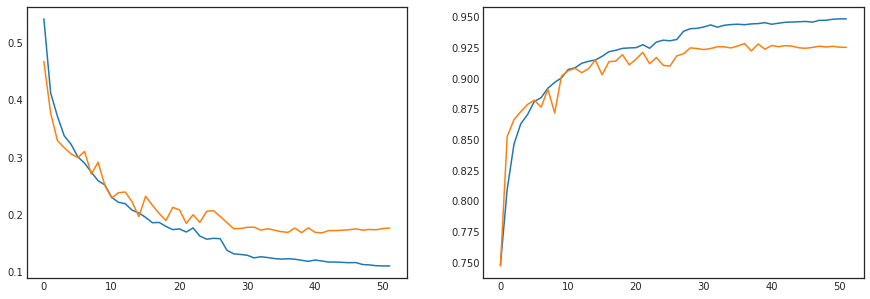

In [17]:
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_acc.plot(history.epoch, history.history["acc"], label="Train accuracy")
ax_acc.plot(history.epoch, history.history["val_acc"], label="Validation accuracy")

In [18]:
model = load_model(model_filepath, custom_objects={'my_iou_metric': my_iou_metric})

In [19]:
downsample128to101 = downsample(128,101)

In [20]:
preds_valid = model.predict(x_valid).reshape(-1, img_size_target, img_size_target)
preds_valid = np.array([downsample128to101(x) for x in preds_valid])
y_valid_ori = np.array([train_df.loc[idx].masks for idx in ids_valid])

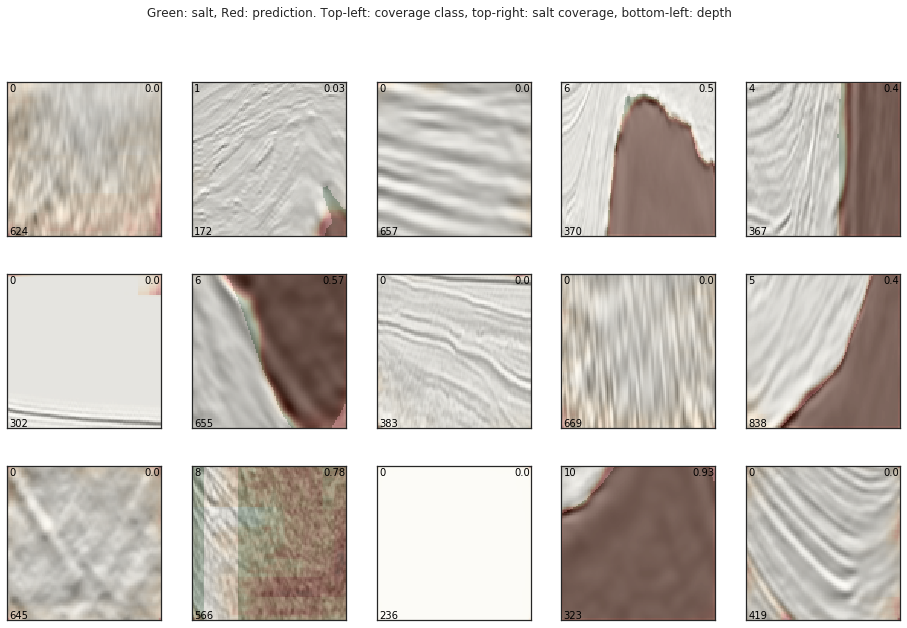

In [21]:
plot_predictions(train_df, preds_valid, ids_valid, max_images=15, grid_width=5, figsize=(16,10))

In [22]:
thresholds = np.linspace(0, 1, 50)
ious = list(map(lambda th: iou_metric_batch(y_valid_ori, np.int32(preds_valid > th)), 
                tqdm_notebook(thresholds)))

In [23]:
threshold_best_index = np.argmax(ious[9:-10]) + 9
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

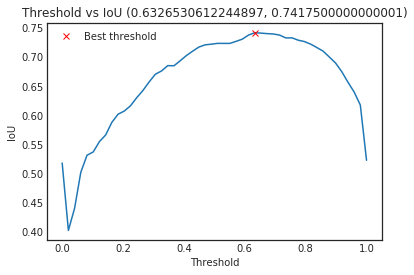

In [24]:
plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

In [25]:
preds_thresh = list(map(lambda pred: np.array(np.round(pred > threshold_best), dtype=np.float32), preds_valid))

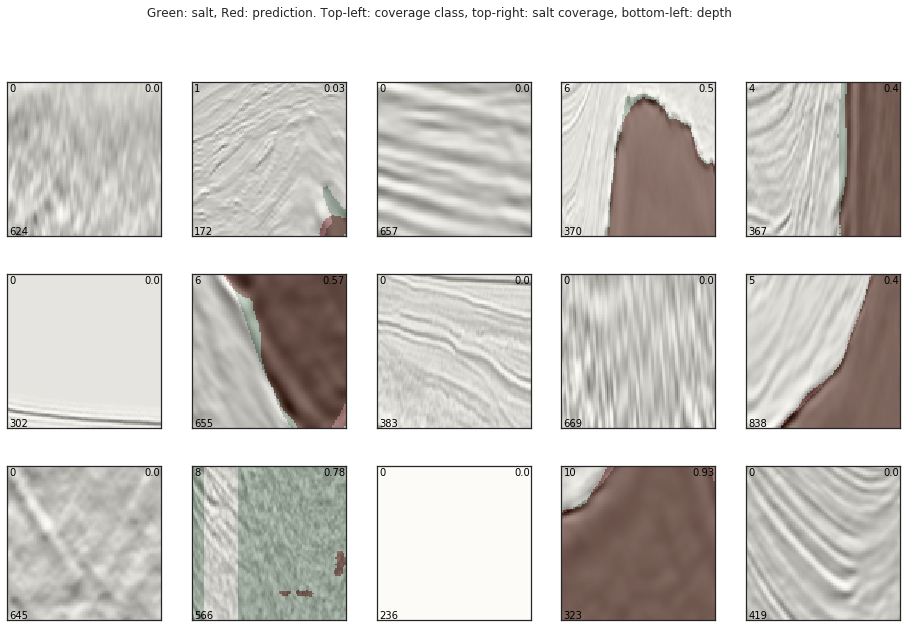

In [26]:
plot_predictions(train_df, preds_thresh, ids_valid, max_images=15, grid_width=5, figsize=(16,10))

In [27]:
img_size_target=128
x_test = load_images_as_arrays(test_df.index, test_images_path())
x_test = np.array(list(map(upsample101to128, x_test)))

  0%|          | 0/18000 [00:00<?, ?it/s]

  1%|          | 130/18000 [00:00<00:13, 1296.24it/s]

  1%|▏         | 260/18000 [00:00<00:13, 1296.02it/s]

  2%|▏         | 392/18000 [00:00<00:13, 1302.73it/s]

  3%|▎         | 523/18000 [00:00<00:13, 1304.30it/s]

  4%|▎         | 651/18000 [00:00<00:13, 1294.71it/s]

  4%|▍         | 782/18000 [00:00<00:13, 1296.53it/s]

  5%|▌         | 907/18000 [00:00<00:13, 1279.42it/s]

  6%|▌         | 1034/18000 [00:00<00:13, 1275.59it/s]

  6%|▋         | 1157/18000 [00:00<00:13, 1259.42it/s]

  7%|▋         | 1282/18000 [00:01<00:13, 1256.03it/s]

  8%|▊         | 1406/18000 [00:01<00:13, 1249.67it/s]

  9%|▊         | 1532/18000 [00:01<00:13, 1250.57it/s]

  9%|▉         | 1658/18000 [00:01<00:13, 1251.78it/s]

 10%|▉         | 1783/18000 [00:01<00:12, 1248.43it/s]

 11%|█         | 1911/18000 [00:01<00:12, 1255.29it/s]

 11%|█▏        | 2038/18000 [00:01<00:12, 1258.55it/s]

 12%|█▏        | 2164/18000 [00:01<00:12, 1253.00it/s]

 13%|█▎        | 2290/18000 [00:01<00:12, 1249.30it/s]

 13%|█▎        | 2415/18000 [00:01<00:12, 1248.30it/s]

 14%|█▍        | 2540/18000 [00:02<00:12, 1239.61it/s]

 15%|█▍        | 2666/18000 [00:02<00:12, 1244.90it/s]

 16%|█▌        | 2791/18000 [00:02<00:12, 1241.32it/s]

 16%|█▌        | 2916/18000 [00:02<00:12, 1243.04it/s]

 17%|█▋        | 3042/18000 [00:02<00:11, 1247.67it/s]

 18%|█▊        | 3169/18000 [00:02<00:11, 1251.35it/s]

 18%|█▊        | 3295/18000 [00:02<00:11, 1243.63it/s]

 19%|█▉        | 3421/18000 [00:02<00:11, 1247.33it/s]

 20%|█▉        | 3546/18000 [00:02<00:11, 1247.73it/s]

 20%|██        | 3675/18000 [00:02<00:11, 1259.14it/s]

 21%|██        | 3802/18000 [00:03<00:11, 1261.99it/s]

 22%|██▏       | 3929/18000 [00:03<00:11, 1259.89it/s]

 23%|██▎       | 4056/18000 [00:03<00:11, 1254.51it/s]

 23%|██▎       | 4182/18000 [00:03<00:11, 1249.77it/s]

 24%|██▍       | 4307/18000 [00:03<00:10, 1244.93it/s]

 25%|██▍       | 4432/18000 [00:03<00:10, 1239.15it/s]

 25%|██▌       | 4556/18000 [00:03<00:10, 1232.36it/s]

 26%|██▌       | 4680/18000 [00:03<00:10, 1229.00it/s]

 27%|██▋       | 4803/18000 [00:03<00:10, 1224.44it/s]

 27%|██▋       | 4926/18000 [00:03<00:10, 1222.00it/s]

 28%|██▊       | 5049/18000 [00:04<00:10, 1221.24it/s]

 29%|██▊       | 5172/18000 [00:04<00:10, 1220.70it/s]

 29%|██▉       | 5297/18000 [00:04<00:10, 1228.30it/s]

 30%|███       | 5422/18000 [00:04<00:10, 1232.51it/s]

 31%|███       | 5546/18000 [00:04<00:10, 1230.75it/s]

 32%|███▏      | 5670/18000 [00:04<00:10, 1232.99it/s]

 32%|███▏      | 5794/18000 [00:04<00:10, 1219.49it/s]

 33%|███▎      | 5917/18000 [00:04<00:09, 1220.91it/s]

 34%|███▎      | 6040/18000 [00:04<00:09, 1219.40it/s]

 34%|███▍      | 6165/18000 [00:04<00:09, 1226.91it/s]

 35%|███▍      | 6289/18000 [00:05<00:09, 1229.50it/s]

 36%|███▌      | 6416/18000 [00:05<00:09, 1240.59it/s]

 36%|███▋      | 6543/18000 [00:05<00:09, 1247.88it/s]

 37%|███▋      | 6668/18000 [00:05<00:09, 1245.06it/s]

 38%|███▊      | 6793/18000 [00:05<00:09, 1237.56it/s]

 38%|███▊      | 6921/18000 [00:05<00:08, 1248.30it/s]

 39%|███▉      | 7046/18000 [00:05<00:08, 1237.96it/s]

 40%|███▉      | 7170/18000 [00:05<00:08, 1238.55it/s]

 41%|████      | 7296/18000 [00:05<00:08, 1243.88it/s]

 41%|████      | 7421/18000 [00:05<00:08, 1245.11it/s]

 42%|████▏     | 7548/18000 [00:06<00:08, 1252.45it/s]

 43%|████▎     | 7676/18000 [00:06<00:08, 1259.42it/s]

 43%|████▎     | 7803/18000 [00:06<00:08, 1261.26it/s]

 44%|████▍     | 7930/18000 [00:06<00:08, 1252.99it/s]

 45%|████▍     | 8056/18000 [00:06<00:08, 1211.55it/s]

 45%|████▌     | 8180/18000 [00:06<00:08, 1219.19it/s]

 46%|████▌     | 8307/18000 [00:06<00:07, 1233.97it/s]

 47%|████▋     | 8432/18000 [00:06<00:07, 1235.99it/s]

 48%|████▊     | 8557/18000 [00:06<00:07, 1239.43it/s]

 48%|████▊     | 8682/18000 [00:06<00:07, 1237.76it/s]

 49%|████▉     | 8806/18000 [00:07<00:07, 1220.72it/s]

 50%|████▉     | 8933/18000 [00:07<00:07, 1233.93it/s]

 50%|█████     | 9057/18000 [00:07<00:07, 1204.32it/s]

 51%|█████     | 9181/18000 [00:07<00:07, 1212.95it/s]

 52%|█████▏    | 9308/18000 [00:07<00:07, 1227.96it/s]

 52%|█████▏    | 9434/18000 [00:07<00:06, 1237.34it/s]

 53%|█████▎    | 9558/18000 [00:07<00:06, 1236.40it/s]

 54%|█████▍    | 9685/18000 [00:07<00:06, 1245.16it/s]

 55%|█████▍    | 9812/18000 [00:07<00:06, 1250.47it/s]

 55%|█████▌    | 9941/18000 [00:07<00:06, 1260.64it/s]

 56%|█████▌    | 10068/18000 [00:08<00:06, 1260.37it/s]

 57%|█████▋    | 10195/18000 [00:08<00:06, 1261.78it/s]

 57%|█████▋    | 10322/18000 [00:08<00:06, 1262.46it/s]

 58%|█████▊    | 10449/18000 [00:08<00:06, 1256.06it/s]

 59%|█████▉    | 10576/18000 [00:08<00:05, 1257.64it/s]

 59%|█████▉    | 10702/18000 [00:08<00:05, 1253.98it/s]

 60%|██████    | 10828/18000 [00:08<00:05, 1254.94it/s]

 61%|██████    | 10955/18000 [00:08<00:05, 1257.96it/s]

 62%|██████▏   | 11081/18000 [00:08<00:05, 1253.71it/s]

 62%|██████▏   | 11207/18000 [00:08<00:05, 1253.07it/s]

 63%|██████▎   | 11333/18000 [00:09<00:05, 1249.85it/s]

 64%|██████▎   | 11458/18000 [00:09<00:05, 1243.82it/s]

 64%|██████▍   | 11585/18000 [00:09<00:05, 1249.82it/s]

 65%|██████▌   | 11712/18000 [00:09<00:05, 1253.95it/s]

 66%|██████▌   | 11838/18000 [00:09<00:04, 1249.83it/s]

 66%|██████▋   | 11963/18000 [00:09<00:04, 1248.27it/s]

 67%|██████▋   | 12090/18000 [00:09<00:04, 1252.41it/s]

 68%|██████▊   | 12216/18000 [00:09<00:04, 1250.04it/s]

 69%|██████▊   | 12342/18000 [00:09<00:04, 1246.42it/s]

 69%|██████▉   | 12467/18000 [00:10<00:04, 1245.77it/s]

 70%|██████▉   | 12592/18000 [00:10<00:04, 1236.93it/s]

 71%|███████   | 12717/18000 [00:10<00:04, 1239.93it/s]

 71%|███████▏  | 12842/18000 [00:10<00:04, 1188.75it/s]

 72%|███████▏  | 12969/18000 [00:10<00:04, 1210.13it/s]

 73%|███████▎  | 13091/18000 [00:10<00:04, 1211.47it/s]

 73%|███████▎  | 13217/18000 [00:10<00:03, 1222.47it/s]

 74%|███████▍  | 13342/18000 [00:10<00:03, 1228.68it/s]

 75%|███████▍  | 13469/18000 [00:10<00:03, 1240.16it/s]

 76%|███████▌  | 13594/18000 [00:10<00:03, 1241.15it/s]

 76%|███████▌  | 13721/18000 [00:11<00:03, 1247.22it/s]

 77%|███████▋  | 13847/18000 [00:11<00:03, 1250.91it/s]

 78%|███████▊  | 13973/18000 [00:11<00:03, 1245.97it/s]

 78%|███████▊  | 14098/18000 [00:11<00:03, 1244.19it/s]

 79%|███████▉  | 14223/18000 [00:11<00:03, 1245.05it/s]

 80%|███████▉  | 14349/18000 [00:11<00:02, 1248.83it/s]

 80%|████████  | 14476/18000 [00:11<00:02, 1254.95it/s]

 81%|████████  | 14602/18000 [00:11<00:02, 1245.13it/s]

 82%|████████▏ | 14728/18000 [00:11<00:02, 1247.98it/s]

 83%|████████▎ | 14854/18000 [00:11<00:02, 1248.96it/s]

 83%|████████▎ | 14981/18000 [00:12<00:02, 1252.95it/s]

 84%|████████▍ | 15107/18000 [00:12<00:02, 1253.46it/s]

 85%|████████▍ | 15233/18000 [00:12<00:02, 1251.02it/s]

 85%|████████▌ | 15362/18000 [00:12<00:02, 1260.37it/s]

 86%|████████▌ | 15489/18000 [00:12<00:01, 1262.01it/s]

 87%|████████▋ | 15616/18000 [00:12<00:01, 1260.59it/s]

 87%|████████▋ | 15743/18000 [00:12<00:01, 1258.65it/s]

 88%|████████▊ | 15870/18000 [00:12<00:01, 1260.43it/s]

 89%|████████▉ | 15997/18000 [00:12<00:01, 1258.74it/s]

 90%|████████▉ | 16123/18000 [00:12<00:01, 1255.32it/s]

 90%|█████████ | 16249/18000 [00:13<00:01, 1252.23it/s]

 91%|█████████ | 16375/18000 [00:13<00:01, 1251.38it/s]

 92%|█████████▏| 16502/18000 [00:13<00:01, 1254.46it/s]

 92%|█████████▏| 16628/18000 [00:13<00:01, 1253.18it/s]

 93%|█████████▎| 16754/18000 [00:13<00:00, 1253.65it/s]

 94%|█████████▍| 16881/18000 [00:13<00:00, 1255.88it/s]

 94%|█████████▍| 17007/18000 [00:13<00:00, 1254.67it/s]

 95%|█████████▌| 17133/18000 [00:13<00:00, 1247.72it/s]

 96%|█████████▌| 17259/18000 [00:13<00:00, 1249.09it/s]

 97%|█████████▋| 17385/18000 [00:13<00:00, 1250.95it/s]

 97%|█████████▋| 17512/18000 [00:14<00:00, 1255.39it/s]

 98%|█████████▊| 17639/18000 [00:14<00:00, 1259.17it/s]

 99%|█████████▊| 17765/18000 [00:14<00:00, 1256.06it/s]

 99%|█████████▉| 17892/18000 [00:14<00:00, 1258.42it/s]

100%|██████████| 18000/18000 [00:14<00:00, 1246.49it/s]

In [28]:
x_test = x_test.reshape(-1, img_size_target, img_size_target, 1)

In [29]:
preds_test = model.predict(x_test)

In [30]:
transform = compose(run_length_encode,
                    np.round,
                    lambda x: x > threshold_best,
                    downsample128to101)

In [31]:
pred_dict = {idx: transform(preds_test[i]) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}

In [32]:
now = datetime.datetime.now()

In [33]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
filename=os.path.join(model_path(),f"submission_{now:%d%b%Y_%H}.csv")
sub.to_csv(filename)